In [1]:
import pyute as ut
import autograd.numpy as np
import matplotlib.pyplot as plt
import sklearn
import h5py
import pdb
import scipy.optimize as sop
from autograd import elementwise_grad as egrad
from mpl_toolkits.mplot3d import Axes3D
import sklearn.discriminant_analysis as skd
import autograd.scipy.special as ssp
from autograd import jacobian
import size_contrast_analysis as sca
import scipy.stats as sst
%matplotlib notebook

/home/mossing/Documents/code/downloads/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
    def compute_tuning(dsfile):
        with h5py.File(dsfile,mode='r') as f:
            keylist = [key for key in f.keys()]
            tuning = [None]*len(keylist)
            uparam = [None]*len(keylist)
            for ikey in range(len(keylist)):
#             try:
                session = f[keylist[ikey]]
                print(session)
                print([key for key in session.keys()])
                if 'size_contrast_0' in session:
                    sc0 = session['size_contrast_0']
                    data = sc0['decon'][:]
                    stim_id = sc0['stimulus_id'][:]
                    nbefore = sc0['nbefore'][()]
                    nafter = sc0['nafter'][()]
                    trialrun = sc0['running_speed_cm_s'][:,nbefore:-nafter].mean(-1)>10 #
                    print(sc0['running_speed_cm_s'].shape)
                    print(np.nanmean(trialrun))
                    if np.nanmean(trialrun)>0.4:
                        tuning[ikey] = ut.compute_tuning(data,stim_id,trial_criteria=trialrun)[:]
                    for param in sc0['stimulus_parameters']:
                        uparam[ikey] = sc0[param][:]
    #             except:
    #                 print('could not do '+keylist[ikey])
        return tuning,uparam

In [3]:
dsname_pc = '/home/mossing/Documents/notebooks/shared_data/pyr_l23_data_struct.hdf5'
tuning_pc,uparam_pc = compute_tuning(dsname_pc)

<HDF5 group "/session_181205_M10130" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
(1400, 31)
0.26785714285714285
<HDF5 group "/session_181209_M8536" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
(1400, 31)
0.1692857142857143
<HDF5 group "/session_181213_M8536" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
(1400, 47)
0.9614285714285714


KeyboardInterrupt: 

In [ ]:
dsname_sst = '/home/mossing/Documents/notebooks/shared_data/sst_l23_data_struct.hdf5'
tuning_sst,uparam_sst = compute_tuning(dsname_sst)

In [ ]:
dsname_vip = '/home/mossing/Documents/notebooks/shared_data/vip_l23_data_struct.hdf5'
tuning_vip,uparam_vip = compute_tuning(dsname_vip)

In [ ]:
dsname_l4 = '/home/mossing/Documents/notebooks/shared_data/pyr_l4_data_struct.hdf5'
tuning_l4,uparam_l4 = compute_tuning(dsname_l4)

In [11]:
with h5py.File(dsname_vip,mode='r') as ds:
    keylist = list(ds.keys())
    print(list(ds[keylist[0]].keys()))

['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0']


In [12]:
def average_up(arr):
    return np.nanmean(np.nanmean(arr[:,:,:,:,8:-8],-1),-1) #.reshape((arr.shape[0],-1))

In [13]:
def columnize(arr):
    output = np.nanmean(arr,0).flatten()
    output = output/output.max()
    return output

In [14]:
rpc = average_up(np.concatenate([x[:,:5,[0,-5,-4,-3,-2,-1]] for x in [r for r in tuning_pc if not r is None]],axis=0))
rsst = average_up(np.concatenate([x for x in [r for r in tuning_sst if not r is None]],axis=0))
rvip = average_up(np.concatenate([[x for x in [r for r in tuning_vip if not r is None]][i] for i in [1,2,3,4,6]],axis=0))
rl4 = average_up(np.concatenate([x[:,:5] for x in [r for r in tuning_l4 if not r is None]],axis=0))

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)


In [15]:
def sum_to_1(r):
    R = r.reshape((r.shape[0],-1))
    R = R/np.nansum(R,axis=1)[:,np.newaxis]
    return R
Rl4 = sum_to_1(rl4)
Rs = [None,None,None,None]
for iR,r in enumerate([rl4,rpc,rsst,rvip]):
    Rs[iR] = sum_to_1(r)

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
j = 0
u,s,v = np.linalg.svd(Rs[j][~np.isnan(Rs[j][:,0])])
diaged = Rs[j] @ v.T
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(diaged[:,0],diaged[:,1],diaged[:,2],alpha=50/diaged.shape[0])
# plt.xlim(-1,1)
# plt.ylim(-1,1)

<IPython.core.display.Javascript object>

In [17]:
ucontrast = [str(c) for c in np.array((0,6,12,25,50,100))]
usize = [str(s) for s in (5,8,13,22,36)]
plt.figure(figsize=(8,2))
plt.subplot(1,4,1)
plt.imshow(rl4.mean(0))
plt.title('L4 PC')
plt.xticks(np.arange(6),ucontrast)
plt.yticks(np.arange(5),usize)
plt.xlabel('contrast (%)')
plt.ylabel('size ($^o$)')
plt.subplot(1,4,2)
plt.imshow(rpc.mean(0))
plt.title('L2/3 PC')
plt.xticks(np.arange(6),ucontrast)
plt.yticks(np.arange(5),usize)
plt.subplot(1,4,3)
plt.imshow(np.nanmean(rvip,0))
plt.title('VIP')
plt.xticks(np.arange(6),ucontrast)
plt.yticks(np.arange(5),usize)
plt.subplot(1,4,4)
plt.imshow(np.nanmean(rsst,0))
plt.tight_layout()
plt.title('SST')
plt.xticks(np.arange(6),ucontrast)
plt.yticks(np.arange(5),usize)
# plt.savefig('figures/size_contrast_array_with_l4.pdf')

<IPython.core.display.Javascript object>

([<matplotlib.axis.YTick at 0x7fa4bd4c2438>,
 <a list of 5 Text yticklabel objects>)

In [18]:
def f_miller_troyer(mu,s2):
    u = mu/np.sqrt(2*s2)
    A = 0.5*mu*(1+ssp.erf(u))
    B = np.sqrt(s2)/np.sqrt(2*np.pi)*np.exp(-u**2)
    return A + B
#     return 0.5*mu*(1+np.exp(u)) + sigma/np.sqrt(2*np.pi)*np.exp(-u**2) # 0.5*mu*(1+ssp.erf(u))

In [19]:
def fit_w(X,y,rate_fn,wm0=None,ws0=None,bounds=None):
    # X is (N,P), y is (N,). Finds w: (P,) weight matrix to explain y as y = f(X(wm),X(ws))
    # f is a static nonlinearity, given as a function of mean and std. of noise
    N,P = X.shape
    def parse_w(w):
        wm = w[:P]
        ws = w[P:]
#         return wm,ws,k
        return wm,ws
    def minusL(w):
#         wm,ws,k = parse_w(w)
        wm,ws = parse_w(w)
        return 0.5*np.sum((rate_fn(X @ wm,X @ ws)-y)**2) # k*
    def minusdLdw(w): 
        # sum in first dimension: (N,1) times (N,1) times (N,P)
        return egrad(minusL)(w)
    
    w0 = np.concatenate((wm0,ws0)) #,(k0,)))
    
    factr=1e7
    epsilon=1e-8
    pgtol=1e-5
    wstar = sop.fmin_l_bfgs_b(minusL,w0,fprime=minusdLdw,bounds=bounds,pgtol=pgtol,factr=factr,epsilon=epsilon)
    
    return wstar

In [20]:
def u_fn(X,Wx,Y,Wy):
    return X @ Wx + Y @ Wy

def evaluate_f_mt(X,Ws,offset):
    # Ws: Wx,Wy,s02,Y
    return f_miller_troyer(u_fn(X,Ws[0],Ws[3],Ws[1])+offset,Ws[2])

In [21]:
Wstar_dict = np.load('w_over_time_miller_troyer_3.npy',allow_pickle=True)[()]
Ws = [Wstar_dict[ww][-1] for ww in Wstar_dict.keys()]

In [22]:
def fit_w_data_loss(X,ydata,rate_fn,wm0=None,ws0=None,s020=None,bounds=None,niter=int(1e4)):
    # X is (N,P), y is (N,). Finds w: (P,) weight matrix to explain y as y = f(X(wm),X(ws))
    # f is a static nonlinearity, given as a function of mean and std. of noise
    N,P = X.shape
    abd = 1

    nroi = ydata.shape[0]
    alpha_roi = sst.norm.ppf(np.arange(1,nroi+1)/(nroi+1))
    
    def sort_by_11(w):
        yalpha11 = rate_fn_wrapper(w,np.array((-abd,abd)))
        difference11 = compute_y_distance(yalpha11[np.newaxis,:,:],ydata[:,np.newaxis,:])
        sortby11 = np.argsort(difference11[:,0]-difference11[:,-1])
        return sortby11
    
    def compute_y_distance(y1,y2):
        return np.sum((y1-y2)**2,axis=-1)
    
    def compare_sorted_to_expected(w,sortind):
       
        yalpha_roi = rate_fn_wrapper(w,alpha_roi)
#         print(yalpha_roi.max())
        difference_roi = compute_y_distance(yalpha_roi,ydata[sortind])
        difference_roi_unsorted = compute_y_distance(yalpha_roi,ydata)
#         print(difference_roi.shape)
        return difference_roi

    def rate_fn_wrapper(w,alphas):
        wm,ws,s02 = parse_w(w)
        inputs0 = [wm,np.array((0,)),s02,np.array((0,))]
        inputs1 = [X,ws,np.array((0,)),np.array((0,))]
        yalpha = rate_fn(X,inputs0,alphas[:,np.newaxis]*u_fn(*inputs1))
        yalpha = normalize(yalpha)
        return yalpha

#     def compute_f_by_itself(w):

    def normalize(arr):
        arrsum = arr.sum(1)
#         arrnorm = np.ones_like(arr)
#         arrnorm = arrnorm/arrnorm.shape[1]
        well_behaved = (arrsum>0)[:,np.newaxis]
        arrnorm = well_behaved*arr/arrsum[:,np.newaxis] + (~well_behaved)*np.ones_like(arr)/arr.shape[1]
        return arrnorm
    
    def parse_w(w):
        wm = w[:P]
        ws = w[P:-1]
        s02 = w[-1]
#         return wm,ws,k
        return wm,ws,s02

    def minusL(w,sortind):
#         wm,ws,k = parse_w(w)
        difference_roi = compare_sorted_to_expected(w,sortind)
#         print(difference_roi.shape)
#         print(str(w) + ' -> ' + str(np.round(np.sum(difference_roi),decimals=2)))
        return 0.5*np.sum(difference_roi) # k*
    
    def minusdLdw(w,sortind): 
        # sum in first dimension: (N,1) times (N,1) times (N,P)
        return egrad(lambda w: minusL(w,sortind))(w)
    
    def fix_violations(w,bounds):
        lb = np.array([b[0] for b in bounds])
        ub = np.array([b[1] for b in bounds])
        w[w<lb] = lb[w<lb]
        w[w>ub] = ub[w>ub]
        return w
    
    w0 = np.concatenate((wm0,ws0,s020)) #,(k0,)))
    
    factr=1e7
    epsilon=1e-8
    pgtol=1e-5
    this_w = w0
    for i in range(niter):
        
        sortind = sort_by_11(this_w)
        wstar = sop.fmin_l_bfgs_b(lambda w: minusL(w,sortind),this_w,fprime=lambda w: minusdLdw(w,sortind),bounds=bounds,pgtol=pgtol,factr=factr,epsilon=epsilon,maxiter=1)
        assert(~np.isnan(wstar[1]))
        if np.isnan(wstar[1]):
            this_w = old_w
        else:
            this_w = wstar[0].copy() + np.random.randn(*this_w.shape)*0.01*np.exp(-i/niter)
            old_w = wstar[0].copy()
        this_w = fix_violations(this_w,bounds)
        print(str(i) + ': ' + str(wstar[1]))
    
    max_alpha = alpha_roi.max()
    this_yalpha = rate_fn_wrapper(this_w,np.linspace(-max_alpha,max_alpha,101))
    ydist = compute_y_distance(ydata[sortind,np.newaxis],this_yalpha[np.newaxis,:])
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(ydist/ydist.max(1)[:,np.newaxis],extent=[-max_alpha,max_alpha,0,10])
    plt.plot(-alpha_roi,10*np.arange(nroi)/nroi,c='m')
    plt.subplot(2,2,2)
    plt.imshow(this_yalpha[25].reshape((5,6)))
    plt.subplot(2,2,4)
    plt.imshow(this_yalpha[75].reshape((5,6)))
#         print(wstar)
    
    return wstar

In [23]:
Xs = []
ys_data = []
ws = []
allowable_inputs = []
yms = []
for i in range(4):
    for item in [Xs,ys_data,ws,allowable_inputs,yms]:
        item.append(None)

In [24]:
allowable_inputs

[None, None, None, None]

In [25]:
icelltype = 2 # SST
factor = 1
allowable_inputs[icelltype] = [1,3] # PC, VIP
Xs[icelltype] = [np.nanmean(Rs[iinp],axis=0)[:,np.newaxis] for iinp in allowable_inputs[icelltype]]
Xs[icelltype] = np.concatenate(Xs[icelltype],axis=1)
Xs[icelltype] = np.concatenate((Xs[icelltype],np.ones((Xs[icelltype].shape[0],1))),axis=1)
ys_data[icelltype] = Rs[icelltype].copy() # [ind:ind+1]
ys_data[icelltype] = ys_data[icelltype][~np.isnan(ys_data[icelltype][:,0])]
wm0 = np.array((1,-1,0))*factor
ws0 = np.array((1,-1,0))*factor
s020 = np.array((1,))*factor
bounds = [(-np.inf,np.inf)]*7
bounds[-1] = (1e-2,np.inf)
niter = int(1e2)
wstar = fit_w_data_loss(Xs[icelltype],ys_data[icelltype],evaluate_f_mt,wm0=wm0,ws0=ws0,s020=s020,bounds=bounds,niter=niter)
ws[icelltype] = wstar[0].copy()
yms[icelltype] = f_miller_troyer(Xs[icelltype].dot(ws[icelltype][:3]),(Xs[icelltype].dot(ws[icelltype][3:-1]))**2 + ws[icelltype][-1])

0: 13.74299677991321
1: 7.907424849693004
2: 7.698684181704174
3: 8.188589284615844
4: 7.928385606080957
5: 7.877682779286991
6: 7.893694070981164
7: 7.7008682706242375
8: 6.563973423242413
9: 6.274922084259093
10: 6.212995520324123
11: 6.202448894087196
12: 6.1732325946928075
13: 6.13756651090772
14: 6.130356612502342
15: 6.156275286291665
16: 6.144366460394786
17: 6.143066184749486
18: 6.147914106343985
19: 6.144690241295096


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: divide by zero encountered in true_divide
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


20: 6.140724309687288
21: 6.145165365153876
22: 6.151958329369053
23: 6.16254313707785
24: 6.135172216547387
25: 6.119926134430968
26: 6.2017577255410945
27: 6.215042785354655
28: 6.146137673638352
29: 6.2159209470827355
30: 6.156610478324474
31: 6.164381516106177
32: 6.162193454045905
33: 6.153161972749729
34: 6.143840751471523
35: 6.146331108398563
36: 6.157454389295193
37: 6.128691702957594
38: 6.211902339899741
39: 6.127865182253253
40: 6.1057976771082405
41: 6.114440261346506
42: 6.125243666024689
43: 6.1278568997484175
44: 6.092461074043479
45: 6.08020337600588
46: 6.094106453390319
47: 6.090114724239001
48: 6.067413150293807
49: 6.072446137762128
50: 6.096187987247831
51: 6.160445232209503
52: 6.1050362298232
53: 5.961780304932095
54: 5.9630652848297325
55: 5.961505892581678
56: 5.959361864164109
57: 5.957060813472049
58: 5.958901144200156
59: 5.947940295209362
60: 5.9499481981505795
61: 5.957893527569452
62: 5.948245966025466
63: 5.949676407929447
64: 5.948661909589941
65: 5.94

<IPython.core.display.Javascript object>

In [26]:
def display_model_fit(y,ym):
    plt.figure()
    plt.subplot(1,2,1)
    sca.show_size_contrast(y.reshape((5,6)))
    plt.clim(vmin=y.min(),vmax=y.max())
#     plt.imshow(y.reshape((5,6)),vmax=y.max())
    plt.subplot(1,2,2)
    sca.show_size_contrast(ym.reshape((5,6)))
    plt.clim(vmin=y.min(),vmax=y.max())
    plt.tight_layout()
#     plt.imshow(ym.reshape((5,6)),vmax=y.max())
    #plt.figure()
    #sca.scatter_size_contrast(y,ym)
    #plt.plot((0,1),(0,1),c='r')
    #plt.xlabel('measured')
    #plt.ylabel('modeled')

In [27]:
ws[icelltype]

array([ 1.83974195e+00, -2.17011249e+00, -2.24711943e+00,  2.00809833e+00,
       -1.74791542e+00,  1.17135905e-03,  1.65331312e-01])

In [28]:
display_model_fit(ys_data[icelltype].mean(0),yms[icelltype]/yms[icelltype].sum())
plt.title('SST')
# plt.savefig('figures/sst_measured_modeled_mt.pdf')

<IPython.core.display.Javascript object>

Text(0.5, 1, 'SST')

In [29]:
icelltype = 3 # VIP
allowable_inputs[icelltype] = [0,1,2] # PC, SST
Xs[icelltype] = [np.nanmean(Rs[iinp],axis=0)[:,np.newaxis] for iinp in allowable_inputs[icelltype]]
Xs[icelltype] = np.concatenate(Xs[icelltype],axis=1)
Xs[icelltype] = np.concatenate((Xs[icelltype],np.ones((Xs[icelltype].shape[0],1))),axis=1)
ys_data[icelltype] = Rs[icelltype].copy() # [ind:ind+1]
ys_data[icelltype] = ys_data[icelltype][~np.isnan(ys_data[icelltype][:,0])]
wm0 = np.array((1,1,-1,1))*1
ws0 = np.array((1,1,-1,1))*1
s020 = np.array((1,))*1
bounds = [(-np.inf,np.inf)]*9
bounds[-1] = (1e-2,np.inf)
wstar = fit_w_data_loss(Xs[icelltype],ys_data[icelltype],evaluate_f_mt,wm0=wm0,ws0=ws0,s020=s020,bounds=bounds,niter=int(1e2))
ws[icelltype] = wstar[0].copy()
yms[icelltype] = f_miller_troyer(Xs[icelltype].dot(ws[icelltype][:3]),(Xs[icelltype].dot(ws[icelltype][3:-1]))**2 + ws[icelltype][-1])

0: 9.39917248731107
1: 9.161470910112095
2: 8.710478214275499


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)
/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in true_divide
  return f_raw(*args, **kwargs)
/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: divide by zero encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: overflow encountered i

AssertionError: 

In [ ]:
pdb.pm()

In [30]:
display_model_fit(ys_data[icelltype].mean(0),yms[icelltype]/yms[icelltype].sum())
plt.title('VIP')
# plt.savefig('figures/vip_measured_modeled_mt.pdf')

AttributeError: 'NoneType' object has no attribute 'sum'

0: 71.81556688453784
1: 71.48490547298078
2: 70.8186969054852
3: 68.43524106428467
4: 66.50519266816778
5: 65.56922266464505
6: 65.11013491181757
7: 64.24202954170192
8: 62.98426759882035
9: 62.14898536658641
10: 58.38034999198648
11: 57.94802025940574
12: 57.848118464257055
13: 57.81064060288334
14: 57.870327133938204
15: 57.78156033542505
16: 57.567061148974055
17: 57.527266886163005
18: 57.38057051693892
19: 57.23584419193693
20: 57.17666104802489
21: 57.1838822543872
22: 57.147422758520875
23: 56.884011391410894
24: 56.657013034883114
25: 56.62459058089458
26: 56.51673763189278
27: 56.48510301214013
28: 56.45541522084313
29: 56.15627158405576
30: 55.952185874587684
31: 55.90323359678503
32: 55.836481977759135
33: 55.806721507734196
34: 55.65417358947221
35: 55.560115613350604
36: 55.55527741510869
37: 55.4920435202143
38: 55.33077157824932
39: 55.022962076748406
40: 54.99161096977026
41: 54.973263164360944
42: 54.954382942835025
43: 54.738147258925
44: 54.69536992034131
45: 53.8285

<IPython.core.display.Javascript object>


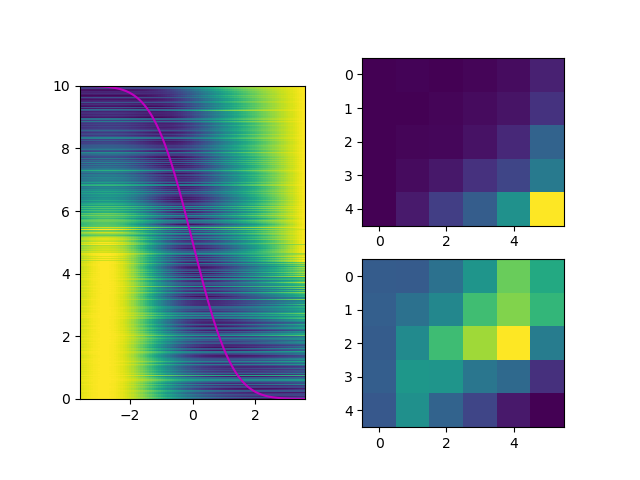

In [31]:
icelltype = 1 # VIP
allowable_inputs[icelltype] = [0,2] # PC, SST
Xs[icelltype] = [np.nanmean(Rs[iinp],axis=0)[:,np.newaxis] for iinp in allowable_inputs[icelltype]]
Xs[icelltype] = np.concatenate(Xs[icelltype],axis=1)
Xs[icelltype] = np.concatenate((Xs[icelltype],np.ones((Xs[icelltype].shape[0],1))),axis=1)
ys_data[icelltype] = Rs[icelltype].copy() # [ind:ind+1]
ys_data[icelltype] = ys_data[icelltype][~np.isnan(ys_data[icelltype][:,0])]
wm0 = np.array((1,-1,1))*1
ws0 = np.array((1,-1,1))*1
s020 = np.array((1,))*1
bounds = [(-np.inf,np.inf)]*7
bounds[-1] = (1e-2,np.inf)
wstar = fit_w_data_loss(Xs[icelltype],ys_data[icelltype],evaluate_f_mt,wm0=wm0,ws0=ws0,s020=s020,bounds=bounds,niter=int(1e2))
ws[icelltype] = wstar[0].copy()
yms[icelltype] = f_miller_troyer(Xs[icelltype].dot(ws[icelltype][:3]),(Xs[icelltype].dot(ws[icelltype][3:-1]))**2 + ws[icelltype][-1])

<IPython.core.display.Javascript object>


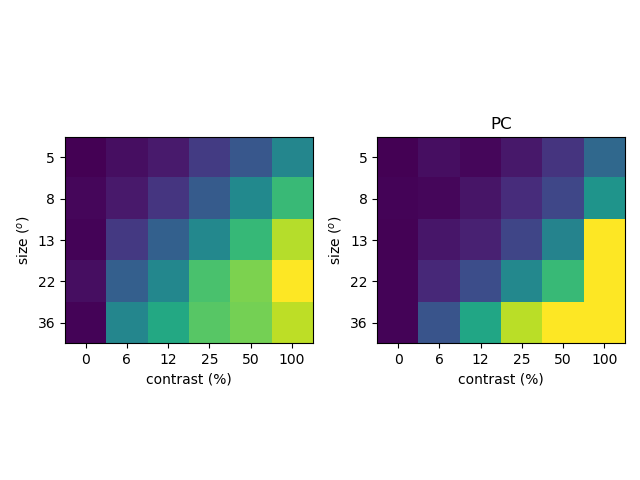

Text(0.5, 1, 'PC')

In [33]:
display_model_fit(ys_data[icelltype].mean(0),yms[icelltype]/yms[icelltype].sum())
plt.title('PC')
# plt.savefig('figures/pc_measured_modeled_mt.pdf')

In [ ]:
# find ML columns of wx,wy one by one from data: Ydata ~ Y = f(Xwx + Ywy)
# 1. linearize around Y = f(Xwx + Ywy) and find new ML wx,xy
# 2. solve Y = f(Xwx + Ywy) exactly for fixed wx,wy
# repeat from 1.

In [34]:
def compute_Y_nonlinear(X,Wmx,Wmy,Wsx,Wsy,s02,f,Y0=None,bounds=None,stop_early=False):
    factr=1e7
    epsilon=1e-8
    pgtol=1e-5
    
#     def parse_W(W): 
#         Wx = W[:nP*nQ].reshape((nP,nQ))
#         Wy = W[nP*nQ:].reshape((nQ,nQ))
#         return Wx,Wy
    
    def parse_Y(Y):
        return Y.reshape((nN,nQ))

    
#     Wx,Wy = parse_W(W)
    nN,nQ = Y0.shape
    
    Ystar = [None]*nN
    
    for i in range(nN):
        def minusL(y):
            def u_fn(Wx,Wy):
                return X[i] @ Wx + y @ Wy
            return 0.5*np.sum((f(u_fn(Wmx,Wmy),u_fn(Wsx,Wsy)**2+s02) - y)**2)

        def minusdLdy(y):
            return egrad(minusL)(y)
        
        if stop_early:
            maxiter = 25
        else:
            maxiter = 15000
        Ystar[i] = sop.fmin_l_bfgs_b(minusL,Y0[i],fprime=minusdLdy,bounds=bounds,pgtol=pgtol,factr=factr,epsilon=epsilon,maxiter=maxiter)
    
    return np.array([el[0] for el in Ystar]),Ystar

In [35]:
def fit_w_data_loss(X,ydata,rate_fn,wm0=None,ws0=None,s020=None,bounds=None,niter=int(1e4)):
    # X is (N,P), y is (N,). Finds w: (P,) weight matrix to explain y as y = f(X(wm),X(ws))
    # f is a static nonlinearity, given as a function of mean and std. of noise
    N,P = X.shape
    abd = 1

    nroi = ydata.shape[0]
    alpha_roi = sst.norm.ppf(np.arange(1,nroi+1)/(nroi+1))
    
    def sort_by_11(w):
        yalpha11 = rate_fn_wrapper(w,np.array((-abd,abd)))
        difference11 = compute_y_distance(yalpha11[np.newaxis,:,:],ydata[:,np.newaxis,:])
        sortby11 = np.argsort(difference11[:,0]-difference11[:,-1])
        return sortby11
    
    def compute_y_distance(y1,y2):
        return np.sum((y1-y2)**2,axis=-1)
    
    def compare_sorted_to_expected(w,sortind):
       
        yalpha_roi = rate_fn_wrapper(w,alpha_roi)
        difference_roi = compute_y_distance(yalpha_roi,ydata[sortind])
        difference_roi_unsorted = compute_y_distance(yalpha_roi,ydata)
        return difference_roi

    def rate_fn_wrapper(w,alphas):
        wm,ws,s02 = parse_w(w)
        inputs0 = [wm,np.array((0,)),s02,np.array((0,))]
        inputs1 = [X,ws,np.array((0,)),np.array((0,))]
        yalpha = rate_fn(X,inputs0,alphas[:,np.newaxis]*u_fn(*inputs1))
        yalpha = normalize(yalpha)
        return yalpha

#     def compute_f_by_itself(w):

    def normalize(arr):
        arrsum = arr.sum(1)
#         arrnorm = np.ones_like(arr)
#         arrnorm = arrnorm/arrnorm.shape[1]
        well_behaved = (arrsum>0)[:,np.newaxis]
        arrnorm = well_behaved*arr/arrsum[:,np.newaxis] + (~well_behaved)*np.ones_like(arr)/arr.shape[1]
        return arrnorm
    
    def parse_w(w):
        wm = w[:P]
        ws = w[P:-1]
        s02 = w[-1]
#         return wm,ws,k
        return wm,ws,s02

    def minusL(w,sortind):
#         wm,ws,k = parse_w(w)
        difference_roi = compare_sorted_to_expected(w,sortind)
#         print(difference_roi.shape)
#         print(str(w) + ' -> ' + str(np.round(np.sum(difference_roi),decimals=2)))
        return 0.5*np.sum(difference_roi) # k*
    
    def minusdLdw(w,sortind): 
        # sum in first dimension: (N,1) times (N,1) times (N,P)
        return egrad(lambda w: minusL(w,sortind))(w)
    
    def fix_violations(w,bounds):
        lb = np.array([b[0] for b in bounds])
        ub = np.array([b[1] for b in bounds])
        w[w<lb] = lb[w<lb]
        w[w>ub] = ub[w>ub]
        return w
    
    w0 = np.concatenate((wm0,ws0,s020)) #,(k0,)))
    
    factr=1e7
    epsilon=1e-8
    pgtol=1e-5
    this_w = w0
    for i in range(niter):
        
        sortind = sort_by_11(this_w)
        wstar = sop.fmin_l_bfgs_b(lambda w: minusL(w,sortind),this_w,fprime=lambda w: minusdLdw(w,sortind),bounds=bounds,pgtol=pgtol,factr=factr,epsilon=epsilon,maxiter=1)
        assert(~np.isnan(wstar[1]))
        if np.isnan(wstar[1]):
            this_w = old_w
        else:
            this_w = wstar[0].copy() + np.random.randn(*this_w.shape)*0.01*np.exp(-i/niter)
            old_w = wstar[0].copy()
        this_w = fix_violations(this_w,bounds)
        print(str(i) + ': ' + str(wstar[1]))
    
    max_alpha = alpha_roi.max()
    this_yalpha = rate_fn_wrapper(this_w,np.linspace(-max_alpha,max_alpha,101))
    ydist = compute_y_distance(ydata[sortind,np.newaxis],this_yalpha[np.newaxis,:])
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(ydist/ydist.max(1)[:,np.newaxis],extent=[-max_alpha,max_alpha,0,10])
    plt.plot(-alpha_roi,10*np.arange(nroi)/nroi,c='m')
    plt.subplot(2,2,2)
    plt.imshow(this_yalpha[25].reshape((5,6)))
    plt.subplot(2,2,4)
    plt.imshow(this_yalpha[75].reshape((5,6)))
#         print(wstar)
    
    return wstar

In [36]:
def u_fn(X,Wx,Y,Wy):
    return X @ Wx + Y @ Wy

def evaluate_f_mt(X,Ws,offset):
    # Ws: Wx,Wy,s02,Y
    return f_miller_troyer(u_fn(X,Ws[0],Ws[3],Ws[1])+offset,Ws[2])

In [37]:
def fit_W_momentum(X,Yhat,pop_rate_fn=None,neuron_rate_fn=None,Y0=None,W0mx=None,W0my=None,W0sx=None,W0sy=None,s020=None,bounds=None,niter=10,weight=None,eta=0.1,gamma=0.9):
    # X is (N,P), y is (N,Q). Finds wZx, wZy: (P,Q) + (Q,Q) weight matrices to explain Y as Y = f(Xwmx + Ywmy,Xwsx + Ywsy)
    # f is a static nonlinearity, given as a function
    
    factr=1e7
    epsilon=1e-8
    pgtol=1e-5
    fudge = 1e-4
    
    f_sq_second_argument = lambda a,b: pop_rate_fn(a,b**2)
    fprime_m = egrad(pop_rate_fn,0)
    fprime_s = egrad(f_sq_second_argument,1)
    fprime_s2 = egrad(pop_rate_fn,1)
    
    nN,nP = X.shape
    nQ = len(Yhat)
    assert(nN==Yhat[0].shape[1])
    
    first = True
    
    if weight is None:
        weight = np.ones((nQ,))
        
#     lower_bound = np.array([b[0] for b in bounds])
#     upper_bound = np.array([b[1] for b in bounds])
    
    ncelltypes = len(Yhat)
    nrois = [y.shape[0] for y in Yhat]
    alpha_rois = [sst.norm.ppf(np.arange(1,nroi+1)/(nroi+1)) for nroi in nrois]
    sortinds = [np.arange(nroi) for nroi in nrois]
    
    # Yhat is all measured tuning curves, Y is the averages of the model tuning curves
    
    def take_one_step(W0,Y00,momentum0=None,sortinds=None):
        
#         print(first)
        W0mx,W0my,W0sx,W0sy,s020 = parse_W(W0)
        Y0,_ = compute_Y_nonlinear(X,W0mx,W0my,W0sx,W0sy,s020,pop_rate_fn,Y0=Y00,stop_early=not first)
        sortinds = [None for icelltype in range(ncelltypes)]
        #W0 = np.concatenate((W0mx.flatten(),W0my.flatten(),W0sx.flatten(),W0sy.flatten(),s020.flatten()),axis=0)

        def compare_sorted_to_expected(Y,w,ydata,sortind,alpha_roi):
            yalpha_roi = neuron_rate_fn_wrapper(Y,w,alpha_roi)
            difference_roi = compute_y_distance(yalpha_roi,ydata[sortind])[0]
#             assert(True==False)
            return difference_roi
        
        def compute_f(W,Y):
            # returns value (N,Q)
            return compute_f_(X,W,Y)

        def compute_f_(x,W,y):
            Wmx,Wmy,Wsx,Wsy,s2 = parse_W(W)
            def u_fn(Wx,Wy): 
                return x @ Wx + y @ Wy
            return pop_rate_fn(u_fn(Wmx,Wmy),u_fn(Wsx,Wsy)**2+s2)

        def dfdW(W,Y):
            # returns value (N,Q,R)
            # dfdW(W,Y): 2*Q*(P+Q) + Q = R, (N,Q,R)
            fW = lambda W: compute_f(W,Y)
            return jacobian(fW)(W)
        
        def compute_difference(X,W,Y):
            Wmx,Wmy,Wsx,Wsy,s2 = parse_W(W)
            difference_roi = [np.zeros((nroi,)) for nroi in nrois]
            for icelltype in range(ncelltypes):
                w = unparse_W(Wmx[:,icelltype],Wmy[:,icelltype],Wsx[:,icelltype],Wsy[:,icelltype],s2[icelltype])
                difference_roi[icelltype] = compare_sorted_to_expected(Y,w,Yhat[icelltype],sortinds[icelltype],alpha_rois[icelltype])
            return difference_roi
        
        def dfdY(W,Y):
            compute_fs = [lambda y: compute_f_(x,W,y) for x in X]
            jacobians = [jacobian(this_compute_f)(y)[np.newaxis] for this_compute_f,y in zip(compute_fs,Y)]
            jac = np.concatenate(jacobians,axis=0)
            return jac
        
        def dYdW(W):
            # returns value (N,Q,R)
            A = np.linalg.inv(np.eye(nQ)[np.newaxis] - dfdY(W,Y0))
            B = dfdW(W,Y0)
            return A @ B
        
        def minusLWY(W,Y):
            # returns value float
            diffs = np.array([np.mean(x) for x in compute_difference(X,W,Y)])
            return 0.5*np.sum(weight*diffs)
                
        def minuspLpY(W,Y): # partial L partial Y
            return egrad(minusLWY,1)(W,Y)
        
        def minuspLpW(W,Y): # partial L partial W
            return egrad(minusLWY,0)(W,Y)
        
        def minusLW(W):
            # returns value float
            return minusLWY(W,compute_f(W,Y0))
    
        def minusdLdW(W): 
            # returns value (R,)
            # sum in first dimension: (N,1) times (N,1) times (N,P)
            return np.einsum('ij,ijk->k',minuspLpY(W,Y0),dYdW(W)) + minuspLpW(W,Y0)
        
        def ddifferencedW(W,Y):
            ftemp = lambda W: compute_difference(X,W,Y)[0]
            return jacobian(ftemp)(W)
        
        def ddifferencedY(Y):
            ftemp = lambda Y: compute_difference(X,W,Y)[0]
            return jacobian(ftemp)(Y)
        
        def fix_violations(w,bounds):
            lb = np.array([b[0] for b in bounds])
            ub = np.array([b[1] for b in bounds])
            lb_violation = w<lb
            ub_violation = w>ub
            w[lb_violation] = lb[lb_violation]
            w[ub_violation] = ub[ub_violation]
            return w,lb_violation,ub_violation
        
        
        if momentum0 is None:
            momentum0 = np.zeros_like(W0)
        deriv = minusdLdW(W0)
#         assert(True==False)
        print(deriv)
        momentum1 = gamma*momentum0 + (1-gamma)*eta*deriv
        W1 = W0 - momentum1
        
        W1,lb_violation,ub_violation = fix_violations(W1,bounds)
        momentum1[lb_violation | ub_violation] = 0
        loss = minusLW(W1)
#         W1mx,W1my,W1sx,W1sy,s021 = parse_W(W1)
        
        return W1,Y0,momentum1,loss
    
    def parse_W(W):
        shapes = [(nP,nQ),(nQ,nQ),(nP,nQ),(nQ,nQ),(nQ,)]
        Ws = parse_thing(W,shapes)
        return Ws
    
    def parse_thing(V,shapes):
        for shape in shapes:
            if type(shape) is int:
                shape = (shape,)
        sizes = [np.prod(shape) for shape in shapes]
        sofar = 0
        outputs = []
        for size,shape in zip(sizes,shapes):
            if size > 1:
                new_element = V[sofar:sofar+size].reshape(shape)
            else:
                new_element = V[sofar] # if just a float
            outputs.append(new_element)
            sofar = sofar + size
        return outputs
    
    def unparse_W(*Ws):
        return np.concatenate([ww.flatten() for ww in Ws])
    
    def unparse_w(*Ws,icelltype):
        return unparse_W(*[w.T[icelltype].T for w in Ws])
    
    def parse_w(w):
        shapes = [nP,nQ,nP,nQ,1]
        wws = parse_thing(w,shapes)
        wmx,wmy,wsx,wsy,s02 = wws
        return wmx,wmy,wsx,wsy,s02
    
    def normalize(arr):
        arrsum = arr.sum(1)
        well_behaved = (arrsum>0)[:,np.newaxis]
        arrnorm = well_behaved*arr/arrsum[:,np.newaxis] + (~well_behaved)*np.ones_like(arr)/arr.shape[1]
        return arrnorm
    
    def compute_y_distance(y1,y2):
        return np.sum((y1-y2)**2,axis=-1)
    
    def neuron_rate_fn_wrapper(Y,w,alphas):
        wmx,wmy,wsx,wsy,s02 = parse_w(w)
        inputs0 = [wmx,wmy,s02,Y]
        inputs1 = [X,wsx,Y,wsy]
        yalpha = neuron_rate_fn(X,inputs0,alphas[:,np.newaxis]*u_fn(*inputs1))
        yalpha = normalize(yalpha)
        return yalpha
    
    def sort_by_11(Y,w,ydata):
        yalpha11 = neuron_rate_fn_wrapper(Y,w,np.array((-abd,abd)))
        difference11 = compute_y_distance(yalpha11[np.newaxis,:,:],ydata[:,np.newaxis,:])
        sortby11 = np.argsort(difference11[:,0]-difference11[:,-1])
        return sortby11
    
    Wmx = np.zeros((niter+1,)+W0mx.shape)
    Wmy = np.zeros((niter+1,)+W0my.shape)
    Wsx = np.zeros((niter+1,)+W0sx.shape)
    Wsy = np.zeros((niter+1,)+W0sy.shape)
    s02 = np.zeros((niter+1,)+s020.shape)
    loss = np.zeros((niter+1,)+s020.shape)
    loss[0] = np.nan
    
    abd = 1
    
    W0 = unparse_W(W0mx,W0my,W0sx,W0sy,s020).copy()
    
    momentum = np.zeros((niter+1,)+W0.shape)
    
    Y = np.zeros((niter+1,nN,nQ))
    diagnostics = [None]*(niter+1)
    
    Wmx[0],Wmy[0],Wsx[0],Wsy[0],s02[0],Y[0] = W0mx,W0my,W0sx,W0sy,s020,Y0
    
    for iiter in range(niter):
        print(iiter)
        for icelltype in range(ncelltypes):
            w0 = unparse_w(Wmx[iiter],Wmy[iiter],Wsx[iiter],Wsy[iiter],s02[iiter],icelltype=icelltype).copy()
            sortinds[icelltype] = sort_by_11(Y[iiter],w0,Yhat[icelltype])
        W0 = unparse_W(Wmx[iiter],Wmy[iiter],Wsx[iiter],Wsy[iiter],s02[iiter]).copy()
        W1,Y[iiter+1],momentum[iiter+1],loss[iiter+1] = take_one_step(W0,Y[iiter],momentum0=momentum[iiter],sortinds=sortinds)
        Wmx[iiter+1],Wmy[iiter+1],Wsx[iiter+1],Wsy[iiter+1],s02[iiter+1] = parse_W(W1.copy())
        first = False
    
    return Wmx,Wmy,Wsx,Wsy,s02,Y,momentum,loss

In [38]:
def fit_W_sgd_momentum(X,Yhat,pop_rate_fn=None,neuron_rate_fn=None,Y0=None,W0mx=None,W0my=None,W0sx=None,W0sy=None,s020=None,bounds=None,niter=10,weight=None,eta=0.1,gamma=0.9, eta_decay=1e-4):
    # X is (N,P), y is (N,Q). Finds wZx, wZy: (P,Q) + (Q,Q) weight matrices to explain Y as Y = f(Xwmx + Ywmy,Xwsx + Ywsy)
    # f is a static nonlinearity, given as a function
    
    factr=1e7
    epsilon=1e-8
    pgtol=1e-5
    fudge = 1e-4
    
    f_sq_second_argument = lambda a,b: pop_rate_fn(a,b**2)
    fprime_m = egrad(pop_rate_fn,0)
    fprime_s = egrad(f_sq_second_argument,1)
    fprime_s2 = egrad(pop_rate_fn,1)
    
    nN,nP = X.shape
    nQ = len(Yhat)
    assert(nN==Yhat[0].shape[1])
    
    first = True
    
    if weight is None:
        weight = np.ones((nQ,))
        
#     lower_bound = np.array([b[0] for b in bounds])
#     upper_bound = np.array([b[1] for b in bounds])
    
    ncelltypes = len(Yhat)
    nrois = [int(np.round(y.shape[0]/2)) for y in Yhat]
    alpha_rois = [sst.norm.ppf(np.arange(1,nroi+1)/(nroi+1)) for nroi in nrois]
    sortinds = [np.arange(nroi) for nroi in nrois]
    
    # Yhat is all measured tuning curves, Y is the averages of the model tuning curves
    
    def take_one_step(W0,Y00,momentum0=None,sortinds=None,eta=eta):
        
#         print(first)
        W0mx,W0my,W0sx,W0sy,s020 = parse_W(W0)
        Y0,_ = compute_Y_nonlinear(X,W0mx,W0my,W0sx,W0sy,s020,pop_rate_fn,Y0=Y00,stop_early=not first)
        #sortinds = [None for icelltype in range(ncelltypes)]
        #W0 = np.concatenate((W0mx.flatten(),W0my.flatten(),W0sx.flatten(),W0sy.flatten(),s020.flatten()),axis=0)

        def compare_sorted_to_expected(Y,w,ydata,sortind,alpha_roi):
            yalpha_roi = neuron_rate_fn_wrapper(Y,w,alpha_roi)
            difference_roi = compute_y_distance(yalpha_roi,ydata[sortind])[0]
#             assert(True==False)
            return difference_roi
        
        def compute_f(W,Y):
            # returns value (N,Q)
            return compute_f_(X,W,Y)

        def compute_f_(x,W,y):
            Wmx,Wmy,Wsx,Wsy,s2 = parse_W(W)
            def u_fn(Wx,Wy): 
                return x @ Wx + y @ Wy
            return pop_rate_fn(u_fn(Wmx,Wmy),u_fn(Wsx,Wsy)**2+s2)

        def dfdW(W,Y):
            # returns value (N,Q,R)
            # dfdW(W,Y): 2*Q*(P+Q) + Q = R, (N,Q,R)
            fW = lambda W: compute_f(W,Y)
            return jacobian(fW)(W)
        
        def compute_difference(X,W,Y):
            Wmx,Wmy,Wsx,Wsy,s2 = parse_W(W)
            difference_roi = [np.zeros((nroi,)) for nroi in nrois]
            for icelltype in range(ncelltypes):
                w = unparse_W(Wmx[:,icelltype],Wmy[:,icelltype],Wsx[:,icelltype],Wsy[:,icelltype],s2[icelltype])
                difference_roi[icelltype] = compare_sorted_to_expected(Y,w,Yhat[icelltype],sortinds[icelltype],alpha_rois[icelltype])
            return difference_roi
        
        def dfdY(W,Y):
            compute_fs = [lambda y: compute_f_(x,W,y) for x in X]
            jacobians = [jacobian(this_compute_f)(y)[np.newaxis] for this_compute_f,y in zip(compute_fs,Y)]
            jac = np.concatenate(jacobians,axis=0)
            return jac
        
        def dYdW(W):
            # returns value (N,Q,R)
            A = np.linalg.inv(np.eye(nQ)[np.newaxis] - dfdY(W,Y0))
            B = dfdW(W,Y0)
            return A @ B
        
        def minusLWY(W,Y):
            # returns value float
            diffs = np.array([np.mean(x) for x in compute_difference(X,W,Y)])
            return 0.5*np.sum(weight*diffs)
                
        def minuspLpY(W,Y): # partial L partial Y
            return egrad(minusLWY,1)(W,Y)
        
        def minuspLpW(W,Y): # partial L partial W
            return egrad(minusLWY,0)(W,Y)
        
        def minusLW(W):
            # returns value float
            return minusLWY(W,compute_f(W,Y0))
    
        def minusdLdW(W): 
            # returns value (R,)
            # sum in first dimension: (N,1) times (N,1) times (N,P)
            return np.einsum('ij,ijk->k',minuspLpY(W,Y0),dYdW(W)) + minuspLpW(W,Y0)
        
        def ddifferencedW(W,Y):
            ftemp = lambda W: compute_difference(X,W,Y)[0]
            return jacobian(ftemp)(W)
        
        def ddifferencedY(Y):
            ftemp = lambda Y: compute_difference(X,W,Y)[0]
            return jacobian(ftemp)(Y)
        
        def fix_violations(w,bounds):
            lb = np.array([b[0] for b in bounds])
            ub = np.array([b[1] for b in bounds])
            lb_violation = w<lb
            ub_violation = w>ub
            w[lb_violation] = lb[lb_violation]
            w[ub_violation] = ub[ub_violation]
            return w,lb_violation,ub_violation
        
        
        if momentum0 is None:
            momentum0 = np.zeros_like(W0)
        deriv = minusdLdW(W0)
#         assert(True==False)
        print(deriv)
        momentum1 = gamma*momentum0 + (1-gamma)*eta*deriv
        W1 = W0 - momentum1
        
        W1,lb_violation,ub_violation = fix_violations(W1,bounds)
        momentum1[lb_violation | ub_violation] = 0
        loss = minusLW(W1)
#         W1mx,W1my,W1sx,W1sy,s021 = parse_W(W1)
        
        return W1,Y0,momentum1,loss
    
    def parse_W(W):
        shapes = [(nP,nQ),(nQ,nQ),(nP,nQ),(nQ,nQ),(nQ,)]
        Ws = parse_thing(W,shapes)
        return Ws
    
    def parse_thing(V,shapes):
        for shape in shapes:
            if type(shape) is int:
                shape = (shape,)
        sizes = [np.prod(shape) for shape in shapes]
        sofar = 0
        outputs = []
        for size,shape in zip(sizes,shapes):
            if size > 1:
                new_element = V[sofar:sofar+size].reshape(shape)
            else:
                new_element = V[sofar] # if just a float
            outputs.append(new_element)
            sofar = sofar + size
        return outputs
    
    def unparse_W(*Ws):
        return np.concatenate([ww.flatten() for ww in Ws])
    
    def unparse_w(*Ws,icelltype):
        return unparse_W(*[w.T[icelltype].T for w in Ws])
    
    def parse_w(w):
        shapes = [nP,nQ,nP,nQ,1]
        wws = parse_thing(w,shapes)
        wmx,wmy,wsx,wsy,s02 = wws
        return wmx,wmy,wsx,wsy,s02
    
    def normalize(arr):
        arrsum = arr.sum(1)
        well_behaved = (arrsum>0)[:,np.newaxis]
        arrnorm = well_behaved*arr/arrsum[:,np.newaxis] + (~well_behaved)*np.ones_like(arr)/arr.shape[1]
        return arrnorm
    
    def compute_y_distance(y1,y2):
        return np.sum((y1-y2)**2,axis=-1)
    
    def neuron_rate_fn_wrapper(Y,w,alphas):
        wmx,wmy,wsx,wsy,s02 = parse_w(w)
        inputs0 = [wmx,wmy,s02,Y]
        inputs1 = [X,wsx,Y,wsy]
        yalpha = neuron_rate_fn(X,inputs0,alphas[:,np.newaxis]*u_fn(*inputs1))
        yalpha = normalize(yalpha)
        return yalpha
    
    def sort_by_11(Y,w,ydata):
        yalpha11 = neuron_rate_fn_wrapper(Y,w,np.array((-abd,abd)))
        difference11 = compute_y_distance(yalpha11[np.newaxis,:,:],ydata[:,np.newaxis,:])
        sortby11 = np.argsort(difference11[:,0]-difference11[:,-1])
        return sortby11
    
    def sample_stochastic(sortby):
        nroi = sortby.size
        shuffinds = np.sort(np.random.permutation(nroi)[:int(np.round(nroi/2))])
        return sortby[shuffinds]
    
    Wmx = np.zeros((niter+1,)+W0mx.shape)
    Wmy = np.zeros((niter+1,)+W0my.shape)
    Wsx = np.zeros((niter+1,)+W0sx.shape)
    Wsy = np.zeros((niter+1,)+W0sy.shape)
    s02 = np.zeros((niter+1,)+s020.shape)
    loss = np.zeros((niter+1,)+s020.shape)
    loss[0] = np.nan
    
    abd = 1
    
    W0 = unparse_W(W0mx,W0my,W0sx,W0sy,s020).copy()
    
    momentum = np.zeros((niter+1,)+W0.shape)
    
    Y = np.zeros((niter+1,nN,nQ))
    diagnostics = [None]*(niter+1)
    
    Wmx[0],Wmy[0],Wsx[0],Wsy[0],s02[0],Y[0] = W0mx,W0my,W0sx,W0sy,s020,Y0
    
    for iiter in range(niter):
        print(iiter)
        for icelltype in range(ncelltypes):
            w0 = unparse_w(Wmx[iiter],Wmy[iiter],Wsx[iiter],Wsy[iiter],s02[iiter],icelltype=icelltype).copy()
            sortinds[icelltype] = sample_stochastic(sort_by_11(Y[iiter],w0,Yhat[icelltype]))
        W0 = unparse_W(Wmx[iiter],Wmy[iiter],Wsx[iiter],Wsy[iiter],s02[iiter]).copy()
        W1,Y[iiter+1],momentum[iiter+1],loss[iiter+1] = take_one_step(W0,Y[iiter],momentum0=momentum[iiter],sortinds=sortinds,eta=eta*np.exp(-eta_decay*iiter))
        Wmx[iiter+1],Wmy[iiter+1],Wsx[iiter+1],Wsy[iiter+1],s02[iiter+1] = parse_W(W1.copy())
        first = False
    
    return Wmx,Wmy,Wsx,Wsy,s02,Y,momentum,loss

In [39]:
# offset = 0
# wxfactor = 1e-2
# wyfactor = 1e-3
# W0my = np.array(((0,wsst[offset+1]),(wvip[offset+1],0)))*wyfactor
# W0mx = np.concatenate((wsst[[offset+0,offset+2],np.newaxis],wvip[[offset+0,offset+2],np.newaxis]),axis=1)*wxfactor
# offset = 3
# W0sy = np.array(((0,wsst[offset+1]),(wvip[offset+1],0)))*wyfactor
# W0sx = np.concatenate((wsst[[offset+0,offset+2],np.newaxis],wvip[[offset+0,offset+2],np.newaxis]),axis=1)*wxfactor
Yhat = [Rs[icelltype].copy() for icelltype in range(1,4)]
for i in range(len(Yhat)):
    Yhat[i] = Yhat[i][~np.isnan(Yhat[i][:,0])]
X = columnize(Rs[0])[:,np.newaxis]
X = np.concatenate((X,np.ones_like(X)),axis=1)
nN,nP = X.shape
nQ = len(Yhat)
W0mx = np.zeros((nP,nQ))
W0my = np.zeros((nQ,nQ))
W0sx = np.zeros((nP,nQ))
W0sy = np.zeros((nQ,nQ))
s020 = np.ones((nQ,))*5e-2
W0s = [W0mx,W0my,W0sx,W0sy,s020]

In [40]:
def parse_bounds(W0x_bounds,W0y_bounds,s02_bounds):
    bounds = [(-np.inf,np.inf)]*(2*(W0x_bounds.size+W0y_bounds.size) + s02_bounds.size)
    is_free = np.zeros((2*(W0x_bounds.size+W0y_bounds.size) + s02_bounds.size,))
    so_far = 0
    is_free = np.concatenate((W0x_bounds.flatten(),W0y_bounds.flatten(),np.abs(W0x_bounds).flatten(),np.abs(W0y_bounds).flatten()))
    for i in range(2*(W0x_bounds.size+W0y_bounds.size)):
        if is_free[i]==0:
            bounds[i] = (0,0)
        elif is_free[i]==-1:
            bounds[i] = (-np.inf,0)
    for i in range(2*(W0x_bounds.size+W0y_bounds.size),2*(W0x_bounds.size+W0y_bounds.size)+s02_bounds.size):
        bounds[i] = (0,np.inf)
    return bounds

In [41]:
W0x_bounds = np.ones((nP,nQ),dtype=int)
W0x_bounds[0,1] = 0
W0y_bounds = np.ones((nQ,nQ),dtype=int)
W0y_bounds[1:3,1:3] = np.array(((0,-1),(-1,0)))
W0y_bounds[1,0] = -1
W0y_bounds[2,0] = 0

W0mx[W0x_bounds>0] = np.random.randn((W0x_bounds>0).sum())
W0my[W0y_bounds>0] = np.random.randn((W0y_bounds>0).sum())
W0sx[W0x_bounds>0] = np.random.randn((W0x_bounds>0).sum())
W0sy[W0y_bounds>0] = np.random.randn((W0y_bounds>0).sum())

s02_bounds = np.ones((nQ,))

bounds = parse_bounds(W0x_bounds,W0y_bounds,s02_bounds)
bounds[-nQ:] = [(1,1)]*nQ

In [42]:
bounds[-nQ:] = [(x,x) for x in Wstar_t[4][-1]]

NameError: name 'Wstar_t' is not defined

In [43]:
def set_bounds_zeros(lb,ub,code):
    lb = set_bound_zeros(lb,code)
    ub = set_bound_zeros(ub,code)
    return lb,ub
def set_bound_zeros(bd,code):
    for iitem in range(len(bd)):
        bd[iitem][code[iitem]==0] = 0
    return bd

In [44]:
lb = [-np.inf*np.ones(shp) for shp in [(2,3),(3,3),(2,3),(3,3),(3,)]]
ub = [np.inf*np.ones(shp) for shp in [(2,3),(3,3),(2,3),(3,3),(3,)]]
bdlist = [W0x_bounds,W0y_bounds,W0x_bounds,W0y_bounds,s02_bounds]
lb,ub = set_bounds_zeros(lb,ub,bdlist)
ub = set_bound_zeros(ub,[ np.logical_or(bd>=0,(not i==1)) for i,bd in enumerate(bdlist)])
for bd in [lb,ub]:
    for ind in [2,3]:
        bd[ind][:,1] = 0
lb[-1] = np.ones_like(lb[-1])
ub[-1] = np.ones_like(ub[-1])
lb = np.concatenate([a.flatten() for a in lb])
ub = np.concatenate([b.flatten() for b in ub])
# temporary for no variation expt.
# temporary for no variation expt.
bounds = [(a,b) for a,b in zip(lb,ub)]

In [45]:
Y0,diagnostics = compute_Y_nonlinear(X,*W0s,f_miller_troyer,Y0=np.zeros((nN,nQ))) #_t_evolution

In [48]:
labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
Wstar_dict = np.load('w_over_time_miller_troyer_data_loss.npy',allow_pickle=True)[()]
Wstar_t = []
for i, label in enumerate(labels):
    Wstar_t.append(Wstar_dict[label])

In [49]:
Wstar_t_init = [ww[-1].copy() for ww in Wstar_t]

In [50]:
W0mx,W0my,W0sx,W0sy,s020 = [Wstar_t_init[i].copy() for i in range(5)]
Y0 = Wstar_t_init[-3].copy()

In [52]:
bounds

[(-inf, inf),
 (0.0, 0.0),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, 0.0),
 (0.0, 0.0),
 (-inf, 0.0),
 (0.0, 0.0),
 (-inf, 0.0),
 (0.0, 0.0),
 (-inf, inf),
 (0.0, 0.0),
 (-inf, inf),
 (-inf, inf),
 (0.0, 0.0),
 (-inf, inf),
 (-inf, inf),
 (0.0, 0.0),
 (-inf, inf),
 (-inf, inf),
 (0.0, 0.0),
 (-inf, inf),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0)]

In [51]:
niter = int(5e3)
eta = 1
gamma = 0.9
eta_decay = 1e-3
weight = np.array((1,1,1))
# thisY0 = np.ones_like(Y0)
Wstar_t = fit_W_momentum(X.copy(),Yhat.copy(),pop_rate_fn=f_miller_troyer,neuron_rate_fn=evaluate_f_mt,Y0=Y0,W0mx=W0mx.copy(),W0my=W0my.copy(),W0sx=W0sx.copy(),W0sy=W0sy.copy(),s020=s020.copy(),bounds=bounds,niter=niter,weight=weight,eta=eta,gamma=gamma)#,eta_decay=eta_decay)

0


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


[ 3.95068590e-05  2.53815088e-05 -5.16704528e-05  7.34754652e-06
 -5.46485144e-05  7.79210205e-05 -3.16700150e-05  1.80952682e-06
 -5.90642643e-05 -1.15465878e-04 -9.98636953e-05  5.11006587e-05
  1.65660009e-04  2.83068937e-05 -1.34656519e-05  2.34165699e-06
 -3.17759880e-06  1.81641622e-05 -5.71034846e-06 -2.61984991e-05
  6.08970842e-05  9.85323667e-07 -2.15618679e-05 -1.84799579e-06
 -7.24512978e-06 -8.49224811e-05 -2.77315672e-05  4.93707016e-07
  2.71881860e-06  1.37385850e-04 -4.09529530e-05 -1.68292440e-05
 -5.54782595e-06]
1
[ 2.43467973e-04  1.23483885e-04 -8.96005842e-05  2.61079846e-04
 -1.77740126e-04  1.37096558e-04  3.21070972e-04  2.58155207e-04
 -1.49998322e-04  2.42063075e-04  3.16803597e-04 -1.20208237e-04
  6.96588183e-04 -2.02393138e-04  1.01020448e-04  4.63972317e-06
  5.56926287e-05  1.03582044e-04 -1.32921243e-05  2.45131936e-04
  4.70500873e-05  8.35125732e-06  6.61134987e-06  2.07494719e-04
  5.79862249e-06 -8.51883579e-05  3.01386101e-04 -1.36793409e-05
  4.9

[ 1.98398374e-04  1.13461770e-04 -7.18666764e-05  2.45655924e-04
 -1.69853776e-04  1.35412038e-04  2.22721596e-04  2.29580824e-04
 -1.07753437e-04  9.41203606e-05  2.67521960e-04 -5.23976779e-05
  6.73274378e-04 -1.81599746e-04  9.33412340e-05  4.12438376e-06
  5.49459926e-05  1.03572047e-04 -1.09620762e-05  2.45621898e-04
  5.11778624e-05  6.31573768e-06  4.79741235e-06  2.03915706e-04
  2.17954789e-06 -8.64543252e-05  2.93046108e-04 -9.26210242e-06
  4.98067582e-04  1.01639040e-04  2.06221485e-06 -1.63591754e-04
  2.96066136e-05]
17
[ 1.94825378e-04  1.12614043e-04 -7.04797995e-05  2.44442426e-04
 -1.69246736e-04  1.35181033e-04  2.15132466e-04  2.27318447e-04
 -1.04565227e-04  8.28544034e-05  2.63626176e-04 -4.72906471e-05
  6.71193901e-04 -1.80077874e-04  9.27183769e-05  4.08982668e-06
  5.48808619e-05  1.03451148e-04 -1.07651741e-05  2.45665726e-04
  5.14867827e-05  6.17631239e-06  4.62267891e-06  2.03357235e-04
  1.92873856e-06 -8.65753670e-05  2.91950576e-04 -8.90097475e-06
  4.

[ 1.48717657e-04  1.01231217e-04 -5.32047674e-05  2.28750578e-04
 -1.59517671e-04  1.31153516e-04  1.16508403e-04  1.95231010e-04
 -6.32144895e-05 -6.14752049e-05  2.08689039e-04  1.86300901e-05
  6.43189936e-04 -1.56055864e-04  8.20375106e-05  3.43856482e-06
  5.39910380e-05  1.00188612e-04 -8.33872001e-06  2.46173041e-04
  5.53131299e-05  3.86158945e-06  2.22642090e-06  1.92463459e-04
 -2.01534947e-06 -8.79938564e-05  2.72201413e-04 -4.42072537e-06
  4.97745573e-04  1.13431355e-04  2.16434550e-05 -1.49892936e-04
  2.98003796e-05]
33
[ 1.46629284e-04  1.00624273e-04 -5.24850957e-05  2.27966659e-04
 -1.59042733e-04  1.30855092e-04  1.12211190e-04  1.93594800e-04
 -6.14809357e-05 -6.76050005e-05  2.05893717e-04  2.14042990e-05
  6.41662661e-04 -1.54890498e-04  8.13830116e-05  3.40308352e-06
  5.39505689e-05  9.98191772e-05 -8.23041792e-06  2.46201993e-04
  5.54361755e-05  3.75502164e-06  2.09055503e-06  1.91478593e-04
 -2.19254213e-06 -8.80623260e-05  2.70555972e-04 -4.23173410e-06
  4.

KeyboardInterrupt: 

In [53]:
lb = [-np.inf*np.ones(shp) for shp in [(2,3),(3,3),(2,3),(3,3),(3,)]]
ub = [np.inf*np.ones(shp) for shp in [(2,3),(3,3),(2,3),(3,3),(3,)]]
bdlist = [W0x_bounds,W0y_bounds,W0x_bounds,W0y_bounds,s02_bounds]
lb,ub = set_bounds_zeros(lb,ub,bdlist)
ub = set_bound_zeros(ub,[ np.logical_or(bd>=0,(not i==1)) for i,bd in enumerate(bdlist)])
for bd in [lb,ub]:
    for ind in [2,3]:
        bd[ind][:,1] = 0
lb[-1] = np.ones_like(lb[-1])
ub[-1] = np.ones_like(ub[-1])
# temporary for no variation expt.
lb[2] = np.zeros_like(lb[2])
lb[3] = np.zeros_like(lb[3])
ub[2] = np.zeros_like(ub[2])
ub[3] = np.zeros_like(ub[3])
# temporary for no variation expt.
lb = np.concatenate([a.flatten() for a in lb])
ub = np.concatenate([b.flatten() for b in ub])
bounds = [(a,b) for a,b in zip(lb,ub)]

In [54]:
bounds

[(-inf, inf),
 (0.0, 0.0),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (-inf, 0.0),
 (0.0, 0.0),
 (-inf, 0.0),
 (0.0, 0.0),
 (-inf, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0)]

In [68]:
Wstar_t_init = [ww[-1].copy() for ww in Wstar_t]
W0mx,W0my,W0sx,W0sy,s020 = [Wstar_t_init[i].copy() for i in range(5)]
Y0 = Wstar_t_init[-3].copy()

In [69]:
niter = int(5e3)
eta = 1
gamma = 0.9
eta_decay = 1e-3
weight = np.array((1,1,10))
thisY0 = np.ones_like(Y0)
Wstar_t_novar = fit_W_momentum(X.copy(),Yhat.copy(),pop_rate_fn=f_miller_troyer,neuron_rate_fn=evaluate_f_mt,Y0=thisY0,W0mx=W0mx.copy(),W0my=W0my.copy(),W0sx=W0sx.copy(),W0sy=W0sy.copy(),s020=s020.copy(),bounds=bounds,niter=niter,weight=weight,eta=eta,gamma=gamma)#,eta_decay=eta_decay)

0
[ 4.28480747e-04  1.73612392e-04 -5.53228196e-04  9.22487332e-04
  1.72297952e-04  6.36874799e-04 -2.59520915e-04 -1.09862348e-04
 -6.06375554e-04 -1.25820632e-03 -7.45253760e-04  5.98480043e-04
  2.89167083e-03  1.00398209e-03 -4.42284715e-04  2.05888870e-05
 -1.03992113e-04  1.28021143e-04 -2.05365030e-05 -9.90900340e-06
  5.58662227e-04  2.97909613e-05 -1.98286626e-04 -1.28975384e-04
  1.47899549e-06 -2.29205366e-04 -4.52590290e-04  7.56276490e-06
 -7.64871072e-05  1.30133255e-03 -8.25433963e-05  9.83637933e-06
 -1.88804302e-05]
1
[ 8.51121368e-04  3.59078563e-04 -5.89940917e-04  1.55082429e-03
  1.12963561e-04  4.91742411e-04  5.34361478e-04  3.92855717e-04
 -6.35822888e-04 -6.94814117e-04  4.95593039e-05  1.34664667e-04
  4.17391006e-03  7.89766197e-04 -4.36744449e-04  9.82024401e-07
  5.63038463e-05  4.54147961e-03  1.62189504e-05  2.46008357e-04
  2.04920135e-04 -9.61542750e-06  7.36432881e-06  1.00642266e-02
 -2.74083635e-05 -8.54133947e-05  1.56452928e-02  4.03385916e-05
  5

[ 3.05794994e-04  1.82312684e-04 -3.23157954e-04  1.00876848e-03
 -3.77274375e-05  5.62295815e-04 -4.84370209e-04  4.87720019e-05
 -5.15061356e-05 -2.14863087e-03 -4.60996225e-04  1.06120664e-03
  3.20750310e-03  5.35914231e-04 -3.69919091e-04  9.18235258e-07
  5.82821307e-05  4.42700516e-03  1.63296508e-05  2.52575588e-04
  1.00099919e-04 -9.84498252e-06  6.76140206e-06  9.72172464e-03
 -2.76653504e-05 -9.04374472e-05  1.49130396e-02  4.05563324e-05
  5.19375075e-04 -3.86766247e-05  1.45514200e-04 -2.22846888e-04
  1.27819060e-04]
17
[ 2.86772513e-04  1.75599647e-04 -3.14411672e-04  9.85429196e-04
 -4.56032190e-05  5.65816785e-04 -5.17170027e-04  3.67162315e-05
 -3.29854363e-05 -2.19221170e-03 -4.78180838e-04  1.09070551e-03
  3.16436872e-03  5.22249293e-04 -3.66254490e-04  9.16166139e-07
  5.84741931e-05  4.42282816e-03  1.63416250e-05  2.53094834e-04
  9.64836008e-05 -9.86391215e-06  6.76051216e-06  9.70687548e-03
 -2.76979957e-05 -9.08002146e-05  1.48775211e-02  4.05972872e-05
  5.

[ 3.86171287e-04  1.95110288e-04 -3.76786265e-04  9.63388196e-04
 -8.82011852e-05  5.86063645e-04 -2.73510185e-04  9.70033656e-05
 -1.79392925e-04 -1.78226364e-03 -3.78330584e-04  8.76541812e-04
  3.10549592e-03  4.47905983e-04 -3.48731654e-04  9.34305823e-07
  6.15972831e-05  4.43900345e-03  1.65489876e-05  2.59925454e-04
  1.16497425e-04 -1.01217263e-05  7.56756160e-06  9.68620785e-03
 -2.83295067e-05 -9.49449329e-05  1.47299041e-02  4.15121004e-05
  5.38008649e-04 -4.50219732e-05  1.00103691e-04 -2.39664440e-04
  1.29545667e-04]
33
[ 3.99072712e-04  1.98394245e-04 -3.83985510e-04  9.67422726e-04
 -8.97129532e-05  5.86794016e-04 -2.45301355e-04  1.04977148e-04
 -1.95770006e-04 -1.73750438e-03 -3.65794823e-04  8.52005269e-04
  3.11090891e-03  4.45139330e-04 -3.48145526e-04  9.36113497e-07
  6.18059488e-05  4.44133457e-03  1.65630591e-05  2.60358717e-04
  1.18930082e-04 -1.01383882e-05  7.62779714e-06  9.68786302e-03
 -2.83721875e-05 -9.51969239e-05  1.47260101e-02  4.15768146e-05
  5.

[ 4.07563235e-04  1.89629971e-04 -4.00348029e-04  8.69866292e-04
 -1.49312162e-04  6.14650898e-04 -1.72174380e-04  1.09425332e-04
 -2.41575260e-04 -1.56118839e-03 -3.45172191e-04  7.88062657e-04
  2.90387955e-03  3.39426447e-04 -3.19376074e-04  9.36528438e-07
  6.47036983e-05  4.44228426e-03  1.67566408e-05  2.67079787e-04
  1.20574162e-04 -1.03989489e-05  7.91872507e-06  9.62222125e-03
 -2.88791655e-05 -9.94863803e-05  1.45006057e-02  4.23630472e-05
  5.55907637e-04 -4.71403218e-05  6.11144201e-05 -2.51288073e-04
  1.31507025e-04]
49
[ 4.00573394e-04  1.86680638e-04 -3.97753678e-04  8.57052835e-04
 -1.54721948e-04  6.17175144e-04 -1.81483725e-04  1.05057539e-04
 -2.36640715e-04 -1.56929981e-03 -3.50500783e-04  7.95748636e-04
  2.87853481e-03  3.29878170e-04 -3.16634669e-04  9.35253629e-07
  6.48832148e-05  4.44107275e-03  1.67681946e-05  2.67525452e-04
  1.19303386e-04 -1.04152070e-05  7.90813994e-06  9.61451767e-03
 -2.89031130e-05 -9.97834107e-05  1.44797182e-02  4.24040521e-05
  5.

[ 3.53376185e-04  1.61955552e-04 -3.86320965e-04  7.24729927e-04
 -2.17961435e-04  6.47202531e-04 -2.16476494e-04  7.59148340e-05
 -2.21409997e-04 -1.54337627e-03 -3.78039670e-04  8.18836764e-04
  2.60482275e-03  2.18520694e-04 -2.84645052e-04  9.22680022e-07
  6.72472318e-05  4.43587952e-03  1.69348301e-05  2.73338010e-04
  1.10465913e-04 -1.06558861e-05  7.64485492e-06  9.53289146e-03
 -2.92573797e-05 -1.03655778e-04  1.42417335e-02  4.30171780e-05
  5.71184275e-04 -4.42190059e-05  3.37299514e-05 -2.54910325e-04
  1.33988102e-04]
65
[ 3.54522637e-04  1.61765945e-04 -3.87586335e-04  7.20316725e-04
 -2.20863379e-04  6.48615980e-04 -2.11113987e-04  7.66593297e-05
 -2.24664200e-04 -1.53070748e-03 -3.75970278e-04  8.13669657e-04
  2.59426305e-03  2.13374723e-04 -2.83149741e-04  9.22249539e-07
  6.73869572e-05  4.43644898e-03  1.69453942e-05  2.73671883e-04
  1.10615896e-04 -1.06711576e-05  7.62424585e-06  9.52983480e-03
 -2.92764754e-05 -1.03878742e-04  1.42310921e-02  4.30541932e-05
  5.

[ 3.67362406e-04  1.58828816e-04 -4.03729655e-04  6.58985884e-04
 -2.59982474e-04  6.68188292e-04 -1.42479561e-04  8.56321443e-05
 -2.66361770e-04 -1.36314002e-03 -3.50514964e-04  7.46781291e-04
  2.44740164e-03  1.46072531e-04 -2.64296625e-04  9.11631922e-07
  6.92018671e-05  4.44592292e-03  1.70902698e-05  2.78123169e-04
  1.11746892e-04 -1.08811752e-05  7.08502678e-06  9.48627451e-03
 -2.95474317e-05 -1.06807426e-04  1.40849841e-02  4.35813839e-05
  5.82541502e-04 -4.53991921e-05  7.12250585e-06 -2.61974343e-04
  1.36063304e-04]
81
[ 3.65789529e-04  1.57982752e-04 -4.03661820e-04  6.53556450e-04
 -2.62567707e-04  6.69454271e-04 -1.42709998e-04  8.47837246e-05
 -2.66713700e-04 -1.35897265e-03 -3.51020256e-04  7.45876113e-04
  2.43529661e-03  1.41732987e-04 -2.63029443e-04  9.10180025e-07
  6.93006132e-05  4.44618616e-03  1.70989986e-05  2.78386687e-04
  1.11221765e-04 -1.08901297e-05  7.03328859e-06  9.48214547e-03
 -2.95527566e-05 -1.06982404e-04  1.40735770e-02  4.36031433e-05
  5.

[ 3.44940905e-04  1.46639623e-04 -4.03051055e-04  5.78663066e-04
 -2.99069005e-04  6.88309369e-04 -1.43676801e-04  7.36121749e-05
 -2.70785108e-04 -1.29553114e-03 -3.57272272e-04  7.33701424e-04
  2.26636539e-03  8.16609509e-05 -2.46424546e-04  8.91017686e-07
  7.06764414e-05  4.45297642e-03  1.72218453e-05  2.82025720e-04
  1.06290500e-04 -1.10796981e-05  6.08704905e-06  9.43287385e-03
 -2.97189857e-05 -1.09522098e-04  1.39313215e-02  4.39874662e-05
  5.91406369e-04 -4.41908599e-05 -9.74340692e-06 -2.63543224e-04
  1.38514735e-04]
97
[ 3.46336677e-04  1.46874488e-04 -4.03695509e-04  5.75257019e-04
 -3.00951147e-04  6.89979719e-04 -1.42406865e-04  7.31935836e-05
 -2.71101731e-04 -1.29357897e-03 -3.58814049e-04  7.34024365e-04
  2.26503420e-03  8.14371734e-05 -2.47195984e-04  8.95802472e-07
  7.06186319e-05  4.45346373e-03  1.72388917e-05  2.82030691e-04
  1.05859089e-04 -1.11399743e-05  5.96474215e-06  9.42944913e-03
 -2.98577414e-05 -1.09495889e-04  1.39224183e-02  4.41270691e-05
  5.

[ 3.39083204e-04  1.41912567e-04 -4.09397476e-04  5.26372610e-04
 -3.25807922e-04  7.02343230e-04 -1.20099849e-04  7.29771975e-05
 -2.89522307e-04 -1.19845040e-03 -3.49788347e-04  6.97213257e-04
  2.13581284e-03  4.00069331e-05 -2.35264666e-04  8.64006299e-07
  7.16319857e-05  4.46475327e-03  1.73297193e-05  2.84860779e-04
  1.02798112e-04 -1.12265097e-05  4.79140313e-06  9.39343693e-03
 -2.97300010e-05 -1.11517665e-04  1.38173770e-02  4.42199196e-05
  5.97224532e-04 -4.40372943e-05 -2.26701296e-05 -2.64524140e-04
  1.40720899e-04]
113
[ 3.37227083e-04  1.41276931e-04 -4.09072398e-04  5.22458930e-04
 -3.27318995e-04  7.03233333e-04 -1.22061051e-04  7.19143045e-05
 -2.88967870e-04 -1.19811805e-03 -3.51177035e-04  6.97649741e-04
  2.12764516e-03  3.82222753e-05 -2.34927282e-04  8.66397510e-07
  7.16941156e-05  4.46528015e-03  1.73425168e-05  2.85037356e-04
  1.02198821e-04 -1.12638950e-05  4.70858247e-06  9.39021944e-03
 -2.98132721e-05 -1.11636186e-04  1.38091998e-02  4.43094239e-05
  5

[ 3.24872644e-04  1.36608158e-04 -4.11323647e-04  4.79974217e-04
 -3.46114385e-04  7.13924553e-04 -1.19498307e-04  6.71811934e-05
 -2.96270518e-04 -1.14165955e-03 -3.52585207e-04  6.77296534e-04
  2.02098794e-03  1.28201414e-05 -2.29473603e-04  8.38611845e-07
  7.22606155e-05  4.47776543e-03  1.74293860e-05  2.87028352e-04
  9.80674899e-05 -1.13873034e-05  3.28449532e-06  9.35846876e-03
 -2.97671851e-05 -1.13159369e-04  1.37225872e-02  4.44452611e-05
  6.01168689e-04 -4.32232725e-05 -2.97728979e-05 -2.62844026e-04
  1.43208209e-04]
129
[ 3.25196939e-04  1.36757838e-04 -4.11391924e-04  4.77652286e-04
 -3.47215837e-04  7.15741076e-04 -1.22002924e-04  6.58524697e-05
 -2.94591809e-04 -1.14705342e-03 -3.56160678e-04  6.81172462e-04
  2.02375458e-03  1.49058191e-05 -2.31375658e-04  8.45808231e-07
  7.21930273e-05  4.47875483e-03  1.74491490e-05  2.86992164e-04
  9.78901981e-05 -1.14595087e-05  3.14300896e-06  9.35688254e-03
 -2.99508394e-05 -1.13162415e-04  1.37179632e-02  4.46230689e-05
  6

[ 3.19314246e-04  1.35082585e-04 -4.16129468e-04  4.46246934e-04
 -3.61009292e-04  7.24335100e-04 -1.10234541e-04  6.52735335e-05
 -3.06273046e-04 -1.08162449e-03 -3.53190620e-04  6.54722002e-04
  1.93822483e-03 -3.69346144e-07 -2.29643795e-04  8.18483552e-07
  7.26053638e-05  4.49347932e-03  1.75268388e-05  2.88582206e-04
  9.41316925e-05 -1.15754538e-05  1.66351649e-06  9.33243202e-03
 -2.98926077e-05 -1.14370373e-04  1.36511087e-02  4.47271251e-05
  6.03341929e-04 -4.27891444e-05 -3.56297763e-05 -2.60554143e-04
  1.46116659e-04]
145
[ 3.17859803e-04  1.34616475e-04 -4.16266430e-04  4.43486395e-04
 -3.62028861e-04  7.24561851e-04 -1.09875963e-04  6.51150163e-05
 -3.07239748e-04 -1.07570589e-03 -3.52342825e-04  6.51726098e-04
  1.92807702e-03 -2.78505390e-06 -2.28681329e-04  8.14732947e-07
  7.26337063e-05  4.49447474e-03  1.75293568e-05  2.88686210e-04
  9.38271947e-05 -1.15657133e-05  1.56730113e-06  9.33082319e-03
 -2.98421582e-05 -1.14448095e-04  1.36469503e-02  4.46893561e-05
  6

[ 3.07578725e-04  1.32756979e-04 -4.18374752e-04  4.15285273e-04
 -3.72129748e-04  7.32265957e-04 -1.12733854e-04  6.10305064e-05
 -3.11579660e-04 -1.03995188e-03 -3.57624493e-04  6.37834286e-04
  1.85696463e-03 -7.76183582e-06 -2.31138304e-04  7.91224221e-07
  7.27624529e-05  4.50979358e-03  1.76059989e-05  2.89739030e-04
  8.92127731e-05 -1.16978972e-05 -3.54743965e-08  9.30957026e-03
 -2.98447514e-05 -1.15346151e-04  1.35912156e-02  4.48231154e-05
  6.04372294e-04 -4.16510918e-05 -3.78144235e-05 -2.56708684e-04
  1.48865960e-04]
161
[ 3.08192302e-04  1.33067146e-04 -4.19111431e-04  4.14717764e-04
 -3.72470392e-04  7.32696171e-04 -1.10884212e-04  6.15639491e-05
 -3.12992428e-04 -1.03491585e-03 -3.56779336e-04  6.35290899e-04
  1.85485573e-03 -7.55422772e-06 -2.31578972e-04  7.89256208e-07
  7.28379898e-05  4.51102802e-03  1.76108606e-05  2.89904212e-04
  8.91317678e-05 -1.17000319e-05 -1.09966804e-07  9.30888665e-03
 -2.98283379e-05 -1.15451943e-04  1.35890656e-02  4.48180144e-05
  6

[ 2.97948552e-04  1.31821312e-04 -4.20990836e-04  3.90035953e-04
 -3.80146716e-04  7.39207291e-04 -1.15698747e-04  5.75066654e-05
 -3.16413540e-04 -1.00487580e-03 -3.62855488e-04  6.22670528e-04
  1.79151102e-03 -7.43296181e-06 -2.35817007e-04  7.66467238e-07
  7.28711891e-05  4.52720117e-03  1.76823286e-05  2.90706817e-04
  8.42743087e-05 -1.18240523e-05 -1.71313223e-06  9.29210708e-03
 -2.98162299e-05 -1.16165547e-04  1.35450739e-02  4.49190116e-05
  6.04869641e-04 -4.06037300e-05 -3.86716971e-05 -2.52408560e-04
  1.51867276e-04]
177
[ 3.01635712e-04  1.33154837e-04 -4.23137737e-04  3.92276381e-04
 -3.79763995e-04  7.39051505e-04 -1.07471954e-04  6.02897237e-05
 -3.21197791e-04 -9.89979051e-04 -3.58532560e-04  6.14870691e-04
  1.79224684e-03 -6.70270184e-06 -2.36051100e-04  7.65400175e-07
  7.28932463e-05  4.52881378e-03  1.76878816e-05  2.90780220e-04
  8.47172597e-05 -1.18345948e-05 -1.81009966e-06  9.29301019e-03
 -2.98260182e-05 -1.16220962e-04  1.35458893e-02  4.49338336e-05
  6

[ 2.92561776e-04  1.32411039e-04 -4.25464360e-04  3.69598697e-04
 -3.86515554e-04  7.45045215e-04 -1.10085659e-04  5.70606492e-05
 -3.25379449e-04 -9.57249314e-04 -3.63231953e-04  6.00884585e-04
  1.73168276e-03 -5.03862232e-06 -2.40992377e-04  7.42395792e-07
  7.28804749e-05  4.54558549e-03  1.77530066e-05  2.91426369e-04
  7.95193744e-05 -1.19415266e-05 -3.36876140e-06  9.27972334e-03
 -2.97766872e-05 -1.16798936e-04  1.35107885e-02  4.49864045e-05
  6.04627139e-04 -3.97136957e-05 -3.96285868e-05 -2.48286475e-04
  1.54745748e-04]
193
[ 2.91572640e-04  1.32301844e-04 -4.25460221e-04  3.68072948e-04
 -3.86810219e-04  7.45369112e-04 -1.10971004e-04  5.66652373e-05
 -3.25377541e-04 -9.56406783e-04 -3.63967604e-04  6.00522290e-04
  1.72751629e-03 -4.64505222e-06 -2.41335029e-04  7.41027421e-07
  7.28819386e-05  4.54678070e-03  1.77572547e-05  2.91472761e-04
  7.92193863e-05 -1.19492576e-05 -3.46826978e-06  9.27903739e-03
 -2.97791868e-05 -1.16833662e-04  1.35090875e-02  4.49911187e-05
  6

[ 2.81331882e-04  1.31559935e-04 -4.27062199e-04  3.46886613e-04
 -3.92214846e-04  7.50711616e-04 -1.17012752e-04  5.27868197e-05
 -3.28023653e-04 -9.31792916e-04 -3.70482475e-04  5.89413932e-04
  1.67136126e-03  4.49365467e-08 -2.47295154e-04  7.20038974e-07
  7.28199790e-05  4.56399399e-03  1.78208898e-05  2.91978998e-04
  7.38464777e-05 -1.20575140e-05 -5.00337205e-06  9.26942522e-03
 -2.97523403e-05 -1.17311086e-04  1.34823248e-02  4.50455252e-05
  6.03859614e-04 -3.81980693e-05 -3.90526924e-05 -2.43153760e-04
  1.57845225e-04]
209
[ 2.81085674e-04  1.31549617e-04 -4.27250528e-04  3.45310082e-04
 -3.92942346e-04  7.51462008e-04 -1.16779501e-04  5.25794768e-05
 -3.28079846e-04 -9.29506951e-04 -3.70945231e-04  5.89184803e-04
  1.66790826e-03  2.04281735e-08 -2.47779860e-04  7.19362767e-07
  7.28176839e-05  4.56529497e-03  1.78254276e-05  2.92011790e-04
  7.37412103e-05 -1.20717079e-05 -5.10626576e-06  9.26941258e-03
 -2.97676414e-05 -1.17347259e-04  1.34818037e-02  4.50645603e-05
  6

[ 2.74950462e-04  1.32454827e-04 -4.30238402e-04  3.29187304e-04
 -3.96417129e-04  7.56180784e-04 -1.17932838e-04  5.07330439e-05
 -3.33044020e-04 -9.01985382e-04 -3.75745274e-04  5.75793539e-04
  1.62435196e-03  9.55119566e-06 -2.55671533e-04  7.01891407e-07
  7.26348072e-05  4.58354200e-03  1.78883716e-05  2.92259613e-04
  6.88482853e-05 -1.21881735e-05 -6.61588083e-06  9.26457443e-03
 -2.97789175e-05 -1.17645766e-04  1.34652818e-02  4.51426794e-05
  6.02271384e-04 -3.69273194e-05 -3.87501353e-05 -2.38284798e-04
  1.61166513e-04]
225
[ 2.75249314e-04  1.32749703e-04 -4.30756813e-04  3.28762597e-04
 -3.96544366e-04  7.56460418e-04 -1.16862307e-04  5.10275253e-05
 -3.33906344e-04 -8.98431508e-04 -3.75377618e-04  5.73959276e-04
  1.62256849e-03  1.03492377e-05 -2.56319055e-04  7.00823229e-07
  7.26253690e-05  4.58492056e-03  1.78924424e-05  2.92277067e-04
  6.87657569e-05 -1.21963105e-05 -6.71537607e-06  9.26491834e-03
 -2.97788713e-05 -1.17669554e-04  1.34654328e-02  4.51481603e-05
  6

[ 2.65705771e-04  1.32785772e-04 -4.32607197e-04  3.11844485e-04
 -3.99415329e-04  7.60069936e-04 -1.21780753e-04  4.83942106e-05
 -3.37967278e-04 -8.75298572e-04 -3.80660165e-04  5.61321609e-04
  1.57287894e-03  1.89392362e-05 -2.63112465e-04  6.82341238e-07
  7.24655668e-05  4.60318186e-03  1.79490702e-05  2.92508524e-04
  6.32171549e-05 -1.22873977e-05 -8.14019042e-06  9.26210337e-03
 -2.97357015e-05 -1.17923201e-04  1.34530838e-02  4.51616775e-05
  6.00566545e-04 -3.52698551e-05 -3.71023958e-05 -2.33111605e-04
  1.64214502e-04]
241
[ 2.68110288e-04  1.33515499e-04 -4.34126972e-04  3.11879851e-04
 -3.99983631e-04  7.60234578e-04 -1.14936923e-04  5.03437040e-05
 -3.41358080e-04 -8.61074019e-04 -3.76998271e-04  5.55071661e-04
  1.56853069e-03  1.77865644e-05 -2.62907049e-04  6.81261471e-07
  7.25404497e-05  4.60467658e-03  1.79526442e-05  2.92646853e-04
  6.32918314e-05 -1.22946161e-05 -8.19368556e-06  9.26307106e-03
 -2.97335927e-05 -1.17986337e-04  1.34542999e-02  4.51637847e-05
  6

[ 2.58961436e-04  1.33644840e-04 -4.35890988e-04  2.95315357e-04
 -4.02920443e-04  7.64255111e-04 -1.20457300e-04  4.73973006e-05
 -3.44571210e-04 -8.41235948e-04 -3.83267311e-04  5.44506781e-04
  1.52224881e-03  2.73672910e-05 -2.70575284e-04  6.63870234e-07
  7.23540766e-05  4.62334671e-03  1.80063484e-05  2.92776382e-04
  5.77914618e-05 -1.23795776e-05 -9.56520053e-06  9.26385841e-03
 -2.96889885e-05 -1.18160504e-04  1.34495509e-02  4.51607079e-05
  5.98907258e-04 -3.38125072e-05 -3.65262109e-05 -2.28385911e-04
  1.67315401e-04]
257
[ 2.59364066e-04  1.33745417e-04 -4.36230701e-04  2.93838291e-04
 -4.03865725e-04  7.65153451e-04 -1.19073507e-04  4.74419086e-05
 -3.44871381e-04 -8.37546021e-04 -3.83377698e-04  5.44044578e-04
  1.51925065e-03  2.71159043e-05 -2.71078397e-04  6.63211559e-07
  7.23513539e-05  4.62471179e-03  1.80102923e-05  2.92798339e-04
  5.77495211e-05 -1.23900762e-05 -9.65838962e-06  9.26462166e-03
 -2.96987038e-05 -1.18190451e-04  1.34505279e-02  4.51716086e-05
  5

[ 2.50247251e-04  1.33797998e-04 -4.38079899e-04  2.77361542e-04
 -4.06874524e-04  7.68742892e-04 -1.22744630e-04  4.51014288e-05
 -3.48968488e-04 -8.14123329e-04 -3.88113808e-04  5.31756199e-04
  1.47013419e-03  3.53684189e-05 -2.78060443e-04  6.44919543e-07
  7.21764068e-05  4.64356575e-03  1.80581806e-05  2.92890876e-04
  5.20037015e-05 -1.24514117e-05 -1.09560062e-05  9.26830967e-03
 -2.96033567e-05 -1.18303753e-04  1.34515326e-02  4.51068884e-05
  5.96778582e-04 -3.21684528e-05 -3.59835572e-05 -2.23607185e-04
  1.70557080e-04]
273
[ 2.51434720e-04  1.34215400e-04 -4.38985608e-04  2.76765730e-04
 -4.07384952e-04  7.69054783e-04 -1.18830558e-04  4.61354480e-05
 -3.50981514e-04 -8.05570393e-04 -3.86349051e-04  5.28201392e-04
  1.46635655e-03  3.49653232e-05 -2.78174011e-04  6.44552611e-07
  7.22319641e-05  4.64503716e-03  1.80623867e-05  2.92993091e-04
  5.19376890e-05 -1.24606198e-05 -1.10058582e-05  9.26939412e-03
 -2.96126131e-05 -1.18344574e-04  1.34531158e-02  4.51170329e-05
  5

[ 2.43776105e-04  1.34702080e-04 -4.40921712e-04  2.61155781e-04
 -4.10353205e-04  7.72995878e-04 -1.22123673e-04  4.38100527e-05
 -3.54542595e-04 -7.85065505e-04 -3.92057727e-04  5.17859487e-04
  1.42357419e-03  4.51143707e-05 -2.86394840e-04  6.32412005e-07
  7.20634164e-05  4.66419205e-03  1.81148719e-05  2.93042073e-04
  4.61848665e-05 -1.25525557e-05 -1.22377357e-05  9.27622902e-03
 -2.96143484e-05 -1.18410919e-04  1.34603195e-02  4.51357002e-05
  5.94729350e-04 -3.05075705e-05 -3.57095394e-05 -2.18956673e-04
  1.73888442e-04]
289
[ 2.41426539e-04  1.34374959e-04 -4.40397996e-04  2.59894292e-04
 -4.09991032e-04  7.72867977e-04 -1.25969594e-04  4.27997723e-05
 -3.53694574e-04 -7.89760979e-04 -3.93978796e-04  5.18863130e-04
  1.42064138e-03  4.66878914e-05 -2.87037126e-04  6.31700278e-07
  7.20216550e-05  4.66544368e-03  1.81186228e-05  2.93000737e-04
  4.57315226e-05 -1.25578663e-05 -1.23291201e-05  9.27672063e-03
 -2.96162489e-05 -1.18382920e-04  1.34606856e-02  4.51366882e-05
  5

[ 2.32489044e-04  1.33986706e-04 -4.41974600e-04  2.41622903e-04
 -4.14485207e-04  7.76961656e-04 -1.27726044e-04  4.04384725e-05
 -3.57552720e-04 -7.63785591e-04 -3.98299710e-04  5.07343908e-04
  1.36748624e-03  5.21173786e-05 -2.93333425e-04  6.16549377e-07
  7.19100023e-05  4.68467468e-03  1.81618451e-05  2.93094749e-04
  3.97492646e-05 -1.26140503e-05 -1.34652909e-05  9.28583476e-03
 -2.95281446e-05 -1.18437593e-04  1.34725346e-02  4.50551522e-05
  5.92350733e-04 -2.83751307e-05 -3.49228703e-05 -2.14022965e-04
  1.77111536e-04]
305
[ 2.36470244e-04  1.35859575e-04 -4.44004337e-04  2.46055682e-04
 -4.12713592e-04  7.76245867e-04 -1.21286624e-04  4.31556807e-05
 -3.61543689e-04 -7.53911739e-04 -3.94898102e-04  5.01045343e-04
  1.37458651e-03  5.63103707e-05 -2.94899610e-04  6.19388374e-07
  7.17841848e-05  4.68673068e-03  1.81702616e-05  2.92903213e-04
  4.02175002e-05 -1.26457438e-05 -1.35847224e-05  9.28892011e-03
 -2.96032267e-05 -1.18340432e-04  1.34777003e-02  4.51297034e-05
  5

[ 2.25291146e-04  1.34832982e-04 -4.44359673e-04  2.26695669e-04
 -4.17282104e-04  7.80886401e-04 -1.29338452e-04  3.87579500e-05
 -3.62360679e-04 -7.41381461e-04 -4.03585753e-04  4.95760579e-04
  1.32490465e-03  6.35332586e-05 -3.02386483e-04  6.04093328e-07
  7.17158622e-05  4.70602146e-03  1.82091870e-05  2.93020825e-04
  3.38015057e-05 -1.26843848e-05 -1.46408693e-05  9.30004114e-03
 -2.94856681e-05 -1.18386603e-04  1.34935184e-02  4.50068771e-05
  5.89617395e-04 -2.65057716e-05 -3.41556651e-05 -2.09384475e-04
  1.80608212e-04]
321
[ 2.26288299e-04  1.35220297e-04 -4.45661683e-04  2.26608410e-04
 -4.17438784e-04  7.80031413e-04 -1.22394317e-04  4.10550975e-05
 -3.66459336e-04 -7.24177803e-04 -3.98243781e-04  4.87117120e-04
  1.31465198e-03  6.07702733e-05 -3.00844693e-04  6.02792976e-07
  7.17384011e-05  4.70771524e-03  1.82107509e-05  2.93059417e-04
  3.39102140e-05 -1.26884714e-05 -1.46916012e-05  9.30234312e-03
 -2.94782060e-05 -1.18380960e-04  1.34971326e-02  4.49997981e-05
  5

[ 2.21413840e-04  1.36471285e-04 -4.48430025e-04  2.13585774e-04
 -4.20137896e-04  7.83653280e-04 -1.20285425e-04  4.06075089e-05
 -3.72259396e-04 -6.98755014e-04 -4.01595191e-04  4.74798470e-04
  1.27644248e-03  7.12356292e-05 -3.09360650e-04  5.92107658e-07
  7.15960027e-05  4.72788791e-03  1.82523254e-05  2.92998819e-04
  2.79697499e-05 -1.27411020e-05 -1.57044971e-05  9.31781533e-03
 -2.94229732e-05 -1.18299125e-04  1.35214818e-02  4.49263734e-05
  5.87003495e-04 -2.46580020e-05 -3.42261285e-05 -2.05331586e-04
  1.83632968e-04]
337
[ 2.19137578e-04  1.35953040e-04 -4.48191532e-04  2.11820379e-04
 -4.20380372e-04  7.83314091e-04 -1.21105688e-04  4.03993173e-05
 -3.72640900e-04 -6.95498207e-04 -4.00937810e-04  4.72695752e-04
  1.26720067e-03  6.98069100e-05 -3.08657788e-04  5.89650182e-07
  7.15800573e-05  4.72932854e-03  1.82517105e-05  2.92985662e-04
  2.77838352e-05 -1.27369525e-05 -1.57802206e-05  9.31947657e-03
 -2.93893530e-05 -1.18297356e-04  1.35240171e-02  4.48932595e-05
  5

[ 2.14272881e-04  1.37292945e-04 -4.50811020e-04  1.99224903e-04
 -4.22819940e-04  7.86847046e-04 -1.20515515e-04  3.95647605e-05
 -3.77933304e-04 -6.74548111e-04 -4.05494538e-04  4.61624793e-04
  1.23278028e-03  8.17611624e-05 -3.17854946e-04  5.83239104e-07
  7.13428301e-05  4.74991951e-03  1.82959819e-05  2.92736351e-04
  2.21106657e-05 -1.28097713e-05 -1.67721988e-05  9.33864616e-03
 -2.94020692e-05 -1.18094779e-04  1.35552816e-02  4.48762348e-05
  5.83678968e-04 -2.29452308e-05 -3.34571371e-05 -2.00828086e-04
  1.86998413e-04]
353
[ 2.08734297e-04  1.35458428e-04 -4.48918616e-04  1.93368536e-04
 -4.24527232e-04  7.87769685e-04 -1.28559861e-04  3.63600696e-05
 -3.74201669e-04 -6.84084598e-04 -4.10059047e-04  4.66774837e-04
  1.22146997e-03  7.97974736e-05 -3.17721500e-04  5.80293281e-07
  7.13934147e-05  4.75062295e-03  1.82943370e-05  2.92828505e-04
  2.08658367e-05 -1.28001914e-05 -1.68157737e-05  9.33804776e-03
 -2.93530815e-05 -1.18137548e-04  1.35536358e-02  4.48262084e-05
  5

[ 2.02843136e-04  1.36451778e-04 -4.51252340e-04  1.80342105e-04
 -4.27062576e-04  7.91011650e-04 -1.28632222e-04  3.53778877e-05
 -3.79511119e-04 -6.63889417e-04 -4.14626787e-04  4.55679111e-04
  1.18458561e-03  9.08587114e-05 -3.26409650e-04  5.74278178e-07
  7.11647163e-05  4.77147430e-03  1.83351093e-05  2.92548216e-04
  1.50878221e-05 -1.28598789e-05 -1.77341008e-05  9.35989940e-03
 -2.93445812e-05 -1.17877456e-04  1.35897826e-02  4.47773038e-05
  5.80534913e-04 -2.03289365e-05 -3.28473384e-05 -1.96060176e-04
  1.90687168e-04]
369
[ 2.06958371e-04  1.38100742e-04 -4.52907958e-04  1.83010723e-04
 -4.26440554e-04  7.91392454e-04 -1.23400770e-04  3.71151507e-05
 -3.81843526e-04 -6.57597334e-04 -4.13383841e-04  4.52831038e-04
  1.19265301e-03  9.49523124e-05 -3.28686443e-04  5.82453368e-07
  7.10493899e-05  4.77322991e-03  1.83503512e-05  2.92360635e-04
  1.50359715e-05 -1.29201904e-05 -1.78171002e-05  9.36234244e-03
 -2.95055597e-05 -1.17741878e-04  1.35941119e-02  4.49358472e-05
  5

[ 1.98552965e-04  1.38155070e-04 -4.54141176e-04  1.67847290e-04
 -4.29695964e-04  7.94961585e-04 -1.27614582e-04  3.46229403e-05
 -3.85242314e-04 -6.44921903e-04 -4.20607504e-04  4.45385318e-04
  1.15349117e-03  1.05235787e-04 -3.37360350e-04  5.76029800e-07
  7.08181790e-05  4.79412517e-03  1.83865803e-05  2.92041301e-04
  8.93756907e-06 -1.29624831e-05 -1.86775539e-05  9.38624877e-03
 -2.94647538e-05 -1.17446321e-04  1.36340943e-02  4.48478082e-05
  5.76412971e-04 -1.82552018e-05 -3.26217022e-05 -1.91746849e-04
  1.94598375e-04]
385
[ 2.00769041e-04  1.39099448e-04 -4.55904477e-04  1.69777889e-04
 -4.29034175e-04  7.93570739e-04 -1.18603472e-04  3.79698493e-05
 -3.90402656e-04 -6.24361562e-04 -4.13463163e-04  4.34906963e-04
  1.14512422e-03  1.03097937e-04 -3.35811180e-04  5.72167364e-07
  7.09197206e-05  4.79586962e-03  1.83826478e-05  2.92186062e-04
  8.85104449e-06 -1.29480187e-05 -1.86891788e-05  9.38873487e-03
 -2.94027161e-05 -1.17520028e-04  1.36386816e-02  4.47808170e-05
  5

[ 1.93348645e-04  1.39297293e-04 -4.57406612e-04  1.54852386e-04
 -4.32758662e-04  7.97339606e-04 -1.21194314e-04  3.58463145e-05
 -3.94187625e-04 -6.09637542e-04 -4.20064756e-04  4.26922111e-04
  1.10687678e-03  1.12822427e-04 -3.44584406e-04  5.68129218e-07
  7.06949389e-05  4.81711435e-03  1.84179671e-05  2.91831604e-04
  2.84534331e-06 -1.29962826e-05 -1.94903787e-05  9.41562144e-03
 -2.93855885e-05 -1.17181105e-04  1.36842670e-02  4.47058723e-05
  5.73233188e-04 -1.60138999e-05 -3.25154348e-05 -1.87801589e-04
  1.97754430e-04]
401
[ 1.88049667e-04  1.37327969e-04 -4.55867907e-04  1.48281468e-04
 -4.34927614e-04  7.97979939e-04 -1.25925276e-04  3.35490347e-05
 -3.92116290e-04 -6.12141410e-04 -4.22500410e-04  4.28987925e-04
  1.09032190e-03  1.08556730e-04 -3.43221113e-04  5.65156346e-07
  7.08501987e-05  4.81782088e-03  1.84154791e-05  2.92072815e-04
  1.49191848e-06 -1.29845526e-05 -1.94778234e-05  9.41536044e-03
 -2.93447986e-05 -1.17260493e-04  1.36833467e-02  4.46629117e-05
  5

[ 1.80940788e-04  1.37926733e-04 -4.57739516e-04  1.35902359e-04
 -4.37348573e-04  8.00330267e-04 -1.26745920e-04  3.27922816e-05
 -3.97612333e-04 -5.93636300e-04 -4.26313153e-04  4.17453971e-04
  1.05236733e-03  1.18407869e-04 -3.51478041e-04  5.58752089e-07
  7.06266706e-05  4.83931562e-03  1.84433845e-05  2.91675213e-04
 -4.67930573e-06 -1.29994703e-05 -2.02186927e-05  9.44493860e-03
 -2.92484234e-05 -1.16877231e-04  1.37338549e-02  4.45002446e-05
  5.70129035e-04 -1.29273134e-05 -3.18843518e-05 -1.83469790e-04
  2.01152633e-04]
417
[ 1.86525414e-04  1.39968166e-04 -4.59928407e-04  1.39137802e-04
 -4.36941871e-04  8.01061545e-04 -1.19669594e-04  3.49342126e-05
 -4.00602223e-04 -5.84630175e-04 -4.24533525e-04  4.13835853e-04
  1.06223409e-03  1.22755692e-04 -3.53997766e-04  5.68497798e-07
  7.04805405e-05  4.84124184e-03  1.84606594e-05  2.91430801e-04
 -4.62232878e-06 -1.30673040e-05 -2.03039190e-05  9.44813564e-03
 -2.94344039e-05 -1.16725958e-04  1.37399005e-02  4.46795908e-05
  5

[ 1.76448391e-04  1.39545323e-04 -4.60596542e-04  1.24594714e-04
 -4.39793345e-04  8.03229455e-04 -1.24817454e-04  3.27968697e-05
 -4.04414348e-04 -5.73217552e-04 -4.30509422e-04  4.05128122e-04
  1.02002427e-03  1.31259744e-04 -3.61557645e-04  5.62890199e-07
  7.03567656e-05  4.86272224e-03  1.84852984e-05  2.91151403e-04
 -1.11006565e-05 -1.30819029e-05 -2.09514849e-05  9.47977279e-03
 -2.93356557e-05 -1.16379573e-04  1.37941682e-02  4.45042496e-05
  5.65986169e-04 -1.04377564e-05 -3.13613232e-05 -1.79523413e-04
  2.04964057e-04]
433
[ 1.80515459e-04  1.40878393e-04 -4.62206247e-04  1.25736270e-04
 -4.40079443e-04  8.03816954e-04 -1.18287189e-04  3.45551036e-05
 -4.07085000e-04 -5.63721233e-04 -4.28772497e-04  4.01531102e-04
  1.02417451e-03  1.33458320e-04 -3.63121113e-04  5.68185569e-07
  7.02712982e-05  4.86436679e-03  1.84953000e-05  2.91005646e-04
 -1.13362221e-05 -1.31217469e-05 -2.10149243e-05  9.48245840e-03
 -2.94466437e-05 -1.16278005e-04  1.37990871e-02  4.46106536e-05
  5

[ 1.66947391e-04  1.38971123e-04 -4.61547380e-04  1.07165438e-04
 -4.44621193e-04  8.06785206e-04 -1.28829174e-04  3.00065646e-05
 -4.08210663e-04 -5.59918186e-04 -4.38138644e-04  3.96917314e-04
  9.75962059e-04  1.39654022e-04 -3.70303040e-04  5.63603929e-07
  7.01602428e-05  4.88582265e-03  1.85179185e-05  2.90708684e-04
 -1.82586470e-05 -1.31264998e-05 -2.15986809e-05  9.51577755e-03
 -2.93394795e-05 -1.15894970e-04  1.38564778e-02  4.44175509e-05
  5.62053850e-04 -7.41514703e-06 -3.13957487e-05 -1.75225975e-04
  2.08741229e-04]
449
[ 1.73723648e-04  1.41566618e-04 -4.64403017e-04  1.12401640e-04
 -4.43329186e-04  8.06483357e-04 -1.17836757e-04  3.40115661e-05
 -4.13551144e-04 -5.44061595e-04 -4.33108553e-04  3.89171548e-04
  9.85440270e-04  1.43691772e-04 -3.72168933e-04  5.70779464e-07
  7.00602455e-05  4.88793089e-03  1.85301380e-05  2.90532248e-04
 -1.79822300e-05 -1.31797201e-05 -2.16591547e-05  9.51992251e-03
 -2.94842883e-05 -1.15768102e-04  1.38640281e-02  4.45596700e-05
  5

[ 1.59557470e-04  1.39225329e-04 -4.63366239e-04  9.23017371e-05
 -4.48905960e-04  8.10499815e-04 -1.30517573e-04  2.83743381e-05
 -4.13587588e-04 -5.46603565e-04 -4.45414127e-04  3.88052165e-04
  9.39738692e-04  1.50348628e-04 -3.80282391e-04  5.67970136e-07
  6.99569005e-05  4.90950138e-03  1.85518318e-05  2.90206482e-04
 -2.52381794e-05 -1.31814751e-05 -2.21870588e-05  9.55531147e-03
 -2.93916428e-05 -1.15336182e-04  1.39253085e-02  4.43747247e-05
  5.57925073e-04 -4.49340224e-06 -3.12998527e-05 -1.71228858e-04
  2.12734340e-04]
465
[ 1.68147524e-04  1.42672665e-04 -4.67117720e-04  1.00511897e-04
 -4.46187041e-04  8.08637264e-04 -1.14764755e-04  3.46449502e-05
 -4.21686998e-04 -5.20584146e-04 -4.35626056e-04  3.74505831e-04
  9.47842933e-04  1.53821854e-04 -3.80972945e-04  5.69154985e-07
  6.98050209e-05  4.91173224e-03  1.85548882e-05  2.89947169e-04
 -2.48419120e-05 -1.31865455e-05 -2.22504922e-05  9.55988531e-03
 -2.93970348e-05 -1.15155979e-04  1.39337382e-02  4.43716538e-05
  5

[ 1.49085360e-04  1.38414888e-04 -4.64121252e-04  7.53712838e-05
 -4.53673335e-04  8.13919757e-04 -1.36416450e-04  2.54182229e-05
 -4.17526107e-04 -5.38737397e-04 -4.54172159e-04  3.80867226e-04
  8.97962131e-04  1.59059234e-04 -3.89234987e-04  5.68690328e-07
  6.97202785e-05  4.93316128e-03  1.85762870e-05  2.89616988e-04
 -3.25700976e-05 -1.31940721e-05 -2.27222395e-05  9.59717660e-03
 -2.93352383e-05 -1.14703649e-04  1.39981613e-02  4.42075787e-05
  5.53538014e-04 -1.27964777e-06 -3.07831687e-05 -1.67141006e-04
  2.16653368e-04]
481
[ 1.60872397e-04  1.42815073e-04 -4.68938494e-04  8.56687712e-05
 -4.50674698e-04  8.11550338e-04 -1.14196739e-04  3.38220743e-05
 -4.27977769e-04 -5.01438410e-04 -4.40507180e-04  3.62912332e-04
  9.06963638e-04  1.62099568e-04 -3.89633230e-04  5.74643563e-07
  6.96656202e-05  4.93543043e-03  1.85860730e-05  2.89505726e-04
 -3.20186750e-05 -1.32358975e-05 -2.27658702e-05  9.60201984e-03
 -2.94429375e-05 -1.14634516e-04  1.40073285e-02  4.43122042e-05
  5

[ 1.43667680e-04  1.39437192e-04 -4.66947788e-04  6.38794462e-05
 -4.56793698e-04  8.15426687e-04 -1.31757390e-04  2.67232386e-05
 -4.26610836e-04 -5.11859460e-04 -4.54999592e-04  3.63964012e-04
  8.58416441e-04  1.67440049e-04 -3.97249830e-04  5.70650830e-07
  6.95057032e-05  4.95743307e-03  1.85982860e-05  2.89014762e-04
 -3.95339834e-05 -1.32001969e-05 -2.31931953e-05  9.64277382e-03
 -2.92589397e-05 -1.14035140e-04  1.40781458e-02  4.40161540e-05
  5.49137515e-04  1.84912434e-06 -3.02043696e-05 -1.63644837e-04
  2.20079296e-04]
497
[ 1.59073167e-04  1.44954940e-04 -4.72754812e-04  7.62228466e-05
 -4.54017504e-04  8.14472481e-04 -1.07152982e-04  3.56935279e-05
 -4.37506373e-04 -4.76181564e-04 -4.42704939e-04  3.47944279e-04
  8.79592843e-04  1.74098389e-04 -4.00166103e-04  5.82882579e-07
  6.94773610e-05  4.96024552e-03  1.86173101e-05  2.88933166e-04
 -3.83230615e-05 -1.32865101e-05 -2.32280997e-05  9.64918157e-03
 -2.95033875e-05 -1.14002977e-04  1.40905543e-02  4.42588726e-05
  5

[ 1.39776868e-04  1.40755758e-04 -4.70293150e-04  5.26827821e-05
 -4.60493321e-04  8.17404436e-04 -1.24840424e-04  2.86154495e-05
 -4.36721072e-04 -4.83314714e-04 -4.55654885e-04  3.46526823e-04
  8.22135107e-04  1.76097250e-04 -4.05810249e-04  5.81943189e-07
  6.94187398e-05  4.98197275e-03  1.86306684e-05  2.88563047e-04
 -4.65908152e-05 -1.32591668e-05 -2.35633336e-05  9.69129710e-03
 -2.93596493e-05 -1.13451213e-04  1.41638210e-02  4.39954447e-05
  5.45188719e-04  5.14236894e-06 -3.02143357e-05 -1.60301205e-04
  2.23617163e-04]
513
[ 1.44302393e-04  1.42174149e-04 -4.71806401e-04  5.38842757e-05
 -4.61019119e-04  8.18147254e-04 -1.18710329e-04  3.01140074e-05
 -4.38765080e-04 -4.75174433e-04 -4.54489358e-04  3.43817115e-04
  8.28375588e-04  1.78743214e-04 -4.07815550e-04  5.83437807e-07
  6.91916175e-05  4.98347415e-03  1.86337387e-05  2.88194473e-04
 -4.69303695e-05 -1.32674257e-05 -2.36631094e-05  9.69434959e-03
 -2.93889665e-05 -1.13249075e-04  1.41696016e-02  4.40155944e-05
  5

[ 1.28705913e-04  1.39642340e-04 -4.70440420e-04  3.59207850e-05
 -4.65790038e-04  8.21232814e-04 -1.34444568e-04  2.45253989e-05
 -4.39217033e-04 -4.86330492e-04 -4.68033837e-04  3.43613318e-04
  7.88118757e-04  1.86692213e-04 -4.16582536e-04  5.87927201e-07
  6.92001305e-05  5.00647088e-03  1.86509277e-05  2.87877836e-04
 -5.39444625e-05 -1.32673784e-05 -2.39557745e-05  9.74227796e-03
 -2.93249587e-05 -1.12745661e-04  1.42539566e-02  4.38291443e-05
  5.40598967e-04  8.62064802e-06 -2.95874230e-05 -1.56387913e-04
  2.28044851e-04]
529
[ 1.39839437e-04  1.43745330e-04 -4.75131327e-04  4.57747343e-05
 -4.63053090e-04  8.18565224e-04 -1.11189783e-04  3.34560629e-05
 -4.50248095e-04 -4.45430524e-04 -4.52670883e-04  3.24061258e-04
  7.91919457e-04  1.87296747e-04 -4.15609326e-04  5.91501287e-07
  6.91686081e-05  5.00879016e-03  1.86565028e-05  2.87795060e-04
 -5.32994181e-05 -1.32901238e-05 -2.39722090e-05  9.74780976e-03
 -2.93887968e-05 -1.12666409e-04  1.42643543e-02  4.38847491e-05
  5

[ 1.31937628e-04  1.44187192e-04 -4.75935920e-04  3.41590547e-05
 -4.66088028e-04  8.22473218e-04 -1.23917322e-04  2.91230438e-05
 -4.51956149e-04 -4.64069268e-04 -4.69158948e-04  3.26018749e-04
  7.82512483e-04  2.06473277e-04 -4.30464097e-04  6.08319541e-07
  6.88022339e-05  5.03237197e-03  1.86888531e-05  2.86852542e-04
 -6.02181120e-05 -1.33511585e-05 -2.43182627e-05  9.79913063e-03
 -2.95364380e-05 -1.11774299e-04  1.43551648e-02  4.39046782e-05
  5.34973787e-04  1.15342088e-05 -2.83185500e-05 -1.53364281e-04
  2.32320720e-04]
545
[ 1.33746320e-04  1.44109180e-04 -4.77209614e-04  3.20853406e-05
 -4.68182593e-04  8.21864472e-04 -1.11223000e-04  3.26207375e-05
 -4.57039417e-04 -4.32920496e-04 -4.59755079e-04  3.14142741e-04
  7.60895379e-04  1.97559070e-04 -4.26109457e-04  6.00088638e-07
  6.89877802e-05  5.03378915e-03  1.86760250e-05  2.87115764e-04
 -6.04770622e-05 -1.32988221e-05 -2.42795440e-05  9.80255986e-03
 -2.93636538e-05 -1.11912772e-04  1.43614214e-02  4.37250108e-05
  5

[ 1.16307527e-04  1.41146091e-04 -4.74827191e-04  1.29314729e-05
 -4.73041998e-04  8.25545231e-04 -1.36067810e-04  2.40379797e-05
 -4.54219437e-04 -4.66499766e-04 -4.81174151e-04  3.21628176e-04
  7.33356039e-04  2.10805907e-04 -4.38111414e-04  6.13143531e-07
  6.87147133e-05  5.05655852e-03  1.86993702e-05  2.86295125e-04
 -6.86181707e-05 -1.33228559e-05 -2.45472316e-05  9.85419905e-03
 -2.94178646e-05 -1.11059470e-04  1.44522053e-02  4.36404941e-05
  5.30742577e-04  1.58052609e-05 -2.76637240e-05 -1.49428935e-04
  2.36209117e-04]
561
[ 1.22069166e-04  1.42596595e-04 -4.77213101e-04  1.41128500e-05
 -4.74220558e-04  8.25303699e-04 -1.21283125e-04  2.82987871e-05
 -4.59953797e-04 -4.37229793e-04 -4.72674391e-04  3.10354326e-04
  7.25820130e-04  2.07137716e-04 -4.36464483e-04  6.08791426e-07
  6.87823785e-05  5.05826200e-03  1.86922381e-05  2.86370658e-04
 -6.85854292e-05 -1.32946232e-05 -2.45436911e-05  9.85850650e-03
 -2.93131733e-05 -1.11086034e-04  1.44601897e-02  4.35326511e-05
  5

[ 1.10634982e-04  1.41936199e-04 -4.77313416e-04  2.30319887e-06
 -4.76688503e-04  8.26469125e-04 -1.32617687e-04  2.56141223e-05
 -4.63964945e-04 -4.47717618e-04 -4.83824724e-04  3.05882183e-04
  7.00575210e-04  2.19640277e-04 -4.46888595e-04  6.24864686e-07
  6.85085354e-05  5.08187506e-03  1.87159422e-05  2.85506754e-04
 -7.57259443e-05 -1.33266967e-05 -2.47684233e-05  9.91518671e-03
 -2.94222868e-05 -1.10179039e-04  1.45605546e-02  4.34880065e-05
  5.25859895e-04  1.91902727e-05 -2.67362506e-05 -1.46392925e-04
  2.39842322e-04]
577
[ 1.20614419e-04  1.44995251e-04 -4.81216874e-04  7.74831241e-06
 -4.76688169e-04  8.26180176e-04 -1.12462899e-04  3.21755679e-05
 -4.72209123e-04 -4.12610038e-04 -4.72755617e-04  2.91935191e-04
  7.02417242e-04  2.18807314e-04 -4.46599229e-04  6.30491540e-07
  6.85432528e-05  5.08396070e-03  1.87244422e-05  2.85519344e-04
 -7.54411339e-05 -1.33576067e-05 -2.47664397e-05  9.92043630e-03
 -2.95021418e-05 -1.10171997e-04  1.45705763e-02  4.35637709e-05
  5

[ 1.02468784e-04  1.41213356e-04 -4.79145964e-04 -1.30371874e-05
 -4.82896977e-04  8.28548694e-04 -1.30803396e-04  2.57038587e-05
 -4.72853573e-04 -4.27282517e-04 -4.87239742e-04  2.90722304e-04
  6.57016717e-04  2.23468449e-04 -4.53987893e-04  6.39349148e-07
  6.83806455e-05  5.10706248e-03  1.87335663e-05  2.84796299e-04
 -8.36192808e-05 -1.33300687e-05 -2.49015908e-05  9.97793378e-03
 -2.94236825e-05 -1.09346265e-04  1.46721520e-02  4.33346364e-05
  5.21242762e-04  2.34398854e-05 -2.69497048e-05 -1.43365961e-04
  2.43386295e-04]
593
[ 1.19081821e-04  1.47215988e-04 -4.84835886e-04 -1.45268246e-07
 -4.80203494e-04  8.28343253e-04 -1.08255063e-04  3.38824040e-05
 -4.82181343e-04 -3.99372895e-04 -4.78136707e-04  2.78815883e-04
  6.87476761e-04  2.33751519e-04 -4.59361888e-04  6.50398449e-07
  6.82789664e-05  5.10992899e-03  1.87496954e-05  2.84590814e-04
 -8.23471910e-05 -1.33925739e-05 -2.49439260e-05  9.98542177e-03
 -2.96021323e-05 -1.09206494e-04  1.46866087e-02  4.35101212e-05
  5

[ 9.73789944e-05  1.42117753e-04 -4.81833705e-04 -2.35373216e-05
 -4.87188649e-04  8.30245169e-04 -1.29159272e-04  2.66230810e-05
 -4.82366064e-04 -4.14786956e-04 -4.92547921e-04  2.77075944e-04
  6.31596665e-04  2.34393074e-04 -4.64532345e-04  6.55662909e-07
  6.82639691e-05  5.13301322e-03  1.87498733e-05  2.84056287e-04
 -9.07207830e-05 -1.33280179e-05 -2.49849712e-05  1.00458343e-02
 -2.94236878e-05 -1.08446942e-04  1.47933423e-02  4.31707982e-05
  5.16543619e-04  2.70561880e-05 -2.61549846e-05 -1.40423830e-04
  2.47413201e-04]
609
[ 1.00491019e-04  1.43845198e-04 -4.82438118e-04 -1.97294650e-05
 -4.85549495e-04  8.30585682e-04 -1.31581129e-04  2.63350590e-05
 -4.81527796e-04 -4.27576095e-04 -4.97120669e-04  2.81492423e-04
  6.52959683e-04  2.44150496e-04 -4.70081671e-04  6.65498131e-07
  6.79784554e-05  5.13471608e-03  1.87641964e-05  2.83589106e-04
 -9.09509108e-05 -1.33856014e-05 -2.51007359e-05  1.00504948e-02
 -2.95816441e-05 -1.08216123e-04  1.48017340e-02  4.33267432e-05
  5

[ 9.59454745e-05  1.43739570e-04 -4.85492405e-04 -3.35482344e-05
 -4.92718448e-04  8.32787790e-04 -1.21912469e-04  2.88634895e-05
 -4.93495496e-04 -3.95667795e-04 -4.96761321e-04  2.62100460e-04
  6.10671111e-04  2.45280170e-04 -4.75965432e-04  6.80931396e-07
  6.80298038e-05  5.15897859e-03  1.87752321e-05  2.83099920e-04
 -9.80532653e-05 -1.33671415e-05 -2.50559315e-05  1.01164110e-02
 -2.95623289e-05 -1.07441367e-04  1.49193040e-02  4.31469564e-05
  5.11255073e-04  3.09997064e-05 -2.68760954e-05 -1.37919811e-04
  2.51757914e-04]
625
[ 9.50554614e-05  1.44682017e-04 -4.85191141e-04 -2.97911003e-05
 -4.89329954e-04  8.30999457e-04 -1.28431621e-04  2.81785605e-05
 -4.92463040e-04 -4.10953473e-04 -5.00241734e-04  2.64614911e-04
  6.24234331e-04  2.53799418e-04 -4.79602782e-04  6.91605196e-07
  6.78020164e-05  5.16045874e-03  1.87911182e-05  2.82719138e-04
 -9.87842531e-05 -1.34256363e-05 -2.51535581e-05  1.01205268e-02
 -2.97423986e-05 -1.07235117e-04  1.49263878e-02  4.33176113e-05
  5

[ 9.28873408e-05  1.46070517e-04 -4.88704840e-04 -3.93796251e-05
 -4.94685501e-04  8.33819309e-04 -1.24772885e-04  2.95598892e-05
 -5.02847616e-04 -4.01046128e-04 -5.06707806e-04  2.52077872e-04
  6.08785530e-04  2.65459652e-04 -4.91303694e-04  7.10380989e-07
  6.75317841e-05  5.18553377e-03  1.88037511e-05  2.81698107e-04
 -1.05159792e-04 -1.34090102e-05 -2.51777287e-05  1.01913804e-02
 -2.97336571e-05 -1.06142666e-04  1.50532010e-02  4.31445716e-05
  5.04685804e-04  3.48852938e-05 -2.43500428e-05 -1.34787345e-04
  2.56462298e-04]
641
[ 8.34305555e-05  1.42403576e-04 -4.85229008e-04 -4.93062691e-05
 -4.98420077e-04  8.35917694e-04 -1.38730324e-04  2.36877346e-05
 -4.96283933e-04 -4.21426858e-04 -5.15969121e-04  2.62939549e-04
  5.92495098e-04  2.60776043e-04 -4.90454550e-04  7.03918337e-07
  6.78297580e-05  5.18633382e-03  1.87923490e-05  2.82129641e-04
 -1.06568795e-04 -1.33647997e-05 -2.50821320e-05  1.01939218e-02
 -2.96049525e-05 -1.06351445e-04  1.50570551e-02  4.30019585e-05
  5

[ 7.75620694e-05  1.42991432e-04 -4.88191031e-04 -5.81846413e-05
 -5.01614310e-04  8.34580638e-04 -1.32898476e-04  2.71892923e-05
 -5.09566697e-04 -3.96683277e-04 -5.14176380e-04  2.40097975e-04
  5.57821772e-04  2.66201370e-04 -4.96709439e-04  7.23451831e-07
  6.75737691e-05  5.21089047e-03  1.88027483e-05  2.81101066e-04
 -1.13726155e-04 -1.33445592e-05 -2.50719287e-05  1.02666255e-02
 -2.95870798e-05 -1.05267052e-04  1.51870265e-02  4.28210615e-05
  5.00469778e-04  3.97748173e-05 -2.28940181e-05 -1.31805791e-04
  2.59712313e-04]
657
[ 7.90761925e-05  1.43095528e-04 -4.88992941e-04 -5.95598583e-05
 -5.02907178e-04  8.34278875e-04 -1.24511634e-04  2.96096785e-05
 -5.13022832e-04 -3.79628519e-04 -5.09347304e-04  2.33391953e-04
  5.47539645e-04  2.62200337e-04 -4.94911939e-04  7.19454222e-07
  6.77212509e-05  5.21219931e-03  1.87953498e-05  2.81289816e-04
 -1.14405899e-04 -1.33119565e-05 -2.50198632e-05  1.02708835e-02
 -2.95037784e-05 -1.05278573e-04  1.51946662e-02  4.27262659e-05
  5

[ 7.23883939e-05  1.44142703e-04 -4.90029534e-04 -6.62601424e-05
 -5.05575342e-04  8.37006353e-04 -1.41231268e-04  2.56973437e-05
 -5.15764820e-04 -4.14108362e-04 -5.28988384e-04  2.37202421e-04
  5.57771068e-04  2.85367750e-04 -5.13205417e-04  7.58078367e-07
  6.72664914e-05  5.23772090e-03  1.88311870e-05  2.79919766e-04
 -1.20721537e-04 -1.33849632e-05 -2.50547943e-05  1.03490583e-02
 -2.97654363e-05 -1.04099060e-04  1.53344446e-02  4.28198260e-05
  4.94653177e-04  4.38090941e-05 -2.09700853e-05 -1.29299316e-04
  2.65290330e-04]
673
[ 8.72082213e-05  1.48910030e-04 -4.95716872e-04 -5.79060492e-05
 -5.04779899e-04  8.36130021e-04 -1.13257352e-04  3.51006638e-05
 -5.27732152e-04 -3.68244313e-04 -5.14309311e-04  2.17834600e-04
  5.65998731e-04  2.86827574e-04 -5.13727675e-04  7.62147937e-07
  6.73150481e-05  5.23947885e-03  1.88355066e-05  2.79931988e-04
 -1.21206870e-04 -1.34056209e-05 -2.50135298e-05  1.03544869e-02
 -2.98294441e-05 -1.04052688e-04  1.53443523e-02  4.28762039e-05
  4

[ 7.03490304e-05  1.45320619e-04 -4.93737912e-04 -7.65572398e-05
 -5.11913186e-04  8.38410677e-04 -1.32909205e-04  2.90247262e-05
 -5.29314194e-04 -3.94897722e-04 -5.32274739e-04  2.18709307e-04
  5.35876524e-04  2.94017294e-04 -5.23667563e-04  7.86182375e-07
  6.71654360e-05  5.26395202e-03  1.88453605e-05  2.79017972e-04
 -1.28448173e-04 -1.33778459e-05 -2.49048949e-05  1.04333676e-02
 -2.98291404e-05 -1.02984899e-04  1.54850355e-02  4.26982135e-05
  4.89624254e-04  4.82060371e-05 -2.14477112e-05 -1.27345411e-04
  2.69323764e-04]
689
[ 7.35073498e-05  1.46200023e-04 -4.95067198e-04 -7.68677721e-05
 -5.12816434e-04  8.38676624e-04 -1.26440657e-04  3.05782737e-05
 -5.32110863e-04 -3.83159316e-04 -5.30146754e-04  2.14116859e-04
  5.34789860e-04  2.94372751e-04 -5.24231324e-04  7.93011765e-07
  6.71605653e-05  5.26527187e-03  1.88541843e-05  2.78960143e-04
 -1.29336337e-04 -1.34133042e-05 -2.48941261e-05  1.04379392e-02
 -2.99358582e-05 -1.02949861e-04  1.54931605e-02  4.27963380e-05
  4

[ 6.78421500e-05  1.47064433e-04 -4.97451411e-04 -8.35304068e-05
 -5.16152125e-04  8.38820758e-04 -1.29188324e-04  3.20073840e-05
 -5.42408934e-04 -3.85264799e-04 -5.37075535e-04  2.01691715e-04
  5.23097026e-04  3.06930194e-04 -5.36055249e-04  8.18080752e-07
  6.69657529e-05  5.29084705e-03  1.88613715e-05  2.77920778e-04
 -1.35936356e-04 -1.33711779e-05 -2.47443589e-05  1.05224119e-02
 -2.98908180e-05 -1.01814041e-04  1.56443441e-02  4.25760977e-05
  4.84126459e-04  5.27374356e-05 -2.00442940e-05 -1.25312151e-04
  2.73557269e-04]
705
[ 7.08511361e-05  1.47664875e-04 -4.98677359e-04 -8.49544625e-05
 -5.17818380e-04  8.39419012e-04 -1.21873959e-04  3.35326598e-05
 -5.45241230e-04 -3.72087442e-04 -5.34998170e-04  1.97074184e-04
  5.19601136e-04  3.06026663e-04 -5.36154131e-04  8.24311857e-07
  6.69564071e-05  5.29197808e-03  1.88687564e-05  2.77855464e-04
 -1.37041938e-04 -1.34030081e-05 -2.47372547e-05  1.05267086e-02
 -2.99929643e-05 -1.01750575e-04  1.56518925e-02  4.26652167e-05
  4

[ 4.99113279e-05  1.43358221e-04 -4.95086452e-04 -1.02954671e-04
 -5.23529702e-04  8.41169947e-04 -1.54924542e-04  2.40587779e-05
 -5.42784635e-04 -4.26332094e-04 -5.60860894e-04  2.06542505e-04
  5.00964065e-04  3.18511695e-04 -5.49112317e-04  8.53055690e-07
  6.66722281e-05  5.31676784e-03  1.88783946e-05  2.76664835e-04
 -1.44449373e-04 -1.33694224e-05 -2.45992082e-05  1.06129541e-02
 -2.99784571e-05 -1.00582683e-04  1.58058841e-02  4.24726360e-05
  4.78240933e-04  5.78658881e-05 -1.73066288e-05 -1.22167597e-04
  2.78726037e-04]
721
[ 6.68972115e-05  1.48737271e-04 -5.01642782e-04 -9.37489003e-05
 -5.22833521e-04  8.40028372e-04 -1.21493219e-04  3.52685389e-05
 -5.57038564e-04 -3.70592241e-04 -5.42898934e-04  1.82967508e-04
  5.07722137e-04  3.18927007e-04 -5.48892362e-04  8.57024269e-07
  6.67415145e-05  5.31854018e-03  1.88817332e-05  2.76701162e-04
 -1.44937796e-04 -1.33866396e-05 -2.45500733e-05  1.06191016e-02
 -3.00398304e-05 -1.00511118e-04  1.58171371e-02  4.25197034e-05
  4

[ 4.66627275e-05  1.43980370e-04 -4.98585381e-04 -1.14119301e-04
 -5.30717433e-04  8.42077787e-04 -1.48457543e-04  2.71209511e-05
 -5.57072918e-04 -4.10013672e-04 -5.64917731e-04  1.86867732e-04
  4.77416076e-04  3.25543547e-04 -5.58845842e-04  8.90397309e-07
  6.65936738e-05  5.34325502e-03  1.88946246e-05  2.75681384e-04
 -1.52350598e-04 -1.33635444e-05 -2.43187039e-05  1.07090206e-02
 -3.00669431e-05 -9.93844387e-05  1.59775896e-02  4.23641806e-05
  4.73115820e-04  6.27279816e-05 -1.75258715e-05 -1.20551254e-04
  2.82616866e-04]
737
[ 5.65650940e-05  1.47264735e-04 -5.02232411e-04 -1.08847462e-04
 -5.30093832e-04  8.41538523e-04 -1.30955197e-04  3.30425234e-05
 -5.64728098e-04 -3.85065456e-04 -5.57498597e-04  1.75848421e-04
  4.88252404e-04  3.29365682e-04 -5.61179808e-04  8.93509100e-07
  6.65497771e-05  5.34467404e-03  1.88966482e-05  2.75552845e-04
 -1.53258538e-04 -1.33750912e-05 -2.43173244e-05  1.07145733e-02
 -3.01279365e-05 -9.92675826e-05  1.59874398e-02  4.24151797e-05
  4

[ 4.61079958e-05  1.46067407e-04 -5.03316895e-04 -1.19786873e-04
 -5.35465472e-04  8.41138749e-04 -1.37172762e-04  3.32461503e-05
 -5.74858130e-04 -3.86718194e-04 -5.64376166e-04  1.61519999e-04
  4.60724575e-04  3.35036930e-04 -5.69206041e-04  9.25141495e-07
  6.63925503e-05  5.37040011e-03  1.89022262e-05  2.74466190e-04
 -1.59706488e-04 -1.33256551e-05 -2.40488564e-05  1.08107501e-02
 -3.00869563e-05 -9.80806197e-05  1.61601432e-02  4.21908118e-05
  4.67420948e-04  6.72678282e-05 -1.64900765e-05 -1.19245629e-04
  2.86095102e-04]
753
[ 5.29686060e-05  1.48291022e-04 -5.05375382e-04 -1.17426789e-04
 -5.35793451e-04  8.42092720e-04 -1.29815860e-04  3.52507717e-05
 -5.77605381e-04 -3.84168017e-04 -5.65740699e-04  1.60941669e-04
  4.78536877e-04  3.42089960e-04 -5.74390878e-04  9.33193765e-07
  6.63520015e-05  5.37151925e-03  1.89116985e-05  2.74344177e-04
 -1.61023115e-04 -1.33617692e-05 -2.40452963e-05  1.08156940e-02
 -3.02174978e-05 -9.79676703e-05  1.61686570e-02  4.23063426e-05
  4

[ 3.01883781e-05  1.42900846e-04 -5.01479420e-04 -1.38442316e-04
 -5.43447364e-04  8.43887555e-04 -1.63827837e-04  2.52725737e-05
 -5.76098425e-04 -4.40327102e-04 -5.93099853e-04  1.69368351e-04
  4.53450318e-04  3.50965604e-04 -5.85794289e-04  9.66909558e-07
  6.62512259e-05  5.39617712e-03  1.89165569e-05  2.73313988e-04
 -1.69003752e-04 -1.33071223e-05 -2.37262367e-05  1.09133612e-02
 -3.01863195e-05 -9.67825089e-05  1.63431017e-02  4.20713179e-05
  4.62004137e-04  7.34470849e-05 -1.38273901e-05 -1.16646423e-04
  2.92131930e-04]
769
[ 5.16233335e-05  1.50307787e-04 -5.09242124e-04 -1.22628542e-04
 -5.40169810e-04  8.41350271e-04 -1.25707071e-04  3.92527104e-05
 -5.92287065e-04 -3.79279529e-04 -5.71197174e-04  1.42632995e-04
  4.73401813e-04  3.55861757e-04 -5.87618704e-04  9.76778903e-07
  6.60617342e-05  5.39840193e-03  1.89284924e-05  2.72951765e-04
 -1.68734110e-04 -1.33508083e-05 -2.37712256e-05  1.09216180e-02
 -3.03439851e-05 -9.65554507e-05  1.63586681e-02  4.22331581e-05
  4

[ 1.96536077e-05  1.41336422e-04 -5.01549628e-04 -1.52861370e-04
 -5.51054822e-04  8.45779093e-04 -1.79267078e-04  2.15091683e-05
 -5.82207681e-04 -4.74341406e-04 -6.14480732e-04  1.68838393e-04
  4.48573194e-04  3.65858476e-04 -6.01873106e-04  1.00839546e-06
  6.59823484e-05  5.42260073e-03  1.89260334e-05  2.71931311e-04
 -1.77169304e-04 -1.32701702e-05 -2.34133936e-05  1.10223742e-02
 -3.02357001e-05 -9.53520212e-05  1.65382492e-02  4.19193659e-05
  4.55961806e-04  7.86905483e-05 -1.20261535e-05 -1.14808531e-04
  2.97796691e-04]
785
[ 3.92558001e-05  1.48637029e-04 -5.09330847e-04 -1.35813796e-04
 -5.46177822e-04  8.41283483e-04 -1.40754018e-04  3.65594989e-05
 -6.00035718e-04 -4.06122917e-04 -5.88226937e-04  1.36334716e-04
  4.59730678e-04  3.68479292e-04 -6.00922062e-04  1.02755650e-06
  6.58423649e-05  5.42495070e-03  1.89520784e-05  2.71641111e-04
 -1.76768169e-04 -1.33618050e-05 -2.34464483e-05  1.10312875e-02
 -3.05451439e-05 -9.51927309e-05  1.65549297e-02  4.22312599e-05
  4

[ 2.04428133e-05  1.43757619e-04 -5.06154347e-04 -1.57741068e-04
 -5.56608770e-04  8.45690510e-04 -1.72953976e-04  2.62124602e-05
 -5.98556440e-04 -4.69874970e-04 -6.21031618e-04  1.50215990e-04
  4.50526308e-04  3.81075357e-04 -6.17171662e-04  1.06010242e-06
  6.57707269e-05  5.44964242e-03  1.89469079e-05  2.70588149e-04
 -1.84592103e-04 -1.32674351e-05 -2.30379303e-05  1.11376721e-02
 -3.03998051e-05 -9.39541503e-05  1.67449922e-02  4.18900392e-05
  4.50113969e-04  8.34029599e-05 -1.10753885e-05 -1.14141467e-04
  3.02553815e-04]
801
[ 3.65059656e-05  1.49819943e-04 -5.12770384e-04 -1.43469812e-04
 -5.52372101e-04  8.41394060e-04 -1.39450408e-04  3.94568052e-05
 -6.14537322e-04 -4.08659306e-04 -5.97328176e-04  1.20394558e-04
  4.55640477e-04  3.81915028e-04 -6.15182801e-04  1.07318806e-06
  6.56895726e-05  5.45185146e-03  1.89631623e-05  2.70388350e-04
 -1.84362612e-04 -1.33246248e-05 -2.30450228e-05  1.11465182e-02
 -3.06052658e-05 -9.38282462e-05  1.67613782e-02  4.20839673e-05
  4

[ 4.31864189e-07  1.38102227e-04 -5.03177399e-04 -1.83277496e-04
 -5.68373695e-04  8.48301595e-04 -1.99886562e-04  1.73631627e-05
 -6.00868546e-04 -5.17502592e-04 -6.49112272e-04  1.54072397e-04
  4.24264045e-04  3.87956955e-04 -6.29317775e-04  1.10262456e-06
  6.56194098e-05  5.47449137e-03  1.89498883e-05  2.69324908e-04
 -1.94520632e-04 -1.31959145e-05 -2.26091266e-05  1.12526108e-02
 -3.03465028e-05 -9.25839202e-05  1.69487246e-02  4.16321107e-05
  4.44538134e-04  9.03772916e-05 -9.75590217e-06 -1.11967207e-04
  3.07617683e-04]
817
[ 3.87051561e-05  1.52502322e-04 -5.17661153e-04 -1.48118839e-04
 -5.58376901e-04  8.41236186e-04 -1.30951401e-04  4.49780780e-05
 -6.32047241e-04 -4.04273586e-04 -6.04088407e-04  1.01097190e-04
  4.61263018e-04  3.97615291e-04 -6.31117817e-04  1.12708802e-06
  6.54641842e-05  5.47854266e-03  1.89831790e-05  2.68993461e-04
 -1.91951892e-04 -1.33153343e-05 -2.26432403e-05  1.12662916e-02
 -3.07630715e-05 -9.23909909e-05  1.69760657e-02  4.20397438e-05
  4

[ 5.91624136e-06  1.41712329e-04 -5.09497078e-04 -1.85145430e-04
 -5.74164525e-04  8.47030145e-04 -1.81457409e-04  2.66984236e-05
 -6.23100690e-04 -4.92254971e-04 -6.47921444e-04  1.25390841e-04
  4.23299966e-04  3.99687035e-04 -6.42464697e-04  1.16143591e-06
  6.55165797e-05  5.50137736e-03  1.89730108e-05  2.68078531e-04
 -2.01841884e-04 -1.31946872e-05 -2.21207069e-05  1.13774798e-02
 -3.05640250e-05 -9.11895314e-05  1.71729977e-02  4.16475936e-05
  4.39130681e-04  9.51709909e-05 -9.81919105e-06 -1.12369506e-04
  3.11748884e-04]
833
[ 2.22611801e-05  1.48776415e-04 -5.16398086e-04 -1.67105621e-04
 -5.67495416e-04  8.42051683e-04 -1.52954306e-04  3.94661297e-05
 -6.38292556e-04 -4.44801649e-04 -6.27344272e-04  9.87269691e-05
  4.43578053e-04  4.07613914e-04 -6.44351383e-04  1.16962538e-06
  6.53497306e-05  5.50425696e-03  1.89809757e-05  2.67736920e-04
 -2.01033415e-04 -1.32198559e-05 -2.21501065e-05  1.13886318e-02
 -3.06478577e-05 -9.10045425e-05  1.71937011e-02  4.17230230e-05
  4

[ 5.82840724e-06  1.43272024e-04 -5.13524202e-04 -1.93769160e-04
 -5.82099175e-04  8.47681186e-04 -1.79542417e-04  2.93463931e-05
 -6.38711012e-04 -5.02926330e-04 -6.61810114e-04  1.11008090e-04
  4.33626795e-04  4.17386143e-04 -6.60667805e-04  1.22642355e-06
  6.53588785e-05  5.52748353e-03  1.90010986e-05  2.66710354e-04
 -2.10115124e-04 -1.32113047e-05 -2.16233232e-05  1.15062683e-02
 -3.08412921e-05 -8.97553334e-05  1.74034391e-02  4.17263556e-05
  4.33419452e-04  1.00521184e-04 -9.64860648e-06 -1.11929176e-04
  3.17076973e-04]
849
[ 2.36220203e-05  1.50150840e-04 -5.20729589e-04 -1.76028042e-04
 -5.77126934e-04  8.43574787e-04 -1.43584916e-04  4.42988859e-05
 -6.55904199e-04 -4.38977934e-04 -6.35803657e-04  8.04395691e-05
  4.42976299e-04  4.18836677e-04 -6.59407351e-04  1.22519879e-06
  6.52138414e-05  5.53052870e-03  1.89947267e-05  2.66401406e-04
 -2.08884287e-04 -1.31798687e-05 -2.16489174e-05  1.15182595e-02
 -3.07506906e-05 -8.95600818e-05  1.74263197e-02  4.16184137e-05
  4

[ 5.51101017e-06  1.45303576e-04 -5.17604032e-04 -1.98301247e-04
 -5.87197240e-04  8.45143265e-04 -1.75373165e-04  3.45409750e-05
 -6.56637868e-04 -5.07204323e-04 -6.69891400e-04  9.05352451e-05
  4.39116940e-04  4.33019717e-04 -6.76244947e-04  1.29377339e-06
  6.50380675e-05  5.55369221e-03  1.90280946e-05  2.65060446e-04
 -2.18052747e-04 -1.32153227e-05 -2.11672696e-05  1.16409966e-02
 -3.10996753e-05 -8.81461446e-05  1.76450122e-02  4.17718412e-05
  4.27014764e-04  1.05806930e-04 -7.59017111e-06 -1.11940264e-04
  3.21485223e-04]
865
[ 1.82781812e-05  1.50522044e-04 -5.23192861e-04 -1.84128642e-04
 -5.83644023e-04  8.42823576e-04 -1.50362137e-04  4.55047762e-05
 -6.69606747e-04 -4.62809664e-04 -6.51568923e-04  6.87061808e-05
  4.48176150e-04  4.35127338e-04 -6.76306632e-04  1.28411823e-06
  6.49915470e-05  5.55703743e-03  1.90082162e-05  2.64892837e-04
 -2.16778564e-04 -1.31354034e-05 -2.11424073e-05  1.16539827e-02
 -3.08504626e-05 -8.80219608e-05  1.76694963e-02  4.15140955e-05
  4

[ 3.72391620e-06  1.46836167e-04 -5.20791244e-04 -2.04174723e-04
 -5.94155674e-04  8.45934889e-04 -1.83600619e-04  3.50677724e-05
 -6.69484448e-04 -5.46067982e-04 -6.92562958e-04  8.59537672e-05
  4.66283410e-04  4.57169102e-04 -6.99536848e-04  1.35962776e-06
  6.47594064e-05  5.58036612e-03  1.90482353e-05  2.63430195e-04
 -2.25548548e-04 -1.31862422e-05 -2.06621661e-05  1.17828883e-02
 -3.12753218e-05 -8.65585412e-05  1.78993465e-02  4.17422684e-05
  4.20807083e-04  1.11042196e-04 -5.59206754e-06 -1.12097406e-04
  3.28213678e-04]
881
[ 5.30947547e-06  1.47523932e-04 -5.22804702e-04 -2.01485712e-04
 -5.93759680e-04  8.43605910e-04 -1.68710985e-04  4.14763817e-05
 -6.78331833e-04 -5.04346912e-04 -6.75659395e-04  6.50765580e-05
  4.40852546e-04  4.46737704e-04 -6.91581717e-04  1.34810338e-06
  6.47855339e-05  5.58251058e-03  1.90253127e-05  2.63382344e-04
 -2.25606115e-04 -1.30967763e-05 -2.06010195e-05  1.17931552e-02
 -3.09899740e-05 -8.64884733e-05  1.79181516e-02  4.14499845e-05
  4

[ 1.11645317e-06  1.47289516e-04 -5.24471192e-04 -2.12597076e-04
 -6.01756825e-04  8.42722235e-04 -1.74939780e-04  4.15387314e-05
 -6.90508781e-04 -5.33277827e-04 -6.95079310e-04  5.67204907e-05
  4.50476816e-04  4.63097644e-04 -7.09157581e-04  1.41953409e-06
  6.45721676e-05  5.60548342e-03  1.90547500e-05  2.61921426e-04
 -2.34134052e-04 -1.31122631e-05 -2.00886973e-05  1.19273364e-02
 -3.13049529e-05 -8.50317436e-05  1.81575358e-02  4.15702079e-05
  4.15018139e-04  1.16874189e-04 -4.62884794e-06 -1.12708006e-04
  3.31145080e-04]
897
[-2.71470205e-06  1.46096921e-04 -5.23459324e-04 -2.15876752e-04
 -6.03421747e-04  8.44171122e-04 -1.83874716e-04  3.84729829e-05
 -6.88076240e-04 -5.51231401e-04 -7.02561962e-04  6.32769979e-05
  4.52112859e-04  4.64867966e-04 -7.11543559e-04  1.41879030e-06
  6.45147162e-05  5.60724637e-03  1.90481250e-05  2.61749556e-04
 -2.34781127e-04 -1.30777324e-05 -2.00680513e-05  1.19368917e-02
 -3.12084451e-05 -8.48925027e-05  1.81744136e-02  4.14634387e-05
  4

[ 5.27105770e-06  1.50503998e-04 -5.30214396e-04 -2.13861963e-04
 -6.08325512e-04  8.41166209e-04 -1.65768001e-04  4.91003418e-05
 -7.12460525e-04 -5.37065893e-04 -7.03653675e-04  3.42681809e-05
  4.69539448e-04  4.81284688e-04 -7.28146100e-04  1.48743167e-06
  6.43551728e-05  5.63157422e-03  1.90683010e-05  2.60316392e-04
 -2.41865759e-04 -1.30499982e-05 -1.94862293e-05  1.20804597e-02
 -3.13970818e-05 -8.34401374e-05  1.84315087e-02  4.14609074e-05
  4.09060324e-04  1.22316876e-04 -3.52653068e-06 -1.14239515e-04
  3.36368817e-04]
913
[-1.73550260e-05  1.42135374e-04 -5.21597285e-04 -2.37225548e-04
 -6.15480777e-04  8.46612813e-04 -2.15589202e-04  2.89872674e-05
 -6.91321363e-04 -6.32956492e-04 -7.43618785e-04  7.58382646e-05
  4.67678928e-04  4.85512057e-04 -7.34944950e-04  1.49988103e-06
  6.43114651e-05  5.63166865e-03  1.90819257e-05  2.60184123e-04
 -2.44330561e-04 -1.30866465e-05 -1.94641591e-05  1.20861256e-02
 -3.15468369e-05 -8.33144190e-05  1.84399577e-02  4.15951167e-05
  4

[-5.05041152e-06  1.48152231e-04 -5.30512988e-04 -2.29516366e-04
 -6.18620813e-04  8.40809080e-04 -1.82213379e-04  4.62836319e-05
 -7.23761818e-04 -5.83117612e-04 -7.29404372e-04  2.89016861e-05
  4.72905680e-04  4.95646080e-04 -7.45880089e-04  1.56107306e-06
  6.41472335e-05  5.65601797e-03  1.90861222e-05  2.58705929e-04
 -2.50891890e-04 -1.29986139e-05 -1.88550562e-05  1.22368441e-02
 -3.15412965e-05 -8.18444843e-05  1.87101961e-02  4.14035463e-05
  4.03178711e-04  1.28689432e-04 -1.76381758e-06 -1.14603499e-04
  3.41821937e-04]
929
[-2.05330641e-05  1.43061880e-04 -5.24743542e-04 -2.42173380e-04
 -6.21651672e-04  8.43562548e-04 -2.18913375e-04  3.28399290e-05
 -7.09254514e-04 -6.55755077e-04 -7.57519973e-04  5.86315888e-05
  4.78599104e-04  5.01900574e-04 -7.52590565e-04  1.56982901e-06
  6.40963161e-05  5.65701843e-03  1.90934326e-05  2.58552255e-04
 -2.52377298e-04 -1.30116630e-05 -1.88283823e-05  1.22452467e-02
 -3.16097854e-05 -8.17107241e-05  1.87241921e-02  4.14561244e-05
  4

[-2.37294931e-05  1.42732556e-04 -5.27147131e-04 -2.52900707e-04
 -6.31389309e-04  8.42959621e-04 -2.22456525e-04  3.43774466e-05
 -7.24892070e-04 -6.81901703e-04 -7.76134863e-04  4.65415567e-05
  4.88061207e-04  5.15942177e-04 -7.69998609e-04  1.64258691e-06
  6.39181546e-05  5.67938940e-03  1.91110504e-05  2.57029333e-04
 -2.61112493e-04 -1.29543373e-05 -1.82022270e-05  1.23980467e-02
 -3.17361035e-05 -8.02123901e-05  1.89959951e-02  4.13975511e-05
  3.97219382e-04  1.36440790e-04  7.43157265e-07 -1.14518595e-04
  3.49470652e-04]
945
[-1.39286284e-05  1.46452105e-04 -5.31707522e-04 -2.43890265e-04
 -6.29527395e-04  8.40688956e-04 -1.98816613e-04  4.41208975e-05
 -7.37390680e-04 -6.36260734e-04 -7.58324171e-04  2.35145482e-05
  4.86564238e-04  5.14201683e-04 -7.67562574e-04  1.64342726e-06
  6.39029791e-05  5.68260877e-03  1.91050598e-05  2.56908840e-04
 -2.59346077e-04 -1.29368549e-05 -1.81527190e-05  1.24131353e-02
 -3.16924890e-05 -8.00951045e-05  1.90250377e-02  4.13451386e-05
  3

[-2.56880427e-05  1.42710983e-04 -5.30970618e-04 -2.63485814e-04
 -6.41830389e-04  8.40773504e-04 -2.16342059e-04  3.99811939e-05
 -7.47733025e-04 -6.84792276e-04 -7.86331533e-04  1.99544331e-05
  4.84599015e-04  5.24941554e-04 -7.83652826e-04  1.71791291e-06
  6.37123209e-05  5.70385071e-03  1.91207485e-05  2.55338684e-04
 -2.68881226e-04 -1.28649280e-05 -1.75081871e-05  1.25706535e-02
 -3.17891988e-05 -7.85797345e-05  1.93046766e-02  4.12619728e-05
  3.91377022e-04  1.41659101e-04  7.96832456e-07 -1.16353618e-04
  3.53253615e-04]
961
[-2.48129572e-05  1.43661476e-04 -5.31681507e-04 -2.60468320e-04
 -6.40467524e-04  8.39836519e-04 -2.18104091e-04  4.05962544e-05
 -7.49109105e-04 -6.92626439e-04 -7.88041841e-04  1.96559219e-05
  4.94912609e-04  5.29937393e-04 -7.86970484e-04  1.72460520e-06
  6.36120878e-05  5.70612991e-03  1.91235125e-05  2.55092713e-04
 -2.68599847e-04 -1.28711345e-05 -1.74981775e-05  1.25835218e-02
 -3.18314964e-05 -7.83939781e-05  1.93283571e-02  4.12910366e-05
  3

[-2.61099236e-05  1.44055761e-04 -5.33895792e-04 -2.68242108e-04
 -6.50167595e-04  8.40133567e-04 -2.28292586e-04  4.03825758e-05
 -7.62300765e-04 -7.47584652e-04 -8.17740535e-04  1.99366584e-05
  5.31579237e-04  5.54017024e-04 -8.13514649e-04  1.81127246e-06
  6.35015973e-05  5.72822928e-03  1.91518245e-05  2.53595988e-04
 -2.76987361e-04 -1.28313115e-05 -1.67840553e-05  1.27512005e-02
 -3.20694671e-05 -7.69193211e-05  1.96270116e-02  4.13452443e-05
  3.85525636e-04  1.47585840e-04  2.80399045e-06 -1.18760019e-04
  3.61273576e-04]
977
[-2.36907722e-05  1.45323272e-04 -5.36010057e-04 -2.65005970e-04
 -6.48652776e-04  8.37375116e-04 -2.17244193e-04  4.56231169e-05
 -7.70336994e-04 -7.19858000e-04 -8.05699519e-04  2.01201189e-06
  5.20476152e-04  5.49993704e-04 -8.08910828e-04  1.81044327e-06
  6.33700958e-05  5.73037319e-03  1.91430077e-05  2.53296982e-04
 -2.76826790e-04 -1.28012354e-05 -1.67874624e-05  1.27642763e-02
 -3.19812419e-05 -7.67146229e-05  1.96511701e-02  4.12505783e-05
  3

[-3.25860923e-05  1.42518701e-04 -5.35315006e-04 -2.81347669e-04
 -6.61314845e-04  8.38844806e-04 -2.41763143e-04  3.93304424e-05
 -7.77668993e-04 -8.00192994e-04 -8.46332452e-04  1.26661710e-05
  5.49664407e-04  5.71781163e-04 -8.35247013e-04  1.90137287e-06
  6.32786486e-05  5.75090461e-03  1.91730571e-05  2.51807528e-04
 -2.86349465e-04 -1.27610203e-05 -1.60399115e-05  1.29362693e-02
 -3.22359659e-05 -7.52465563e-05  1.99560708e-02  4.13247904e-05
  3.79664817e-04  1.54532639e-04  4.07947223e-06 -1.20895041e-04
  3.67274610e-04]
993
[-3.34790128e-05  1.43063305e-04 -5.36102849e-04 -2.78156462e-04
 -6.58878002e-04  8.35832392e-04 -2.39968882e-04  4.18994883e-05
 -7.82191487e-04 -7.90765888e-04 -8.39982508e-04  1.67179675e-06
  5.43148155e-04  5.70656569e-04 -8.32539190e-04  1.90571650e-06
  6.30947919e-05  5.75342157e-03  1.91721949e-05  2.51431807e-04
 -2.85518464e-04 -1.27516861e-05 -1.60771370e-05  1.29510237e-02
 -3.22262693e-05 -7.50223745e-05  1.99836761e-02  4.13056458e-05
  3

[-3.88431218e-05  1.41306925e-04 -5.37124060e-04 -2.92771790e-04
 -6.72016070e-04  8.37279977e-04 -2.58155381e-04  3.81260809e-05
 -7.93886870e-04 -8.63375783e-04 -8.78136470e-04  6.84973195e-06
  5.77217079e-04  5.93327436e-04 -8.60239751e-04  1.99276586e-06
  6.29573340e-05  5.77387037e-03  1.91911568e-05  2.49832503e-04
 -2.94683149e-04 -1.26639187e-05 -1.53049451e-05  1.31316120e-02
 -3.23347006e-05 -7.34700270e-05  2.03036445e-02  4.12493187e-05
  3.73404563e-04  1.60829582e-04  6.17943964e-06 -1.23456931e-04
  3.73659170e-04]
1009
[-3.04654851e-05  1.44550543e-04 -5.41027429e-04 -2.84323164e-04
 -6.68690679e-04  8.32333921e-04 -2.32339285e-04  4.89850515e-05
 -8.07566933e-04 -8.06497539e-04 -8.54191121e-04 -2.39020044e-05
  5.63888933e-04  5.87012193e-04 -8.52568818e-04  2.00234607e-06
  6.28870665e-05  5.77545763e-03  1.91977158e-05  2.49638110e-04
 -2.94559849e-04 -1.26853284e-05 -1.52909096e-05  1.31446766e-02
 -3.24361823e-05 -7.33525103e-05  2.03279131e-02  4.13354415e-05
  

[-4.01289268e-05  1.41151381e-04 -5.40798057e-04 -3.01720667e-04
 -6.83130495e-04  8.34083208e-04 -2.56413145e-04  4.32323314e-05
 -8.18377152e-04 -8.86247434e-04 -8.95433627e-04 -1.74800076e-05
  5.89666695e-04  6.06716311e-04 -8.78253581e-04  2.09055860e-06
  6.26780954e-05  5.79613590e-03  1.92127625e-05  2.47887386e-04
 -3.02445325e-04 -1.25762819e-05 -1.45297517e-05  1.33359346e-02
 -3.24937069e-05 -7.17654800e-05  2.06679979e-02  4.12362341e-05
  3.67432773e-04  1.66534850e-04  6.53609810e-06 -1.26998601e-04
  3.77929148e-04]
1025
[-3.68843135e-05  1.43659245e-04 -5.42280700e-04 -2.92728745e-04
 -6.78263237e-04  8.31121628e-04 -2.57290787e-04  4.57991386e-05
 -8.20788708e-04 -8.96145886e-04 -8.94742508e-04 -1.85304068e-05
  6.09700011e-04  6.15446565e-04 -8.83414841e-04  2.10297185e-06
  6.27929540e-05  5.79738188e-03  1.92240957e-05  2.47967405e-04
 -3.03398914e-04 -1.25980923e-05 -1.43939629e-05  1.33483691e-02
 -3.26091481e-05 -7.17076212e-05  2.06894838e-02  4.13343090e-05
  

[-4.19089986e-05  1.40761425e-04 -5.44142429e-04 -3.11885572e-04
 -6.95026099e-04  8.32189595e-04 -2.62468611e-04  4.56534167e-05
 -8.40562636e-04 -9.34385111e-04 -9.22592131e-04 -3.20111466e-05
  6.17722028e-04  6.25950196e-04 -9.02060776e-04  2.19732751e-06
  6.25846990e-05  5.81663875e-03  1.92428318e-05  2.46186466e-04
 -3.11615126e-04 -1.25050137e-05 -1.36088672e-05  1.35468525e-02
 -3.27381968e-05 -7.01257009e-05  2.10424457e-02  4.13112839e-05
  3.62225658e-04  1.72817873e-04  7.01497271e-06 -1.31147808e-04
  3.83984890e-04]
1041
[-3.00099075e-05  1.45410981e-04 -5.48713747e-04 -2.99565957e-04
 -6.90277179e-04  8.26886446e-04 -2.35429614e-04  5.74489224e-05
 -8.54024552e-04 -8.84330036e-04 -9.00254751e-04 -5.91200306e-05
  6.20570524e-04  6.25371823e-04 -8.99201410e-04  2.19870674e-06
  6.25306521e-05  5.81842924e-03  1.92356423e-05  2.46006806e-04
 -3.11776000e-04 -1.24762828e-05 -1.35673645e-05  1.35614303e-02
 -3.26635196e-05 -6.99716529e-05  2.10689150e-02  4.12315791e-05
  

[-4.21018621e-05  1.40471872e-04 -5.47076635e-04 -3.20720029e-04
 -7.06447636e-04  8.28494542e-04 -2.65521752e-04  4.90156627e-05
 -8.63214646e-04 -9.79854040e-04 -9.48523863e-04 -4.81758696e-05
  6.47382980e-04  6.44722869e-04 -9.25652100e-04  2.30274684e-06
  6.23366701e-05  5.83634177e-03  1.92639277e-05  2.44208746e-04
 -3.21031018e-04 -1.23887280e-05 -1.27500802e-05  1.37674147e-02
 -3.28482795e-05 -6.83932211e-05  2.14337839e-02  4.12653240e-05
  3.56453130e-04  1.79888743e-04  7.07651579e-06 -1.35682245e-04
  3.89685829e-04]
1057
[-4.79207471e-05  1.39561719e-04 -5.45356775e-04 -3.20248268e-04
 -7.03533743e-04  8.25618728e-04 -2.81369346e-04  4.53542375e-05
 -8.59495773e-04 -1.00998605e-03 -9.56279530e-04 -4.18829858e-05
  6.52630549e-04  6.49593220e-04 -9.28301716e-04  2.31482906e-06
  6.21437625e-05  5.83803191e-03  1.92722547e-05  2.43818736e-04
 -3.21271816e-04 -1.24089683e-05 -1.27988863e-05  1.37824808e-02
 -3.29610120e-05 -6.81718361e-05  2.14610798e-02  4.13622215e-05
  

[-3.73897295e-05  1.41497006e-04 -5.51701511e-04 -3.27084256e-04
 -7.18183904e-04  8.24472207e-04 -2.60357523e-04  5.52928998e-05
 -8.90303388e-04 -1.01648743e-03 -9.71715488e-04 -6.99606035e-05
  6.85365807e-04  6.65188063e-04 -9.51182465e-04  2.41408387e-06
  6.20491064e-05  5.85580178e-03  1.92868450e-05  2.42127961e-04
 -3.29610731e-04 -1.22755207e-05 -1.18841980e-05  1.39998850e-02
 -3.29957489e-05 -6.66295515e-05  2.18470404e-02  4.12662075e-05
  3.50578897e-04  1.86282316e-04  6.05190832e-06 -1.40806187e-04
  3.95637716e-04]
1073
[-5.26148977e-05  1.37891383e-04 -5.46919025e-04 -3.29807290e-04
 -7.15503772e-04  8.22552475e-04 -2.95152802e-04  4.56321005e-05
 -8.79393827e-04 -1.07424531e-03 -9.88939307e-04 -5.09699035e-05
  6.81555809e-04  6.68737920e-04 -9.53351497e-04  2.42079643e-06
  6.20150969e-05  5.85738252e-03  1.92866544e-05  2.41970047e-04
 -3.30700450e-04 -1.22622282e-05 -1.18209575e-05  1.40150736e-02
 -3.29827904e-05 -6.64758255e-05  2.18734039e-02  4.12466729e-05
  

[-4.95040075e-05  1.37466125e-04 -5.50406944e-04 -3.40824402e-04
 -7.29675049e-04  8.20488395e-04 -2.94019407e-04  4.88685708e-05
 -9.03413944e-04 -1.12178091e-03 -1.01841272e-03 -6.57117817e-05
  7.19907643e-04  6.88101262e-04 -9.79267582e-04  2.51915020e-06
  6.17856345e-05  5.87349333e-03  1.92942007e-05  2.40041907e-04
 -3.40361536e-04 -1.20929812e-05 -1.09589157e-05  1.42396936e-02
 -3.29126869e-05 -6.48554153e-05  2.22708272e-02  4.10675611e-05
  3.44851223e-04  1.94544540e-04  9.44592911e-06 -1.45618743e-04
  4.02193167e-04]
1089
[-5.95338750e-05  1.34241602e-04 -5.47252223e-04 -3.46834268e-04
 -7.31268286e-04  8.20710549e-04 -3.12351449e-04  4.29432600e-05
 -8.98045975e-04 -1.14878338e-03 -1.02837026e-03 -5.69537809e-05
  7.07501423e-04  6.85661115e-04 -9.78223709e-04  2.52260710e-06
  6.18442044e-05  5.87538928e-03  1.92875072e-05  2.40027995e-04
 -3.40050183e-04 -1.20740614e-05 -1.08436720e-05  1.42573538e-02
 -3.28695602e-05 -6.47651624e-05  2.23027386e-02  4.10199368e-05
  

[-7.76784402e-05  1.27048843e-04 -5.43475898e-04 -3.69035365e-04
 -7.44917129e-04  8.16462153e-04 -3.48048079e-04  3.41703411e-05
 -9.09133284e-04 -1.23983959e-03 -1.07008782e-03 -5.85039908e-05
  7.08330277e-04  6.94092767e-04 -9.94201450e-04  2.62921263e-06
  6.17329489e-05  5.89037170e-03  1.93014388e-05  2.38242440e-04
 -3.50144609e-04 -1.19105643e-05 -9.85894621e-06  1.44922631e-02
 -3.28453603e-05 -6.31855792e-05  2.27177836e-02  4.08966371e-05
  3.40046187e-04  2.02020007e-04  1.36070124e-05 -1.49870994e-04
  4.06079172e-04]
1105
[-3.90646284e-05  1.40167023e-04 -5.56884499e-04 -3.40667440e-04
 -7.42665954e-04  8.17112390e-04 -2.86694136e-04  5.69572774e-05
 -9.35074195e-04 -1.17536006e-03 -1.05006662e-03 -8.33977077e-05
  7.87606944e-04  7.18872503e-04 -1.01612363e-03  2.66075185e-06
  6.14184123e-05  5.89406035e-03  1.93371307e-05  2.37640297e-04
 -3.47611645e-04 -1.20092158e-05 -9.99914838e-06  1.45159753e-02
 -3.32759110e-05 -6.29193204e-05  2.27629004e-02  4.12835176e-05
  

[-7.19497621e-05  1.26913881e-04 -5.47637407e-04 -3.78197134e-04
 -7.61036139e-04  8.14688988e-04 -3.48158870e-04  3.72634021e-05
 -9.36082506e-04 -1.30450334e-03 -1.10824564e-03 -7.00282774e-05
  7.64731151e-04  7.19437369e-04 -1.02744116e-03  2.76301079e-06
  6.13497834e-05  5.90734752e-03  1.93379975e-05  2.35891611e-04
 -3.58401392e-04 -1.17996445e-05 -8.95216209e-06  1.47599303e-02
 -3.31046815e-05 -6.13618987e-05  2.31930392e-02  4.10386639e-05
  3.34011299e-04  2.08276336e-04  1.01436427e-05 -1.56942718e-04
  4.14123851e-04]
1121
[-5.01085878e-05  1.35291608e-04 -5.55128190e-04 -3.56513358e-04
 -7.56828632e-04  8.13457555e-04 -3.22296159e-04  4.85973401e-05
 -9.47981774e-04 -1.29537886e-03 -1.10538452e-03 -7.39673692e-05
  8.30961527e-04  7.43494723e-04 -1.04795822e-03  2.78720354e-06
  6.11022031e-05  5.90983337e-03  1.93624334e-05  2.35389659e-04
 -3.57797937e-04 -1.18592108e-05 -9.04909083e-06  1.47809793e-02
 -3.33868502e-05 -6.11252812e-05  2.32314895e-02  4.12867521e-05
  

[-5.56229787e-05  1.31548734e-04 -5.55084595e-04 -3.70994773e-04
 -7.70882127e-04  8.08849439e-04 -3.42936077e-04  4.45387377e-05
 -9.66229587e-04 -1.38641049e-03 -1.15030174e-03 -7.71595576e-05
  8.69270595e-04  7.63413866e-04 -1.07516551e-03  2.90999032e-06
  6.08131981e-05  5.92293257e-03  1.93873770e-05  2.33266224e-04
 -3.67700195e-04 -1.17073384e-05 -8.12482009e-06  1.50386071e-02
 -3.34908166e-05 -5.94619798e-05  2.36863504e-02  4.13036334e-05
  3.27451426e-04  2.15056917e-04  8.66276827e-06 -1.65262203e-04
  4.24370737e-04]
1137
[-5.65547584e-05  1.30536493e-04 -5.54824650e-04 -3.75531373e-04
 -7.75353493e-04  8.12017512e-04 -3.47605789e-04  4.19423803e-05
 -9.65627831e-04 -1.40479022e-03 -1.16137550e-03 -6.87617926e-05
  8.77665936e-04  7.66833962e-04 -1.08110076e-03  2.92017186e-06
  6.07878206e-05  5.92466942e-03  1.93916242e-05  2.33115674e-04
 -3.67237740e-04 -1.17078448e-05 -8.06333066e-06  1.50586619e-02
 -3.35406980e-05 -5.93403740e-05  2.37228604e-02  4.13461788e-05
  

[-5.59644920e-05  1.28175279e-04 -5.57277912e-04 -3.87699808e-04
 -7.90839026e-04  8.07223096e-04 -3.54396817e-04  4.22797818e-05
 -9.91522850e-04 -1.47592017e-03 -1.20089927e-03 -8.33580942e-05
  9.20519159e-04  7.86395499e-04 -1.10889844e-03  3.04741141e-06
  6.04804406e-05  5.93766910e-03  1.94157362e-05  2.30933445e-04
 -3.76441133e-04 -1.15471262e-05 -7.10255957e-06  1.53294446e-02
 -3.36498947e-05 -5.76522907e-05  2.42013588e-02  4.13815491e-05
  3.21789454e-04  2.21729086e-04  4.39429898e-06 -1.72745114e-04
  4.32547211e-04]
1153
[-4.08676078e-05  1.32919059e-04 -5.62937371e-04 -3.77417820e-04
 -7.92579667e-04  8.09374267e-04 -3.27387462e-04  5.24976293e-05
 -1.00507406e-03 -1.44676232e-03 -1.19324422e-03 -9.53177171e-05
  9.50409202e-04  7.95164387e-04 -1.11875530e-03  3.05607729e-06
  6.04677878e-05  5.93970754e-03  1.94177785e-05  2.30792504e-04
 -3.75281197e-04 -1.15368635e-05 -7.03694973e-06  1.53517560e-02
 -3.36631001e-05 -5.75610761e-05  2.42424674e-02  4.13919391e-05
  

[-6.45751002e-05  1.20570711e-04 -5.56097101e-04 -4.16513788e-04
 -8.17729603e-04  8.11000061e-04 -3.89139367e-04  2.91998074e-05
 -1.00777658e-03 -1.62179149e-03 -1.27906690e-03 -6.32112055e-05
  9.80353154e-04  8.13304718e-04 -1.15050838e-03  3.18396148e-06
  6.01084068e-05  5.95019241e-03  1.94363698e-05  2.28499598e-04
 -3.86580158e-04 -1.13462511e-05 -6.08358236e-06  1.56312839e-02
 -3.36907041e-05 -5.58542211e-05  2.47341370e-02  4.13669934e-05
  3.16090758e-04  2.29602994e-04 -1.73423389e-06 -1.80339285e-04
  4.43713889e-04]
1169
[-4.63283761e-05  1.28218853e-04 -5.63137963e-04 -3.92029409e-04
 -8.09046949e-04  8.03134609e-04 -3.49675965e-04  4.78046156e-05
 -1.02784512e-03 -1.54972481e-03 -1.24503572e-03 -1.02043079e-04
  9.94362171e-04  8.16124821e-04 -1.14924935e-03  3.19649638e-06
  6.01118400e-05  5.95204613e-03  1.94427020e-05  2.28379008e-04
 -3.85947546e-04 -1.13540041e-05 -5.99394977e-06  1.56538336e-02
 -3.37780221e-05 -5.57546452e-05  2.47753937e-02  4.14426314e-05
  

[-5.52321669e-05  1.22384892e-04 -5.62032540e-04 -4.07088337e-04
 -8.26349148e-04  7.99797772e-04 -3.91807918e-04  3.57163811e-05
 -1.04263529e-03 -1.70455446e-03 -1.31791978e-03 -8.43818773e-05
  1.06202305e-03  8.47138305e-04 -1.19022478e-03  3.32798462e-06
  5.96428194e-05  5.96352897e-03  1.94604044e-05  2.25875104e-04
 -3.94709562e-04 -1.11502763e-05 -5.08730914e-06  1.59529737e-02
 -3.38033222e-05 -5.39929615e-05  2.53046631e-02  4.14328847e-05
  3.10094478e-04  2.35562440e-04 -9.76094655e-07 -1.90365557e-04
  4.50646446e-04]
1185
[-4.68748418e-05  1.23294120e-04 -5.64763841e-04 -4.11052824e-04
 -8.33943576e-04  8.04666383e-04 -3.71736225e-04  4.01076070e-05
 -1.05131100e-03 -1.68305466e-03 -1.31819371e-03 -9.04778393e-05
  1.07174229e-03  8.47855861e-04 -1.19512851e-03  3.33913193e-06
  5.97354673e-05  5.96448308e-03  1.94644702e-05  2.25893786e-04
 -3.94764129e-04 -1.11480711e-05 -4.93050411e-06  1.59740794e-02
 -3.38540212e-05 -5.39548736e-05  2.53427194e-02  4.14766981e-05
  

[-4.46906454e-05  1.20298246e-04 -5.67299366e-04 -4.18856694e-04
 -8.50133657e-04  7.98027484e-04 -3.82215552e-04  3.91042286e-05
 -1.08045076e-03 -1.77847133e-03 -1.36890081e-03 -1.02147965e-04
  1.13441127e-03  8.73061838e-04 -1.23045068e-03  3.47619737e-06
  5.93711745e-05  5.97359035e-03  1.94835224e-05  2.23516413e-04
 -4.04805707e-04 -1.09383631e-05 -3.90580071e-06  1.62847280e-02
 -3.39098913e-05 -5.22674258e-05  2.58908904e-02  4.15124591e-05
  3.05030753e-04  2.43337193e-04 -1.05252158e-05 -2.00571505e-04
  4.60026878e-04]
1201
[-5.73522976e-05  1.14220917e-04 -5.62510052e-04 -4.39044526e-04
 -8.60087016e-04  8.04467455e-04 -4.11877459e-04  2.48869823e-05
 -1.06865041e-03 -1.84262416e-03 -1.40159706e-03 -7.26382458e-05
  1.13137324e-03  8.73572795e-04 -1.23616303e-03  3.48593097e-06
  5.93481654e-05  5.97398315e-03  1.94852393e-05  2.23360652e-04
 -4.05462450e-04 -1.09272838e-05 -3.83652797e-06  1.63055152e-02
 -3.39262545e-05 -5.21587450e-05  2.59276791e-02  4.15266523e-05
  

[-5.65152654e-05  1.10411985e-04 -5.65096988e-04 -4.48252908e-04
 -8.78623826e-04  7.99462848e-04 -4.36293823e-04  1.81023238e-05
 -1.09498311e-03 -1.98365450e-03 -1.47319469e-03 -6.78015015e-05
  1.21814014e-03  9.08793200e-04 -1.28298547e-03  3.63062404e-06
  5.89317499e-05  5.98276909e-03  1.95077293e-05  2.20850912e-04
 -4.15233162e-04 -1.07159472e-05 -2.80276608e-06  1.66339329e-02
 -3.40380607e-05 -5.04331576e-05  2.65082189e-02  4.16297449e-05
  2.99368044e-04  2.51294595e-04 -1.65169203e-05 -2.09229820e-04
  4.73007713e-04]
1217
[-3.09151610e-05  1.19262383e-04 -5.74456009e-04 -4.23593712e-04
 -8.73529029e-04  7.93916195e-04 -3.72915724e-04  4.37414805e-05
 -1.12445334e-03 -1.86931307e-03 -1.42675922e-03 -1.22589379e-04
  1.22917575e-03  9.07008745e-04 -1.27917887e-03  3.63997973e-06
  5.89082772e-05  5.98516706e-03  1.95074069e-05  2.20684114e-04
 -4.13157292e-04 -1.07063434e-05 -2.72928884e-06  1.66619042e-02
 -3.40587508e-05 -5.03244242e-05  2.65608748e-02  4.16474348e-05
  

[-3.69063813e-05  1.11397526e-04 -5.73637317e-04 -4.42140136e-04
 -8.97518310e-04  7.91443006e-04 -4.11246001e-04  2.91176436e-05
 -1.14431332e-03 -2.03528292e-03 -1.51309388e-03 -1.05129703e-04
  1.30594115e-03  9.37340822e-04 -1.32479748e-03  3.78261186e-06
  5.84841512e-05  5.99221569e-03  1.95189932e-05  2.18126726e-04
 -4.22912894e-04 -1.04561498e-05 -1.66140684e-06  1.70065122e-02
 -3.40548614e-05 -4.86197276e-05  2.71709237e-02  4.16669231e-05
  2.93817837e-04  2.56634839e-04 -2.56600995e-05 -2.21593725e-04
  4.81291638e-04]
1233
[-3.99710367e-05  1.10767905e-04 -5.72656909e-04 -4.40423035e-04
 -8.94840350e-04  7.87585088e-04 -4.19595859e-04  2.76000147e-05
 -1.14384842e-03 -2.04915145e-03 -1.51533768e-03 -1.06643423e-04
  1.30512837e-03  9.38094814e-04 -1.32431146e-03  3.79309913e-06
  5.84475589e-05  5.99197586e-03  1.95211912e-05  2.17944258e-04
 -4.24535647e-04 -1.04436601e-05 -1.59320759e-06  1.70278779e-02
 -3.40771249e-05 -4.84946085e-05  2.72076291e-02  4.16887627e-05
  

[-2.47511540e-05  1.08235237e-04 -5.79115985e-04 -4.47909984e-04
 -9.20776386e-04  7.84726020e-04 -4.03282739e-04  3.09225007e-05
 -1.18806811e-03 -2.12833610e-03 -1.57346599e-03 -1.28972840e-04
  1.39419405e-03  9.65966096e-04 -1.36893864e-03  3.94213464e-06
  5.80135813e-05  5.99854826e-03  1.95340798e-05  2.15334376e-04
 -4.31801813e-04 -1.01901534e-05 -4.89733751e-07  1.73940262e-02
 -3.41247285e-05 -4.67935687e-05  2.78594593e-02  4.17754615e-05
  2.88301467e-04  2.63085229e-04 -3.63259475e-05 -2.33467891e-04
  4.90206552e-04]
1249
[-4.82767664e-05  9.94419994e-05 -5.70730471e-04 -4.70815016e-04
 -9.28089531e-04  7.89240997e-04 -4.64997190e-04  6.38444237e-06
 -1.16436585e-03 -2.24750432e-03 -1.62406812e-03 -7.91111624e-05
  1.38900989e-03  9.69228765e-04 -1.37612457e-03  3.95047217e-06
  5.79722930e-05  5.99790196e-03  1.95327139e-05  2.15136384e-04
 -4.34345361e-04 -1.01625185e-05 -4.20860771e-07  1.74156032e-02
 -3.40846499e-05 -4.66646604e-05  2.78953969e-02  4.17448297e-05
  

[-4.28119751e-05  9.32663136e-05 -5.73505167e-04 -4.82397858e-04
 -9.53675517e-04  7.84494663e-04 -4.74160655e-04 -9.69845455e-09
 -1.20010772e-03 -2.36961306e-03 -1.69840072e-03 -8.83398727e-05
  1.47078228e-03  9.95481661e-04 -1.41964600e-03  4.10534353e-06
  5.75050424e-05  6.00207541e-03  1.95457603e-05  2.12432039e-04
 -4.42961618e-04 -9.90715803e-06  7.02389497e-07  1.77982656e-02
 -3.41977264e-05 -4.49513508e-05  2.85764709e-02  4.19083197e-05
  2.82759752e-04  2.71463598e-04 -4.53944826e-05 -2.43082363e-04
  5.02706531e-04]
1265
[-3.62765509e-05  9.56931166e-05 -5.75935340e-04 -4.72775194e-04
 -9.51315122e-04  7.81897643e-04 -4.66053132e-04  4.50596236e-06
 -1.20680429e-03 -2.36986546e-03 -1.69764296e-03 -9.32735246e-05
  1.49412384e-03  1.00373762e-03 -1.42732582e-03  4.11217597e-06
  5.74728843e-05  6.00212735e-03  1.95427200e-05  2.12246226e-04
 -4.43565093e-04 -9.87171778e-06  7.74611637e-07  1.78241129e-02
 -3.41259566e-05 -4.48459323e-05  2.86225184e-02  4.18514717e-05
  

[-3.55864318e-05  8.61385942e-05 -5.76702598e-04 -4.92706468e-04
 -9.83114143e-04  7.80430362e-04 -4.93996435e-04 -1.24825828e-05
 -1.23600025e-03 -2.54766760e-03 -1.80224857e-03 -7.85495458e-05
  1.59272737e-03  1.03666802e-03 -1.48145241e-03  4.26520773e-06
  5.69375261e-05  6.00572490e-03  1.95432633e-05  2.09379655e-04
 -4.52165057e-04 -9.57432041e-06  1.89891951e-06  1.82299876e-02
 -3.41299127e-05 -4.30731644e-05  2.93463256e-02  4.19428269e-05
  2.77098013e-04  2.78159195e-04 -5.91039109e-05 -2.55504994e-04
  5.16146873e-04]
1281
[-1.03177030e-06  9.82689759e-05 -5.90256187e-04 -4.59523581e-04
 -9.77509300e-04  7.75367429e-04 -4.12446427e-04  2.09098790e-05
 -1.27672065e-03 -2.42003597e-03 -1.75131340e-03 -1.42574172e-04
  1.63342111e-03  1.04531559e-03 -1.48824883e-03  4.27422308e-06
  5.69189969e-05  6.00775123e-03  1.95428336e-05  2.09202261e-04
 -4.50038482e-04 -9.54384907e-06  1.98556872e-06  1.82639244e-02
 -3.40908532e-05 -4.29862815e-05  2.94101866e-02  4.19175384e-05
  

[-3.34582576e-05  7.53249496e-05 -5.78231953e-04 -5.13269601e-04
 -1.01788875e-03  7.77192293e-04 -5.20256406e-04 -3.10582414e-05
 -1.27227729e-03 -2.73754353e-03 -1.91722769e-03 -7.03832280e-05
  1.70094268e-03  1.07122396e-03 -1.53952561e-03  4.42753989e-06
  5.63429744e-05  6.00732673e-03  1.95360768e-05  2.06232562e-04
 -4.62383883e-04 -9.22232012e-06  3.12860989e-06  1.86828633e-02
 -3.40671892e-05 -4.11911905e-05  3.01550199e-02  4.20059359e-05
  2.71467614e-04  2.85991944e-04 -7.56397010e-05 -2.67178533e-04
  5.29134636e-04]
1297
[-5.63119624e-07  8.55427915e-05 -5.90868689e-04 -4.88672505e-04
 -1.01891523e-03  7.77172990e-04 -4.39730788e-04 -6.79410521e-07
 -1.31151635e-03 -2.61926613e-03 -1.87640629e-03 -1.25431543e-04
  1.74186228e-03  1.07916065e-03 -1.54916140e-03  4.43894040e-06
  5.63319005e-05  6.00915345e-03  1.95367452e-05  2.06062234e-04
 -4.60278031e-04 -9.20689673e-06  3.22328964e-06  1.87181923e-02
 -3.40941134e-05 -4.11193810e-05  3.02215582e-02  4.20363730e-05
  

[-1.45663975e-05  6.92834798e-05 -5.86457080e-04 -5.17298180e-04
 -1.05199225e-03  7.71445928e-04 -5.10216578e-04 -3.72213068e-05
 -1.32891536e-03 -2.88453186e-03 -2.02072759e-03 -8.78971723e-05
  1.84108847e-03  1.11393245e-03 -1.60695887e-03  4.58949826e-06
  5.56788795e-05  6.00887640e-03  1.95177945e-05  2.02907986e-04
 -4.71927648e-04 -8.84626673e-06  4.35599287e-06  1.91653412e-02
 -3.39844443e-05 -3.92729523e-05  3.10209293e-02  4.20722305e-05
  2.65681816e-04  2.93414513e-04 -9.62320913e-05 -2.80447118e-04
  5.43342483e-04]
1313
[-5.84862961e-06  7.08429959e-05 -5.89575188e-04 -5.14237211e-04
 -1.05632629e-03  7.72809113e-04 -4.89717832e-04 -3.11739760e-05
 -1.34043504e-03 -2.86449818e-03 -2.01916161e-03 -9.89772587e-05
  1.85769344e-03  1.11737734e-03 -1.61326306e-03  4.60004689e-06
  5.56446062e-05  6.00976368e-03  1.95165057e-05  2.02709247e-04
 -4.71059783e-04 -8.82555047e-06  4.43858229e-06  1.91994633e-02
 -3.39935133e-05 -3.91675297e-05  3.10841582e-02  4.20883711e-05
  

[-6.31602310e-06  5.69321381e-05 -5.89607819e-04 -5.35334300e-04
 -1.09319895e-03  7.68433728e-04 -5.28301273e-04 -5.97224305e-05
 -1.37352140e-03 -3.09508873e-03 -2.15945736e-03 -7.81391167e-05
  1.97996030e-03  1.15540681e-03 -1.67753924e-03  4.74919468e-06
  5.49732830e-05  6.00762963e-03  1.94867305e-05  1.99474335e-04
 -4.81824362e-04 -8.44206067e-06  5.60294026e-06  1.96726226e-02
 -3.38659371e-05 -3.73483034e-05  3.19353966e-02  4.21288938e-05
  2.59901151e-04  3.00769697e-04 -1.20262919e-04 -2.92840689e-04
  5.59257783e-04]
1329
[ 1.49784109e-05  6.33056302e-05 -5.97950435e-04 -5.19599917e-04
 -1.09306212e-03  7.66142371e-04 -4.70389914e-04 -3.79585634e-05
 -1.40363306e-03 -3.00486509e-03 -2.12669960e-03 -1.26484247e-04
  2.00040076e-03  1.15741616e-03 -1.68002563e-03  4.75910275e-06
  5.49383406e-05  6.00780625e-03  1.94851899e-05  1.99270628e-04
 -4.81929344e-04 -8.41389538e-06  5.69073871e-06  1.97063192e-02
 -3.38520534e-05 -3.72395664e-05  3.19970360e-02  4.21291960e-05
  

[ 1.11196600e-05  4.60765153e-05 -5.96160762e-04 -5.44394326e-04
 -1.13539711e-03  7.63708772e-04 -5.25704377e-04 -7.75993973e-05
 -1.43100031e-03 -3.28829006e-03 -2.29886729e-03 -8.27134671e-05
  2.14084283e-03  1.20162356e-03 -1.75498683e-03  4.90459035e-06
  5.42206108e-05  6.00458908e-03  1.94400944e-05  1.95914460e-04
 -4.91375017e-04 -8.00678899e-06  6.86602196e-06  2.02090042e-02
 -3.37071552e-05 -3.54138243e-05  3.29083837e-02  4.21717156e-05
  2.54098667e-04  3.07352116e-04 -1.48456422e-04 -3.06152603e-04
  5.76008870e-04]
1345
[ 1.20942378e-05  4.46189850e-05 -5.96628324e-04 -5.50560156e-04
 -1.14145869e-03  7.65265300e-04 -5.20985087e-04 -7.87033337e-05
 -1.43669640e-03 -3.29208980e-03 -2.30762703e-03 -8.70382351e-05
  2.14465631e-03  1.20132369e-03 -1.75775504e-03  4.91438898e-06
  5.41633930e-05  6.00488843e-03  1.94365641e-05  1.95665936e-04
 -4.91938241e-04 -7.97855665e-06  6.94004781e-06  2.02448471e-02
 -3.36969884e-05 -3.52805524e-05  3.29734067e-02  4.21749753e-05
  

[ 1.12974019e-05  2.61579669e-05 -5.95745674e-04 -5.75594896e-04
 -1.18745286e-03  7.61727105e-04 -5.70091285e-04 -1.21670219e-04
 -1.46901917e-03 -3.58323948e-03 -2.49440677e-03 -4.51832212e-05
  2.29758678e-03  1.24790835e-03 -1.83804153e-03  5.05263873e-06
  5.33652418e-05  6.00058387e-03  1.93723538e-05  1.92121175e-04
 -5.02101106e-04 -7.54045006e-06  8.09036585e-06  2.07764344e-02
 -3.34941148e-05 -3.34243277e-05  3.39434525e-02  4.21805362e-05
  2.48015974e-04  3.15708910e-04 -1.80264750e-04 -3.16692871e-04
  5.95347458e-04]
1361
[ 1.80224086e-05  2.72000433e-05 -5.98428880e-04 -5.71821953e-04
 -1.19004470e-03  7.60960551e-04 -5.54056326e-04 -1.17096569e-04
 -1.48040574e-03 -3.57052751e-03 -2.49457363e-03 -5.78983418e-05
  2.31348215e-03  1.25159397e-03 -1.84384186e-03  5.06164212e-06
  5.33080649e-05  6.00070624e-03  1.93673715e-05  1.91874340e-04
 -5.02360994e-04 -7.51011928e-06  8.16513951e-06  2.08143218e-02
 -3.34792283e-05 -3.32975601e-05  3.40133111e-02  4.21802782e-05
  

[ 2.94438991e-05  1.03774444e-05 -6.02683203e-04 -5.91316816e-04
 -1.24062804e-03  7.56653422e-04 -5.67186682e-04 -1.52458983e-04
 -1.53352539e-03 -3.81952190e-03 -2.67831671e-03 -4.43412579e-05
  2.48460704e-03  1.30005978e-03 -1.92942380e-03  5.19100642e-06
  5.24407409e-05  5.99582357e-03  1.92813540e-05  1.88162373e-04
 -5.11948019e-04 -7.04381320e-06  9.30311235e-06  2.13788071e-02
 -3.32383097e-05 -3.14179267e-05  3.50522964e-02  4.21634000e-05
  2.41825022e-04  3.23103309e-04 -2.18681123e-04 -3.28333792e-04
  6.15528074e-04]
1377
[ 3.29500344e-05  1.00995299e-05 -6.04083121e-04 -5.90607551e-04
 -1.24402716e-03  7.56217768e-04 -5.59799470e-04 -1.51800895e-04
 -1.54112996e-03 -3.82313800e-03 -2.68599162e-03 -4.99024459e-05
  2.49873332e-03  1.30361862e-03 -1.93554405e-03  5.19932505e-06
  5.23800251e-05  5.99562808e-03  1.92748554e-05  1.87907633e-04
 -5.12424381e-04 -7.01184196e-06  9.37789136e-06  2.14180592e-02
 -3.32201850e-05 -3.12911764e-05  3.51250490e-02  4.21606606e-05
  

[ 4.53285905e-05 -9.15613663e-06 -6.09040530e-04 -6.13732965e-04
 -1.30050326e-03  7.51574899e-04 -5.68147148e-04 -1.92817267e-04
 -1.60086135e-03 -4.08631655e-03 -2.89104501e-03 -3.93352203e-05
  2.68162662e-03  1.35409500e-03 -2.02727629e-03  5.31699848e-06
  5.14344498e-05  5.98960397e-03  1.91630070e-05  1.84013962e-04
 -5.22122403e-04 -6.51827451e-06  1.04903241e-05  2.20155579e-02
 -3.29366671e-05 -2.93874481e-05  3.62353400e-02  4.21109702e-05
  2.35475598e-04  3.30798608e-04 -2.62571265e-04 -3.38712386e-04
  6.37329905e-04]
1393
[ 4.77229092e-05 -9.99337022e-06 -6.10021005e-04 -6.14148324e-04
 -1.30434845e-03  7.51133607e-04 -5.63869322e-04 -1.93903007e-04
 -1.60730012e-03 -4.09656410e-03 -2.90239323e-03 -4.24832804e-05
  2.69556133e-03  1.35768886e-03 -2.03372639e-03  5.32436698e-06
  5.13679491e-05  5.98927180e-03  1.91545333e-05  1.83746302e-04
 -5.22683754e-04 -6.48437408e-06  1.05627214e-05  2.20568994e-02
 -3.29160659e-05 -2.92591593e-05  3.63126695e-02  4.21062068e-05
  

[ 6.09789733e-05 -3.16087246e-05 -6.15752384e-04 -6.38643406e-04
 -1.36550808e-03  7.44370102e-04 -5.69925776e-04 -2.42198041e-04
 -1.67261532e-03 -4.38532485e-03 -3.13517923e-03 -3.03950413e-05
  2.89819273e-03  1.41415533e-03 -2.13583355e-03  5.42640243e-06
  5.03248919e-05  5.98247810e-03  1.90107919e-05  1.79633711e-04
 -5.32583883e-04 -5.96300906e-06  1.16245978e-05  2.26907647e-02
 -3.25815304e-05 -2.73246223e-05  3.75039695e-02  4.20091369e-05
  2.28880312e-04  3.38701534e-04 -3.11949029e-04 -3.47605248e-04
  6.61111099e-04]
1409
[ 6.18991689e-05 -3.31342366e-05 -6.16173820e-04 -6.40396725e-04
 -1.36977960e-03  7.43853544e-04 -5.70126238e-04 -2.45648127e-04
 -1.67724469e-03 -4.40506907e-03 -3.15154106e-03 -2.97981982e-05
  2.91212492e-03  1.41800616e-03 -2.14287483e-03  5.43262485e-06
  5.02519712e-05  5.98200232e-03  1.90000642e-05  1.79351959e-04
 -5.33250007e-04 -5.92742528e-06  1.16934807e-05  2.27342942e-02
 -3.25576307e-05 -2.71946927e-05  3.75862800e-02  4.20009790e-05
  

[ 7.35702388e-05 -5.81424539e-05 -6.22056964e-04 -6.69771663e-04
 -1.43638962e-03  7.34528442e-04 -5.79219995e-04 -3.04734244e-04
 -1.74651181e-03 -4.72623033e-03 -3.41726504e-03 -1.60107372e-05
  3.12758263e-03  1.47807742e-03 -2.25311588e-03  5.51585558e-06
  4.91043373e-05  5.97440554e-03  1.88198611e-05  1.75005834e-04
 -5.43502664e-04 -5.38147099e-06  1.26921418e-05  2.34068514e-02
 -3.21738315e-05 -2.52312918e-05  3.88665665e-02  4.18490450e-05
  2.22012862e-04  3.47091340e-04 -3.66842861e-04 -3.54331011e-04
  6.86519871e-04]
1425
[ 7.39998822e-05 -6.00263617e-05 -6.22338736e-04 -6.72133381e-04
 -1.44102107e-03  7.33808799e-04 -5.80822859e-04 -3.09419980e-04
 -1.75084262e-03 -4.75035672e-03 -3.43679032e-03 -1.43002806e-05
  3.14221047e-03  1.48222276e-03 -2.26076888e-03  5.52069050e-06
  4.90241326e-05  5.97385562e-03  1.88065005e-05  1.74707893e-04
 -5.44215935e-04 -5.34430822e-06  1.27562609e-05  2.34529932e-02
 -3.21467215e-05 -2.50996437e-05  3.89549996e-02  4.18369394e-05
  

[ 8.47777129e-05 -8.83375134e-05 -6.29002277e-04 -7.07149406e-04
 -1.51348963e-03  7.21153321e-04 -5.88460351e-04 -3.78982866e-04
 -1.82703306e-03 -5.10187670e-03 -3.73790659e-03 -2.48096389e-06
  3.37220946e-03  1.54652130e-03 -2.38027350e-03  5.58130865e-06
  4.77599119e-05  5.96569269e-03  1.85838046e-05  1.70100501e-04
 -5.54768546e-04 -4.77610298e-06  1.36736550e-05  2.41686215e-02
 -3.17121441e-05 -2.31054380e-05  4.03374616e-02  4.16209799e-05
  2.14824012e-04  3.56065342e-04 -4.28136139e-04 -3.58537857e-04
  7.13724955e-04]
1441
[ 8.55660200e-05 -9.02828546e-05 -6.29515849e-04 -7.09463963e-04
 -1.51841122e-03  7.20091402e-04 -5.88756524e-04 -3.83906686e-04
 -1.83240427e-03 -5.12591493e-03 -3.75899208e-03 -1.98607186e-06
  3.38856217e-03  1.55120308e-03 -2.38880966e-03  5.58450665e-06
  4.76713451e-05  5.96513233e-03  1.85674010e-05  1.69783729e-04
 -5.55486915e-04 -4.73753407e-06  1.37312654e-05  2.42178647e-02
 -3.16813026e-05 -2.29721726e-05  4.04333488e-02  4.16028092e-05
  

[ 1.09732734e-04 -1.14987462e-04 -6.41990578e-04 -7.22108209e-04
 -1.58199354e-03  6.90798602e-04 -5.63103857e-04 -4.49587198e-04
 -1.92567612e-03 -5.45563890e-03 -4.06919763e-03 -1.46677287e-05
  3.66282807e-03  1.63196569e-03 -2.52650182e-03  5.61691100e-06
  4.62458683e-05  5.95755765e-03  1.82923900e-05  1.64826405e-04
 -5.65718094e-04 -4.14685570e-06  1.44988108e-05  2.49863029e-02
 -3.11513292e-05 -2.09322630e-05  4.19436961e-02  4.12673468e-05
  2.07109079e-04  3.64861234e-04 -4.94409452e-04 -3.60243569e-04
  7.40577351e-04]
1457
[ 4.23859666e-05 -1.45518661e-04 -6.16375830e-04 -8.32666604e-04
 -1.62336012e-03  7.20414113e-04 -7.35172666e-04 -5.34374469e-04
 -1.85682992e-03 -5.76929244e-03 -4.22599763e-03  1.12633897e-04
  3.56642627e-03  1.59900204e-03 -2.50431219e-03  5.61979275e-06
  4.61816985e-05  5.95281513e-03  1.82749765e-05  1.64550555e-04
 -5.70774193e-04 -4.11318027e-06  1.46004222e-05  2.50234845e-02
 -3.11604362e-05 -2.08202807e-05  4.20141693e-02  4.12794848e-05
  

[ 9.78516911e-05 -1.61126550e-04 -6.38739030e-04 -8.20316370e-04
 -1.68200189e-03  6.82312937e-04 -5.59859921e-04 -5.49519831e-04
 -2.01728100e-03 -5.72738745e-03 -4.39036965e-03 -1.00569212e-04
  3.74347456e-03  1.61978901e-03 -2.56726235e-03  5.62466857e-06
  4.45752774e-05  5.94707225e-03  1.79454509e-05  1.59170631e-04
 -5.81707601e-04 -3.52260679e-06  1.51882307e-05  2.58592113e-02
 -3.06472009e-05 -1.87322437e-05  4.36846971e-02  4.09017806e-05
  1.98951834e-04  3.77803807e-04 -5.69653494e-04 -3.53780875e-04
  7.57456687e-04]
1473
[ 7.20551200e-05 -1.68857258e-04 -6.33516768e-04 -8.12295660e-04
 -1.67194840e-03  6.61517234e-04 -7.34613300e-04 -6.21473431e-04
 -1.94815906e-03 -6.21015635e-03 -4.61138906e-03  1.24945497e-04
  3.91586617e-03  1.71697496e-03 -2.68518304e-03  5.62249472e-06
  4.44319768e-05  5.94812607e-03  1.79199444e-05  1.58749617e-04
 -5.81103405e-04 -3.47345203e-06  1.51706989e-05  2.59230805e-02
 -3.05426925e-05 -1.85617822e-05  4.38142349e-02  4.08206528e-05
  

[ 1.11305648e-04 -1.94570473e-04 -6.52342665e-04 -8.49195873e-04
 -1.75005484e-03  6.29883857e-04 -5.80101467e-04 -6.64919212e-04
 -2.10864491e-03 -6.28901181e-03 -4.86310553e-03 -5.85115206e-05
  4.11058450e-03  1.74499767e-03 -2.76781276e-03  5.59287170e-06
  4.27035950e-05  5.94253784e-03  1.75294050e-05  1.53085411e-04
 -5.87360984e-04 -2.87230969e-06  1.56344335e-05  2.68244786e-02
 -2.99776625e-05 -1.64873263e-05  4.56585794e-02  4.03458276e-05
  1.90113494e-04  3.84018251e-04 -6.43034607e-04 -3.45615402e-04
  7.90758723e-04]
1489
[ 1.42827819e-04 -1.78332096e-04 -6.68340122e-04 -7.45738619e-04
 -1.70690151e-03  5.77387112e-04 -6.06902006e-04 -6.70785898e-04
 -2.09455558e-03 -6.50446188e-03 -4.96958723e-03  7.08059268e-05
  4.36192134e-03  1.87233105e-03 -2.91388722e-03  5.58414746e-06
  4.25931915e-05  5.93894491e-03  1.74928120e-05  1.52701174e-04
 -5.95205891e-04 -2.81564102e-06  1.56902814e-05  2.68762622e-02
 -2.97787685e-05 -1.63544180e-05  4.57558418e-02  4.01812817e-05
  

[ 5.27300048e-04 -1.08955683e-04 -8.21988045e-04 -7.23793803e-04
 -1.91234461e-03  6.44281986e-04  1.12462715e-03 -1.24943833e-04
 -3.01726554e-03 -3.86941305e-03 -4.19683957e-03 -1.45905635e-03
  4.64841337e-03  1.77429687e-03 -2.89077078e-03  5.50820090e-06
  4.07611222e-05  5.94689414e-03  1.70231512e-05  1.46748146e-04
 -5.83273952e-04 -2.19705492e-06  1.60804389e-05  2.78961606e-02
 -2.89673913e-05 -1.43360211e-05  4.79029147e-02  3.94270848e-05
  1.81288569e-04  3.83096789e-04 -8.63295379e-04 -3.65534371e-04
  8.36762478e-04]
1505
[-8.01968743e-06 -2.68390979e-04 -6.09152395e-04 -9.28623864e-04
 -1.75448066e-03  5.12704994e-04 -1.15823552e-03 -1.02647862e-03
 -1.89714717e-03 -7.89627352e-03 -5.78305701e-03  5.15905289e-04
  4.46006942e-03  1.92724546e-03 -3.02492343e-03  5.51089691e-06
  4.07382369e-05  5.91101100e-03  1.70063980e-05  1.46620996e-04
 -6.16317048e-04 -2.18873856e-06  1.62613510e-05  2.78201041e-02
 -2.92271670e-05 -1.42718038e-05  4.77341147e-02  3.96288209e-05
  

[-6.24206518e-04 -4.97196966e-04 -3.66022208e-04 -1.32160585e-03
 -1.70442414e-03  3.86475739e-04 -3.65647175e-03 -2.14337763e-03
 -7.71768425e-04 -1.23064758e-02 -7.75837232e-03  2.37294703e-03
  3.95181476e-03  1.89860779e-03 -2.98460916e-03  5.39320086e-06
  3.88059341e-05  5.87557061e-03  1.64660316e-05  1.40460510e-04
 -6.53174945e-04 -1.57497817e-06  1.65979352e-05  2.87463555e-02
 -2.84588511e-05 -1.22302044e-05  4.96962769e-02  3.88327675e-05
  1.72880557e-04  4.33705798e-04 -5.59452524e-04 -2.44161591e-04
  7.76005128e-04]
1521
[ 1.40297336e-03  1.02426725e-04 -1.18902925e-03 -4.80775102e-04
 -2.31783163e-03  8.24168759e-04  5.03852318e-03  1.28554875e-03
 -5.10717700e-03  2.44901616e-03 -2.05327311e-03 -4.93970163e-03
  5.33071433e-03  1.62489482e-03 -2.88193971e-03  5.38029918e-06
  3.83477837e-05  5.98973659e-03  1.64125366e-05  1.39183548e-04
 -5.47928122e-04 -1.50710191e-06  1.60729794e-05  2.92974056e-02
 -2.79934322e-05 -1.19524887e-05  5.08957926e-02  3.84252907e-05
  

[ 1.89223551e-04 -1.83595462e-04 -7.24077617e-04 -3.06968200e-04
 -1.37525423e-03 -7.36052916e-05 -1.05149169e-03 -1.09516911e-03
 -2.04585700e-03 -8.26750806e-03 -6.18472532e-03  2.60056928e-04
  5.30619938e-03  2.37620785e-03 -3.51308924e-03  5.22333021e-06
  3.61775356e-05  5.90259620e-03  1.57899448e-05  1.32558600e-04
 -6.37127218e-04 -9.76985138e-07  1.59287497e-05  3.01507488e-02
 -2.74375970e-05 -9.98171503e-06  5.27350887e-02  3.76585744e-05
  1.61226216e-04  4.26576957e-04 -7.23655466e-04 -2.50985823e-04
  7.67091184e-04]
1537
[ 5.00758349e-04  9.98343747e-06 -9.26054331e-04  6.40226404e-04
 -8.71482390e-04 -6.36963970e-04 -8.77396362e-04 -8.77277559e-04
 -2.22099645e-03 -8.99436954e-03 -6.39104912e-03  6.21211478e-04
  7.11769353e-03  3.37668431e-03 -4.64241181e-03  5.19486471e-06
  3.59869587e-05  5.89573981e-03  1.57215262e-05  1.31994117e-04
 -6.55199843e-04 -8.88615806e-07  1.58445467e-05  3.02144726e-02
 -2.67580849e-05 -9.85003529e-06  5.28485232e-02  3.71046499e-05
  

[ 1.59892206e-02  6.03448556e-05 -5.26165247e-03 -1.89874500e-02
 -3.00953511e-02  2.14611240e-02  8.88071930e-02  2.56769391e-02
 -4.26598087e-02  1.46725395e-01  3.22146025e-02 -6.63741974e-02
 -5.48270112e-03 -1.65985704e-02  1.10282992e-02  4.61851314e-06
  2.43155818e-05  8.28876754e-03  1.48527342e-05  1.07451527e-04
  7.88468339e-04 -7.21553538e-07 -5.74707125e-06  3.93604400e-02
 -1.23625753e-05 -5.01965977e-06  7.32551449e-02  2.37810983e-05
  9.88929590e-05 -5.80323145e-04 -1.70199498e-02 -2.43725625e-03
  6.71913516e-03]
1553
[ 1.48100637e-02  3.33058143e-03 -6.08518882e-03  4.54634718e-03
 -9.45592321e-03  4.20212843e-03  5.60375088e-02  1.93808684e-02
 -2.74301444e-02  8.96004389e-02  2.40580183e-02 -4.07504103e-02
  1.53574210e-02  5.35922105e-04 -3.93624318e-03  4.44800199e-06
  2.27658033e-05  7.86062713e-03  1.49166963e-05  1.07101108e-04
  8.91153802e-05 -1.12045150e-06 -9.66622602e-06  3.61205895e-02
 -1.14067671e-05 -4.91238710e-06  6.61679750e-02  2.25241057e-05
  

[ 2.90421958e-03 -1.22453976e-03 -1.32064908e-03 -7.88696622e-03
 -1.09293354e-02  7.21370111e-03  1.52844092e-02  2.46984109e-03
 -9.37365292e-03  2.21307354e-02 -1.65477794e-03 -1.31364365e-02
 -2.49383844e-03 -5.20421337e-03  3.41357250e-03  3.46934075e-06
  2.89275240e-05  7.35055615e-03  1.59870919e-05  1.33624052e-04
 -2.47912410e-04 -4.46780099e-06 -5.34249039e-06  2.63769102e-02
 -2.88089373e-05 -1.13755058e-05  4.79909314e-02  3.20359032e-05
  1.27105818e-04  1.79531186e-04 -5.18133499e-03 -1.05391749e-03
  2.32148861e-03]
1569
[-2.63344207e-03  5.04492324e-03 -1.98149656e-03  2.76196647e-02
  2.63911447e-02 -2.31581224e-02 -2.99927742e-02 -1.66735396e-03
  1.00718768e-02 -5.22217489e-02  1.26991108e-03  1.46805956e-02
  2.38554608e-02  2.16365178e-02 -1.89214129e-02  3.17586550e-06
  2.69503237e-05  6.05250347e-03  1.58627268e-05  1.34634933e-04
 -1.67898805e-03 -4.79549780e-06 -9.79821650e-06  2.19265282e-02
 -2.66957904e-05 -1.17541637e-05  3.70204294e-02  2.99520352e-05
  

[ 1.59655397e-03 -2.78325783e-03 -1.47748524e-04 -1.51322494e-02
 -1.59671368e-02  1.21407972e-02  1.71216259e-02  1.11442293e-03
 -9.48907232e-03  2.72604336e-02 -3.68593529e-03 -1.41458852e-02
 -1.07870797e-02 -1.05026268e-02  8.76696228e-03  3.64407706e-06
  3.01880667e-05  7.37005439e-03  1.61732817e-05  1.34243640e-04
 -1.06982188e-04 -4.36083863e-06 -3.74129563e-06  2.69590493e-02
 -3.01747926e-05 -1.13121847e-05  4.96180134e-02  3.35148479e-05
  1.31232380e-04  7.51837966e-05 -7.33557965e-03 -1.30097396e-03
  2.92393338e-03]
1585
[ 9.86356624e-04  2.79934988e-04 -1.45144792e-03  8.29332769e-04
 -1.08010875e-03 -6.90914528e-04  2.27565972e-03  1.06225290e-03
 -4.34968507e-03  2.23794044e-04 -1.43159783e-03 -5.90531149e-03
  4.10807371e-03  1.77319841e-03 -2.45024546e-03  3.58963157e-06
  2.95138824e-05  6.92543079e-03  1.61123006e-05  1.33937382e-04
 -6.10222355e-04 -4.36582583e-06 -4.96492827e-06  2.56048460e-02
 -2.92278569e-05 -1.11715949e-05  4.61421125e-02  3.28017413e-05
  

[-8.48281073e-04  7.65174327e-04 -1.08605727e-03  5.73352436e-03
  4.65892649e-03 -5.64588896e-03 -1.03890474e-02 -2.02412814e-03
  1.36114545e-03 -2.42665794e-02 -6.66619779e-03  4.89348949e-03
  9.69439916e-03  6.94908148e-03 -7.47264210e-03  4.36225630e-06
  3.12285733e-05  6.22694594e-03  1.58149753e-05  1.28555004e-04
 -8.71761011e-04 -2.32172021e-06  2.94655985e-06  2.74833307e-02
 -2.74539944e-05 -8.99456214e-06  4.93032087e-02  3.44792868e-05
  1.37240813e-04  6.18526710e-04  2.39058558e-03  2.58220938e-04
 -4.72506796e-04]
1601
[ 2.87377367e-03  1.91923679e-06 -1.66107378e-03 -1.83406462e-03
 -4.95462479e-03  2.59215371e-03  1.26035338e-02  3.31823141e-03
 -8.68063779e-03  1.64690697e-02  9.16832359e-04 -1.18923081e-02
  3.96061978e-03 -5.12497896e-04 -9.77326261e-04  4.49807179e-06
  3.01381781e-05  6.71354141e-03  1.58325256e-05  1.24508342e-04
 -4.36328366e-04 -2.11652704e-06  1.23752918e-06  2.97845247e-02
 -2.54436041e-05 -8.12029651e-06  5.45050897e-02  3.31564680e-05
  

[-3.29740921e-04  4.66925011e-03 -3.01909438e-03  3.48288290e-02
  2.85007581e-02 -2.89664409e-02 -5.02748654e-02 -1.27722022e-02
  2.26320679e-02 -1.04252437e-01 -2.89141153e-02  4.77635750e-02
  4.31961724e-02  3.25490996e-02 -3.33665476e-02  4.82113460e-06
  3.09718347e-05  5.08128565e-03  1.46888733e-05  1.17795767e-04
 -1.58434145e-03 -9.40012889e-08  9.87962309e-06  2.91494439e-02
 -2.39990438e-05 -5.93259746e-06  5.12412183e-02  3.42583688e-05
  1.37348312e-04  1.07082386e-03  9.72459802e-03  1.22523279e-03
 -4.02069397e-03]
1617
[ 2.77023495e-03 -4.90369035e-03  1.36977087e-03 -3.39667133e-02
 -3.25422814e-02  2.81061049e-02  5.55019038e-02  1.12933403e-02
 -2.60373308e-02  9.40255043e-02  1.25328729e-02 -4.18069630e-02
 -2.57538306e-02 -2.52729823e-02  2.22764965e-02  4.91226064e-06
  2.80171493e-05  7.02600362e-03  1.44981568e-05  1.07518092e-04
  2.37464009e-04  2.10943573e-07  5.11895881e-06  3.92242864e-02
 -1.88400409e-05 -4.57961398e-06  7.37952672e-02  3.01861792e-05
  

[-9.50289055e-04  1.25687245e-03 -3.07513291e-03 -6.78216118e-03
  1.38779076e-02 -2.79521773e-02  2.54922221e-05 -1.75747298e-03
  2.13062657e-03 -1.31332846e-02  2.66948337e-02 -5.39590930e-02
  1.19948414e-03 -6.40510492e-03  9.68975846e-03  8.68028464e-07
 -7.56475569e-05 -6.20488542e-04  1.33605843e-05  1.59552947e-05
 -5.15862507e-03 -5.61240889e-06 -2.09108000e-04  1.43194746e-05
  2.35949736e-05 -3.13228186e-06 -1.01643916e-02 -1.31599195e-05
 -4.72363300e-04  1.11463920e-03 -2.24375589e-03  4.25900552e-04
 -2.85430114e-03]
1633
[-5.17804785e-04  5.38146341e-04 -1.86438450e-03 -6.23275673e-03
  1.05046243e-02 -2.26165759e-02  6.54693950e-04 -1.86440980e-03
  2.25242558e-03 -1.16036660e-02  1.94941724e-02 -4.22399752e-02
  1.89228080e-03 -5.05888419e-03  6.72233897e-03  3.80916426e-07
 -7.71919559e-05 -4.43372878e-04  1.27234990e-05  1.64978321e-05
 -4.73136427e-03 -5.49771115e-06 -2.01891591e-04  1.39529002e-04
  2.15399901e-05 -3.50476407e-06 -9.02869890e-03 -1.17588877e-05
 -

[ 7.86678864e-04 -1.84156024e-04  1.55590561e-04 -2.11951378e-03
  5.43081811e-03 -1.25048015e-02  1.34697973e-03 -6.10257006e-04
  9.96087792e-04 -3.60917818e-03  1.03821550e-02 -2.40627760e-02
  4.09360696e-03 -1.25993375e-03  1.56060219e-03 -3.24446006e-06
 -6.72614812e-05  7.11484699e-05  1.05681858e-05  1.98818483e-05
 -3.88853826e-03 -6.88618788e-06 -1.05083320e-04  2.44040990e-04
  1.70356688e-05 -2.96681174e-06 -7.59084206e-03 -1.92421660e-05
 -3.38919934e-04  4.28572319e-04 -1.28247651e-03  1.48751278e-04
 -5.38339497e-04]
1649
[ 7.96012204e-04 -1.90182440e-04  1.91886663e-04 -2.02532940e-03
  5.34629675e-03 -1.23016994e-02  1.32227388e-03 -5.72437774e-04
  9.48212034e-04 -3.42530683e-03  1.02415417e-02 -2.37119929e-02
  4.07112517e-03 -1.17308961e-03  1.47864940e-03 -3.34985240e-06
 -6.68037281e-05  8.50911737e-05  1.04662166e-05  2.00169704e-05
 -3.86581435e-03 -6.85772161e-06 -1.02670005e-04  2.37169822e-04
  1.68167861e-05 -2.92813518e-06 -7.55685967e-03 -1.94087230e-05
 -

[ 7.61470609e-04 -3.03333839e-04  6.18449936e-04 -1.25201465e-03
  4.16657840e-03 -9.69732259e-03  9.96786449e-04 -2.83197813e-04
  5.39613202e-04 -1.90314580e-03  7.94604419e-03 -1.85574579e-02
  3.36006157e-03 -4.79698321e-04  6.95534850e-04 -4.02554656e-06
 -6.30089806e-05  2.51938884e-04  9.16777491e-06  2.17314926e-05
 -3.46013918e-03 -6.06663288e-06 -8.47442841e-05  1.60641044e-04
  1.38991503e-05 -2.73250187e-06 -6.70206229e-03 -1.87223288e-05
 -2.96434366e-04  2.75447850e-04 -8.20265967e-04  1.03705873e-04
 -2.79410128e-04]
1665
[ 7.54449876e-04 -3.10452238e-04  6.39282235e-04 -1.22399564e-03
  4.10097689e-03 -9.55802109e-03  9.79287996e-04 -2.74752613e-04
  5.25477042e-04 -1.84915942e-03  7.80840309e-03 -1.82608402e-02
  3.30800858e-03 -4.59160894e-04  6.65097291e-04 -4.03820922e-06
 -6.28809814e-05  2.60573047e-04  9.09766432e-06  2.18270350e-05
 -3.43359149e-03 -6.01442172e-06 -8.41936385e-05  1.57356388e-04
  1.37361285e-05 -2.73217944e-06 -6.63963016e-03 -1.85927932e-05
 -

[ 6.46175046e-04 -3.96217997e-04  8.70978891e-04 -9.35155460e-04
  3.31280774e-03 -7.89125364e-03  7.67397993e-04 -2.09889334e-04
  4.01770468e-04 -1.31048187e-03  6.11755604e-03 -1.46314291e-02
  2.61716182e-03 -3.03701125e-04  3.75634145e-04 -4.05780286e-06
 -6.17580356e-05  3.64129473e-04  8.26586548e-06  2.30389181e-05
 -3.08412735e-03 -5.29786046e-06 -7.91753379e-05  1.27045618e-04
  1.18616317e-05 -2.82403510e-06 -5.79046304e-03 -1.64589763e-05
 -2.80706069e-04  1.63677534e-04 -5.88329370e-04  8.63567285e-05
 -1.40015594e-04]
1681
[ 6.39447082e-04 -4.00642358e-04  8.82258645e-04 -9.21391303e-04
  3.27120866e-03 -7.80316585e-03  7.56057904e-04 -2.08024183e-04
  3.97277677e-04 -1.28585701e-03  6.02724042e-03 -1.44372499e-02
  2.57801038e-03 -2.99617625e-04  3.64193098e-04 -4.05296712e-06
 -6.17141526e-05  3.69660397e-04  8.22318129e-06  2.31114943e-05
 -3.06411979e-03 -5.25427403e-06 -7.89671213e-05  1.25939026e-04
  1.17698743e-05 -2.83342311e-06 -5.74091498e-03 -1.63186466e-05
 -

[ 5.50248724e-04 -4.51617297e-04  1.01149429e-03 -7.54436183e-04
  2.76135821e-03 -6.71737205e-03  6.15368553e-04 -1.94255633e-04
  3.56184818e-04 -9.95286510e-04  4.91886196e-03 -1.20393185e-02
  2.08349934e-03 -2.72488809e-04  2.50322264e-04 -3.98480218e-06
 -6.12890459e-05  4.38975050e-04  7.66253746e-06  2.40435756e-05
 -2.80566945e-03 -4.73828757e-06 -7.65245628e-05  1.16818419e-04
  1.05224785e-05 -2.97946709e-06 -5.09689967e-03 -1.45453214e-05
 -2.71126445e-04  1.02192822e-04 -4.49901965e-04  7.71379158e-05
 -7.63522465e-05]
1697
[ 5.45050126e-04 -4.54165240e-04  1.01802063e-03 -7.45201855e-04
  2.73354410e-03 -6.65772767e-03  6.07621266e-04 -1.93896658e-04
  3.54605561e-04 -9.79629802e-04  4.85852238e-03 -1.19077557e-02
  2.05599476e-03 -2.72019967e-04  2.45451193e-04 -3.98019297e-06
 -6.12690302e-05  4.42860241e-04  7.63109052e-06  2.40998058e-05
 -2.79086022e-03 -4.70896511e-06 -7.63891469e-05  1.16569128e-04
  1.04527176e-05 -2.98936992e-06 -5.05984749e-03 -1.44420333e-05
 -

[ 4.76356749e-04 -4.83252675e-04  1.09507404e-03 -6.23970087e-04
  2.38104384e-03 -5.89691215e-03  5.09334937e-04 -1.91573519e-04
  3.39713543e-04 -7.77509786e-04  4.09721658e-03 -1.02351309e-02
  1.70691215e-03 -2.71109623e-04  1.93737466e-04 -3.91961086e-06
 -6.10191411e-05  4.93417312e-04  7.22133029e-06  2.48806711e-05
 -2.59655374e-03 -4.32945140e-06 -7.45156065e-05  1.15901060e-04
  9.54006158e-06 -3.13235191e-06 -4.57282544e-03 -1.30873091e-05
 -2.63154661e-04  6.76899072e-05 -3.55865303e-04  7.09898630e-05
 -4.51865461e-05]
1713
[ 4.72321372e-04 -4.84684074e-04  1.09908068e-03 -6.16813349e-04
  2.36113887e-03 -5.85364760e-03  5.03801962e-04 -1.91531195e-04
  3.39140410e-04 -7.65758668e-04  4.05446251e-03 -1.01403947e-02
  1.68730381e-03 -2.71217421e-04  1.91308317e-04 -3.91622528e-06
 -6.10044893e-05  4.96356857e-04  7.19748606e-06  2.49293325e-05
 -2.58520506e-03 -4.30765492e-06 -7.43972301e-05  1.16011731e-04
  9.48655885e-06 -3.14187353e-06 -4.54432801e-03 -1.30085996e-05
 -

[ 4.18208484e-04 -5.00691182e-04  1.14729574e-03 -5.19408765e-04
  2.10216159e-03 -5.28729188e-03  4.32450989e-04 -1.91349171e-04
  3.34158454e-04 -6.07662708e-04  3.50119938e-03 -8.90494694e-03
  1.43569543e-03 -2.72317169e-04  1.63494799e-04 -3.87469893e-06
 -6.07996195e-05  5.35646617e-04  6.87976940e-06  2.56190039e-05
 -2.43366378e-03 -4.02113797e-06 -7.26693679e-05  1.19150978e-04
  8.76704887e-06 -3.27470127e-06 -4.16299187e-03 -1.19648878e-05
 -2.55709085e-04  4.71342463e-05 -2.86703912e-04  6.63786476e-05
 -2.85482990e-05]
1729
[ 4.14976688e-04 -5.01452018e-04  1.14984882e-03 -5.13483921e-04
  2.08715673e-03 -5.25426555e-03  4.28369750e-04 -1.91345738e-04
  3.34011238e-04 -5.98152086e-04  3.46932804e-03 -8.83317929e-03
  1.42139792e-03 -2.72304112e-04  1.62065605e-04 -3.87251413e-06
 -6.07866979e-05  5.37989852e-04  6.86090504e-06  2.56626786e-05
 -2.42465397e-03 -4.00442039e-06 -7.25567148e-05  1.19439539e-04
  8.72381330e-06 -3.28320681e-06 -4.14025846e-03 -1.19033705e-05
 -

[ 3.70989956e-04 -5.09496040e-04  1.18089475e-03 -4.31297045e-04
  1.88813621e-03 -4.81371992e-03  3.75124072e-04 -1.91150510e-04
  3.33605529e-04 -4.67454543e-04  3.04871771e-03 -7.87876748e-03
  1.23629804e-03 -2.70268824e-04  1.44388778e-04 -3.84679350e-06
 -6.06014003e-05  5.69915877e-04  6.60638324e-06  2.62912986e-05
 -2.30259389e-03 -3.78122905e-06 -7.08998512e-05  1.24600036e-04
  8.13369845e-06 -3.40743151e-06 -3.83123649e-03 -1.10743672e-05
 -2.48567386e-04  3.42015988e-05 -2.33145661e-04  6.27352202e-05
 -1.89966043e-05]
1745
[ 3.68322853e-04 -5.09839006e-04  1.18255132e-03 -4.26214227e-04
  1.87639054e-03 -4.78756265e-03  3.72043783e-04 -1.91123164e-04
  3.33679834e-04 -4.59444854e-04  3.02401697e-03 -7.82224784e-03
  1.22568733e-03 -2.69990731e-04  1.43385722e-04 -3.84551357e-06
 -6.05898213e-05  5.71854893e-04  6.59110441e-06  2.63313309e-05
 -2.29523382e-03 -3.76823870e-06 -7.07915628e-05  1.24991361e-04
  8.09777420e-06 -3.41621305e-06 -3.81252382e-03 -1.10246973e-05
 -

[ 3.31557938e-04 -5.12872432e-04  1.20277980e-03 -3.54878698e-04
  1.71830932e-03 -4.43367185e-03  3.31491425e-04 -1.90486620e-04
  3.35817752e-04 -3.48064191e-04  2.69305902e-03 -7.05927457e-03
  1.08749615e-03 -2.64170825e-04  1.30275739e-04 -3.83331498e-06
 -6.04253503e-05  5.98653544e-04  6.38009686e-06  2.69140524e-05
 -2.19438518e-03 -3.59422729e-06 -6.92046901e-05  1.31402085e-04
  7.58938903e-06 -3.53170323e-06 -3.55485188e-03 -1.03583335e-05
 -2.41711251e-04  2.56503512e-05 -1.90109090e-04  5.97932742e-05
 -1.31850166e-05]
1761
[ 3.29302607e-04 -5.12955308e-04  1.20386463e-03 -3.50415610e-04
  1.70884084e-03 -4.41236003e-03  3.29124939e-04 -1.90427658e-04
  3.36011933e-04 -3.41161251e-04  2.67333214e-03 -7.01343705e-03
  1.07954436e-03 -2.63684645e-04  1.29512369e-04 -3.83279729e-06
 -6.04151522e-05  6.00304742e-04  6.36734257e-06  2.69516708e-05
 -2.18823457e-03 -3.58373971e-06 -6.91014840e-05  1.31857860e-04
  7.55822483e-06 -3.53957706e-06 -3.53905606e-03 -1.03177570e-05
 -

[ 2.97878746e-04 -5.12810611e-04  1.21704442e-03 -2.87265844e-04
  1.57998421e-03 -4.12086524e-03  2.97767381e-04 -1.89360383e-04
  3.39652848e-04 -2.44315998e-04  2.40581878e-03 -6.38714384e-03
  9.75615606e-04 -2.54847904e-04  1.18763986e-04 -3.82940224e-06
 -6.02767262e-05  6.23391961e-04  6.19176285e-06  2.74987863e-05
 -2.10317612e-03 -3.44301516e-06 -6.75947417e-05  1.39055276e-04
  7.12089001e-06 -3.65475995e-06 -3.31939152e-03 -9.76043144e-06
 -2.35150875e-04  1.98382974e-05 -1.54524367e-04  5.73921268e-05
 -9.47722166e-06]
1777
[ 2.95929176e-04 -5.12720989e-04  1.21774450e-03 -2.83287548e-04
  1.57218334e-03 -4.10312749e-03  2.95923718e-04 -1.89276120e-04
  3.39935043e-04 -2.38271865e-04  2.38968284e-03 -6.34906539e-03
  9.69611196e-04 -2.54165952e-04  1.18092049e-04 -3.82945223e-06
 -6.02684672e-05  6.24829566e-04  6.18099308e-06  2.75342841e-05
 -2.09794327e-03 -3.43461319e-06 -6.74971964e-05  1.39557206e-04
  7.09346281e-06 -3.66251379e-06 -3.30578172e-03 -9.72648277e-06
 -

[ 2.68535806e-04 -5.10473409e-04  1.22615417e-03 -2.26613155e-04
  1.46502613e-03 -3.85833943e-03  2.71362612e-04 -1.87877304e-04
  3.44657224e-04 -1.52980337e-04  2.16878379e-03 -5.82392986e-03
  8.91199855e-04 -2.42870632e-04  1.08536249e-04 -3.83347978e-06
 -6.01607407e-05  6.45118602e-04  6.03189134e-06  2.80537794e-05
 -2.02502785e-03 -3.32098730e-06 -6.60803825e-05  1.47346068e-04
  6.70598114e-06 -3.77814219e-06 -3.11485534e-03 -9.25634831e-06
 -2.28901338e-04  1.57114683e-05 -1.24410897e-04  5.54338429e-05
 -7.01744766e-06]
1793
[ 2.66822874e-04 -5.10273193e-04  1.22659279e-03 -2.23021326e-04
  1.45847863e-03 -3.84331421e-03  2.69911947e-04 -1.87780310e-04
  3.45004766e-04 -1.47628987e-04  2.15534145e-03 -5.79173309e-03
  8.86680614e-04 -2.42081703e-04  1.07967561e-04 -3.83366882e-06
 -6.01545473e-05  6.46393235e-04  6.02318418e-06  2.80878280e-05
 -2.02050897e-03 -3.31388449e-06 -6.59884747e-05  1.47882228e-04
  6.68360608e-06 -3.78684315e-06 -3.10294048e-03 -9.22735381e-06
 -

[ 2.42560793e-04 -5.06655371e-04  1.23173457e-03 -1.71583714e-04
  1.36784464e-03 -3.63438325e-03  2.50466694e-04 -1.86157406e-04
  3.50472475e-04 -7.17562558e-05  1.96967208e-03 -5.34372133e-03
  8.27755758e-04 -2.29045652e-04  9.91208346e-05 -3.84353773e-06
 -6.00818978e-05  6.64529413e-04  5.89523878e-06  2.85840949e-05
 -1.95713379e-03 -3.22174266e-06 -6.46657975e-05  1.56097395e-04
  6.33553835e-06 -3.90635356e-06 -2.93450229e-03 -8.82342969e-06
 -2.22963975e-04  1.26972028e-05 -9.84263655e-05  5.38433422e-05
 -5.33035912e-06]
1809
[ 2.41031457e-04 -5.06380220e-04  1.23199257e-03 -1.68307560e-04
  1.36226429e-03 -3.62146300e-03  2.49311343e-04 -1.86044229e-04
  3.50857188e-04 -6.69761045e-05  1.95827488e-03 -5.31601459e-03
  8.24369594e-04 -2.28134187e-04  9.85524788e-05 -3.84433965e-06
 -6.00782610e-05  6.65677961e-04  5.88735268e-06  2.86165362e-05
 -1.95318079e-03 -3.21616817e-06 -6.45808008e-05  1.56656229e-04
  6.31360831e-06 -3.91453976e-06 -2.92391111e-03 -8.79832695e-06
 -

[ 2.19244960e-04 -5.01865643e-04  1.23485569e-03 -1.21211289e-04
  1.28450970e-03 -3.44071358e-03  2.33763772e-04 -1.84290423e-04
  3.56876993e-04  1.00425954e-06  1.79988675e-03 -4.92824820e-03
  7.80551224e-04 -2.13940076e-04  9.02506488e-05 -3.85836803e-06
 -6.00424686e-05  6.82118699e-04  5.77741599e-06  2.90947558e-05
 -1.89745250e-03 -3.13995855e-06 -6.33541370e-05  1.65196985e-04
  6.00063133e-06 -4.03953576e-06 -2.77341363e-03 -8.44423291e-06
 -2.17340879e-04  1.04529022e-05 -7.56275746e-05  5.25646471e-05
 -4.13959416e-06]
1825
[ 2.17862986e-04 -5.01542316e-04  1.23498692e-03 -1.18199935e-04
  1.27969136e-03 -3.42946722e-03  2.32835183e-04 -1.84170522e-04
  3.57293103e-04  5.30025704e-06  1.79009748e-03 -4.90410709e-03
  7.78054215e-04 -2.12964254e-04  8.97117522e-05 -3.85943999e-06
 -6.00413646e-05  6.83166481e-04  5.77057934e-06  2.91260837e-05
 -1.89395794e-03 -3.13539808e-06 -6.32755445e-05  1.65774988e-04
  5.98065790e-06 -4.04807823e-06 -2.76389566e-03 -8.42216598e-06
 -

[ 1.98055301e-04 -4.96442170e-04  1.23624133e-03 -7.47656309e-05
  1.21216348e-03 -3.27127197e-03  2.20274022e-04 -1.82345983e-04
  3.63714915e-04  6.65192098e-05  1.65323275e-03 -4.56427785e-03
  7.46062885e-04 -1.98017734e-04  8.18398824e-05 -3.87738832e-06
 -6.00440333e-05  6.98252281e-04  5.67445778e-06  2.95891743e-05
 -1.84445372e-03 -3.07366561e-06 -6.21439790e-05  1.74555185e-04
  5.69232949e-06 -4.17905557e-06 -2.62792509e-03 -8.11207921e-06
 -2.12021387e-04  8.74875326e-06 -5.53321762e-05  5.15537205e-05
 -3.27783853e-06]
1841
[ 1.96791959e-04 -4.96088051e-04  1.23628285e-03 -7.19795454e-05
  1.20795490e-03 -3.26137625e-03  2.19519892e-04 -1.82223197e-04
  3.64153655e-04  7.03960989e-05  1.64472405e-03 -4.54300281e-03
  7.44265964e-04 -1.97004763e-04  8.13285197e-05 -3.87868989e-06
 -6.00454992e-05  6.99218922e-04  5.66846906e-06  2.96196239e-05
 -1.84133499e-03 -3.06993490e-06 -6.20716711e-05  1.75147154e-04
  5.67388663e-06 -4.18803151e-06 -2.61928389e-03 -8.09259968e-06
 -

[ 1.78598334e-04 -4.90625016e-04  1.23640073e-03 -3.16800828e-05
  1.14867082e-03 -3.12151843e-03  2.09271035e-04 -1.80381315e-04
  3.70862862e-04  1.25738254e-04  1.52516295e-03 -4.24209165e-03
  7.21677355e-04 -1.81670375e-04  7.38488880e-05 -3.89906997e-06
 -6.00867993e-05  7.13203953e-04  5.58510935e-06  3.00709304e-05
 -1.79696994e-03 -3.01812611e-06 -6.10329826e-05  1.84108147e-04
  5.41130864e-06 -4.32871261e-06 -2.49531059e-03 -7.81202853e-06
 -2.06992007e-04  7.43425257e-06 -3.70377013e-05  5.07750132e-05
 -2.64030615e-06]
1857
[ 1.77432207e-04 -4.90251965e-04  1.23637853e-03 -2.90882246e-05
  1.14495766e-03 -3.11272899e-03  2.08652169e-04 -1.80258341e-04
  3.71317672e-04  1.29247885e-04  1.51769145e-03 -4.22315985e-03
  7.20438833e-04 -1.80638831e-04  7.33609016e-05 -3.90054249e-06
 -6.00908368e-05  7.14104259e-04  5.57985690e-06  3.01006832e-05
 -1.79416343e-03 -3.01503998e-06 -6.09667552e-05  1.84710458e-04
  5.39425741e-06 -4.33818517e-06 -2.48739805e-03 -7.79447046e-06
 -

[ 1.60563225e-04 -4.84562374e-04  1.23568135e-03  8.48727025e-06
  1.09242372e-03 -2.98799434e-03  2.00192512e-04 -1.78423316e-04
  3.78234296e-04  1.79396081e-04  1.41222419e-03 -3.95420903e-03
  7.05351211e-04 -1.65096357e-04  6.61866799e-05 -3.92373192e-06
 -6.01707472e-05  7.27183373e-04  5.50581910e-06  3.05422461e-05
 -1.75409120e-03 -2.97328314e-06 -6.00173183e-05  1.93805230e-04
  5.14742263e-06 -4.48492721e-06 -2.37344194e-03 -7.54353420e-06
 -2.02238970e-04  6.39706031e-06 -2.03649942e-05  5.01998783e-05
 -2.15932741e-06]
1873
[ 1.59477739e-04 -4.84178331e-04  1.23561356e-03  1.09092509e-05
  1.08911853e-03 -2.98012303e-03  1.99678887e-04 -1.78302130e-04
  3.78700771e-04  1.82579140e-04  1.40560425e-03 -3.93721937e-03
  7.04561453e-04 -1.64059717e-04  6.57195834e-05 -3.92539001e-06
 -6.01773450e-05  7.28028692e-04  5.50111388e-06  3.05714134e-05
 -1.75154696e-03 -2.97081672e-06 -5.99569080e-05  1.94415260e-04
  5.13122059e-06 -4.49510713e-06 -2.36614342e-03 -7.52789726e-06
 -

[ 1.43714985e-04 -4.78367046e-04  1.23433699e-03  4.60924704e-05
  1.04216912e-03 -2.86800113e-03  1.92610284e-04 -1.76501260e-04
  3.85755622e-04  2.28099155e-04  1.31177952e-03 -3.69493175e-03
  6.95534281e-04 -1.48516708e-04  5.88541707e-05 -3.95067767e-06
 -6.02954256e-05  7.40353077e-04  5.43535779e-06  3.10049290e-05
 -1.71509742e-03 -2.93759520e-06 -5.90926631e-05  2.03607216e-04
  4.89935713e-06 -4.65401338e-06 -2.26068103e-03 -7.29948935e-06
 -1.97747873e-04  5.56583610e-06 -5.02423979e-06  4.98039876e-05
 -1.79003794e-06]
1889
[ 1.42696886e-04 -4.77977364e-04  1.23423660e-03  4.83646471e-05
  1.03920345e-03 -2.86089984e-03  1.92178370e-04 -1.76382967e-04
  3.86229708e-04  2.30990068e-04  1.30586821e-03 -3.67957237e-03
  6.95107404e-04 -1.47484663e-04  5.84064348e-05 -3.95238813e-06
 -6.03045064e-05  7.41152364e-04  5.43128026e-06  3.10336736e-05
 -1.71277551e-03 -2.93553280e-06 -5.90377798e-05  2.04222627e-04
  4.88459568e-06 -4.66486671e-06 -2.25390449e-03 -7.28469174e-06
 -

[ 1.27863003e-04 -4.72116660e-04  1.23254855e-03  8.14230176e-05
  9.96918375e-04 -2.75940417e-03  1.86192801e-04 -1.74632704e-04
  3.93367364e-04  2.72327749e-04  1.22178306e-03 -3.45982432e-03
  6.90982933e-04 -1.32108296e-04  5.18565773e-05 -3.97874680e-06
 -6.04589839e-05  7.52841685e-04  5.37361657e-06  3.14621240e-05
 -1.67940989e-03 -2.90742940e-06 -5.82540736e-05  2.13480412e-04
  4.66988586e-06 -4.83299511e-06 -2.15571192e-03 -7.07107162e-06
 -1.93494655e-04  4.89099689e-06  9.20792842e-06  4.95666489e-05
 -1.50198050e-06]
1905
[ 1.26901593e-04 -4.71725327e-04  1.23242520e-03  8.35612604e-05
  9.94237549e-04 -2.75295413e-03  1.85823825e-04 -1.74517592e-04
  3.93844457e-04  2.74953215e-04  1.21646519e-03 -3.44584443e-03
  6.90849213e-04 -1.31090666e-04  5.14304446e-05 -3.98054911e-06
 -6.04704687e-05  7.53602066e-04  5.36999051e-06  3.14905474e-05
 -1.67727793e-03 -2.90573942e-06 -5.82044075e-05  2.14099153e-04
  4.65598566e-06 -4.84462157e-06 -2.14938443e-03 -7.05736259e-06
 -

[ 1.12853984e-04 -4.65859421e-04  1.23044525e-03  1.14713663e-04
  9.55888231e-04 -2.66048987e-03  1.80672652e-04 -1.72818425e-04
  4.01008681e-04  3.12488258e-04  1.14058399e-03 -3.24525662e-03
  6.90701030e-04 -1.15966946e-04  4.51826829e-05 -4.00815705e-06
 -6.06598811e-05  7.64751827e-04  5.31857932e-06  3.19155467e-05
 -1.64655701e-03 -2.88279585e-06 -5.74964824e-05  2.23395451e-04
  4.45321361e-06 -5.02304766e-06 -2.05747142e-03 -6.85863736e-06
 -1.89460756e-04  4.33268479e-06  2.25077950e-05  4.94692759e-05
 -1.27403018e-06]
1921
[ 1.11941053e-04 -4.65468849e-04  1.23030548e-03  1.16731319e-04
  9.53449104e-04 -2.65459634e-03  1.80352509e-04 -1.72707012e-04
  4.01486592e-04  3.14871415e-04  1.13577032e-03 -3.23245985e-03
  6.90806638e-04 -1.14967959e-04  4.47748803e-05 -4.01003823e-06
 -6.06736970e-05  7.65478961e-04  5.31533117e-06  3.19437054e-05
 -1.64458862e-03 -2.88145606e-06 -5.74517143e-05  2.24016024e-04
  4.44002448e-06 -5.03542544e-06 -2.05153432e-03 -6.84584324e-06
 -

[ 9.85635245e-05 -4.59634175e-04  1.22812342e-03  1.46162705e-04
  9.18441778e-04 -2.56985701e-03  1.75834058e-04 -1.71060074e-04
  4.08616900e-04  3.48922435e-04  1.06686747e-03 -3.04833749e-03
  6.93872929e-04 -1.00168985e-04  3.87682730e-05 -4.03865254e-06
 -6.08987128e-05  7.76167391e-04  5.26926017e-06  3.23632993e-05
 -1.61615060e-03 -2.86327234e-06 -5.68127946e-05  2.33324383e-04
  4.24753810e-06 -5.22987933e-06 -1.96509814e-03 -6.65883337e-06
 -1.85630545e-04  3.86831915e-06  3.50145663e-05  4.94960315e-05
 -1.09126286e-06]
1937
[ 9.76922002e-05 -4.59246047e-04  1.22797203e-03  1.48070863e-04
  9.16209238e-04 -2.56444261e-03  1.75551360e-04 -1.70952536e-04
  4.09093477e-04  3.51083126e-04  1.06248568e-03 -3.03656374e-03
  6.94174277e-04 -9.91942105e-05  3.83819053e-05 -4.04058583e-06
 -6.09146380e-05  7.76865990e-04  5.26635414e-06  3.23914722e-05
 -1.61432380e-03 -2.86211432e-06 -5.67727043e-05  2.33945026e-04
  4.23502791e-06 -5.24274656e-06 -1.95950275e-03 -6.64677539e-06
 -

[ 8.48945480e-05 -4.53453572e-04  1.22563836e-03  1.75928099e-04
  8.84081416e-04 -2.48640533e-03  1.71529590e-04 -1.69368870e-04
  4.16207178e-04  3.81921242e-04  9.99607725e-04 -2.86677779e-03
  6.99899605e-04 -8.47997522e-05  3.27437624e-05 -4.07004217e-06
 -6.11703356e-05  7.87156291e-04  5.22478225e-06  3.28119868e-05
 -1.58786730e-03 -2.84955662e-06 -5.62038527e-05  2.43242509e-04
  4.05131294e-06 -5.44452376e-06 -1.87787938e-03 -6.47578050e-06
 -1.81996494e-04  3.46426548e-06  4.68369817e-05  4.96336697e-05
 -9.42962995e-07]
1953
[ 8.40604223e-05 -4.53069475e-04  1.22548104e-03  1.77734965e-04
  8.82026095e-04 -2.48140804e-03  1.71277825e-04 -1.69261828e-04
  4.16677470e-04  3.83875862e-04  9.95597775e-04 -2.85589678e-03
  7.00366942e-04 -8.38433708e-05  3.23702756e-05 -4.07188582e-06
 -6.11883525e-05  7.87827718e-04  5.22239579e-06  3.28400478e-05
 -1.58616696e-03 -2.84709379e-06 -5.61681133e-05  2.43870544e-04
  4.04013738e-06 -5.45821109e-06 -1.87259077e-03 -6.45886676e-06
 -

[ 7.17664837e-05 -4.47341153e-04  1.22305170e-03  2.04154145e-04
  8.52370598e-04 -2.40916575e-03  1.67614528e-04 -1.67725771e-04
  4.23692288e-04  4.11745428e-04  9.37915708e-04 -2.69860752e-03
  7.08209306e-04 -6.98581880e-05  2.69376371e-05 -4.10201653e-06
 -6.14761846e-05  7.97770611e-04  5.18464039e-06  3.32575888e-05
 -1.56144373e-03 -2.83927622e-06 -5.56585638e-05  2.53144660e-04
  3.86385635e-06 -5.67501277e-06 -1.79523534e-03 -6.30174775e-06
 -1.78526808e-04  3.13972471e-06  5.80635827e-05  4.98688013e-05
 -8.21295256e-07]
1969
[ 7.09608586e-05 -4.46963265e-04  1.22288809e-03  2.05866990e-04
  8.50465596e-04 -2.40452689e-03  1.67392441e-04 -1.67626463e-04
  4.24158982e-04  4.13506691e-04  9.34221774e-04 -2.68850266e-03
  7.08830714e-04 -6.89478849e-05  2.65906023e-05 -4.10390121e-06
 -6.14947176e-05  7.98423133e-04  5.18248375e-06  3.32879994e-05
 -1.55984766e-03 -2.83750770e-06 -5.56298728e-05  2.53760515e-04
  3.85316787e-06 -5.68560154e-06 -1.79020874e-03 -6.28693573e-06
 -

[ 5.91088358e-05 -4.41310090e-04  1.22039886e-03  2.30952396e-04
  8.22953700e-04 -2.33735508e-03  1.64008816e-04 -1.66126766e-04
  4.31046337e-04  4.38614516e-04  8.81069327e-04 -2.54222970e-03
  7.18437451e-04 -5.53756454e-05  2.13308297e-05 -4.13378582e-06
 -6.18106839e-05  8.08057850e-04  5.14927329e-06  3.37069689e-05
 -1.53664959e-03 -2.82654864e-06 -5.51801797e-05  2.63007313e-04
  3.68772838e-06 -5.91210810e-06 -1.71666967e-03 -6.11649977e-06
 -1.75224826e-04  2.85453816e-06  6.87654516e-05  5.01897528e-05
 -7.20458398e-07]
1985
[ 5.83292647e-05 -4.40942631e-04  1.22023800e-03  2.32581403e-04
  8.21174039e-04 -2.33301484e-03  1.63794606e-04 -1.66020858e-04
  4.31473946e-04  4.40197567e-04  8.77643788e-04 -2.53279017e-03
  7.19139890e-04 -5.44712162e-05  2.09102550e-05 -4.13561565e-06
 -6.18310144e-05  8.08693406e-04  5.14745030e-06  3.37376435e-05
 -1.53514674e-03 -2.82381959e-06 -5.51557013e-05  2.63613489e-04
  3.67785110e-06 -5.92293235e-06 -1.71188027e-03 -6.09813729e-06
 -

[ 4.68647272e-05 -4.35361866e-04  1.21769981e-03  2.56426880e-04
  7.95543368e-04 -2.27031374e-03  1.60617648e-04 -1.64562871e-04
  4.38244647e-04  4.62729686e-04  8.28483122e-04 -2.39629659e-03
  7.30185345e-04 -4.13446701e-05  1.58835393e-05 -4.16526878e-06
 -6.21728652e-05  8.18056587e-04  5.11802696e-06  3.41596119e-05
 -1.51329175e-03 -2.81076909e-06 -5.47631108e-05  2.72815071e-04
  3.52134959e-06 -6.15907839e-06 -1.64176611e-03 -5.91727070e-06
 -1.72073354e-04  2.58615678e-06  7.90000311e-05  5.05863307e-05
 -6.36096179e-07]
2001
[ 4.61126782e-05 -4.34992655e-04  1.21752889e-03  2.57976099e-04
  7.93892977e-04 -2.26627290e-03  1.60412545e-04 -1.64468746e-04
  4.38696118e-04  4.64147518e-04  8.25330736e-04 -2.38750741e-03
  7.30966892e-04 -4.04907267e-05  1.55707399e-05 -4.16724035e-06
 -6.21966386e-05  8.18674389e-04  5.11616761e-06  3.41876425e-05
 -1.51187328e-03 -2.80980175e-06 -5.47385717e-05  2.73419448e-04
  3.51114439e-06 -6.17436924e-06 -1.63719467e-03 -5.90478058e-06
 -

[ 3.49986763e-05 -4.29471417e-04  1.21493967e-03  2.80669841e-04
  7.69939412e-04 -2.20755851e-03  1.57376290e-04 -1.63076065e-04
  4.45400906e-04  4.84282823e-04  7.79737618e-04 -2.25978660e-03
  7.43160133e-04 -2.78960249e-05  1.09691920e-05 -4.19783184e-06
 -6.25660778e-05  8.27791572e-04  5.08790833e-06  3.46077612e-05
 -1.49121282e-03 -2.80641055e-06 -5.43921905e-05  2.82579789e-04
  3.35530536e-06 -6.42704123e-06 -1.57018049e-03 -5.75508328e-06
 -1.69029048e-04  2.39580069e-06  8.88111585e-05  5.10527478e-05
 -5.64913491e-07]
2017
[ 3.42644631e-05 -4.29105386e-04  1.21476363e-03  2.82147429e-04
  7.68392342e-04 -2.20375719e-03  1.57165535e-04 -1.62983764e-04
  4.45837062e-04  4.85547896e-04  7.76801771e-04 -2.25152043e-03
  7.43964827e-04 -2.70682336e-05  1.06493013e-05 -4.20001946e-06
 -6.25944678e-05  8.28395723e-04  5.08585877e-06  3.46313084e-05
 -1.48986801e-03 -2.80769970e-06 -5.43643676e-05  2.83175467e-04
  3.34424423e-06 -6.45382018e-06 -1.56580330e-03 -5.75030720e-06
 -

[ 2.34638469e-05 -4.23659419e-04  1.21215559e-03  3.03765023e-04
  7.45896584e-04 -2.14854458e-03  1.54218816e-04 -1.61615231e-04
  4.52372073e-04  5.03446086e-04  7.34349726e-04 -2.13162734e-03
  7.57063117e-04 -1.49185012e-05  6.21072947e-06 -4.23031666e-06
 -6.29882230e-05  8.37294033e-04  5.06027115e-06  3.50525888e-05
 -1.47026855e-03 -2.80394366e-06 -5.40638934e-05  2.92279846e-04
  3.19501804e-06 -6.72072113e-06 -1.50160766e-03 -5.59746929e-06
 -1.66076927e-04  2.23897307e-06  9.82403479e-05  5.15771221e-05
 -5.04358996e-07]
2033
[ 2.27525594e-05 -4.23295909e-04  1.21197428e-03  3.05171659e-04
  7.44447667e-04 -2.14497997e-03  1.54025574e-04 -1.61538125e-04
  4.52826821e-04  5.04567353e-04  7.31625687e-04 -2.12389169e-03
  7.57965183e-04 -1.41631322e-05  5.99573352e-06 -4.23261064e-06
 -6.30156142e-05  8.37883467e-04  5.05817509e-06  3.50803023e-05
 -1.46899194e-03 -2.80751152e-06 -5.40447388e-05  2.92875078e-04
  3.18379058e-06 -6.73959588e-06 -1.49741178e-03 -5.60057154e-06
 -

[ 1.22347903e-05 -4.17919755e-04  1.20934603e-03  3.25777960e-04
  7.23252804e-04 -2.09290276e-03  1.51135565e-04 -1.60198646e-04
  4.59207498e-04  5.20372623e-04  6.91996055e-04 -2.01107906e-03
  7.71787316e-04 -2.48076365e-06  1.77537296e-06 -4.26269427e-06
 -6.34314003e-05  8.46585032e-04  5.03465216e-06  3.55042063e-05
 -1.45033921e-03 -2.80640268e-06 -5.37877555e-05  3.01913595e-04
  3.03974652e-06 -7.01769715e-06 -1.43578495e-03 -5.45510268e-06
 -1.63240896e-04  2.12822510e-06  1.07316557e-04  5.21526200e-05
 -4.52465351e-07]
2049
[ 1.15377845e-05 -4.17561383e-04  1.20916301e-03  3.27119093e-04
  7.21881103e-04 -2.08952898e-03  1.50945736e-04 -1.60119337e-04
  4.59644587e-04  5.21355950e-04  6.89446957e-04 -2.00378844e-03
  7.72733234e-04 -1.74779027e-06  1.55703004e-06 -4.26453135e-06
 -6.34599020e-05  8.47163343e-04  5.03340954e-06  3.55324890e-05
 -1.44911901e-03 -2.80765516e-06 -5.37718536e-05  3.02496881e-04
  3.03154745e-06 -7.03677665e-06 -1.43174028e-03 -5.45000866e-06
 -

[ 1.27681344e-06 -4.12245245e-04  1.20650959e-03  3.46772016e-04
  7.01862196e-04 -2.04027996e-03  1.48079337e-04 -1.58814549e-04
  4.65893448e-04  5.35202872e-04  6.52368910e-04 -1.89738486e-03
  7.87105537e-04  9.43957070e-06 -2.34016758e-06 -4.29465967e-06
 -6.38968711e-05  8.55691547e-04  5.01111685e-06  3.59585536e-05
 -1.43131135e-03 -2.81361512e-06 -5.35550163e-05  3.11448246e-04
  2.89041143e-06 -7.33028968e-06 -1.37246613e-03 -5.32723563e-06
 -1.60496570e-04  1.97495687e-06  1.16067477e-04  5.27719277e-05
 -4.07681165e-07]
2065
[ 5.99734340e-07 -4.11896262e-04  1.20633587e-03  3.48049371e-04
  7.00556293e-04 -2.03707713e-03  1.47897749e-04 -1.58721667e-04
  4.66291148e-04  5.36061151e-04  6.49964556e-04 -1.89048339e-03
  7.88108577e-04  1.01872115e-05 -2.63435689e-06 -4.29636083e-06
 -6.39267116e-05  8.56249383e-04  5.01015282e-06  3.59866980e-05
 -1.43015521e-03 -2.80993990e-06 -5.35412750e-05  3.12059487e-04
  2.88260159e-06 -7.35040700e-06 -1.36859802e-03 -5.30437969e-06
 -

[-9.43681165e-06 -4.06662398e-04  1.20368536e-03  3.66813018e-04
  6.81544980e-04 -1.99028548e-03  1.45031698e-04 -1.57405549e-04
  4.72245903e-04  5.48070628e-04  6.15134810e-04 -1.78983933e-03
  8.02888488e-04  2.10071848e-05 -6.74140417e-06 -4.32540975e-06
 -6.43837933e-05  8.64624685e-04  4.99049908e-06  3.64144382e-05
 -1.41309918e-03 -2.81640621e-06 -5.33592447e-05  3.20897565e-04
  2.75011704e-06 -7.65905220e-06 -1.31145844e-03 -5.18229358e-06
 -1.57819911e-04  1.82491073e-06  1.24516089e-04  5.34232242e-05
 -3.68778553e-07]
2081
[-1.00960398e-05 -4.06315288e-04  1.20350923e-03  3.68030051e-04
  6.80310739e-04 -1.98725665e-03  1.44854708e-04 -1.57315560e-04
  4.72650425e-04  5.48811143e-04  6.12887109e-04 -1.78333142e-03
  8.03933422e-04  2.17224862e-05 -6.96590238e-06 -4.32696784e-06
 -6.44142087e-05  8.65169983e-04  4.98981721e-06  3.64437991e-05
 -1.41199416e-03 -2.81074371e-06 -5.33494492e-05  3.21512088e-04
  2.74304113e-06 -7.67769399e-06 -1.30773485e-03 -5.15163595e-06
 -

[-1.99052147e-05 -4.01133404e-04  1.20082646e-03  3.85935056e-04
  6.62264233e-04 -1.94280428e-03  1.42004197e-04 -1.56040928e-04
  4.78523805e-04  5.59110073e-04  5.80190028e-04 -1.68812183e-03
  8.19115139e-04  3.20224675e-05 -1.06023364e-05 -4.35525011e-06
 -6.48886633e-05  8.73387082e-04  4.97192865e-06  3.68748290e-05
 -1.39563412e-03 -2.81657064e-06 -5.32020288e-05  3.30296944e-04
  2.61590130e-06 -7.99679004e-06 -1.25264292e-03 -5.02506816e-06
 -1.55215975e-04  1.80564186e-06  1.32673755e-04  5.41069270e-05
 -3.34797829e-07]
2097
[-2.05499709e-05 -4.00783535e-04  1.20063912e-03  3.87106719e-04
  6.61101155e-04 -1.93992422e-03  1.41801005e-04 -1.55966991e-04
  4.78936713e-04  5.59753901e-04  5.78099483e-04 -1.68197031e-03
  8.20094966e-04  3.26729192e-05 -1.07702773e-05 -4.35708251e-06
 -6.49222018e-05  8.73930784e-04  4.97083104e-06  3.69017073e-05
 -1.39456596e-03 -2.81804712e-06 -5.31906363e-05  3.30880214e-04
  2.60791505e-06 -8.02330941e-06 -1.24903328e-03 -5.02019719e-06
 -

[-3.01661540e-05 -3.95674765e-04  1.19795349e-03  4.04194542e-04
  6.43890829e-04 -1.89752020e-03  1.38939171e-04 -1.54684335e-04
  4.84571756e-04  5.68423135e-04  5.47261021e-04 -1.59158253e-03
  8.35519031e-04  4.25696515e-05 -1.43733346e-05 -4.38475546e-06
 -6.54112505e-05  8.82016672e-04  4.95428478e-06  3.73392719e-05
 -1.37882498e-03 -2.82074139e-06 -5.30780571e-05  3.39561682e-04
  2.48419584e-06 -8.34954813e-06 -1.19579456e-03 -4.88366302e-06
 -1.52662866e-04  1.65730811e-06  1.40560781e-04  5.48146794e-05
 -3.04932844e-07]
2113
[-3.07995845e-05 -3.95336561e-04  1.19777632e-03  4.05310165e-04
  6.42767553e-04 -1.89475216e-03  1.38741369e-04 -1.54588513e-04
  4.84925159e-04  5.68954460e-04  5.45261100e-04 -1.58570204e-03
  8.36535950e-04  4.32470527e-05 -1.46513237e-05 -4.38668895e-06
 -6.54448120e-05  8.82547147e-04  4.95303754e-06  3.73677036e-05
 -1.37779997e-03 -2.81912952e-06 -5.30705393e-05  3.40153558e-04
  2.47511272e-06 -8.37320407e-06 -1.19231290e-03 -4.86767608e-06
 -

[-4.02286621e-05 -3.90270341e-04  1.19506293e-03  4.21630762e-04
  6.26350139e-04 -1.85425762e-03  1.35866045e-04 -1.53303345e-04
  4.90399574e-04  5.76103630e-04  5.16179547e-04 -1.49979535e-03
  8.52167470e-04  5.28166728e-05 -1.81508246e-05 -4.41424519e-06
 -6.59495310e-05  8.90500931e-04  4.93655812e-06  3.78075656e-05
 -1.36263109e-03 -2.82072760e-06 -5.29877694e-05  3.48767219e-04
  2.35090723e-06 -8.71036779e-06 -1.14080032e-03 -4.72269300e-06
 -1.50172187e-04  1.58650326e-06  1.48184517e-04  5.55398850e-05
 -2.78560923e-07]
2129
[-4.08572674e-05 -3.89954920e-04  1.19491327e-03  4.22698242e-04
  6.25241834e-04 -1.85154331e-03  1.35664108e-04 -1.53159006e-04
  4.90594628e-04  5.76524457e-04  5.14217869e-04 -1.49407131e-03
  8.53190978e-04  5.36053665e-05 -1.88645778e-05 -4.41630906e-06
 -6.59819923e-05  8.91028062e-04  4.93506363e-06  3.78395777e-05
 -1.36163528e-03 -2.81574700e-06 -5.29872443e-05  3.49333205e-04
  2.34043585e-06 -8.72498471e-06 -1.13741182e-03 -4.69523404e-06
 -

[-5.00960366e-05 -3.84948856e-04  1.19217405e-03  4.38294360e-04
  6.09541527e-04 -1.81279852e-03  1.32754058e-04 -1.51909627e-04
  4.95938180e-04  5.82288226e-04  4.86794579e-04 -1.41248983e-03
  8.68885185e-04  6.25969016e-05 -2.18915358e-05 -4.44299848e-06
 -6.65026155e-05  8.98854409e-04  4.91962726e-06  3.82794679e-05
 -1.34699126e-03 -2.82265681e-06 -5.29255009e-05  3.57891612e-04
  2.22088620e-06 -9.08178566e-06 -1.08755461e-03 -4.56821286e-06
 -1.47717445e-04  1.57139900e-06  1.55557325e-04  5.62737103e-05
 -2.55147730e-07]
2145
[-5.07163761e-05 -3.84619140e-04  1.19200525e-03  4.39309521e-04
  6.08502118e-04 -1.81022782e-03  1.32554976e-04 -1.51777028e-04
  4.96184828e-04  5.82605292e-04  4.84963954e-04 -1.40703267e-03
  8.69926077e-04  6.33803269e-05 -2.25270367e-05 -4.44468937e-06
 -6.65357139e-05  8.99376932e-04  4.91877067e-06  3.83122094e-05
 -1.34602576e-03 -2.81692537e-06 -5.29252617e-05  3.58441663e-04
  2.21266289e-06 -9.09654491e-06 -1.08425071e-03 -4.54157049e-06
 -

[-5.97913240e-05 -3.79652378e-04  1.18923956e-03  4.54217770e-04
  5.93465892e-04 -1.77306666e-03  1.29613746e-04 -1.50501553e-04
  5.01322461e-04  5.87055157e-04  4.59030188e-04 -1.32924182e-03
  8.85683179e-04  7.21100889e-05 -2.55805723e-05 -4.46944170e-06
 -6.70695514e-05  9.07092998e-04  4.90608484e-06  3.87547812e-05
 -1.33185380e-03 -2.82082689e-06 -5.28875777e-05  3.66913637e-04
  2.10306237e-06 -9.47430441e-06 -1.03590173e-03 -4.40346433e-06
 -1.45283836e-04  1.48375015e-06  1.62690598e-04  5.70197058e-05
 -2.34279609e-07]
2161
[-6.03963850e-05 -3.79328115e-04  1.18906106e-03  4.55184521e-04
  5.92474900e-04 -1.77062393e-03  1.29424334e-04 -1.50401899e-04
  5.01624595e-04  5.87292925e-04  4.57320107e-04 -1.32412882e-03
  8.86760612e-04  7.27348174e-05 -2.59137013e-05 -4.47117089e-06
 -6.71038259e-05  9.07607155e-04  4.90505688e-06  3.87872234e-05
 -1.33091998e-03 -2.81714154e-06 -5.28907771e-05  3.67462815e-04
  2.09460119e-06 -9.49081060e-06 -1.03271818e-03 -4.37963182e-06
 -

[-6.93083882e-05 -3.74417557e-04  1.18628434e-03  4.69440723e-04
  5.78032876e-04 -1.73489204e-03  1.26447963e-04 -1.49093718e-04
  5.06499914e-04  5.90516189e-04  4.32748597e-04 -1.24988717e-03
  9.02524200e-04  8.11803484e-05 -2.90886059e-05 -4.49594927e-06
 -6.76485812e-05  9.15219647e-04  4.89170173e-06  3.92343023e-05
 -1.31718083e-03 -2.82090906e-06 -5.28755679e-05  3.75849684e-04
  1.98238689e-06 -9.87470664e-06 -9.85779099e-04 -4.24168632e-06
 -1.42884237e-04  1.40530846e-06  1.69589818e-04  5.77691860e-05
 -2.15597829e-07]
2177
[-6.99051449e-05 -3.74094803e-04  1.18609937e-03  4.70360837e-04
  5.77084464e-04 -1.73255231e-03  1.26259809e-04 -1.48999464e-04
  5.06813188e-04  5.90668214e-04  4.31128211e-04 -1.24501073e-03
  9.03607421e-04  8.17631711e-05 -2.93398270e-05 -4.49785242e-06
 -6.76834117e-05  9.15726769e-04  4.89034599e-06  3.92673830e-05
 -1.31627614e-03 -2.81773774e-06 -5.28801450e-05  3.76396252e-04
  1.97273369e-06 -9.89197820e-06 -9.82688823e-04 -4.22012461e-06
 -

[-7.86709096e-05 -3.69231054e-04  1.18329735e-03  4.83984061e-04
  5.63203090e-04 -1.69816272e-03  1.23263364e-04 -1.47664320e-04
  5.11482763e-04  5.92716909e-04  4.07823971e-04 -1.17406800e-03
  9.19368123e-04  8.99479560e-05 -3.25381201e-05 -4.52163447e-06
 -6.82367623e-05  9.23242134e-04  4.87771589e-06  3.97211854e-05
 -1.30293610e-03 -2.81982513e-06 -5.28893062e-05  3.84700779e-04
  1.86354967e-06 -1.02806163e-05 -9.37083044e-04 -4.07459149e-06
 -1.40509761e-04  1.33853978e-06  1.76260355e-04  5.85197554e-05
 -1.98810709e-07]
2193
[-7.92522805e-05 -3.68906365e-04  1.18310502e-03  4.84870022e-04
  5.62298807e-04 -1.69591995e-03  1.23066246e-04 -1.47582077e-04
  5.11808361e-04  5.92813139e-04  4.06314095e-04 -1.16945045e-03
  9.20427650e-04  9.04623150e-05 -3.26876474e-05 -4.52315882e-06
 -6.82741927e-05  9.23742977e-04  4.87692694e-06  3.97513144e-05
 -1.30205583e-03 -2.81880898e-06 -5.28901386e-05  3.85239925e-04
  1.85636992e-06 -1.03081316e-05 -9.34075908e-04 -4.06075825e-06
 -

[-8.78699475e-05 -3.64083002e-04  1.18026896e-03  4.97898489e-04
  5.48948671e-04 -1.66278918e-03  1.20052800e-04 -1.46236182e-04
  5.16312545e-04  5.93789606e-04  3.84220198e-04 -1.10164601e-03
  9.36177071e-04  9.83229698e-05 -3.57435324e-05 -4.54613957e-06
 -6.88365173e-05  9.31167169e-04  4.86452951e-06  4.02095570e-05
 -1.28908351e-03 -2.81964191e-06 -5.29186494e-05  3.93462607e-04
  1.74870959e-06 -1.07070289e-05 -8.89738262e-04 -3.91152595e-06
 -1.38130575e-04  1.25384904e-06  1.82711637e-04  5.92689341e-05
 -1.83672712e-07]
2209
[-8.84384377e-05 -3.63759868e-04  1.18007499e-03  4.98747147e-04
  5.48080934e-04 -1.66063122e-03  1.19853661e-04 -1.46153501e-04
  5.16630807e-04  5.93820930e-04  3.82794836e-04 -1.09724130e-03
  9.37232314e-04  9.88202492e-05 -3.58832298e-05 -4.54766907e-06
 -6.88738158e-05  9.31658664e-04  4.86367693e-06  4.02410223e-05
 -1.28823137e-03 -2.82021308e-06 -5.29221196e-05  3.94011009e-04
  1.74150608e-06 -1.07325446e-05 -8.86826757e-04 -3.90346340e-06
 -

[-9.68975562e-05 -3.58963653e-04  1.17719183e-03  5.11217760e-04
  5.35249358e-04 -1.62870882e-03  1.16819168e-04 -1.44818515e-04
  5.21049171e-04  5.93823953e-04  3.61900569e-04 -1.03250034e-03
  9.52933247e-04  1.06297702e-04 -3.85449395e-05 -4.56951560e-06
 -6.94458027e-05  9.38987839e-04  4.85208976e-06  4.07006796e-05
 -1.27560975e-03 -2.82583937e-06 -5.29626764e-05  4.02190797e-04
  1.63811469e-06 -1.11497457e-05 -8.43691966e-04 -3.77093336e-06
 -1.35741797e-04  1.31221981e-06  1.88945858e-04  6.00152591e-05
 -1.69983935e-07]
2225
[-9.74675840e-05 -3.58656118e-04  1.17701225e-03  5.12025853e-04
  5.34390155e-04 -1.62658057e-03  1.16618577e-04 -1.44701444e-04
  5.21255750e-04  5.93775648e-04  3.60491709e-04 -1.02817636e-03
  9.53982744e-04  1.06879393e-04 -3.90090741e-05 -4.57098239e-06
 -6.94825860e-05  9.39478395e-04  4.85126500e-06  4.07343120e-05
 -1.27477496e-03 -2.82398646e-06 -5.29704753e-05  4.02716987e-04
  1.63073503e-06 -1.11719072e-05 -8.40846977e-04 -3.75381967e-06
 -

[-1.05798963e-04 -3.53904237e-04  1.17410575e-03  5.23959497e-04
  5.22007944e-04 -1.59570491e-03  1.13564077e-04 -1.43313369e-04
  5.25412007e-04  5.92841416e-04  3.40615325e-04 -9.66076847e-04
  9.69607183e-04  1.14206738e-04 -4.19187823e-05 -4.59211738e-06
 -7.00629729e-05  9.46731985e-04  4.83958627e-06  4.11966297e-05
 -1.26246440e-03 -2.82494846e-06 -5.30251202e-05  4.10801552e-04
  1.52733720e-06 -1.16061027e-05 -7.98822284e-04 -3.60344479e-06
 -1.33361245e-04  1.23819150e-06  1.94975606e-04  6.07473482e-05
 -1.57552039e-07]
2241
[-1.06345120e-04 -3.53583525e-04  1.17390264e-03  5.24739697e-04
  5.21207553e-04 -1.59370167e-03  1.13361490e-04 -1.43232772e-04
  5.25730732e-04  5.92758105e-04  3.39345432e-04 -9.62071197e-04
  9.70654009e-04  1.14651583e-04 -4.19594456e-05 -4.59335274e-06
 -7.01013978e-05  9.47213254e-04  4.83902502e-06  4.12283623e-05
 -1.26165320e-03 -2.82520575e-06 -5.30299728e-05  4.11336534e-04
  1.52136097e-06 -1.16338860e-05 -7.96061627e-04 -3.59454775e-06
 -

[-1.14549573e-04 -3.48870302e-04  1.17096101e-03  5.36158006e-04
  5.09259609e-04 -1.56383066e-03  1.10307378e-04 -1.41821396e-04
  5.29700140e-04  5.90941126e-04  3.20457711e-04 -9.02533439e-04
  9.86246235e-04  1.21717918e-04 -4.48426876e-05 -4.61304863e-06
 -7.06855863e-05  9.54392409e-04  4.82829662e-06  4.16993957e-05
 -1.24963628e-03 -2.82553207e-06 -5.31032457e-05  4.19342983e-04
  1.42255784e-06 -1.20696856e-05 -7.55091599e-04 -3.44346648e-06
 -1.30969558e-04  1.16352718e-06  2.00799412e-04  6.14717354e-05
 -1.46236633e-07]
2257
[-1.15092171e-04 -3.48560652e-04  1.17076908e-03  5.36902234e-04
  5.08472564e-04 -1.56186361e-03  1.10105846e-04 -1.41719785e-04
  5.29936847e-04  5.90789918e-04  3.19222814e-04 -8.98635944e-04
  9.87291013e-04  1.22200176e-04 -4.51020497e-05 -4.61433694e-06
 -7.07232739e-05  9.54866819e-04  4.82760368e-06  4.17332929e-05
 -1.24884728e-03 -2.82904770e-06 -5.31120060e-05  4.19882935e-04
  1.41650835e-06 -1.20931080e-05 -7.52402342e-04 -3.44554223e-06
 -

[-1.23154388e-04 -3.43878066e-04  1.16778546e-03  5.47837437e-04
  4.96952820e-04 -1.53296579e-03  1.07050192e-04 -1.40282751e-04
  5.33775575e-04  5.88187556e-04  3.01293481e-04 -8.41568319e-04
  1.00282490e-03  1.29070025e-04 -4.78588544e-05 -4.63333074e-06
 -7.13122315e-05  9.61968756e-04  4.81656891e-06  4.22095537e-05
 -1.23710905e-03 -2.82537186e-06 -5.31998137e-05  4.27837091e-04
  1.31724866e-06 -1.25365478e-05 -7.12479394e-04 -3.27872214e-06
 -1.28585089e-04  1.18777819e-06  2.06422535e-04  6.21818949e-05
 -1.35913460e-07]
2273
[-1.23692128e-04 -3.43566746e-04  1.16758664e-03  5.48546392e-04
  4.96197132e-04 -1.53106984e-03  1.06849311e-04 -1.40182135e-04
  5.34022726e-04  5.87974720e-04  3.00121703e-04 -8.37823052e-04
  1.00386414e-03  1.29536217e-04 -4.80626368e-05 -4.63467755e-06
 -7.13501726e-05  9.62441520e-04  4.81569634e-06  4.22440761e-05
 -1.23633455e-03 -2.82762314e-06 -5.32091494e-05  4.28360624e-04
  1.31042561e-06 -1.25610859e-05 -7.09830812e-04 -3.27589995e-06
 -

[-1.31632070e-04 -3.38918205e-04  1.16458527e-03  5.59027178e-04
  4.85059233e-04 -1.50302928e-03  1.03787668e-04 -1.38661804e-04
  5.37574817e-04  5.84602910e-04  2.83069772e-04 -7.82985433e-04
  1.01936222e-03  1.36356633e-04 -5.11435706e-05 -4.65180886e-06
 -7.19423640e-05  9.69474283e-04  4.80540184e-06  4.27281190e-05
 -1.22485774e-03 -2.81802206e-06 -5.33106022e-05  4.36258700e-04
  1.21581492e-06 -1.30108596e-05 -6.70802708e-04 -3.09523115e-06
 -1.26182268e-04  1.05474410e-06  2.11846197e-04  6.28719310e-05
 -1.26461017e-07]
2289
[-1.32160776e-04 -3.38620154e-04  1.16437902e-03  5.59701989e-04
  4.84324312e-04 -1.50118193e-03  1.03588390e-04 -1.38584158e-04
  5.37824081e-04  5.84361434e-04  2.81935734e-04 -7.79382960e-04
  1.02034647e-03  1.36741136e-04 -5.13207183e-05 -4.65398360e-06
 -7.19817473e-05  9.69943241e-04  4.80391442e-06  4.27605224e-05
 -1.22409516e-03 -2.82234320e-06 -5.33183529e-05  4.36767681e-04
  1.20551850e-06 -1.30400153e-05 -6.68266451e-04 -3.09504579e-06
 -

[-1.39981282e-04 -3.34006966e-04  1.16131383e-03  5.69729173e-04
  4.73578884e-04 -1.47401958e-03  1.00545102e-04 -1.37101682e-04
  5.41346416e-04  5.80294313e-04  2.65754874e-04 -7.26806313e-04
  1.03573683e-03  1.43155167e-04 -5.39465067e-05 -4.67037769e-06
 -7.25783868e-05  9.76915566e-04  4.79415523e-06  4.32488275e-05
 -1.21285222e-03 -2.81883351e-06 -5.34281016e-05  4.44580356e-04
  1.11320483e-06 -1.35042122e-05 -6.30174232e-04 -2.93244398e-06
 -1.23748140e-04  1.01489838e-06  2.17087123e-04  6.35545831e-05
 -1.17805919e-07]
2305
[-1.40494646e-04 -3.33696060e-04  1.16110517e-03  5.70386100e-04
  4.72881964e-04 -1.47224751e-03  1.00335201e-04 -1.37004517e-04
  5.41597113e-04  5.80010223e-04  2.64713241e-04 -7.23380359e-04
  1.03673606e-03  1.43576694e-04 -5.40627897e-05 -4.67142474e-06
 -7.26194399e-05  9.77375380e-04  4.79351636e-06  4.32797125e-05
 -1.21211513e-03 -2.81901348e-06 -5.34323973e-05  4.45114198e-04
  1.10721410e-06 -1.35405997e-05 -6.27670349e-04 -2.92292645e-06
 -

[-1.48175000e-04 -3.29101965e-04  1.15798941e-03  5.80015221e-04
  4.62521928e-04 -1.44590563e-03  9.72848400e-05 -1.35510564e-04
  5.45012315e-04  5.75350850e-04  2.49383248e-04 -6.72913796e-04
  1.05201405e-03  1.49790416e-04 -5.65462398e-05 -4.68685385e-06
 -7.32217351e-05  9.84281508e-04  4.78376514e-06  4.37690034e-05
 -1.20110480e-03 -2.82406257e-06 -5.35431531e-05  4.52889899e-04
  1.01733659e-06 -1.40275660e-05 -5.90467526e-04 -2.78837370e-06
 -1.21245141e-04  1.01697301e-06  2.22140015e-04  6.42223444e-05
 -1.09851561e-07]
2321
[-1.48689404e-04 -3.28803875e-04  1.15779301e-03  5.80634985e-04
  4.61829396e-04 -1.44415417e-03  9.70959986e-05 -1.35375475e-04
  5.45170986e-04  5.74990365e-04  2.48338395e-04 -6.69528392e-04
  1.05308417e-03  1.50332506e-04 -5.69661571e-05 -4.68841507e-06
 -7.32590601e-05  9.84737927e-04  4.78212274e-06  4.38064556e-05
 -1.20038104e-03 -2.81955910e-06 -5.35613860e-05  4.53416415e-04
  1.00737041e-06 -1.40437605e-05 -5.88020211e-04 -2.76164778e-06
 -

[-1.56247574e-04 -3.24235086e-04  1.15463499e-03  5.89868602e-04
  4.51820660e-04 -1.41857461e-03  9.40653923e-05 -1.33842233e-04
  5.48444968e-04  5.69732381e-04  2.33777833e-04 -6.21013227e-04
  1.06831517e-03  1.56415348e-04 -5.93935655e-05 -4.70248815e-06
 -7.38626585e-05  9.91580960e-04  4.77290749e-06  4.43027238e-05
 -1.18959092e-03 -2.82103145e-06 -5.36808554e-05  4.61161725e-04
  9.20346236e-07 -1.45390143e-05 -5.51637011e-04 -2.61671188e-06
 -1.18763769e-04  1.04313094e-06  2.27005924e-04  6.48680838e-05
 -1.02531715e-07]
2337
[-1.56756363e-04 -3.23942831e-04  1.15443806e-03  5.90462909e-04
  4.51144831e-04 -1.41685875e-03  9.38779434e-05 -1.33700850e-04
  5.48567735e-04  5.69333518e-04  2.32772549e-04 -6.17738049e-04
  1.06938127e-03  1.56954018e-04 -5.98833020e-05 -4.70409518e-06
 -7.39000871e-05  9.92037080e-04  4.77112930e-06  4.43405716e-05
 -1.18887500e-03 -2.81840488e-06 -5.36984965e-05  4.61665963e-04
  9.10183946e-07 -1.45570706e-05 -5.49234844e-04 -2.59645659e-06
 -

[-1.64195271e-04 -3.19404622e-04  1.15123892e-03  5.99324305e-04
  4.41472401e-04 -1.39198844e-03  9.08661017e-05 -1.32130224e-04
  5.51678436e-04  5.63529247e-04  2.18935393e-04 -5.71053405e-04
  1.08454937e-03  1.62928050e-04 -6.23717063e-05 -4.71703598e-06
 -7.45058280e-05  9.98825362e-04  4.76210631e-06  4.48421624e-05
 -1.17828512e-03 -2.81934247e-06 -5.38248863e-05  4.69358156e-04
  8.25112338e-07 -1.50626207e-05 -5.13632095e-04 -2.45061311e-06
 -1.16245541e-04  9.84534986e-07  2.31695028e-04  6.54936201e-05
 -9.57721220e-08]
2353
[-1.64693825e-04 -3.19108826e-04  1.15103430e-03  5.99896960e-04
  4.40827429e-04 -1.39033536e-03  9.06741603e-05 -1.31993884e-04
  5.51825325e-04  5.63101201e-04  2.17994057e-04 -5.67922782e-04
  1.08559147e-03  1.63440199e-04 -6.27590318e-05 -4.71861258e-06
 -7.45450716e-05  9.99275955e-04  4.76022764e-06  4.48779422e-05
 -1.17758756e-03 -2.81579028e-06 -5.38380300e-05  4.69873829e-04
  8.14678200e-07 -1.50892138e-05 -5.11282502e-04 -2.42711486e-06
 -

[-1.72025041e-04 -3.14606540e-04  1.14780688e-03  6.08397404e-04
  4.31464497e-04 -1.36611284e-03  8.76981128e-05 -1.30341162e-04
  5.54694746e-04  5.56755589e-04  2.04793204e-04 -5.22870719e-04
  1.10074998e-03  1.69488926e-04 -6.56416606e-05 -4.73109816e-06
 -7.51493481e-05  1.00601221e-03  4.75009656e-06  4.53900130e-05
 -1.16718632e-03 -2.81248563e-06 -5.39771052e-05  4.77515667e-04
  7.26881594e-07 -1.55938780e-05 -4.76409706e-04 -2.26609705e-06
 -1.13693453e-04  9.31935625e-07  2.36206512e-04  6.60979730e-05
 -8.95249268e-08]
2369
[-1.72508280e-04 -3.14305089e-04  1.14758782e-03  6.08951430e-04
  4.30855969e-04 -1.36453118e-03  8.75041818e-05 -1.30239036e-04
  5.54907431e-04  5.56314947e-04  2.03946239e-04 -5.19944751e-04
  1.10176986e-03  1.69860649e-04 -6.57529162e-05 -4.73187860e-06
 -7.51883040e-05  1.00645662e-03  4.74945540e-06  4.54265927e-05
 -1.16650396e-03 -2.81316947e-06 -5.39900056e-05  4.78039920e-04
  7.21305060e-07 -1.56222234e-05 -4.74123610e-04 -2.25852204e-06
 -

[-1.79722741e-04 -3.09826827e-04  1.14431347e-03  6.17115628e-04
  4.21816368e-04 -1.34097046e-03  8.45594712e-05 -1.28554460e-04
  5.57662365e-04  5.49491499e-04  1.91420957e-04 -4.76579060e-04
  1.11690054e-03  1.75810106e-04 -6.85788983e-05 -4.74331900e-06
 -7.57933733e-05  1.01314046e-03  4.73927936e-06  4.59451616e-05
 -1.15628617e-03 -2.80958091e-06 -5.41352683e-05  4.85651601e-04
  6.34770189e-07 -1.61358324e-05 -4.39946953e-04 -2.09723450e-06
 -1.11101591e-04  8.98641848e-07  2.40545177e-04  6.66881700e-05
 -8.37458858e-08]
2385
[-1.80196486e-04 -3.09529656e-04  1.14409570e-03  6.17649591e-04
  4.21225505e-04 -1.33942271e-03  8.43599001e-05 -1.28439351e-04
  5.57840362e-04  5.49027062e-04  1.90607633e-04 -4.73741205e-04
  1.11789142e-03  1.76216223e-04 -6.87871882e-05 -4.74396715e-06
 -7.58335677e-05  1.01358095e-03  4.73872901e-06  4.59801453e-05
 -1.15561514e-03 -2.80953862e-06 -5.41464800e-05  4.86173943e-04
  6.29504290e-07 -1.61677758e-05 -4.37706080e-04 -2.08715276e-06
 -

[-1.87296637e-04 -3.05074248e-04  1.14077280e-03  6.25493160e-04
  4.12501368e-04 -1.31649827e-03  8.14509161e-05 -1.26723109e-04
  5.60495142e-04  5.41762552e-04  1.78719614e-04 -4.31958293e-04
  1.13298495e-03  1.82105749e-04 -7.15989123e-05 -4.75443614e-06
 -7.64384211e-05  1.02021456e-03  4.72836129e-06  4.65063174e-05
 -1.14557221e-03 -2.80657110e-06 -5.42964903e-05  4.93762340e-04
  5.43879568e-07 -1.66908643e-05 -4.04204522e-04 -1.92854126e-06
 -1.08462649e-04  8.81444764e-07  2.44714766e-04  6.72614901e-05
 -7.83906294e-08]
2401
[-1.87762710e-04 -3.04777425e-04  1.14054926e-03  6.26009226e-04
  4.11932606e-04 -1.31499529e-03  8.12533311e-05 -1.26610886e-04
  5.60678669e-04  5.41273640e-04  1.77955865e-04 -4.29243904e-04
  1.13397671e-03  1.82478963e-04 -7.17285493e-05 -4.75501286e-06
 -7.64799358e-05  1.02065321e-03  4.72779110e-06  4.65397879e-05
 -1.14491169e-03 -2.80656574e-06 -5.43035652e-05  4.94278779e-04
  5.38694780e-07 -1.67309548e-05 -4.02002621e-04 -1.91898683e-06
 -

[-1.94749538e-04 -3.00351536e-04  1.13718438e-03  6.33552761e-04
  4.03506704e-04 -1.29266370e-03  7.83832965e-05 -1.24855952e-04
  5.63199431e-04  5.33603558e-04  1.66673372e-04 -3.88982616e-04
  1.14904857e-03  1.88304282e-04 -7.45462849e-05 -4.76427553e-06
 -7.70844609e-05  1.02723981e-03  4.71752429e-06  4.70731733e-05
 -1.13503296e-03 -2.80262859e-06 -5.44574125e-05  5.01842278e-04
  4.54926957e-07 -1.72637383e-05 -3.69146317e-04 -1.75858430e-06
 -1.05762714e-04  8.62777533e-07  2.48719672e-04  6.78162504e-05
 -7.34192899e-08]
2417
[-1.95211951e-04 -3.00060784e-04  1.13696384e-03  6.34046793e-04
  4.02949762e-04 -1.29118123e-03  7.81936495e-05 -1.24731048e-04
  5.63328703e-04  5.33077528e-04  1.65937056e-04 -3.86340163e-04
  1.15005826e-03  1.88696998e-04 -7.48059349e-05 -4.76468498e-06
 -7.71237857e-05  1.02767597e-03  4.71708138e-06  4.71104056e-05
 -1.13438072e-03 -2.80147985e-06 -5.44708277e-05  5.02350908e-04
  4.50156880e-07 -1.72944725e-05 -3.66985572e-04 -1.74531791e-06
 -

[-2.02084169e-04 -2.95654843e-04  1.13354944e-03  6.41306014e-04
  3.94827264e-04 -1.26944121e-03  7.53667534e-05 -1.22943871e-04
  5.65769981e-04  5.25032530e-04  1.55246324e-04 -3.47532642e-04
  1.16512033e-03  1.94490181e-04 -7.75740830e-05 -4.77293115e-06
 -7.77275641e-05  1.03421517e-03  4.70665210e-06  4.76516451e-05
 -1.12466406e-03 -2.79772055e-06 -5.46279746e-05  5.09912074e-04
  3.67383240e-07 -1.78368361e-05 -3.34741042e-04 -1.58646730e-06
 -1.03035922e-04  8.62799532e-07  2.52560505e-04  6.83542998e-05
 -6.87976093e-08]
2433
[-2.02537178e-04 -2.95366886e-04  1.13332739e-03  6.41782867e-04
  3.94288466e-04 -1.26799423e-03  7.51760787e-05 -1.22811533e-04
  5.65883744e-04  5.24488935e-04  1.54542662e-04 -3.44976380e-04
  1.16611362e-03  1.94899552e-04 -7.78654010e-05 -4.77325530e-06
 -7.77675224e-05  1.03464854e-03  4.70622770e-06  4.76881608e-05
 -1.12402079e-03 -2.79681580e-06 -5.46397091e-05  5.10416611e-04
  3.62794698e-07 -1.78709690e-05 -3.32621101e-04 -1.57404515e-06
 -

[-2.09298716e-04 -2.90988366e-04  1.12986972e-03  6.48773702e-04
  3.86452120e-04 -1.24680239e-03  7.23967818e-05 -1.20983186e-04
  5.68203175e-04  5.16096110e-04  1.44404305e-04 -3.07541085e-04
  1.18117527e-03  2.00678596e-04 -8.06798556e-05 -4.78037441e-06
 -7.83703234e-05  1.04114530e-03  4.69575579e-06  4.82372002e-05
 -1.11445269e-03 -2.79239962e-06 -5.47994123e-05  5.17960777e-04
  2.81402194e-07 -1.84229967e-05 -3.00960898e-04 -1.41446005e-06
 -1.00254961e-04  8.61653634e-07  2.56242678e-04  6.88753769e-05
 -6.44944941e-08]
2449
[-2.09747681e-04 -2.90702875e-04  1.12964475e-03  6.49233894e-04
  3.85928838e-04 -1.24538318e-03  7.22087552e-05 -1.20845190e-04
  5.68292457e-04  5.15529915e-04  1.43730804e-04 -3.05057853e-04
  1.18216544e-03  2.01096291e-04 -8.10316766e-05 -4.78076598e-06
 -7.84112533e-05  1.04157885e-03  4.69514006e-06  4.82725264e-05
 -1.11381484e-03 -2.79159960e-06 -5.48070334e-05  5.18448762e-04
  2.76215454e-07 -1.84647651e-05 -2.98863939e-04 -1.40210722e-06
 -

[-2.16397290e-04 -2.86347317e-04  1.12614163e-03  6.55973689e-04
  3.78378230e-04 -1.22472865e-03  6.94794616e-05 -1.18976333e-04
  5.70512470e-04  5.06816166e-04  1.34131251e-04 -2.68944813e-04
  1.19724102e-03  2.06881424e-04 -8.38592457e-05 -4.78670348e-06
 -7.90127739e-05  1.04803284e-03  4.68465642e-06  4.88298638e-05
 -1.10439274e-03 -2.78622363e-06 -5.49683996e-05  5.25994751e-04
  1.96344009e-07 -1.90269182e-05 -2.67757722e-04 -1.24095001e-06
 -9.74040105e-05  8.27699317e-07  2.59769313e-04  6.93814247e-05
 -6.04840761e-08]
2465
[-2.16841141e-04 -2.86063223e-04  1.12591345e-03  6.56413078e-04
  3.77874067e-04 -1.22334564e-03  6.93021579e-05 -1.18837754e-04
  5.70597804e-04  5.06217251e-04  1.33494024e-04 -2.66548363e-04
  1.19825599e-03  2.07292951e-04 -8.42070801e-05 -4.78698830e-06
 -7.90514835e-05  1.04846284e-03  4.68407801e-06  4.88691421e-05
 -1.10376527e-03 -2.78563868e-06 -5.49827960e-05  5.26486325e-04
  1.91429541e-07 -1.90588649e-05 -2.65700964e-04 -1.22954415e-06
 -

[-2.23382636e-04 -2.81735060e-04  1.12236692e-03  6.62913459e-04
  3.70598722e-04 -1.20320076e-03  6.66281181e-05 -1.16926752e-04
  5.72706418e-04  4.97204298e-04  1.24399302e-04 -2.31682641e-04
  1.21334810e-03  2.13101063e-04 -8.71066269e-05 -4.79186662e-06
 -7.96514026e-05  1.05487769e-03  4.67345544e-06  4.94351024e-05
 -1.09447898e-03 -2.77975984e-06 -5.51456112e-05  5.34026691e-04
  1.12574150e-07 -1.96308406e-05 -2.35123012e-04 -1.06791480e-06
 -9.45224124e-05  8.12357110e-07  2.63141049e-04  6.98740473e-05
 -5.67429559e-08]
2481
[-2.23816219e-04 -2.81453337e-04  1.12213671e-03  6.63339196e-04
  3.70113017e-04 -1.20185286e-03  6.64503663e-05 -1.16783212e-04
  5.72785465e-04  4.96594508e-04  1.23793323e-04 -2.29368582e-04
  1.21434902e-03  2.13523376e-04 -8.74574873e-05 -4.79203988e-06
 -7.96907310e-05  1.05530438e-03  4.67292743e-06  4.94737133e-05
 -1.09386096e-03 -2.77924560e-06 -5.51580318e-05  5.34520809e-04
  1.07940776e-07 -1.96664627e-05 -2.33104167e-04 -1.05688424e-06
 -

[-2.30250548e-04 -2.77151951e-04  1.11854737e-03  6.69615002e-04
  3.63107703e-04 -1.18219875e-03  6.38362661e-05 -1.14826286e-04
  5.74780552e-04  4.87303305e-04  1.15182373e-04 -1.95692679e-04
  1.22947916e-03  2.19378158e-04 -9.04531269e-05 -4.79583751e-06
 -8.02886714e-05  1.06168194e-03  4.66215586e-06  5.00489104e-05
 -1.08470408e-03 -2.77285951e-06 -5.53218041e-05  5.42058906e-04
  3.01285196e-08 -2.02483004e-05 -2.03025236e-04 -8.95122091e-07
 -9.15783318e-05  7.97655510e-07  2.66362580e-04  7.03539037e-05
 -5.32490083e-08]
2497
[-2.30675848e-04 -2.76868570e-04  1.11831086e-03  6.70029218e-04
  3.62644883e-04 -1.18089115e-03  6.36585938e-05 -1.14684950e-04
  5.74872296e-04  4.86681459e-04  1.14616605e-04 -1.93466473e-04
  1.23047264e-03  2.19793677e-04 -9.07588012e-05 -4.79598798e-06
 -8.03294535e-05  1.06210600e-03  4.66153379e-06  5.00858738e-05
 -1.08409663e-03 -2.77172326e-06 -5.53294203e-05  5.42558433e-04
  2.52161450e-08 -2.02923679e-05 -2.01036206e-04 -8.82083874e-07
 -

[-2.37004315e-04 -2.72593222e-04  1.11467850e-03  6.76093757e-04
  3.55905840e-04 -1.16171221e-03  6.11081804e-05 -1.12680156e-04
  5.76757348e-04  4.77130320e-04  1.06468620e-04 -1.60923239e-04
  1.24565346e-03  2.25717952e-04 -9.38690578e-05 -4.79871853e-06
 -8.09251845e-05  1.06844765e-03  4.65058486e-06  5.06708104e-05
 -1.07506369e-03 -2.76494696e-06 -5.54937689e-05  5.50099782e-04
 -5.16315969e-08 -2.08841185e-05 -1.71427469e-04 -7.20611122e-07
 -8.85592375e-05  7.75484580e-07  2.69436799e-04  7.08242494e-05
 -4.99836735e-08]
2513
[-2.37423748e-04 -2.72309575e-04  1.11443595e-03  6.76489425e-04
  3.55464567e-04 -1.16044612e-03  6.09428557e-05 -1.12544560e-04
  5.76871127e-04  4.76480383e-04  1.05940573e-04 -1.58787245e-04
  1.24667510e-03  2.26113752e-04 -9.41010033e-05 -4.79878094e-06
 -8.09635807e-05  1.06886806e-03  4.64998467e-06  5.07120513e-05
 -1.07446664e-03 -2.76435702e-06 -5.55085746e-05  5.50607891e-04
 -5.63080936e-08 -2.09179356e-05 -1.69476083e-04 -7.09516398e-07
 -

[-2.43647390e-04 -2.68063397e-04  1.11076365e-03  6.82356423e-04
  3.48984807e-04 -1.14172055e-03  5.84588026e-05 -1.10487524e-04
  5.78630556e-04  4.66689217e-04  9.82328935e-05 -1.27326103e-04
  1.26191497e-03  2.32125705e-04 -9.73707919e-05 -4.80038326e-06
 -8.15573001e-05  1.07517580e-03  4.63891517e-06  5.13066007e-05
 -1.06555109e-03 -2.75669893e-06 -5.56725381e-05  5.58153083e-04
 -1.32013674e-07 -2.15204213e-05 -1.40320034e-04 -5.46949196e-07
 -8.55035684e-05  7.64834355e-07  2.72363785e-04  7.12858519e-05
 -4.69280134e-08]
2529
[-2.44058143e-04 -2.67785555e-04  1.11052371e-03  6.82741932e-04
  3.48555337e-04 -1.14047267e-03  5.82928136e-05 -1.10337715e-04
  5.78701062e-04  4.66031786e-04  9.77234232e-05 -1.25245024e-04
  1.26292366e-03  2.32555623e-04 -9.77065183e-05 -4.80031290e-06
 -8.15964718e-05  1.07559422e-03  4.63839011e-06  5.13468593e-05
 -1.06495999e-03 -2.75577200e-06 -5.56846295e-05  5.58656946e-04
 -1.36376601e-07 -2.15585860e-05 -1.38398434e-04 -5.34906397e-07
 -

[-2.50175848e-04 -2.63565501e-04  1.10680868e-03  6.88424824e-04
  3.42336370e-04 -1.12219739e-03  5.58798538e-05 -1.08232515e-04
  5.80363322e-04  4.56018017e-04  9.04454902e-05 -9.48335556e-05
  1.27824269e-03  2.38662091e-04 -1.01080640e-04 -4.80081606e-06
 -8.21877789e-05  1.08186810e-03  4.62715116e-06  5.19520073e-05
 -1.05615947e-03 -2.74750528e-06 -5.58481741e-05  5.66219620e-04
 -2.11077342e-07 -2.21716977e-05 -1.09672386e-04 -3.72177079e-07
 -8.23777756e-05  7.44316423e-07  2.75148363e-04  7.17382742e-05
 -4.40619612e-08]
2545
[-2.50578685e-04 -2.63284983e-04  1.10655907e-03  6.88799704e-04
  3.41930910e-04 -1.12099471e-03  5.57185256e-05 -1.08092676e-04
  5.80474719e-04  4.55350178e-04  8.99761166e-05 -9.28446989e-05
  1.27925608e-03  2.39065251e-04 -1.01295321e-04 -4.80076252e-06
 -8.22277854e-05  1.08228461e-03  4.62647859e-06  5.19916044e-05
 -1.05557735e-03 -2.74676246e-06 -5.58565379e-05  5.66727957e-04
 -2.15791212e-07 -2.22168943e-05 -1.07776006e-04 -3.60794964e-07
 -

[-2.56591570e-04 -2.59091932e-04  1.10280150e-03  6.94309775e-04
  3.35969410e-04 -1.10315699e-03  5.33804795e-05 -1.05938900e-04
  5.82043767e-04  4.45128829e-04  8.31084459e-05 -6.34357990e-05
  1.29466434e-03  2.45281242e-04 -1.04786550e-04 -4.80010916e-06
 -8.28168293e-05  1.08852589e-03  4.61511064e-06  5.26075571e-05
 -1.04688684e-03 -2.73772070e-06 -5.60192431e-05  5.74312313e-04
 -2.89303829e-07 -2.28408589e-05 -7.94596222e-05 -1.97584864e-07
 -7.91746655e-05  7.27439252e-07  2.77792661e-04  7.21888915e-05
 -4.13800128e-08]
2561
[-2.56990010e-04 -2.58813741e-04  1.10255037e-03  6.94669480e-04
  3.35580033e-04 -1.10197988e-03  5.32295763e-05 -1.05793828e-04
  5.82138897e-04  4.44435828e-04  8.26643774e-05 -6.15055060e-05
  1.29570126e-03  2.45696950e-04 -1.05039124e-04 -4.79995176e-06
 -8.28548369e-05  1.08893976e-03  4.61447863e-06  5.26508201e-05
 -1.04631217e-03 -2.73701993e-06 -5.60339187e-05  5.74823967e-04
 -2.93786792e-07 -2.28769248e-05 -7.75925502e-05 -1.86488252e-07
 -

[-2.62898779e-04 -2.54649779e-04  1.09874971e-03  7.00016996e-04
  3.29873437e-04 -1.08456957e-03  5.09714501e-05 -1.03595007e-04
  5.83625661e-04  4.34022532e-04  7.61870665e-05 -3.30569686e-05
  1.31120872e-03  2.52025941e-04 -1.08637514e-04 -4.79831709e-06
 -8.34415670e-05  1.09514983e-03  4.60280208e-06  5.32780840e-05
 -1.03772666e-03 -2.72781449e-06 -5.61954598e-05  5.82433061e-04
 -3.66784617e-07 -2.35120535e-05 -4.96714595e-05 -2.45305628e-08
 -7.59286178e-05  7.22387672e-07  2.80297192e-04  7.26375348e-05
 -3.88639147e-08]
2577
[-2.63288939e-04 -2.54377853e-04  1.09850153e-03  7.00368828e-04
  3.29494897e-04 -1.08340739e-03  5.08212685e-05 -1.03435349e-04
  5.83674742e-04  4.33324573e-04  7.57576645e-05 -3.11726498e-05
  1.31223756e-03  2.52478344e-04 -1.09003582e-04 -4.79800991e-06
 -8.34803089e-05  1.09556203e-03  4.60226353e-06  5.33205008e-05
 -1.03715685e-03 -2.72659698e-06 -5.62072833e-05  5.82940599e-04
 -3.70914717e-07 -2.35525142e-05 -4.78299044e-05 -1.19336237e-08
 -

[-2.69094551e-04 -2.50243934e-04  1.09466169e-03  7.05567689e-04
  3.24037822e-04 -1.06640443e-03  4.86463719e-05 -1.01179841e-04
  5.85048545e-04  4.22730772e-04  6.96523978e-05 -3.63657038e-06
  1.32786593e-03  2.58961436e-04 -1.12803719e-04 -4.79524934e-06
 -8.40647566e-05  1.10174220e-03  4.59041550e-06  5.39594912e-05
 -1.02867116e-03 -2.71606590e-06 -5.63670271e-05  5.90576236e-04
 -4.42973189e-07 -2.41994326e-05 -2.02781737e-05  1.52192568e-07
 -7.26071950e-05  6.89948090e-07  2.82666639e-04  7.30824477e-05
 -3.64949698e-08]
2593
[-2.69474463e-04 -2.49966433e-04  1.09439997e-03  7.05911490e-04
  3.23687907e-04 -1.06529852e-03  4.85022020e-05 -1.01038932e-04
  5.85179166e-04  4.22027386e-04  6.92682310e-05 -1.85646289e-06
  1.32890423e-03  2.59368912e-04 -1.12943608e-04 -4.79498663e-06
 -8.41041706e-05  1.10215159e-03  4.58969062e-06  5.40017372e-05
 -1.02811201e-03 -2.71617863e-06 -5.63755262e-05  5.91098426e-04
 -4.47416808e-07 -2.42464369e-05 -1.84620821e-05  1.60394269e-07
 -

[-2.75215688e-04 -2.45889608e-04  1.09055400e-03  7.10979117e-04
  3.18499822e-04 -1.04872082e-03  4.63862043e-05 -9.87418014e-05
  5.86460889e-04  4.11238205e-04  6.35142131e-05  2.48119555e-05
  1.34458147e-03  2.66009072e-04 -1.16951035e-04 -4.79131529e-06
 -8.46847208e-05  1.10832637e-03  4.57745256e-06  5.46542527e-05
 -1.01974418e-03 -2.70445395e-06 -5.65352869e-05  5.98780287e-04
 -5.19301269e-07 -2.49002608e-05  8.73182611e-06  3.26260824e-07
 -6.92109834e-05  6.88750821e-07  2.84914170e-04  7.35389848e-05
 -3.42956421e-08]
2609
[-2.75596256e-04 -2.45621520e-04  1.09029929e-03  7.11315968e-04
  3.18167773e-04 -1.04763998e-03  4.62401993e-05 -9.85943398e-05
  5.86567162e-04  4.10520550e-04  6.31467098e-05  2.65470519e-05
  1.34560500e-03  2.66441344e-04 -1.17160953e-04 -4.79096738e-06
 -8.47237909e-05  1.10873872e-03  4.57675455e-06  5.46972544e-05
 -1.01919491e-03 -2.70435824e-06 -5.65436991e-05  5.99305618e-04
 -5.23599831e-07 -2.49472240e-05  1.05232386e-05  3.34992638e-07
 -

[-2.81417326e-04 -2.41700377e-04  1.08656739e-03  7.16306901e-04
  3.13333125e-04 -1.03159360e-03  4.40494420e-05 -9.63354893e-05
  5.87886481e-04  3.99485440e-04  5.77322575e-05  5.23522922e-05
  1.36094076e-03  2.73141159e-04 -1.21162777e-04 -4.78606153e-06
 -8.52982556e-05  1.11500872e-03  4.56517934e-06  5.53617629e-05
 -1.01102233e-03 -2.69496246e-06 -5.66954452e-05  6.07089232e-04
 -5.92024364e-07 -2.56112987e-05  3.73860006e-05  4.91032363e-07
 -6.57272756e-05  7.06718883e-07  2.87099723e-04  7.40266781e-05
 -3.23250620e-08]
2625
[-2.81807805e-04 -2.41447933e-04  1.08632863e-03  7.16637916e-04
  3.13019249e-04 -1.03053518e-03  4.38981057e-05 -9.61761552e-05
  5.87950526e-04  3.98744489e-04  5.73681824e-05  5.40715661e-05
  1.36194189e-03  2.73624792e-04 -1.21515846e-04 -4.78609808e-06
 -8.53369755e-05  1.11542932e-03  4.56374663e-06  5.54052055e-05
 -1.01048622e-03 -2.69208248e-06 -5.67021075e-05  6.07620378e-04
 -5.98824891e-07 -2.56606699e-05  3.91594343e-05  5.08733460e-07
 -

[-2.87760708e-04 -2.37716075e-04  1.08275228e-03  7.21570281e-04
  3.08538419e-04 -1.01499433e-03  4.16001769e-05 -9.39523129e-05
  5.89256408e-04  3.87433525e-04  5.22341275e-05  7.91371065e-05
  1.37686587e-03  2.80439178e-04 -1.25721157e-04 -4.78085148e-06
 -8.59046331e-05  1.12183477e-03  4.55146175e-06  5.60807854e-05
 -1.00251188e-03 -2.68106659e-06 -5.68403880e-05  6.15506706e-04
 -6.68527241e-07 -2.63385431e-05  6.57357653e-05  6.68061678e-07
 -6.21317020e-05  6.90692264e-07  2.89243003e-04  7.45494448e-05
 -3.05735182e-08]
2641
[-2.88156137e-04 -2.37472385e-04  1.08252685e-03  7.21901133e-04
  3.08253168e-04 -1.01397512e-03  4.14333928e-05 -9.37921910e-05
  5.89320263e-04  3.86680801e-04  5.18995164e-05  8.08033881e-05
  1.37782006e-03  2.80944226e-04 -1.26094057e-04 -4.78044082e-06
 -8.59420278e-05  1.12226227e-03  4.55068126e-06  5.61266648e-05
 -1.00199414e-03 -2.67966317e-06 -5.68498781e-05  6.16066016e-04
 -6.73085722e-07 -2.63834254e-05  6.74855395e-05  6.80717365e-07
 -

[-2.94237696e-04 -2.33918389e-04  1.07909505e-03  7.26786360e-04
  3.04114771e-04 -9.98915786e-04  3.90322841e-05 -9.16031409e-05
  5.90641370e-04  3.75101265e-04  4.70266898e-05  1.05179183e-04
  1.39237760e-03  2.87884105e-04 -1.30442554e-04 -4.77446262e-06
 -8.65012311e-05  1.12880828e-03  4.53828993e-06  5.68159330e-05
 -9.94203918e-04 -2.66785630e-06 -5.69768662e-05  6.24081486e-04
 -7.42108431e-07 -2.70708775e-05  9.38294013e-05  8.40393922e-07
 -5.84450204e-05  7.29987675e-07  2.91344810e-04  7.51133087e-05
 -2.90238369e-08]
2657
[-2.94640887e-04 -2.33684152e-04  1.07887467e-03  7.27115091e-04
  3.03854550e-04 -9.97934990e-04  3.88595905e-05 -9.14541368e-05
  5.90734417e-04  3.74332682e-04  4.67182024e-05  1.06777276e-04
  1.39331159e-03  2.88368870e-04 -1.30735202e-04 -4.77384419e-06
 -8.65379400e-05  1.12924480e-03  4.53777149e-06  5.68628953e-05
 -9.93698837e-04 -2.66683537e-06 -5.69856060e-05  6.24654064e-04
 -7.45783317e-07 -2.71167061e-05  9.55650148e-05  8.51619781e-07
 -

[-3.00846727e-04 -2.30293261e-04  1.07556590e-03  7.31959542e-04
  3.00039624e-04 -9.83316434e-04  3.63694387e-05 -8.92964478e-05
  5.92071713e-04  3.62491756e-04  4.20836833e-05  1.30529364e-04
  1.40757237e-03  2.95441334e-04 -1.35231615e-04 -4.76713043e-06
 -8.70889207e-05  1.13593365e-03  4.52532301e-06  5.75659982e-05
 -9.86070455e-04 -2.65532993e-06 -5.70987946e-05  6.32805065e-04
 -8.13969703e-07 -2.78154732e-05  1.21723688e-04  1.00832599e-06
 -5.46468296e-05  7.78708010e-07  2.93405776e-04  7.57208978e-05
 -2.76593910e-08]
2673
[-3.01260695e-04 -2.30071811e-04  1.07535244e-03  7.32285283e-04
  2.99796975e-04 -9.82356167e-04  3.61940191e-05 -8.91490912e-05
  5.92151642e-04  3.61703405e-04  4.17850312e-05  1.32092986e-04
  1.40849700e-03  2.95931732e-04 -1.35564644e-04 -4.76668649e-06
 -8.71250973e-05  1.13638382e-03  4.52442372e-06  5.76137840e-05
 -9.85568370e-04 -2.65366336e-06 -5.71065548e-05  6.33358755e-04
 -8.18779597e-07 -2.78618418e-05  1.23462128e-04  1.02152153e-06
 -

[-3.07577336e-04 -2.26829999e-04  1.07215835e-03  7.37097879e-04
  2.96287455e-04 -9.68138668e-04  3.36319969e-05 -8.69961366e-05
  5.93462979e-04  3.49598905e-04  3.73660342e-05  1.55279754e-04
  1.42255698e-03  3.03210514e-04 -1.40318869e-04 -4.75945141e-06
 -8.76667205e-05  1.14321400e-03  4.51145400e-06  5.83325018e-05
 -9.78084233e-04 -2.64130183e-06 -5.72058641e-05  6.41668095e-04
 -8.87545336e-07 -2.85717343e-05  1.49469602e-04  1.17871418e-06
 -5.07346555e-05  7.91792573e-07  2.95419651e-04  7.63679096e-05
 -2.64420820e-08]
2689
[-3.07997790e-04 -2.26616985e-04  1.07194775e-03  7.37422915e-04
  2.96066543e-04 -9.67211545e-04  3.34530797e-05 -8.68590700e-05
  5.93572476e-04  3.48796423e-04  3.70906533e-05  1.56776101e-04
  1.42347342e-03  3.03681160e-04 -1.40567535e-04 -4.75880054e-06
 -8.77025175e-05  1.14367421e-03  4.51078042e-06  5.83811069e-05
 -9.77590680e-04 -2.63948061e-06 -5.72121857e-05  6.42230335e-04
 -8.91597285e-07 -2.86194039e-05  1.51200619e-04  1.19229067e-06
 -

[-3.14414034e-04 -2.23507370e-04  1.06884702e-03  7.42217136e-04
  2.92851842e-04 -9.53372228e-04  3.08246027e-05 -8.47119945e-05
  5.94883506e-04  3.36451255e-04  3.28832199e-05  1.79421529e-04
  1.43737710e-03  3.11156971e-04 -1.45499566e-04 -4.75057994e-06
 -8.82350247e-05  1.15064877e-03  4.49795227e-06  5.91160114e-05
 -9.70229486e-04 -2.62603186e-06 -5.72963224e-05  6.50698100e-04
 -9.58907256e-07 -2.93421492e-05  1.77116417e-04  1.35075635e-06
 -4.67032550e-05  8.09948785e-07  2.97387087e-04  7.70588747e-05
 -2.53652712e-08]
2705
[-3.14845965e-04 -2.23305097e-04  1.06864497e-03  7.42534699e-04
  2.92645424e-04 -9.52456915e-04  3.06481450e-05 -8.45637617e-05
  5.94953985e-04  3.35617178e-04  3.26025009e-05  1.80934071e-04
  1.43830088e-03  3.11679261e-04 -1.45890114e-04 -4.75014522e-06
 -8.82701865e-05  1.15111867e-03  4.49687928e-06  5.91655421e-05
 -9.69741769e-04 -2.62478275e-06 -5.73013482e-05  6.51265967e-04
 -9.64076268e-07 -2.93906830e-05  1.78842822e-04  1.36232065e-06
 -

[-3.21358163e-04 -2.20319386e-04  1.06561314e-03  7.47311068e-04
  2.89708357e-04 -9.38965440e-04  2.79857783e-05 -8.24293276e-05
  5.96287391e-04  3.23019889e-04  2.85874600e-05  2.03052668e-04
  1.45217219e-03  3.19321368e-04 -1.50918492e-04 -4.74145958e-06
 -8.87932503e-05  1.15824048e-03  4.48341703e-06  5.99174286e-05
 -9.62479835e-04 -2.61085500e-06 -5.73681509e-05  6.59881637e-04
 -1.03231348e-06 -3.01257153e-05  2.04702737e-04  1.52005879e-06
 -4.25450536e-05  7.77458003e-07  2.99301764e-04  7.77933746e-05
 -2.44154247e-08]
2721
[-3.21796262e-04 -2.20124911e-04  1.06541657e-03  7.47627556e-04
  2.89519713e-04 -9.38070299e-04  2.78066975e-05 -8.22775768e-05
  5.96348449e-04  3.22168783e-04  2.83150739e-05  2.04546373e-04
  1.45309352e-03  3.19870047e-04 -1.51354269e-04 -4.74095601e-06
 -8.88277768e-05  1.15871990e-03  4.48234938e-06  5.99681106e-05
 -9.61998608e-04 -2.60959653e-06 -5.73718996e-05  6.60461705e-04
 -1.03737628e-06 -3.01753148e-05  2.06425098e-04  1.53147619e-06
 -

[-3.28391745e-04 -2.17247971e-04  1.06244500e-03  7.52398313e-04
  2.86850204e-04 -9.24897779e-04  2.51178733e-05 -8.01287690e-05
  5.97662490e-04  3.09327854e-04  2.44752490e-05  2.26208303e-04
  1.46699024e-03  3.27761145e-04 -1.56614401e-04 -4.73152570e-06
 -8.93409724e-05  1.16598789e-03  4.46859117e-06  6.07383277e-05
 -9.54822807e-04 -2.59513542e-06 -5.74206466e-05  6.69251593e-04
 -1.10540516e-06 -3.09239693e-05  2.32265920e-04  1.68853879e-06
 -3.82560941e-05  7.53241395e-07  3.01161967e-04  7.85720147e-05
 -2.35760533e-08]
2737
[-3.28834281e-04 -2.17059371e-04  1.06224837e-03  7.52715405e-04
  2.86681264e-04 -9.24030304e-04  2.49394375e-05 -7.99852551e-05
  5.97751082e-04  3.08461202e-04  2.42252071e-05  2.27637455e-04
  1.46792286e-03  3.28296025e-04 -1.56971181e-04 -4.73116831e-06
 -8.93747204e-05  1.16647810e-03  4.46722268e-06  6.07904961e-05
 -9.54345585e-04 -2.59347807e-06 -5.74237087e-05  6.69838045e-04
 -1.11138232e-06 -3.09736380e-05  2.33995463e-04  1.70095841e-06
 -

[-3.35504105e-04 -2.14280653e-04  1.05932505e-03  7.57488884e-04
  2.84267742e-04 -9.11147283e-04  2.22384798e-05 -7.78039990e-05
  5.99012873e-04  2.95379579e-04  2.05391465e-05  2.48904438e-04
  1.48191582e-03  3.36487893e-04 -1.62564328e-04 -4.72078488e-06
 -8.98778806e-05  1.17389267e-03  4.45342044e-06  6.15800112e-05
 -9.47240227e-04 -2.57880180e-06 -5.74528235e-05  6.78815821e-04
 -1.17833367e-06 -3.17371864e-05  2.59847612e-04  1.85638098e-06
 -3.38325260e-05  7.28738094e-07  3.02964924e-04  7.93965926e-05
 -2.28364962e-08]
2753
[-3.35950418e-04 -2.14097407e-04  1.05912816e-03  7.57808066e-04
  2.84117101e-04 -9.10303688e-04  2.20600714e-05 -7.76652529e-05
  5.99120237e-04  2.94499806e-04  2.03074151e-05  2.50280742e-04
  1.48286012e-03  3.37019665e-04 -1.62870007e-04 -4.72025326e-06
 -8.99109952e-05  1.17439272e-03  4.45222268e-06  6.16335011e-05
 -9.46767516e-04 -2.57742560e-06 -5.74544478e-05  6.79416119e-04
 -1.18367686e-06 -3.17880594e-05  2.61577862e-04  1.86780200e-06
 -

[-3.42685974e-04 -2.11405362e-04  1.05623763e-03  7.62592952e-04
  2.81952110e-04 -8.97689413e-04  1.93651518e-05 -7.54404866e-05
  6.00320400e-04  2.81176209e-04  1.67645095e-05  2.71184473e-04
  1.49703373e-03  3.45543875e-04 -1.68824406e-04 -4.70919765e-06
 -9.04038366e-05  1.18195584e-03  4.43793628e-06  6.24436288e-05
 -9.39715309e-04 -2.56170549e-06 -5.74629149e-05  6.88585643e-04
 -1.25105275e-06 -3.25670560e-05  2.87483254e-04  2.02439042e-06
 -2.92676573e-05  7.10552326e-07  3.04707675e-04  8.02684794e-05
 -2.21869291e-08]
2769
[-3.43135105e-04 -2.11227289e-04  1.05604083e-03  7.62914035e-04
  2.81819350e-04 -8.96868228e-04  1.91873775e-05 -7.53053070e-05
  6.00443270e-04  2.80283567e-04  1.65498466e-05  2.72512251e-04
  1.49799165e-03  3.46076960e-04 -1.69091663e-04 -4.70856638e-06
 -9.04361118e-05  1.18246655e-03  4.43678766e-06  6.24988245e-05
 -9.39245029e-04 -2.56041615e-06 -5.74638601e-05  6.89195808e-04
 -1.25614597e-06 -3.26178148e-05  2.89222696e-04  2.03541020e-06
 -

[-3.49925577e-04 -2.08611369e-04  1.05316380e-03  7.67720187e-04
  2.79898014e-04 -8.84512963e-04  1.65170561e-05 -7.30402010e-05
  6.01612619e-04  2.66719863e-04  1.31520073e-05  2.93031550e-04
  1.51242788e-03  3.54913319e-04 -1.75297555e-04 -4.69707972e-06
 -9.09185034e-05  1.19017963e-03  4.42157702e-06  6.33308419e-05
 -9.32230761e-04 -2.54364348e-06 -5.74502949e-05  6.98566581e-04
 -1.32513936e-06 -3.34132701e-05  3.15212050e-04  2.19205582e-06
 -2.45584064e-05  6.75740765e-07  3.06386609e-04  8.11911266e-05
 -2.16205423e-08]
2785
[-3.50378859e-04 -2.08439018e-04  1.05297109e-03  7.68042199e-04
  2.79779181e-04 -8.83701279e-04  1.63398507e-05 -7.28922831e-05
  6.01703206e-04  2.65810349e-04  1.29354786e-05  2.94370933e-04
  1.51339970e-03  3.55499380e-04 -1.75678243e-04 -4.69622604e-06
 -9.09501752e-05  1.19069944e-03  4.42064191e-06  6.33873334e-05
 -9.31763594e-04 -2.54263742e-06 -5.74492526e-05  6.99195643e-04
 -1.32943994e-06 -3.34658909e-05  3.16951631e-04  2.20211980e-06
 -

[-3.57215842e-04 -2.05889226e-04  1.05009507e-03  7.72879578e-04
  2.78095739e-04 -8.71584590e-04  1.37089681e-05 -7.05696820e-05
  6.02813079e-04  2.52006996e-04  9.66818973e-06  3.14553433e-04
  1.52816843e-03  3.64695479e-04 -1.82211035e-04 -4.68387803e-06
 -9.14223253e-05  1.19856347e-03  4.40513933e-06  6.42420361e-05
 -9.24773020e-04 -2.52512890e-06 -5.74124933e-05  7.08779904e-04
 -1.39815412e-06 -3.42802965e-05  3.43055289e-04  2.35899104e-06
 -1.96983798e-05  6.61514698e-07  3.07998582e-04  8.21637521e-05
 -2.11280302e-08]
2801
[-3.57671762e-04 -2.05721041e-04  1.04990191e-03  7.73204049e-04
  2.77992640e-04 -8.70788574e-04  1.35349055e-05 -7.04180571e-05
  6.02900617e-04  2.51081908e-04  9.46058163e-06  3.15869009e-04
  1.52916470e-03  3.65304885e-04 -1.82610626e-04 -4.68296510e-06
 -9.14532893e-05  1.19909342e-03  4.40418404e-06  6.43001227e-05
 -9.24306925e-04 -2.52407941e-06 -5.74099133e-05  7.09423393e-04
 -1.40243349e-06 -3.43340435e-05  3.44803751e-04  2.36901169e-06
 -

[-3.64540545e-04 -2.03228966e-04  1.04701152e-03  7.78084891e-04
  2.76544345e-04 -8.58902445e-04  1.09631052e-05 -6.80361184e-05
  6.03965945e-04  2.37048896e-04  6.32479000e-06  3.35697345e-04
  1.54435150e-03  3.74865419e-04 -1.89438870e-04 -4.66987838e-06
 -9.19143715e-05  1.20710971e-03  4.38810668e-06  6.51801761e-05
 -9.17326061e-04 -2.50601986e-06 -5.73489010e-05  7.19232378e-04
 -1.47152550e-06 -3.51647866e-05  3.71048532e-04  2.52427698e-06
 -1.46805138e-05  6.47577021e-07  3.09540897e-04  8.31916850e-05
 -2.07054185e-08]
2817
[-3.64999830e-04 -2.03064285e-04  1.04681800e-03  7.78411702e-04
  2.76455422e-04 -8.58116460e-04  1.07944752e-05 -6.78736271e-05
  6.04031454e-04  2.36103920e-04  6.11875847e-06  3.37012849e-04
  1.54538146e-03  3.75520362e-04 -1.89916574e-04 -4.66896410e-06
 -9.19447354e-05  1.20764941e-03  4.38703629e-06  6.52397145e-05
 -9.16860273e-04 -2.50480371e-06 -5.73440486e-05  7.19892429e-04
 -1.47607531e-06 -3.52206902e-05  3.72806116e-04  2.53456988e-06
 -

[-3.71893564e-04 -2.00619524e-04  1.04389920e-03  7.83345137e-04
  2.75238090e-04 -8.46441820e-04  8.30162620e-06 -6.54110262e-05
  6.05015484e-04  2.21830833e-04  3.09749328e-06  3.56540617e-04
  1.56106941e-03  3.85504098e-04 -1.97140284e-04 -4.65515136e-06
 -9.23950004e-05  1.21581903e-03  4.37031220e-06  6.61460910e-05
 -9.09874698e-04 -2.48608429e-06 -5.72569017e-05  7.29935824e-04
 -1.54572380e-06 -3.60707406e-05  3.99225493e-04  2.68848402e-06
 -9.49704675e-06  6.31900809e-07  3.11008330e-04  8.42755419e-05
 -2.03453556e-08]
2833
[-3.72351466e-04 -2.00458091e-04  1.04370318e-03  7.83677363e-04
  2.75165607e-04 -8.45674070e-04  8.13693476e-06 -6.52480948e-05
  6.05091242e-04  2.20877653e-04  2.90391923e-06  3.57818102e-04
  1.56212921e-03  3.86172564e-04 -1.97599287e-04 -4.65424761e-06
 -9.24247137e-05  1.21636788e-03  4.36912944e-06  6.62074116e-05
 -9.09410408e-04 -2.48472655e-06 -5.72498885e-05  7.30621294e-04
 -1.55056162e-06 -3.61285312e-05  4.00984212e-04  2.69899060e-06
 -

[-3.79263557e-04 -1.98054336e-04  1.04074285e-03  7.88670403e-04
  2.74174297e-04 -8.34195533e-04  5.74211822e-06 -6.26917386e-05
  6.05970719e-04  2.06352572e-04 -1.85556172e-08  3.77074855e-04
  1.57838400e-03  3.96600633e-04 -2.05250211e-04 -4.63975762e-06
 -9.28634268e-05  1.22469254e-03  4.35160452e-06  6.71429353e-05
 -9.02405146e-04 -2.46523284e-06 -5.71348073e-05  7.40904626e-04
 -1.62111431e-06 -3.69961471e-05  4.27608120e-04  2.85073740e-06
 -4.13642099e-06  6.29182143e-07  3.12397399e-04  8.54186393e-05
 -2.00439276e-08]
2849
[-3.79722794e-04 -1.97895416e-04  1.04054359e-03  7.89006768e-04
  2.74116699e-04 -8.33439851e-04  5.58475231e-06 -6.25215904e-05
  6.06036869e-04  2.05381605e-04 -2.06375672e-07  3.78336906e-04
  1.57948433e-03  3.97301279e-04 -2.05743255e-04 -4.63878593e-06
 -9.28924368e-05  1.22525199e-03  4.35039937e-06  6.72061282e-05
 -9.01938647e-04 -2.46383404e-06 -5.71259465e-05  7.41604593e-04
 -1.62591667e-06 -3.70553058e-05  4.29382885e-04  2.86116202e-06
 -

[-3.86630748e-04 -1.95520525e-04  1.03752359e-03  7.94081212e-04
  2.73358020e-04 -8.22159366e-04  3.31480850e-06 -5.98639402e-05
  6.06826424e-04  1.90631196e-04 -3.01472725e-06  3.97285993e-04
  1.59643531e-03  4.08218702e-04 -2.13827799e-04 -4.62321175e-06
 -9.33212574e-05  1.23373104e-03  4.33271557e-06  6.81697854e-05
 -8.94903074e-04 -2.44347908e-06 -5.69819488e-05  7.52151551e-04
 -1.69565504e-06 -3.79488386e-05  4.56223473e-04  3.01383688e-06
  1.39340886e-06  6.34561460e-07  3.13706026e-04  8.66270942e-05
 -1.97977973e-08]
2865
[-3.87090027e-04 -1.95363262e-04  1.03732021e-03  7.94422888e-04
  2.73315541e-04 -8.21415286e-04  3.16601508e-06 -5.96851271e-05
  6.06881135e-04  1.89643594e-04 -3.19737664e-06  3.98535866e-04
  1.59758212e-03  4.08956888e-04 -2.14364592e-04 -4.62219724e-06
 -9.33495608e-05  1.23430084e-03  4.33145118e-06  6.82349877e-05
 -8.94433954e-04 -2.44202458e-06 -5.69709342e-05  7.52868944e-04
 -1.70053712e-06 -3.80097341e-05  4.58014486e-04  3.02421889e-06
  

[-3.93985132e-04 -1.93008327e-04  1.03422475e-03  7.99590170e-04
  2.72789895e-04 -8.10322725e-04  1.04354367e-06 -5.69093879e-05
  6.07555126e-04  1.74658467e-04 -5.90177359e-06  4.17203460e-04
  1.61531161e-03  4.20409463e-04 -2.22950225e-04 -4.60558647e-06
 -9.37682163e-05  1.24293545e-03  4.31345210e-06  6.92294234e-05
 -8.87353612e-04 -2.42083627e-06 -5.67958829e-05  7.63686794e-04
 -1.76980006e-06 -3.89290885e-05  4.85101959e-04  3.17724560e-06
  7.10514060e-06  6.41515953e-07  3.14929768e-04  8.79049228e-05
 -1.96016782e-08]
2881
[-3.94441468e-04 -1.92852407e-04  1.03401473e-03  7.99938912e-04
  2.72763955e-04 -8.09596437e-04  9.04897299e-07 -5.67290451e-05
  6.07623990e-04  1.73658509e-04 -6.07180126e-06  4.18409844e-04
  1.61651057e-03  4.21162066e-04 -2.23449881e-04 -4.60449121e-06
 -9.37957457e-05  1.24351514e-03  4.31218397e-06  6.92969307e-05
 -8.86882261e-04 -2.41942501e-06 -5.67833062e-05  7.64427605e-04
 -1.77458341e-06 -3.89909043e-05  4.86904875e-04  3.18735430e-06
  

[-4.01307320e-04 -1.90508964e-04  1.03082897e-03  8.05211795e-04
  2.72472687e-04 -7.98687334e-04 -1.04370463e-06 -5.38197356e-05
  6.08167604e-04  1.58438955e-04 -8.68181689e-06  4.36811048e-04
  1.63511480e-03  4.33184932e-04 -2.32571659e-04 -4.58700549e-06
 -9.42034298e-05  1.25230434e-03  4.29355068e-06  7.03257396e-05
 -8.79745621e-04 -2.39740604e-06 -5.65751273e-05  7.75537075e-04
 -1.84420214e-06 -3.99340931e-05  5.14256517e-04  3.33972484e-06
  1.30109004e-05  6.69109351e-07  3.16063367e-04  8.92573860e-05
 -1.94557422e-08]
2897
[-4.01764318e-04 -1.90353336e-04  1.03061434e-03  8.05567083e-04
  2.72460605e-04 -7.97963523e-04 -1.16920888e-06 -5.36187217e-05
  6.08188642e-04  1.57417209e-04 -8.85597851e-06  4.38041930e-04
  1.63637815e-03  4.34013610e-04 -2.33230302e-04 -4.58594500e-06
 -9.42303794e-05  1.25289520e-03  4.29211068e-06  7.03953039e-05
 -8.79267978e-04 -2.39569818e-06 -5.65593087e-05  7.76289083e-04
 -1.84944053e-06 -3.99988710e-05  5.16086515e-04  3.35044619e-06
  

[-4.08587675e-04 -1.88013698e-04  1.02732090e-03  8.10958657e-04
  2.72406615e-04 -7.87235959e-04 -2.91613356e-06 -5.05638637e-05
  6.08592755e-04  1.41958156e-04 -1.13739515e-05  4.56166126e-04
  1.65594720e-03  4.46634983e-04 -2.42903362e-04 -4.56760714e-06
 -9.46279304e-05  1.26183891e-03  4.27274848e-06  7.14596299e-05
 -8.72061517e-04 -2.37273966e-06 -5.63164047e-05  7.87701568e-04
 -1.91963436e-06 -4.09700669e-05  5.43721583e-04  3.50167492e-06
  1.91186289e-05  6.78005268e-07  3.17100933e-04  9.06877759e-05
 -1.93495519e-08]
2913
[-4.09038842e-04 -1.87858164e-04  1.02709746e-03  8.11323420e-04
  2.72411841e-04 -7.86530539e-04 -3.02782653e-06 -5.03596338e-05
  6.08628594e-04  1.40925591e-04 -1.15351807e-05  4.57350400e-04
  1.65727702e-03  4.47483209e-04 -2.43525300e-04 -4.56630382e-06
 -9.46542363e-05  1.26243945e-03  4.27150198e-06  7.15316999e-05
 -8.71580254e-04 -2.37126747e-06 -5.62985418e-05  7.88480387e-04
 -1.92410336e-06 -4.10363964e-05  5.45565080e-04  3.51148143e-06
  

[-4.15804863e-04 -1.85516037e-04  1.02368150e-03  8.16848422e-04
  2.72598279e-04 -7.75979828e-04 -4.54350976e-06 -4.71403527e-05
  6.08859667e-04  1.25226657e-04 -1.39662571e-05  4.75196385e-04
  1.67790965e-03  4.60743947e-04 -2.53801736e-04 -4.54708297e-06
 -9.50419925e-05  1.27153679e-03  4.25138867e-06  7.26337762e-05
 -8.64290756e-04 -2.34732460e-06 -5.60186561e-05  8.00209563e-04
 -1.99485995e-06 -4.20373261e-05  5.73503794e-04  3.66153750e-06
  2.54329418e-05  7.09745205e-07  3.18038480e-04  9.22029909e-05
 -1.92860151e-08]
2929
[-4.16253607e-04 -1.85358162e-04  1.02344999e-03  8.17222559e-04
  2.72619280e-04 -7.75278517e-04 -4.63666557e-06 -4.69130073e-05
  6.08849399e-04  1.24171772e-04 -1.41311901e-05  4.76407083e-04
  1.67932553e-03  4.61677243e-04 -2.54584402e-04 -4.54598049e-06
 -9.50676524e-05  1.27214819e-03  4.24974416e-06  7.27084384e-05
 -8.63801824e-04 -2.34539445e-06 -5.59977034e-05  8.01003093e-04
 -2.00049865e-06 -4.21064781e-05  5.75376718e-04  3.67243502e-06
  

[-4.22943082e-04 -1.83002168e-04  1.01989208e-03  8.22899004e-04
  2.73054634e-04 -7.64907697e-04 -5.88619071e-06 -4.35085842e-05
  6.08888574e-04  1.08232705e-04 -1.64830208e-05  4.93995880e-04
  1.70114178e-03  4.75642500e-04 -2.65539619e-04 -4.52579924e-06
 -9.54459995e-05  1.28139732e-03  4.22893477e-06  7.38509321e-05
 -8.56416841e-04 -2.32042425e-06 -5.56785343e-05  8.13066123e-04
 -2.07159933e-06 -4.31401577e-05  6.03632714e-04  3.82181240e-06
  3.19675533e-05  7.23288921e-07  3.18868832e-04  9.38089847e-05
 -1.92543111e-08]
2945
[-4.23386154e-04 -1.82844389e-04  1.01965078e-03  8.23283180e-04
  2.73091816e-04 -7.64219932e-04 -5.96141950e-06 -4.32720768e-05
  6.08873186e-04  1.07163520e-04 -1.66401773e-05  4.95174190e-04
  1.70263336e-03  4.76608210e-04 -2.66331276e-04 -4.52457120e-06
 -9.54710303e-05  1.28201862e-03  4.22732762e-06  7.39283618e-05
 -8.55921501e-04 -2.31854190e-06 -5.56550255e-05  8.13883933e-04
 -2.07698592e-06 -4.32113113e-05  6.05524605e-04  3.83228336e-06
  

[-4.29977261e-04 -1.80463807e-04  1.01593097e-03  8.29131424e-04
  2.73786069e-04 -7.54034800e-04 -6.90545610e-06 -3.96610631e-05
  6.08699478e-04  9.09863388e-05 -1.89133641e-05  5.12496964e-04
  1.72576552e-03  4.91345396e-04 -2.78043471e-04 -4.50343318e-06
 -9.58404398e-05  1.29141705e-03  4.20573862e-06  7.51142345e-05
 -8.48428356e-04 -2.29254599e-06 -5.52941712e-05  8.26297967e-04
 -2.14857179e-06 -4.42801689e-05  6.34112547e-04  3.98068971e-06
  3.87306705e-05  7.47863083e-07  3.19586877e-04  9.55154179e-05
 -1.92560483e-08]
2961
[-4.30411287e-04 -1.80305089e-04  1.01567753e-03  8.29528109e-04
  2.73841529e-04 -7.53365583e-04 -6.96049440e-06 -3.94183469e-05
  6.08694678e-04  8.99063238e-05 -1.90586833e-05  5.13625934e-04
  1.72734188e-03  4.92337683e-04 -2.78805398e-04 -4.50193565e-06
 -9.58648663e-05  1.29204769e-03  4.20434841e-06  7.51947332e-05
 -8.47926662e-04 -2.29085502e-06 -5.52681762e-05  8.27144923e-04
 -2.15311734e-06 -4.43532546e-05  6.36020016e-04  3.99034132e-06
  

[-4.36880616e-04 -1.77888552e-04  1.01177506e-03  8.35568895e-04
  2.74805675e-04 -7.43372955e-04 -7.55585115e-06 -3.55754050e-05
  6.08279371e-04  7.34930810e-05 -2.12573410e-05  5.30687037e-04
  1.75192834e-03  5.07928478e-04 -2.91396712e-04 -4.47992456e-06
 -9.62258479e-05  1.30159190e-03  4.18180281e-06  7.64273281e-05
 -8.40312509e-04 -2.26396232e-06 -5.48628107e-05  8.39927476e-04
 -2.22562631e-06 -4.54602468e-05  6.64952660e-04  4.13780770e-06
  4.57352676e-05  7.84129001e-07  3.20185886e-04  9.73336066e-05
 -1.92890494e-08]
2977
[-4.37310080e-04 -1.77729115e-04  1.01151167e-03  8.35977019e-04
  2.74876398e-04 -7.42707299e-04 -7.58596999e-06 -3.53083707e-05
  6.08221037e-04  7.23900330e-05 -2.14057031e-05  5.31823071e-04
  1.75360288e-03  5.08990823e-04 -2.92278735e-04 -4.47850449e-06
 -9.62499379e-05  1.30223284e-03  4.18016899e-06  7.65105732e-05
 -8.39800500e-04 -2.26159297e-06 -5.48335008e-05  8.40791650e-04
 -2.23087137e-06 -4.55365364e-05  6.66889129e-04  4.14864707e-06
  

[-4.43632907e-04 -1.75269867e-04  1.00740648e-03  8.42231287e-04
  2.76121714e-04 -7.32920969e-04 -7.78952714e-06 -3.12173730e-05
  6.07554343e-04  5.57464683e-05 -2.35271816e-05  5.48576502e-04
  1.77976613e-03  5.25464672e-04 -3.05723277e-04 -4.45537698e-06
 -9.66033916e-05  1.31191759e-03  4.15691532e-06  7.77930625e-05
 -8.32053677e-04 -2.23382236e-06 -5.43814355e-05  8.53965000e-04
 -2.30342616e-06 -4.66844991e-05  6.96164161e-04  4.29454322e-06
  5.29913630e-05  8.21850190e-07  3.20658722e-04  9.92697094e-05
 -1.93430316e-08]
2993
[-4.44051575e-04 -1.75107239e-04  1.00712874e-03  8.42654529e-04
  2.76211840e-04 -7.32270066e-04 -7.79184741e-06 -3.09334564e-05
  6.07480132e-04  5.46284488e-05 -2.36697459e-05  5.49688706e-04
  1.78155101e-03  5.26586672e-04 -3.06657852e-04 -4.45385924e-06
 -9.66270327e-05  1.31256767e-03  4.15526218e-06  7.78797292e-05
 -8.31532503e-04 -2.23138474e-06 -5.43490081e-05  8.54856255e-04
 -2.30858483e-06 -4.67635585e-05  6.98123364e-04  4.30524576e-06
  

[-4.50204234e-04 -1.72595521e-04  1.00279982e-03  8.49144311e-04
  2.77750293e-04 -7.22694875e-04 -7.55002550e-06 -2.65589985e-05
  6.06497422e-04  3.77502126e-05 -2.57242011e-05  5.66147086e-04
  1.80944673e-03  5.44036697e-04 -3.21113584e-04 -4.42972522e-06
 -9.69740229e-05  1.32238771e-03  4.13107649e-06  7.92155607e-05
 -8.23638031e-04 -2.20219132e-06 -5.38468184e-05  8.68429217e-04
 -2.38183289e-06 -4.79567711e-05  7.27750975e-04  4.45069996e-06
  6.05136236e-05  8.51327978e-07  3.20997438e-04  1.01336588e-04
 -1.94139468e-08]
3009
[-4.50607729e-04 -1.72421231e-04  1.00249829e-03  8.49588455e-04
  2.77864869e-04 -7.22063906e-04 -7.51340955e-06 -2.62526400e-05
  6.06416061e-04  3.66130502e-05 -2.58508104e-05  5.67221764e-04
  1.81139772e-03  5.45239750e-04 -3.22098037e-04 -4.42779538e-06
 -9.69972583e-05  1.32304721e-03  4.12971080e-06  7.93061667e-05
 -8.23105456e-04 -2.20011469e-06 -5.38109229e-05  8.69344527e-04
 -2.38570988e-06 -4.80389362e-05  7.29750140e-04  4.45957769e-06
  

[-4.56556957e-04 -1.69846161e-04  9.97921517e-04  8.56340707e-04
  2.79714215e-04 -7.12722312e-04 -6.77048545e-06 -2.15695275e-05
  6.05100342e-04  1.95106706e-05 -2.78354902e-05  5.83343876e-04
  1.84118413e-03  5.63733749e-04 -3.37603297e-04 -4.40277976e-06
 -9.73389455e-05  1.33299372e-03  4.10441531e-06  8.06995630e-05
 -8.15052386e-04 -2.16984457e-06 -5.32544456e-05  8.83344100e-04
 -2.46015830e-06 -4.92824026e-05  7.59720818e-04  4.60446683e-06
  6.83229034e-05  8.42307964e-07  3.21192114e-04  1.03549447e-04
 -1.95016650e-08]
3025
[-4.56946815e-04 -1.69669316e-04  9.97604152e-04  8.56800831e-04
  2.79848843e-04 -7.12107695e-04 -6.70041048e-06 -2.12446729e-05
  6.05000880e-04  1.83589942e-05 -2.79613610e-05  5.84401579e-04
  1.84325041e-03  5.65005283e-04 -3.38670016e-04 -4.40083409e-06
 -9.73617869e-05  1.33366145e-03  4.10293493e-06  8.07942936e-05
 -8.14508720e-04 -2.16771594e-06 -5.32158776e-05  8.84287339e-04
 -2.46427025e-06 -4.93668718e-05  7.61739402e-04  4.61360019e-06
  

[-4.62656386e-04 -1.67021457e-04  9.92759321e-04  8.63841693e-04
  2.82027762e-04 -7.03022728e-04 -5.39793623e-06 -1.62206676e-05
  6.03315892e-04  1.04419257e-06 -2.98851887e-05  6.00182058e-04
  1.87507720e-03  5.84643929e-04 -3.55371251e-04 -4.37457725e-06
 -9.76996610e-05  1.34372286e-03  4.07682483e-06  8.22499419e-05
 -8.06287524e-04 -2.13635284e-06 -5.26042961e-05  8.98746213e-04
 -2.53870969e-06 -5.06628047e-05  7.92028754e-04  4.75702689e-06
  7.64218677e-05  8.87305523e-07  3.21235907e-04  1.05925551e-04
 -1.95955598e-08]
3041
[-4.63032297e-04 -1.66837911e-04  9.92418321e-04  8.64322093e-04
  2.82185337e-04 -7.02425061e-04 -5.28260741e-06 -1.58726199e-05
  6.03193496e-04 -1.30137638e-07 -3.00064929e-05  6.01213655e-04
  1.87730417e-03  5.85998632e-04 -3.56524116e-04 -4.37266271e-06
 -9.77218562e-05  1.34439929e-03  4.07514569e-06  8.23494084e-05
 -8.05729330e-04 -2.13453714e-06 -5.25599995e-05  8.99707662e-04
 -2.54322198e-06 -5.07524462e-05  7.94079449e-04  4.76577926e-06
  

[-4.68462802e-04 -1.64093597e-04  9.87270475e-04  8.71685881e-04
  2.84717177e-04 -6.93618572e-04 -3.33586894e-06 -1.04514615e-05
  6.01065629e-04 -1.76643893e-05 -3.18654368e-05  6.16636065e-04
  1.91143255e-03  6.06923990e-04 -3.74597924e-04 -4.34489725e-06
 -9.80571592e-05  1.35456479e-03  4.04845105e-06  8.38733339e-05
 -7.97324328e-04 -2.10139236e-06 -5.18879389e-05  9.14635657e-04
 -2.61687515e-06 -5.21071413e-05  8.24706040e-04  4.90838384e-06
  8.48508726e-05  8.61926086e-07  3.21113580e-04  1.08479469e-04
 -1.96885229e-08]
3057
[-4.68816252e-04 -1.63910492e-04  9.86917156e-04  8.72186307e-04
  2.84897339e-04 -6.93044541e-04 -3.18728216e-06 -1.00857283e-05
  6.00927399e-04 -1.88375611e-05 -3.19831820e-05  6.17623399e-04
  1.91376473e-03  6.08329064e-04 -3.75768045e-04 -4.34314356e-06
 -9.80794447e-05  1.35524573e-03  4.04643823e-06  8.39771817e-05
 -7.96757713e-04 -2.09974685e-06 -5.18415018e-05  9.15646502e-04
 -2.62226908e-06 -5.21990410e-05  8.26754997e-04  4.91713201e-06
  

[-4.73941777e-04 -1.61069660e-04  9.81436499e-04  8.79891944e-04
  2.87800244e-04 -6.84547533e-04 -5.24333309e-07 -4.25746340e-06
  5.98356511e-04 -3.65938786e-05 -3.37930389e-05  6.32648221e-04
  1.95031905e-03  6.30588818e-04 -3.95289393e-04 -4.31427379e-06
 -9.84151461e-05  1.36550341e-03  4.01860749e-06  8.55737609e-05
 -7.88150866e-04 -2.06596190e-06 -5.11039440e-05  9.31032655e-04
 -2.69664648e-06 -5.36200399e-05  8.57701780e-04  5.05776908e-06
  9.36118804e-05  8.15359425e-07  3.20819869e-04  1.11237145e-04
 -1.97761222e-08]
3073
[-4.74263609e-04 -1.60875044e-04  9.81063997e-04  8.80421396e-04
  2.88008435e-04 -6.83996720e-04 -3.26834268e-07 -3.85056977e-06
  5.98167839e-04 -3.77689115e-05 -3.39045277e-05  6.33619783e-04
  1.95283496e-03  6.32115731e-04 -3.96604648e-04 -4.31244917e-06
 -9.84368513e-05  1.36618796e-03  4.01652341e-06  8.56837638e-05
 -7.87574352e-04 -2.06326032e-06 -5.10539301e-05  9.32095228e-04
 -2.70222964e-06 -5.37148502e-05  8.59766050e-04  5.06791599e-06
  

[-4.79026709e-04 -1.57926901e-04  9.75238630e-04  8.88504656e-04
  2.91307270e-04 -6.75846810e-04  3.12793745e-06  2.44430277e-06
  5.95067439e-04 -5.57138513e-05 -3.56727519e-05  6.48221005e-04
  1.99199582e-03  6.55838454e-04 -4.17718793e-04 -4.28201773e-06
 -9.87741525e-05  1.37651295e-03  3.98810393e-06  8.73612641e-05
 -7.78766516e-04 -2.02709244e-06 -5.02490089e-05  9.48017368e-04
 -2.77588199e-06 -5.52077653e-05  8.90950295e-04  5.20910747e-06
  1.02735755e-04  8.46837692e-07  3.20340019e-04  1.14214435e-04
 -1.98392317e-08]
3089
[-4.79332944e-04 -1.57726806e-04  9.74835745e-04  8.89056299e-04
  2.91540690e-04 -6.75317616e-04  3.38362744e-06  2.87403889e-06
  5.94854536e-04 -5.69155274e-05 -3.57830638e-05  6.49155869e-04
  1.99468470e-03  6.57445593e-04 -4.19122574e-04 -4.27980866e-06
 -9.87965200e-05  1.37720388e-03  3.98638452e-06  8.74761409e-05
 -7.78171119e-04 -2.02468065e-06 -5.01930394e-05  9.49090812e-04
 -2.78023548e-06 -5.53092433e-05  8.93040452e-04  5.21811889e-06
  

[-4.83688915e-04 -1.54660458e-04  9.68638755e-04  8.97541700e-04
  2.95256439e-04 -6.67551519e-04  7.70998336e-06  9.67868701e-06
  5.91160663e-04 -7.50631073e-05 -3.75310987e-05  6.63310438e-04
  2.03659615e-03  6.82682219e-04 -4.41853421e-04 -4.24880975e-06
 -9.91359980e-05  1.38757657e-03  3.95569143e-06  8.92455968e-05
 -7.69148406e-04 -1.98723149e-06 -4.93141351e-05  9.65556647e-04
 -2.85719006e-06 -5.68698392e-05  9.24440835e-04  5.35310021e-06
  1.12268830e-04  8.35073393e-07  3.19657013e-04  1.17433546e-04
 -1.98659223e-08]
3105
[-4.83958448e-04 -1.54450233e-04  9.68213845e-04  8.98123406e-04
  2.95520225e-04 -6.67051593e-04  8.03191504e-06  1.01520078e-05
  5.90901871e-04 -7.62715566e-05 -3.76465486e-05  6.64239905e-04
  2.03950027e-03  6.84433196e-04 -4.43445118e-04 -4.24671648e-06
 -9.91585469e-05  1.38826628e-03  3.95356005e-06  8.93671035e-05
 -7.68544279e-04 -1.98488314e-06 -4.92537930e-05  9.66696211e-04
 -2.86239314e-06 -5.69757271e-05  9.26522933e-04  5.36202575e-06
  

[-4.87819369e-04 -1.51230479e-04  9.61599324e-04  9.07077968e-04
  2.99705981e-04 -6.59737183e-04  1.33750547e-05  1.75423323e-05
  5.86555912e-04 -9.45495016e-05 -3.93519851e-05  6.77895988e-04
  2.08460899e-03  7.11498322e-04 -4.68261688e-04 -4.21392192e-06
 -9.95063214e-05  1.39865752e-03  3.92249089e-06  9.12316844e-05
 -7.59300110e-04 -1.94537563e-06 -4.82982910e-05  9.83744462e-04
 -2.93792030e-06 -5.86250307e-05  9.58069084e-04  5.49980858e-06
  1.22214432e-04  8.39431683e-07  3.18757790e-04  1.20940065e-04
 -1.98514243e-08]
3121
[-4.88057740e-04 -1.51011090e-04  9.61144875e-04  9.07690795e-04
  3.00001704e-04 -6.59265861e-04  1.37769124e-05  1.80605686e-05
  5.86238120e-04 -9.57804970e-05 -3.94708624e-05  6.78795629e-04
  2.08775718e-03  7.13384339e-04 -4.70005404e-04 -4.21219227e-06
 -9.95297087e-05  1.39934848e-03  3.91957265e-06  9.13597059e-05
 -7.58678092e-04 -1.94276117e-06 -4.82308976e-05  9.84908964e-04
 -2.94501327e-06 -5.87389206e-05  9.60161463e-04  5.50911433e-06
  

[-4.91359470e-04 -1.47630114e-04  9.54088485e-04  9.17144405e-04
  3.04686548e-04 -6.52467407e-04  2.02406797e-05  2.60812088e-05
  5.81201580e-04 -1.14179038e-04 -4.11569778e-05  6.91887851e-04
  2.13623547e-03  7.42349851e-04 -4.96919474e-04 -4.17825614e-06
 -9.98889526e-05  1.40972189e-03  3.88682939e-06  9.33308465e-05
 -7.49211987e-04 -1.90275756e-06 -4.71944642e-05  1.00259582e-03
 -3.02176603e-06 -6.04826339e-05  9.91737908e-04  5.64265973e-06
  1.32616088e-04  8.71026708e-07  3.17622945e-04  1.24765797e-04
 -1.97808268e-08]
3137
[-4.91561820e-04 -1.47399829e-04  9.53603106e-04  9.17788115e-04
  3.05013110e-04 -6.52030657e-04  2.07078409e-05  2.66363745e-05
  5.80841777e-04 -1.15408938e-04 -4.12679577e-05  6.92738654e-04
  2.13956237e-03  7.44331401e-04 -4.98776436e-04 -4.17563260e-06
 -9.99132280e-05  1.41041213e-03  3.88511582e-06  9.34661507e-05
 -7.48573219e-04 -1.89929336e-06 -4.71223672e-05  1.00379675e-03
 -3.02572319e-06 -6.06022116e-05  9.93844695e-04  5.65267204e-06
  

[-4.94230934e-04 -1.43839669e-04  9.46076965e-04  9.27779515e-04
  3.10229798e-04 -6.45798826e-04  2.84420367e-05  3.53806195e-05
  5.74957885e-04 -1.33915102e-04 -4.29757379e-05  7.05315573e-04
  2.19173108e-03  7.75444920e-04 -5.28267605e-04 -4.14049719e-06
 -1.00288449e-04  1.42073044e-03  3.85068141e-06  9.55548747e-05
 -7.38875659e-04 -1.85656629e-06 -4.59987001e-05  1.02213187e-03
 -3.10392481e-06 -6.24500266e-05  1.02536746e-03  5.78707137e-06
  1.43506448e-04  8.56067795e-07  3.16235127e-04  1.28948628e-04
 -1.96282056e-08]
3153
[-4.94385052e-04 -1.43599286e-04  9.45560965e-04  9.28464869e-04
  3.10596413e-04 -6.45406614e-04  2.89987695e-05  3.59828388e-05
  5.74545174e-04 -1.35145199e-04 -4.30884963e-05  7.06113789e-04
  2.19532232e-03  7.77574397e-04 -5.30273108e-04 -4.13762428e-06
 -1.00315762e-04  1.42141462e-03  3.84912456e-06  9.56958463e-05
 -7.38222360e-04 -1.85348106e-06 -4.59269194e-05  1.02338003e-03
 -3.10725367e-06 -6.25719672e-05  1.02745544e-03  5.79599147e-06
  

[-4.96323656e-04 -1.39832291e-04  9.37524084e-04  9.39037143e-04
  3.16389437e-04 -6.39839210e-04  3.81241181e-05  4.55026258e-05
  5.67803100e-04 -1.53690561e-04 -4.48040723e-05  7.18055007e-04
  2.25138926e-03  8.10948692e-04 -5.62427850e-04 -4.09986002e-06
 -1.00711663e-04  1.43162891e-03  3.81515269e-06  9.79167237e-05
 -7.28297497e-04 -1.80935549e-06 -4.47103127e-05  1.04242334e-03
 -3.18116804e-06 -6.45354735e-05  1.05877513e-03  5.92767887e-06
  1.54911182e-04  8.68335101e-07  3.14573402e-04  1.33543651e-04
 -1.93853918e-08]
3169
[-4.96425890e-04 -1.39572722e-04  9.36970419e-04  9.39764466e-04
  3.16795371e-04 -6.39488005e-04  3.87911580e-05  4.61739194e-05
  5.67301861e-04 -1.54933954e-04 -4.49265460e-05  7.18850104e-04
  2.25529528e-03  8.13279484e-04 -5.64721893e-04 -4.09744484e-06
 -1.00739192e-04  1.43230583e-03  3.81259600e-06  9.80689780e-05
 -7.27627209e-04 -1.80625094e-06 -4.46243677e-05  1.04371438e-03
 -3.18672742e-06 -6.46720624e-05  1.06086304e-03  5.93666264e-06
  

[-4.97551268e-04 -1.35595110e-04  9.28400502e-04  9.50927317e-04
  3.23183446e-04 -6.34668122e-04  4.93988228e-05  5.64999048e-05
  5.59648191e-04 -1.73434712e-04 -4.66389562e-05  7.29976289e-04
  2.31524803e-03  8.48863358e-04 -5.99490832e-04 -4.05520493e-06
 -1.01157851e-04  1.44235944e-03  3.78207613e-06  1.00445034e-04
 -7.17479549e-04 -1.75972244e-06 -4.32851286e-05  1.06351267e-03
 -3.24941211e-06 -6.67811582e-05  1.09180579e-03  6.06578057e-06
  1.67044131e-04  8.68107418e-07  3.12618130e-04  1.38589621e-04
 -1.90303646e-08]
3185
[-4.97586456e-04 -1.35311113e-04  9.27810373e-04  9.51709915e-04
  3.23638805e-04 -6.34360490e-04  5.02306597e-05  5.72849848e-05
  5.58983176e-04 -1.74718565e-04 -4.67992955e-05  7.30827994e-04
  2.31965412e-03  8.51542527e-04 -6.02293142e-04 -4.05364966e-06
 -1.01190153e-04  1.44302323e-03  3.77779623e-06  1.00602520e-04
 -7.16795589e-04 -1.75762333e-06 -4.32095418e-05  1.06486149e-03
 -3.25862519e-06 -6.69129451e-05  1.09386272e-03  6.07304570e-06
  

[-4.97761653e-04 -1.31081021e-04  9.18672117e-04  9.63520643e-04
  3.30668063e-04 -6.30374353e-04  6.25991996e-05  6.85836891e-05
  5.50201185e-04 -1.93185250e-04 -4.86063884e-05  7.41279898e-04
  2.38416774e-03  8.89829828e-04 -6.40494358e-04 -4.01114649e-06
 -1.01643102e-04  1.45285150e-03  3.74363363e-06  1.03143432e-04
 -7.06432421e-04 -1.70962023e-06 -4.17524880e-05  1.08546170e-03
 -3.32682463e-06 -6.91762974e-05  1.12424787e-03  6.20070251e-06
  1.79801697e-04  8.49900227e-07  3.10321593e-04  1.44156718e-04
 -1.85344078e-08]
3201
[-4.97731025e-04 -1.30791837e-04  9.18047461e-04  9.64345194e-04
  3.31172090e-04 -6.30151284e-04  6.34986898e-05  6.93763503e-05
  5.49582849e-04 -1.94416647e-04 -4.87435041e-05  7.41965942e-04
  2.38870832e-03  8.92541831e-04 -6.43203054e-04 -4.00961918e-06
 -1.01676671e-04  1.45349745e-03  3.73897019e-06  1.03315786e-04
 -7.05735313e-04 -1.70827938e-06 -4.16647324e-05  1.08686033e-03
 -3.33642383e-06 -6.93219442e-05  1.12623505e-03  6.20610043e-06
  

[-4.96790471e-04 -1.26237981e-04  9.08290256e-04  9.76868528e-04
  3.38909250e-04 -6.27097102e-04  7.80074410e-05  8.19074062e-05
  5.39346902e-04 -2.12941592e-04 -5.07876159e-05  7.52038721e-04
  2.45876755e-03  9.34298452e-04 -6.86055891e-04 -3.96985476e-06
 -1.02179418e-04  1.46302768e-03  3.69608701e-06  1.06031282e-04
 -6.95167551e-04 -1.65644559e-06 -4.01347493e-05  1.10830434e-03
 -3.42218110e-06 -7.17114494e-05  1.15585472e-03  6.33645785e-06
  1.93159830e-04  7.57688670e-07  3.07638239e-04  1.50335627e-04
 -1.78815425e-08]
3217
[-4.96689781e-04 -1.25924362e-04  9.07616412e-04  9.77724393e-04
  3.39448255e-04 -6.26931309e-04  7.90420220e-05  8.27738689e-05
  5.38642671e-04 -2.14171660e-04 -5.09237194e-05  7.52663108e-04
  2.46359512e-03  9.37164372e-04 -6.88995778e-04 -3.96707638e-06
 -1.02214412e-04  1.46365186e-03  3.69329732e-06  1.06219515e-04
 -6.94455598e-04 -1.65262453e-06 -4.00284809e-05  1.10975781e-03
 -3.42766290e-06 -7.18768828e-05  1.15780081e-03  6.34568115e-06
  

[-4.94522368e-04 -1.21080662e-04  8.97248279e-04  9.90894693e-04
  3.47869576e-04 -6.24947728e-04  9.55800237e-05  9.63779005e-05
  5.27181987e-04 -2.32408266e-04 -5.30833631e-05  7.61817538e-04
  2.53826378e-03  9.81661731e-04 -7.35551398e-04 -3.92089298e-06
 -1.02766993e-04  1.47278385e-03  3.65665437e-06  1.09154077e-04
 -6.83716425e-04 -1.59862724e-06 -3.83756051e-05  1.13214282e-03
 -3.49522470e-06 -7.44514327e-05  1.18625735e-03  6.47569273e-06
  2.07419512e-04  6.59554359e-07  3.04558916e-04  1.57172260e-04
 -1.70496765e-08]
3233
[-4.94340878e-04 -1.20755854e-04  8.96547457e-04  9.91779407e-04
  3.48439623e-04 -6.24835859e-04  9.67948297e-05  9.73526531e-05
  5.26322294e-04 -2.33667387e-04 -5.32806190e-05  7.62472039e-04
  2.54348732e-03  9.84785159e-04 -7.38908669e-04 -3.91831499e-06
 -1.02804508e-04  1.47337524e-03  3.65322598e-06  1.09359729e-04
 -6.82998282e-04 -1.59449646e-06 -3.82710068e-05  1.13368177e-03
 -3.50196248e-06 -7.46174936e-05  1.18809636e-03  6.48477537e-06
  

[-4.90704164e-04 -1.15534522e-04  8.85501193e-04  1.00563328e-03
  3.57586454e-04 -6.24081957e-04  1.15607660e-04  1.12145804e-04
  5.13626431e-04 -2.51482680e-04 -5.55924863e-05  7.70693237e-04
  2.62321448e-03  1.03233771e-03 -7.89634444e-04 -3.86994490e-06
 -1.03425382e-04  1.48199972e-03  3.61568014e-06  1.12531362e-04
 -6.72132946e-04 -1.54451419e-06 -3.64460946e-05  1.15713045e-03
 -3.56695583e-06 -7.74396819e-05  1.21497841e-03  6.60310715e-06
  2.22709878e-04  7.12157901e-07  3.01025566e-04  1.64771043e-04
 -1.60173454e-08]
3249
[-4.90420282e-04 -1.15175410e-04  8.84741207e-04  1.00656686e-03
  3.58214002e-04 -6.24066738e-04  1.16961228e-04  1.13182189e-04
  5.12716198e-04 -2.52690142e-04 -5.57640744e-05  7.71222221e-04
  2.62873290e-03  1.03561988e-03 -7.93188946e-04 -3.86652439e-06
 -1.03466826e-04  1.48255877e-03  3.61336931e-06  1.12756206e-04
 -6.71400700e-04 -1.54113120e-06 -3.63316742e-05  1.15870993e-03
 -3.57075813e-06 -7.76203890e-05  1.21673265e-03  6.61102923e-06
  

[-4.85186797e-04 -1.09591931e-04  8.73063395e-04  1.02093221e-03
  3.67970765e-04 -6.24542387e-04  1.38324213e-04  1.29311658e-04
  4.98462393e-04 -2.70167893e-04 -5.84664301e-05  7.78769609e-04
  2.71356363e-03  1.08627051e-03 -8.48730292e-04 -3.81778198e-06
 -1.04164416e-04  1.49056573e-03  3.57198008e-06  1.16209417e-04
 -6.60448978e-04 -1.48418029e-06 -3.44052972e-05  1.18326942e-03
 -3.64166443e-06 -8.06295624e-05  1.24163751e-03  6.73531854e-06
  2.38982740e-04  7.14372623e-07  2.96970036e-04  1.73183302e-04
 -1.47486404e-08]
3265
[-4.84782325e-04 -1.09202226e-04  8.72257548e-04  1.02190836e-03
  3.68642500e-04 -6.24612764e-04  1.39842705e-04  1.30441285e-04
  4.97431743e-04 -2.71324392e-04 -5.86583408e-05  7.79263424e-04
  2.71941003e-03  1.08976969e-03 -8.52655068e-04 -3.81447920e-06
 -1.04215809e-04  1.49107719e-03  3.56917037e-06  1.16446343e-04
 -6.59716350e-04 -1.48032120e-06 -3.42615761e-05  1.18494134e-03
 -3.64638914e-06 -8.08520446e-05  1.24322659e-03  6.74355806e-06
  

[-4.77693763e-04 -1.03177313e-04  8.59903739e-04  1.03665869e-03
  3.78934372e-04 -6.26407693e-04  1.63870901e-04  1.47915828e-04
  4.81652772e-04 -2.88206934e-04 -6.17350558e-05  7.86021587e-04
  2.80904275e-03  1.14328078e-03 -9.13086013e-04 -3.76279243e-06
 -1.05009575e-04  1.49833593e-03  3.52833805e-06  1.20216777e-04
 -6.48742468e-04 -1.42315762e-06 -3.22078517e-05  1.21071481e-03
 -3.71219043e-06 -8.41032515e-05  1.26562761e-03  6.86552841e-06
  2.56460586e-04  7.19871578e-07  2.92329643e-04  1.82479393e-04
 -1.32173035e-08]
3281
[-4.77153552e-04 -1.02759574e-04  8.59057567e-04  1.03764935e-03
  3.79634188e-04 -6.26570855e-04  1.65564136e-04  1.49126375e-04
  4.80547356e-04 -2.89308185e-04 -6.19547623e-05  7.86448235e-04
  2.81516607e-03  1.14693336e-03 -9.17277765e-04 -3.75927353e-06
 -1.05066316e-04  1.49879150e-03  3.52559521e-06  1.20479294e-04
 -6.48012244e-04 -1.41926972e-06 -3.20656292e-05  1.21247755e-03
 -3.71650623e-06 -8.43300849e-05  1.26702241e-03  6.87364087e-06
  

[-4.67937646e-04 -9.62339636e-05  8.46035740e-04  1.05248912e-03
  3.90242253e-04 -6.29651503e-04  1.92325186e-04  1.67936962e-04
  4.63210592e-04 -3.05360051e-04 -6.54774391e-05  7.92451333e-04
  2.90885898e-03  1.20271786e-03 -9.82454139e-04 -3.70516799e-06
 -1.05976866e-04  1.50515082e-03  3.48462104e-06  1.24608999e-04
 -6.37111931e-04 -1.35932987e-06 -2.98615748e-05  1.23964589e-03
 -3.77924325e-06 -8.78720482e-05  1.28625883e-03  6.99661968e-06
  2.75294879e-04  7.09294911e-07  2.87010068e-04  1.92655631e-04
 -1.13799553e-08]
3297
[-4.67247035e-04 -9.57819419e-05  8.45146636e-04  1.05346913e-03
  3.90950873e-04 -6.29895961e-04  1.94197446e-04  1.69231133e-04
  4.62007735e-04 -3.06398350e-04 -6.57300405e-05  7.92826944e-04
  2.91520119e-03  1.20648258e-03 -9.86939238e-04 -3.70151001e-06
 -1.06041745e-04  1.50554118e-03  3.48184414e-06  1.24897756e-04
 -6.36390221e-04 -1.35525852e-06 -2.97098915e-05  1.24150804e-03
 -3.78342423e-06 -8.81178207e-05  1.28741934e-03  7.00459932e-06
  

[-4.55627444e-04 -8.87161098e-05  8.31492813e-04  1.06787261e-03
  4.01481014e-04 -6.34102984e-04  2.23569377e-04  1.89167567e-04
  4.43392791e-04 -3.21318079e-04 -6.97663125e-05  7.98065239e-04
  3.01133262e-03  1.26329320e-03 -1.05614643e-03 -3.64490788e-06
 -1.07085485e-04  1.51084152e-03  3.44133604e-06  1.29450459e-04
 -6.25681665e-04 -1.29428303e-06 -2.73649737e-05  1.27025577e-03
 -3.84195250e-06 -9.19560651e-05  1.30271828e-03  7.12943607e-06
  2.95700978e-04  6.90340765e-07  2.80898770e-04  2.03651889e-04
 -9.21178687e-09]
3313
[-4.54767854e-04 -8.82268174e-05  8.30563167e-04  1.06880200e-03
  4.02167938e-04 -6.34413418e-04  2.25607457e-04  1.90526917e-04
  4.42115171e-04 -3.22268643e-04 -7.00540813e-05  7.98389277e-04
  3.01776733e-03  1.26707212e-03 -1.06086179e-03 -3.64105417e-06
 -1.07160276e-04  1.51115612e-03  3.43866096e-06  1.29768944e-04
 -6.24976975e-04 -1.29015496e-06 -2.72043442e-05  1.27222828e-03
 -3.84571004e-06 -9.22227804e-05  1.30358947e-03  7.13780101e-06
  

[-4.40492573e-04 -8.05943564e-05  8.16345370e-04  1.08195753e-03
  4.11988375e-04 -6.39349183e-04  2.57203613e-04  2.11181388e-04
  4.22660755e-04 -3.35686944e-04 -7.46358890e-05  8.02844831e-04
  3.11360465e-03  1.32277536e-03 -1.13250699e-03 -3.58159471e-06
 -1.08363835e-04  1.51524300e-03  3.39994726e-06  1.34797096e-04
 -6.14598729e-04 -1.22627795e-06 -2.47297940e-05  1.30273020e-03
 -3.89796530e-06 -9.63830069e-05  1.31411860e-03  7.26667757e-06
  3.17853269e-04  6.71945088e-07  2.73864120e-04  2.15255417e-04
 -6.67292579e-09]
3329
[-4.39446831e-04 -8.00666499e-05  8.15381613e-04  1.08276664e-03
  4.12598378e-04 -6.39686774e-04  2.59368708e-04  2.12567828e-04
  4.21350173e-04 -3.36521611e-04 -7.49601163e-05  8.03115552e-04
  3.11989235e-03  1.32637852e-03 -1.13730295e-03 -3.57753695e-06
 -1.08449830e-04  1.51547155e-03  3.39744015e-06  1.35149784e-04
 -6.13921832e-04 -1.22197914e-06 -2.45607054e-05  1.30482738e-03
 -3.90120824e-06 -9.66711558e-05  1.31463926e-03  7.27555456e-06
  

[-4.22268717e-04 -7.18506404e-05  8.00712887e-04  1.09340729e-03
  4.20692195e-04 -6.44566793e-04  2.92381020e-04  2.33199581e-04
  4.01896749e-04 -3.47956372e-04 -8.00642423e-05  8.06765850e-04
  3.21097774e-03  1.37742158e-03 -1.20829782e-03 -3.51589938e-06
 -1.09830351e-04  1.51820159e-03  3.36062376e-06  1.40728410e-04
 -6.04054040e-04 -1.15842303e-06 -2.19703292e-05  1.33734981e-03
 -3.94775219e-06 -1.01155843e-04  1.31948312e-03  7.40928554e-06
  3.42011302e-04  6.22538999e-07  2.65727869e-04  2.26976753e-04
 -3.72529769e-09]
3345
[-4.21019989e-04 -7.12813876e-05  7.99721626e-04  1.09399947e-03
  4.21146396e-04 -6.44865589e-04  2.94607125e-04  2.34555041e-04
  4.00620702e-04 -3.48640731e-04 -8.04202312e-05  8.06985922e-04
  3.21677766e-03  1.38057591e-03 -1.21292390e-03 -3.51187653e-06
 -1.09929679e-04  1.51833598e-03  3.35801089e-06  1.41118077e-04
 -6.03417356e-04 -1.15462608e-06 -2.17961347e-05  1.33959041e-03
 -3.95113155e-06 -1.01465053e-04  1.31959810e-03  7.41772767e-06
  

[-4.00783567e-04 -6.25082779e-05  7.84777073e-04  1.10033265e-03
  4.26034738e-04 -6.48372734e-04  3.27655459e-04  2.53957496e-04
  3.82491678e-04 -3.57443113e-04 -8.58841752e-05  8.09681210e-04
  3.29650548e-03  1.42163073e-03 -1.27823564e-03 -3.44819712e-06
 -1.11508228e-04  1.51961657e-03  3.32465099e-06  1.47299196e-04
 -5.94253941e-04 -1.09061559e-06 -1.91265669e-05  1.37432474e-03
 -3.99027062e-06 -1.06262479e-04  1.31786429e-03  7.55911519e-06
  3.68329663e-04  5.79829603e-07  2.56294618e-04  2.37931131e-04
 -3.18234650e-10]
3361
[-3.99331975e-04 -6.19068060e-05  7.83776937e-04  1.10055987e-03
  4.26210651e-04 -6.48519538e-04  3.29815246e-04  2.55171485e-04
  3.81371605e-04 -3.57923799e-04 -8.62532023e-05  8.09821656e-04
  3.30124689e-03  1.42387593e-03 -1.28224340e-03 -3.44389567e-06
 -1.11620714e-04  1.51965281e-03  3.32257861e-06  1.47731813e-04
 -5.93671308e-04 -1.08634580e-06 -1.89476275e-05  1.37671784e-03
 -3.99260738e-06 -1.06592778e-04  1.31751001e-03  7.56882393e-06
  

[-3.76039932e-04 -5.26621934e-05  7.68796414e-04  1.10009237e-03
  4.25790937e-04 -6.48594573e-04  3.60670790e-04  2.71444300e-04
  3.66812699e-04 -3.63267916e-04 -9.17078597e-05  8.11227956e-04
  3.36004302e-03  1.44711912e-03 -1.33390952e-03 -3.37854247e-06
 -1.13403010e-04  1.51947571e-03  3.29462336e-06  1.54566172e-04
 -5.85423427e-04 -1.02287916e-06 -1.62462139e-05  1.41385687e-03
 -4.02234219e-06 -1.11660987e-04  1.30846286e-03  7.72180771e-06
  3.96977189e-04  5.34905492e-07  2.45345255e-04  2.46644734e-04
  3.58593960e-09]
3377
[-3.74392408e-04 -5.20360939e-05  7.67806142e-04  1.09976505e-03
  4.25526312e-04 -6.48422055e-04  3.62588228e-04  2.72369074e-04
  3.66022857e-04 -3.63489398e-04 -9.20607227e-05  8.11269107e-04
  3.36299010e-03  1.44784798e-03 -1.33665806e-03 -3.37415933e-06
 -1.13528733e-04  1.51941730e-03  3.29297285e-06  1.55043446e-04
 -5.84908852e-04 -1.01859180e-06 -1.60665547e-05  1.41641602e-03
 -4.02403610e-06 -1.12006017e-04  1.30760360e-03  7.73253144e-06
  

[-3.48365595e-04 -4.25250641e-05  7.53133433e-04  1.08941931e-03
  4.17123952e-04 -6.42160392e-04  3.88169127e-04  2.82936829e-04
  3.58019188e-04 -3.64465748e-04 -9.68991983e-05  8.10822383e-04
  3.38850539e-03  1.44301489e-03 -1.36341170e-03 -3.30859681e-06
 -1.15506066e-04  1.51792972e-03  3.27157735e-06  1.62535570e-04
 -5.77757224e-04 -9.58979265e-07 -1.33940817e-05  1.45596162e-03
 -4.04475550e-06 -1.17261525e-04  1.29091008e-03  7.89805338e-06
  4.27952047e-04  5.17989945e-07  2.32689200e-04  2.50876037e-04
  8.01285497e-09]
3393
[-3.46548911e-04 -4.18859202e-05  7.52173324e-04  1.08832536e-03
  4.16229757e-04 -6.41451029e-04  3.89621727e-04  2.83390111e-04
  3.57767993e-04 -3.64365047e-04 -9.71827880e-05  8.10716533e-04
  3.38879400e-03  1.44149492e-03 -1.36405511e-03 -3.30433578e-06
 -1.15641548e-04  1.51779313e-03  3.27029390e-06  1.63056358e-04
 -5.77320928e-04 -9.55914545e-07 -1.32186050e-05  1.45868363e-03
 -4.04600860e-06 -1.17612152e-04  1.28954843e-03  7.90890556e-06
  

[-3.18473968e-04 -3.23948734e-05  7.38217913e-04  1.06476959e-03
  3.96816046e-04 -6.25198700e-04  4.06216660e-04  2.85299491e-04
  3.59669333e-04 -3.60063836e-04 -1.00487433e-04  8.07581172e-04
  3.36701840e-03  1.39666223e-03 -1.35173100e-03 -3.23984240e-06
 -1.17757452e-04  1.51535726e-03  3.25767481e-06  1.71151132e-04
 -5.71381849e-04 -8.99773121e-07 -1.06375906e-05  1.50049070e-03
 -4.05673015e-06 -1.22908680e-04  1.26563419e-03  8.09159826e-06
  4.61059705e-04  4.88514887e-07  2.18213760e-04  2.47492863e-04
  1.30103999e-08]
3409
[-3.16556452e-04 -3.17693453e-05  7.37318757e-04  1.06268756e-03
  3.95086982e-04 -6.23693837e-04  4.06937636e-04  2.85070436e-04
  3.60212229e-04 -3.59583192e-04 -1.00629844e-04  8.07257943e-04
  3.36368171e-03  1.39206950e-03 -1.34926368e-03 -3.23556024e-06
 -1.17900652e-04  1.51517582e-03  3.25724100e-06  1.71708214e-04
 -5.71027192e-04 -8.95683296e-07 -1.04694674e-05  1.50335127e-03
 -4.05697886e-06 -1.23258859e-04  1.26383085e-03  8.10489491e-06
  

[-2.87607292e-04 -2.26443866e-05  7.24406690e-04  1.02338415e-03
  3.62153310e-04 -5.93887949e-04  4.11015086e-04  2.75590308e-04
  3.75325593e-04 -3.49477564e-04 -1.01313554e-04  8.00463827e-04
  3.28273124e-03  1.29684634e-03 -1.28404677e-03 -3.17407975e-06
 -1.20041817e-04  1.51243894e-03  3.25512956e-06  1.80248888e-04
 -5.66258923e-04 -8.45240065e-07 -8.00697693e-06  1.54691433e-03
 -4.05762463e-06 -1.28407310e-04  1.23434443e-03  8.30700278e-06
  4.95805346e-04  4.17964933e-07  2.02030586e-04  2.33087762e-04
  1.85393773e-08]
3425
[-2.85683035e-04 -2.20559371e-05  7.23584461e-04  1.02022387e-03
  3.59483253e-04 -5.91393891e-04  4.10819022e-04  2.74543687e-04
  3.76814217e-04 -3.48615428e-04 -1.01251952e-04  7.99876718e-04
  3.27523993e-03  1.28870175e-03 -1.27772907e-03 -3.17022138e-06
 -1.20182646e-04  1.51226717e-03  3.25523712e-06  1.80826292e-04
 -5.65973773e-04 -8.42375913e-07 -7.84698096e-06  1.54984641e-03
 -4.05761335e-06 -1.28740840e-04  1.23225600e-03  8.32071204e-06
  

[-2.57516311e-04 -1.36495820e-05  7.11870444e-04  9.65376646e-04
  3.12705879e-04 -5.46302776e-04  4.00767661e-04  2.52788864e-04
  4.06022509e-04 -3.33161380e-04 -9.85183385e-05  7.88908193e-04
  3.13272802e-03  1.14053568e-03 -1.15291633e-03 -3.11533816e-06
 -1.22203312e-04  1.51018915e-03  3.26272326e-06  1.89491237e-04
 -5.62063417e-04 -8.00512936e-07 -5.48741331e-06  1.59376134e-03
 -4.05327223e-06 -1.33536297e-04  1.20017378e-03  8.53489696e-06
  5.31128726e-04  4.06491810e-07  1.84708139e-04  2.05361678e-04
  2.45057115e-08]
3441
[-2.55703973e-04 -1.31174615e-05  7.11125942e-04  9.61273062e-04
  3.09174285e-04 -5.42804193e-04  3.99644825e-04  2.50957675e-04
  4.08406980e-04 -3.31981891e-04 -9.82153519e-05  7.88049331e-04
  3.12137240e-03  1.12905511e-03 -1.14270647e-03 -3.11201488e-06
 -1.22329614e-04  1.51009737e-03  3.26347653e-06  1.90063698e-04
 -5.61820547e-04 -7.98238973e-07 -5.33119281e-06  1.59666429e-03
 -4.05304032e-06 -1.33840671e-04  1.19803660e-03  8.54961451e-06
  

[-2.30070459e-04 -5.55689801e-06  7.00362459e-04  8.94681173e-04
  2.51291540e-04 -4.83873970e-04  3.76854610e-04  2.18970013e-04
  4.48941453e-04 -3.12859731e-04 -9.18738829e-05  7.73322482e-04
  2.92840532e-03  9.37117909e-04 -9.64490427e-04 -3.06733675e-06
 -1.23997944e-04  1.50978768e-03  3.27849537e-06  1.98459451e-04
 -5.58244094e-04 -7.66769351e-07 -2.91326736e-06  1.63943027e-03
 -4.05004219e-06 -1.38117497e-04  1.16762372e-03  8.76900946e-06
  5.65870299e-04  5.15807467e-07  1.67228027e-04  1.64509435e-04
  3.07668872e-08]
3457
[-2.28477369e-04 -5.07692431e-06  6.99662484e-04  8.90019005e-04
  2.47196624e-04 -4.79598026e-04  3.75020584e-04  2.16613490e-04
  4.51865831e-04 -3.11523939e-04 -9.13466908e-05  7.72251686e-04
  2.91444331e-03  9.23354866e-04 -9.51294118e-04 -3.06482945e-06
 -1.24092199e-04  1.50985027e-03  3.27958806e-06  1.98999602e-04
 -5.58002582e-04 -7.64998971e-07 -2.74538423e-06  1.64220382e-03
 -4.05024296e-06 -1.38382260e-04  1.16574966e-03  8.78327080e-06
  

[-2.06591070e-04  1.93104452e-06  6.89055298e-04  8.19303020e-04
  1.84366065e-04 -4.12333113e-04  3.44464475e-04  1.79658214e-04
  4.96951285e-04 -2.91329537e-04 -8.20491671e-05  7.55349414e-04
  2.69749936e-03  7.10140198e-04 -7.41618361e-04 -3.03449614e-06
 -1.25197902e-04  1.51233455e-03  3.29727110e-06  2.06640466e-04
 -5.54110376e-04 -7.51074721e-07 -7.15787289e-08  1.68215964e-03
 -4.05809640e-06 -1.42054218e-04  1.14137172e-03  8.98371576e-06
  5.98542985e-04  4.52041782e-07  1.50879273e-04  1.14392738e-04
  3.71574821e-08]
3473
[-2.05299036e-04  2.37466033e-06  6.88349118e-04  8.14632578e-04
  1.80167189e-04 -4.07723027e-04  3.42301375e-04  1.77183653e-04
  4.99869543e-04 -2.90030025e-04 -8.13605472e-05  7.54183824e-04
  2.68287620e-03  6.95789367e-04 -7.27204815e-04 -3.03280710e-06
 -1.25245750e-04  1.51261019e-03  3.29872576e-06  2.07117542e-04
 -5.53826472e-04 -7.48806722e-07  1.23281791e-07  1.68471574e-03
 -4.05880191e-06 -1.42276300e-04  1.14004644e-03  8.99853539e-06
  

[-1.88209524e-04  9.02017112e-06  6.77218869e-04  7.48393995e-04
  1.19794794e-04 -3.39732616e-04  3.10028421e-04  1.41647554e-04
  5.40894741e-04 -2.71736560e-04 -7.03601000e-05  7.37085104e-04
  2.47278688e-03  4.88831840e-04 -5.16187781e-04 -3.01658217e-06
 -1.25611306e-04  1.51853689e-03  3.31825761e-06  2.13665988e-04
 -5.49023303e-04 -7.35330374e-07  3.35723313e-06  1.72078808e-03
 -4.07999123e-06 -1.45409034e-04  1.12526723e-03  9.19890917e-06
  6.28283282e-04  5.41968900e-07  1.36936767e-04  6.14206876e-05
  4.35107140e-08]
3489
[-1.87180966e-04  9.51212252e-06  6.76383946e-04  7.44423141e-04
  1.16091236e-04 -3.35386489e-04  3.08449979e-04  1.39830119e-04
  5.42785493e-04 -2.71018002e-04 -6.98759324e-05  7.36476634e-04
  2.46096883e-03  4.76787720e-04 -5.03988110e-04 -3.01767784e-06
 -1.25615781e-04  1.51905928e-03  3.31674462e-06  2.14049608e-04
 -5.48647021e-04 -7.36680954e-07  3.48578166e-06  1.72298667e-03
 -4.08739618e-06 -1.45506127e-04  1.12471047e-03  9.20740546e-06
  

[-1.74857547e-04  1.61953500e-05  6.63958284e-04  6.89933917e-04
  6.46517281e-05 -2.73986330e-04  2.80292703e-04  1.11217165e-04
  5.72557468e-04 -2.57190621e-04 -5.88568395e-05  7.21531043e-04
  2.28560788e-03  3.00702605e-04 -3.20115558e-04 -3.01886392e-06
 -1.25227109e-04  1.52859941e-03  3.33002031e-06  2.19319403e-04
 -5.42513971e-04 -7.37990440e-07  7.25609783e-06  1.75429565e-03
 -4.13371137e-06 -1.48086854e-04  1.12114913e-03  9.36891557e-06
  6.53933965e-04  4.23590209e-07  1.26221497e-04  1.26596422e-05
  4.96922507e-08]
3505
[-1.74191938e-04  1.66410279e-05  6.63086048e-04  6.86770370e-04
  6.15962872e-05 -2.70211180e-04  2.78621261e-04  1.09599962e-04
  5.74097395e-04 -2.56448247e-04 -5.81524905e-05  7.20653481e-04
  2.27539432e-03  2.90291584e-04 -3.09158617e-04 -3.01902903e-06
 -1.25177810e-04  1.52934836e-03  3.33137589e-06  2.19627839e-04
 -5.42058615e-04 -7.36898541e-07  7.52275704e-06  1.75623082e-03
 -4.13635869e-06 -1.48238925e-04  1.12127919e-03  9.38080104e-06
  

[-1.65984665e-04  2.35819093e-05  6.49078469e-04  6.46596002e-04
  2.16858056e-05 -2.18972884e-04  2.57269610e-04  9.01758405e-05
  5.89853682e-04 -2.47835444e-04 -4.79914900e-05  7.08916008e-04
  2.14607399e-03  1.55441887e-04 -1.66383956e-04 -3.03411027e-06
 -1.24124592e-04  1.54209029e-03  3.33942564e-06  2.23684494e-04
 -5.34561871e-04 -7.43331440e-07  1.17879497e-05  1.78330254e-03
 -4.20384325e-06 -1.50386610e-04  1.12835963e-03  9.51816840e-06
  6.76070175e-04  5.04155213e-07  1.18846380e-04 -2.80960074e-05
  5.56722282e-08]
3521
[-1.65618079e-04  2.40072056e-05  6.48148939e-04  6.44310397e-04
  1.93510160e-05 -2.15842696e-04  2.56022969e-04  8.91407443e-05
  5.90457207e-04 -2.47513349e-04 -4.74154346e-05  7.08351069e-04
  2.13866820e-03  1.47581828e-04 -1.58000870e-04 -3.03581989e-06
 -1.24016690e-04  1.54303124e-03  3.33930935e-06  2.23946569e-04
 -5.34019892e-04 -7.42906162e-07  1.21044095e-05  1.78499130e-03
 -4.21030508e-06 -1.50498428e-04  1.12915213e-03  9.52513463e-06
  

[-1.60571547e-04  3.12702743e-05  6.32584505e-04  6.17666922e-04
 -9.36271921e-06 -1.75233041e-04  2.41820207e-04  7.86461012e-05
  5.92789322e-04 -2.43712977e-04 -3.83419584e-05  6.99359570e-04
  2.05421719e-03  5.28817947e-05 -5.68167465e-05 -3.06256153e-06
 -1.22446502e-04  1.55831199e-03  3.34123400e-06  2.26993365e-04
 -5.25316012e-04 -7.52544088e-07  1.67077772e-05  1.80862611e-03
 -4.29837044e-06 -1.52317631e-04  1.14509485e-03  9.63785883e-06
  6.95088062e-04  4.71603812e-07  1.14358398e-04 -6.00435975e-05
  6.15077548e-08]
3537
[-1.60315460e-04  3.17648287e-05  6.31500233e-04  6.16283940e-04
 -1.09475205e-05 -1.72848840e-04  2.41090435e-04  7.82045586e-05
  5.92562648e-04 -2.43596665e-04 -3.77734535e-05  6.98840678e-04
  2.04991260e-03  4.77527762e-05 -5.13218127e-05 -3.06466160e-06
 -1.22328262e-04  1.55939799e-03  3.34117998e-06  2.27170101e-04
 -5.24701816e-04 -7.53404805e-07  1.70213364e-05  1.81010765e-03
 -4.30480416e-06 -1.52429707e-04  1.14639733e-03  9.64464631e-06
  

[-1.57377201e-04  3.93059209e-05  6.14644276e-04  6.00458084e-04
 -3.05549359e-05 -1.41265528e-04  2.32930458e-04  7.47810882e-05
  5.84414965e-04 -2.43524298e-04 -2.97288813e-05  6.91991278e-04
  2.00203958e-03 -1.42800908e-05  1.52154536e-05 -3.09987039e-06
 -1.20434768e-04  1.57646544e-03  3.33823763e-06  2.29469955e-04
 -5.15068759e-04 -7.66406707e-07  2.17541014e-05  1.83114294e-03
 -4.40868257e-06 -1.54006084e-04  1.16875661e-03  9.73967532e-06
  7.11381135e-04  5.27491970e-07  1.12107666e-04 -8.40981507e-05
  6.72621102e-08]
3553
[-1.57227314e-04  3.98187894e-05  6.13481095e-04  5.99692461e-04
 -3.16159339e-05 -1.39411284e-04  2.32554942e-04  7.47409828e-05
  5.83597291e-04 -2.43608989e-04 -2.92144339e-05  6.91572933e-04
  1.99983938e-03 -1.75344642e-05  1.87039700e-05 -3.10237358e-06
 -1.20302043e-04  1.57764689e-03  3.33800169e-06  2.29602822e-04
 -5.14402177e-04 -7.67411458e-07  2.20692581e-05  1.83247866e-03
 -4.41581107e-06 -1.54106134e-04  1.17040957e-03  9.74591246e-06
  

[-1.55463886e-04  4.75882510e-05  5.95620512e-04  5.91452987e-04
 -4.47486040e-05 -1.14491017e-04  2.28866789e-04  7.62465702e-05
  5.68212757e-04 -2.45929779e-04 -2.18262409e-05  6.85803557e-04
  1.97799906e-03 -5.65198052e-05  6.05348013e-05 -3.14228341e-06
 -1.18242270e-04  1.59582726e-03  3.33309829e-06  2.31380422e-04
 -5.04133626e-04 -7.82490893e-07  2.67537573e-05  1.85178924e-03
 -4.52775585e-06 -1.55520457e-04  1.19696460e-03  9.83457316e-06
  7.25646525e-04  5.58601273e-07  1.11385981e-04 -1.02382271e-04
  7.30519082e-08]
3569
[-1.55372736e-04  4.81092155e-05  5.94406337e-04  5.91086978e-04
 -4.54655101e-05 -1.12997301e-04  2.28732606e-04  7.64643231e-05
  5.67013637e-04 -2.46143384e-04 -2.13523906e-05  6.85441912e-04
  1.97717725e-03 -5.85599059e-05  6.27213764e-05 -3.14507186e-06
 -1.18101852e-04  1.59706389e-03  3.33270053e-06  2.31486564e-04
 -5.03433585e-04 -7.83449533e-07  2.70619221e-05  1.85303284e-03
 -4.53550330e-06 -1.55609502e-04  1.19883202e-03  9.84036908e-06
  

[-1.54085048e-04  5.60611861e-05  5.75795029e-04  5.87833678e-04
 -5.42831780e-05 -9.27087086e-05  2.28209696e-04  8.11562351e-05
  5.47061728e-04 -2.49888285e-04 -1.43923769e-05  6.80108250e-04
  1.97283279e-03 -8.22857068e-05  8.80715528e-05 -3.18893252e-06
 -1.15990629e-04  1.61584242e-03  3.32489737e-06  2.32914243e-04
 -4.92767402e-04 -8.04738622e-07  3.15663613e-05  1.87123871e-03
 -4.65563923e-06 -1.56893990e-04  1.22786777e-03  9.92130960e-06
  7.38351821e-04  5.71549903e-07  1.11629127e-04 -1.16723759e-04
  7.89797145e-08]
3585
[-1.54186294e-04  5.64595181e-05  5.74682350e-04  5.87492606e-04
 -5.49494081e-05 -9.12706061e-05  2.27980377e-04  8.13407918e-05
  5.45778159e-04 -2.50243764e-04 -1.39944460e-05  6.79805358e-04
  1.97183949e-03 -8.43505865e-05  9.03313327e-05 -3.19118024e-06
 -1.15832634e-04  1.61710658e-03  3.32554024e-06  2.33037699e-04
 -4.92045957e-04 -7.99343944e-07  3.18862381e-05  1.87240815e-03
 -4.66274571e-06 -1.56972700e-04  1.22985404e-03  9.92948756e-06
  

[-1.53171548e-04  6.43614158e-05  5.55726794e-04  5.87028571e-04
 -6.12649705e-05 -7.38442594e-05  2.29212617e-04  8.76575669e-05
  5.23424539e-04 -2.54738936e-04 -7.30391040e-06  6.74423235e-04
  1.97713106e-03 -9.96802098e-05  1.06621243e-04 -3.23627929e-06
 -1.13716275e-04  1.63612359e-03  3.31773787e-06  2.34288900e-04
 -4.81158375e-04 -8.20047754e-07  3.61825181e-05  1.88990387e-03
 -4.78551724e-06 -1.58161476e-04  1.26015839e-03  1.00111277e-05
  7.50235100e-04  6.08750938e-07  1.12429075e-04 -1.28863466e-04
  8.51385686e-08]
3601
[-1.52991551e-04  6.49723935e-05  5.54361721e-04  5.87249403e-04
 -6.14827681e-05 -7.29094827e-05  2.29540634e-04  8.82706448e-05
  5.21723966e-04 -2.55007682e-04 -6.83039770e-06  6.74020967e-04
  1.97852904e-03 -9.98820242e-05  1.06822147e-04 -3.23916461e-06
 -1.13595798e-04  1.63739405e-03  3.31746023e-06  2.34332892e-04
 -4.80427460e-04 -8.19204963e-07  3.64334950e-05  1.89104692e-03
 -4.79376521e-06 -1.58244240e-04  1.26220234e-03  1.00171378e-05
  

[-1.52063268e-04  7.27256372e-05  5.35287223e-04  5.88303352e-04
 -6.63660379e-05 -5.72960191e-05  2.31780821e-04  9.53522495e-05
  4.98201626e-04 -2.59795494e-04 -3.05012567e-07  6.68335197e-04
  1.98905321e-03 -1.10715283e-04  1.18231612e-04 -3.28415698e-06
 -1.11510073e-04  1.65641523e-03  3.31097051e-06  2.35493035e-04
 -4.69441708e-04 -8.35171559e-07  4.04954043e-05  1.90806928e-03
 -4.91685749e-06 -1.59364818e-04  1.29298348e-03  1.01058201e-05
  7.61129208e-04  6.40869164e-07  1.13566460e-04 -1.39327969e-04
  9.15756295e-08]
3617
[-1.52101002e-04  7.31608497e-05  5.34096347e-04  5.88245261e-04
 -6.67836298e-05 -5.61669773e-05  2.31757148e-04  9.56853645e-05
  4.96780198e-04 -2.60181489e-04  7.79708826e-08  6.68000873e-04
  1.98911408e-03 -1.11922052e-04  1.19543784e-04 -3.28752059e-06
 -1.11355838e-04  1.65767938e-03  3.30997789e-06  2.35598625e-04
 -4.68708652e-04 -8.39271160e-07  4.07844443e-05  1.90919956e-03
 -4.92564707e-06 -1.59427335e-04  1.29504067e-03  1.01077688e-05
  

[-1.50945909e-04  8.08644673e-05  5.14880430e-04  5.90381592e-04
 -7.06352482e-05 -4.20022058e-05  2.34830649e-04  1.03237150e-04
  4.72689969e-04 -2.64916679e-04  6.54722415e-06  6.61832106e-04
  2.00352852e-03 -1.19600035e-04  1.27548730e-04 -3.33242502e-06
 -1.09346254e-04  1.67655635e-03  3.30430496e-06  2.36666234e-04
 -4.57708541e-04 -8.54278370e-07  4.45711207e-05  1.92589037e-03
 -5.04908976e-06 -1.60498598e-04  1.32581301e-03  1.01980703e-05
  7.71609895e-04  6.86266932e-07  1.14864679e-04 -1.48992067e-04
  9.83553349e-08]
3633
[-1.50667449e-04  8.15195087e-05  5.13441898e-04  5.90818774e-04
 -7.06630082e-05 -4.13213298e-05  2.35332990e-04  1.03956489e-04
  4.70916401e-04 -2.65125194e-04  7.05260097e-06  6.61324000e-04
  2.00577134e-03 -1.19140648e-04  1.26999247e-04 -3.33579915e-06
 -1.09237431e-04  1.67780622e-03  3.30332986e-06  2.36690925e-04
 -4.56977570e-04 -8.59975468e-07  4.47835570e-05  1.92700703e-03
 -5.05757557e-06 -1.60577712e-04  1.32785505e-03  1.02027408e-05
  

[-1.49506266e-04  8.89237154e-05  4.94426434e-04  5.93145422e-04
 -7.42151441e-05 -2.78482039e-05  2.38503544e-04  1.11327040e-04
  4.47040707e-04 -2.69785910e-04  1.33746903e-05  6.54764843e-04
  2.02058280e-03 -1.26510839e-04  1.34678893e-04 -3.38027585e-06
 -1.07272371e-04  1.69643637e-03  3.29873786e-06  2.37774764e-04
 -4.46026184e-04 -8.73227991e-07  4.83497465e-05  1.94343333e-03
 -5.18084470e-06 -1.61590756e-04  1.35828136e-03  1.02969606e-05
  7.81485859e-04  7.24854420e-07  1.16258369e-04 -1.57962729e-04
  1.05501023e-07]
3649
[-1.49214085e-04  8.95672167e-05  4.92994248e-04  5.93602303e-04
 -7.42187741e-05 -2.72189464e-05  2.39018552e-04  1.12038026e-04
  4.45284569e-04 -2.69970516e-04  1.38820058e-05  6.54215118e-04
  2.02288540e-03 -1.26009072e-04  1.34081052e-04 -3.38356085e-06
 -1.07168576e-04  1.69766740e-03  3.29792768e-06  2.37797826e-04
 -4.45300235e-04 -8.78754014e-07  4.85454938e-05  1.94453444e-03
 -5.18911210e-06 -1.61668480e-04  1.36029206e-03  1.03023188e-05
  

[-1.47808784e-04  9.68397823e-05  4.74025240e-04  5.96221931e-04
 -7.74145329e-05 -1.45250318e-05  2.42454882e-04  1.19352993e-04
  4.21630960e-04 -2.74345587e-04  2.02077899e-05  6.47051094e-04
  2.03870929e-03 -1.32638837e-04  1.40907360e-04 -3.42746445e-06
 -1.05289596e-04  1.71599913e-03  3.29440676e-06  2.38838015e-04
 -4.34424001e-04 -8.93696851e-07  5.18451136e-05  1.96072910e-03
 -5.31105871e-06 -1.62653940e-04  1.39028757e-03  1.04011328e-05
  7.90851750e-04  7.85887196e-07  1.17699113e-04 -1.66500371e-04
  1.13016650e-07]
3665
[-1.47632328e-04  9.73754409e-05  4.72704650e-04  5.96536645e-04
 -7.75156445e-05 -1.38123226e-05  2.42809848e-04  1.19924122e-04
  4.19987278e-04 -2.74588742e-04  2.06545354e-05  6.46531858e-04
  2.04033005e-03 -1.32646381e-04  1.40896871e-04 -3.43047929e-06
 -1.05165273e-04  1.71721033e-03  3.29404846e-06  2.38910534e-04
 -4.33702453e-04 -8.95994294e-07  5.20610353e-05  1.96179397e-03
 -5.31922533e-06 -1.62717255e-04  1.39226421e-03  1.04072159e-05
  

[-1.45853172e-04  1.04537234e-04  4.53878688e-04  5.99555060e-04
 -8.03290580e-05 -1.91620762e-06  2.46642808e-04  1.27209150e-04
  3.96617930e-04 -2.78584444e-04  2.68596513e-05  6.39133013e-04
  2.05765054e-03 -1.38321890e-04  1.46701218e-04 -3.47433669e-06
 -1.03371141e-04  1.73518262e-03  3.29116337e-06  2.39920965e-04
 -4.22978776e-04 -9.12024393e-07  5.51052044e-05  1.97775187e-03
 -5.44194070e-06 -1.63660745e-04  1.42142723e-03  1.05083569e-05
  7.99992353e-04  7.98309152e-07  1.19176656e-04 -1.74661755e-04
  1.20991432e-07]
3681
[-1.45676129e-04  1.05051559e-04  4.52573877e-04  5.99787092e-04
 -8.04909192e-05 -1.17556393e-06  2.46941952e-04  1.27722608e-04
  3.95056409e-04 -2.78791366e-04  2.73297405e-05  6.38495432e-04
  2.05896426e-03 -1.38595092e-04  1.46943938e-04 -3.47711600e-06
 -1.03253408e-04  1.73636814e-03  3.29110565e-06  2.39975302e-04
 -4.22268352e-04 -9.15337410e-07  5.52950490e-05  1.97883200e-03
 -5.44905197e-06 -1.63720291e-04  1.42336238e-03  1.05162158e-05
  

[-1.43637723e-04  1.12087405e-04  4.33871333e-04  6.03008771e-04
 -8.30494991e-05  1.00446651e-05  2.50945822e-04  1.34914741e-04
  3.72002452e-04 -2.82417790e-04  3.35517785e-05  6.30517608e-04
  2.07691891e-03 -1.43821558e-04  1.52242841e-04 -3.51992759e-06
 -1.01539478e-04  1.75397626e-03  3.28992783e-06  2.40972210e-04
 -4.11674892e-04 -9.31031401e-07  5.80993109e-05  1.99454608e-03
 -5.56927900e-06 -1.64644061e-04  1.45191102e-03  1.06230350e-05
  8.08706484e-04  7.98897745e-07  1.20675002e-04 -1.82568495e-04
  1.29341089e-07]
3697
[-1.43504409e-04  1.12536962e-04  4.32647772e-04  6.03204708e-04
 -8.32367550e-05  1.07966518e-05  2.51183829e-04  1.35335125e-04
  3.70600502e-04 -2.82656675e-04  3.39414199e-05  6.30032402e-04
  2.07804384e-03 -1.44223829e-04  1.52573149e-04 -3.52286598e-06
 -1.01427350e-04  1.75513700e-03  3.28977423e-06  2.41036766e-04
 -4.10974403e-04 -9.32847167e-07  5.82780981e-05  1.99557653e-03
 -5.57745144e-06 -1.64705193e-04  1.45378232e-03  1.06303655e-05
  

[-1.41211000e-04  1.19395738e-04  4.14217656e-04  6.06548694e-04
 -8.56481338e-05  2.14664804e-05  2.55284210e-04  1.42324604e-04
  3.48078836e-04 -2.85903689e-04  4.00513527e-05  6.21815961e-04
  2.09633206e-03 -1.49328675e-04  1.57712448e-04 -3.56549336e-06
 -9.97844588e-05  1.77233716e-03  3.28938975e-06  2.42017190e-04
 -4.00571893e-04 -9.49887453e-07  6.08488495e-05  2.01105962e-03
 -5.69790276e-06 -1.65592105e-04  1.48144199e-03  1.07407571e-05
  8.17109654e-04  8.30879503e-07  1.22191186e-04 -1.90183036e-04
  1.38168043e-07]
3713
[-1.41024416e-04  1.19865716e-04  4.12977190e-04  6.06806124e-04
 -8.57809778e-05  2.21325391e-05  2.55585338e-04  1.42797984e-04
  3.46602266e-04 -2.86082717e-04  4.04726453e-05  6.21237292e-04
  2.09769578e-03 -1.49562352e-04  1.57924434e-04 -3.56823161e-06
 -9.96851210e-05  1.77346940e-03  3.28953597e-06  2.42073395e-04
 -3.99884844e-04 -9.52760270e-07  6.10056842e-05  2.01207801e-03
 -5.70514301e-06 -1.65657118e-04  1.48325370e-03  1.07492085e-05
  

[-1.38596932e-04  1.26477239e-04  3.94893266e-04  6.10045411e-04
 -8.82236281e-05  3.24233501e-05  2.59515883e-04  1.49386484e-04
  3.24885809e-04 -2.89002615e-04  4.64726490e-05  6.12674643e-04
  2.11532312e-03 -1.55258303e-04  1.63580249e-04 -3.60975980e-06
 -9.81264504e-05  1.79024435e-03  3.29096692e-06  2.43026089e-04
 -3.89682087e-04 -9.70419668e-07  6.33436745e-05  2.02727997e-03
 -5.82249010e-06 -1.66520427e-04  1.51002715e-03  1.08642813e-05
  8.25093396e-04  8.64027361e-07  1.23713564e-04 -1.97621636e-04
  1.47378651e-07]
3729
[-1.38333929e-04  1.26993447e-04  3.93606358e-04  6.10521662e-04
 -8.81729876e-05  3.28689363e-05  2.59998279e-04  1.50001849e-04
  3.23276107e-04 -2.89139425e-04  4.69105993e-05  6.12039412e-04
  2.11754377e-03 -1.54786614e-04  1.63031736e-04 -3.61250733e-06
 -9.80260464e-05  1.79135097e-03  3.29111056e-06  2.43091180e-04
 -3.89005313e-04 -9.73739809e-07  6.34924742e-05  2.02826070e-03
 -5.82971329e-06 -1.66578746e-04  1.51179216e-03  1.08731861e-05
  

[-1.35638408e-04  1.33468891e-04  3.75804651e-04  6.13958550e-04
 -9.04232938e-05  4.25632724e-05  2.64021642e-04  1.56434490e-04
  3.02154270e-04 -2.91640767e-04  5.28321141e-05  6.03240528e-04
  2.13576805e-03 -1.60092359e-04  1.68195621e-04 -3.65312307e-06
 -9.65353468e-05  1.80768550e-03  3.29433355e-06  2.44049744e-04
 -3.79022743e-04 -9.93763113e-07  6.56215979e-05  2.04316892e-03
 -5.94420729e-06 -1.67420895e-04  1.53763929e-03  1.09958063e-05
  8.32884130e-04  8.74096178e-07  1.25296472e-04 -2.04589028e-04
  1.56977994e-07]
3745
[-1.35454559e-04  1.33898469e-04  3.74623371e-04  6.14245200e-04
 -9.05204086e-05  4.31474240e-05  2.64324464e-04  1.56890710e-04
  3.00707413e-04 -2.91809709e-04  5.32162617e-05  6.02672538e-04
  2.13717707e-03 -1.60264663e-04  1.68380512e-04 -3.65615115e-06
 -9.64402336e-05  1.80876224e-03  3.29416685e-06  2.44111963e-04
 -3.78359741e-04 -9.94927173e-07  6.57548297e-05  2.04412253e-03
 -5.95315271e-06 -1.67477543e-04  1.53934534e-03  1.10023619e-05
  

[-1.32602829e-04  1.40169678e-04  3.57209452e-04  6.17856841e-04
 -9.25886981e-05  5.22672924e-05  2.68361532e-04  1.63149490e-04
  2.80104646e-04 -2.93977798e-04  5.89942453e-05  5.93702851e-04
  2.15576228e-03 -1.65273356e-04  1.73258451e-04 -3.69587386e-06
 -9.50257045e-05  1.82464472e-03  3.29912669e-06  2.45055297e-04
 -3.68617198e-04 -1.01393805e-06  6.76701294e-05  2.05868114e-03
 -6.06558149e-06 -1.68295055e-04  1.56420127e-03  1.11285147e-05
  8.40356429e-04  9.52850451e-07  1.26915244e-04 -2.11364853e-04
  1.66987881e-07]
3761
[-1.32408036e-04  1.40580799e-04  3.56062394e-04  6.18098424e-04
 -9.27251303e-05  5.28616660e-05  2.68626947e-04  1.63557779e-04
  2.78754789e-04 -2.94111118e-04  5.93746244e-05  5.93103914e-04
  2.15699575e-03 -1.65612531e-04  1.73588219e-04 -3.69850820e-06
 -9.49336492e-05  1.82568844e-03  3.29949927e-06  2.45118077e-04
 -3.67975749e-04 -1.01520442e-06  6.77909354e-05  2.05964085e-03
 -6.07306076e-06 -1.68348978e-04  1.56582706e-03  1.11371128e-05
  

[-1.29437063e-04  1.46628088e-04  3.39092301e-04  6.21718255e-04
 -9.47650956e-05  6.15860392e-05  2.72532522e-04  1.69536979e-04
  2.58882223e-04 -2.95948238e-04  6.49977666e-05  5.84103244e-04
  2.17534978e-03 -1.70820814e-04  1.78628575e-04 -3.73772771e-06
 -9.35847259e-05  1.84111238e-03  3.30580141e-06  2.46058460e-04
 -3.58485727e-04 -1.03484229e-06  6.95017370e-05  2.07388300e-03
 -6.18442211e-06 -1.69144722e-04  1.58971021e-03  1.12678896e-05
  8.47581536e-04  9.52896993e-07  1.28552968e-04 -2.17975913e-04
  1.77412803e-07]
3777
[-1.29221221e-04  1.47027631e-04  3.37972926e-04  6.21906379e-04
 -9.49503564e-05  6.22016958e-05  2.72752794e-04  1.69888350e-04
  2.57644174e-04 -2.96021652e-04  6.53903343e-05  5.83463369e-04
  2.17638914e-03 -1.71347344e-04  1.79118515e-04 -3.74034564e-06
 -9.34983549e-05  1.84212319e-03  3.30624613e-06  2.46121377e-04
 -3.57866322e-04 -1.03589008e-06  6.96092504e-05  2.07484021e-03
 -6.19196080e-06 -1.69198718e-04  1.59125384e-03  1.12764935e-05
  

[-1.26147188e-04  1.52861431e-04  3.21458701e-04  6.25690005e-04
 -9.68330917e-05  7.04019449e-05  2.76572353e-04  1.75658493e-04
  2.38441223e-04 -2.97598918e-04  7.08128421e-05  5.74490524e-04
  2.19498737e-03 -1.76296161e-04  1.83889956e-04 -3.77888564e-06
 -9.22193634e-05  1.85708501e-03  3.31407575e-06  2.47042054e-04
 -3.48642207e-04 -1.05731647e-06  7.11218248e-05  2.08872899e-03
 -6.30107276e-06 -1.69967369e-04  1.61413638e-03  1.14106956e-05
  8.54518600e-04  9.52650566e-07  1.30238600e-04 -2.24302778e-04
  1.88201539e-07]
3793
[-1.25938296e-04  1.53243260e-04  3.20373546e-04  6.25941423e-04
 -9.69592604e-05  7.09374450e-05  2.76820044e-04  1.76032100e-04
  2.37189813e-04 -2.97692737e-04  7.11691024e-05  5.73892802e-04
  2.19621576e-03 -1.76636008e-04  1.84214379e-04 -3.78144678e-06
 -9.21363509e-05  1.85806682e-03  3.31462803e-06  2.47103116e-04
 -3.48036686e-04 -1.05880106e-06  7.12161547e-05  2.08964322e-03
 -6.30832634e-06 -1.70018009e-04  1.61562680e-03  1.14196874e-05
  

[-1.22781063e-04  1.58850594e-04  3.04351537e-04  6.29759619e-04
 -9.88031089e-05  7.87418113e-05  2.80453865e-04  1.81512315e-04
  2.18774619e-04 -2.98961365e-04  7.64210956e-05  5.64923970e-04
  2.21464002e-03 -1.81686961e-04  1.88990507e-04 -3.81930939e-06
 -9.09241658e-05  1.87256151e-03  3.32403306e-06  2.48012659e-04
 -3.39093596e-04 -1.08083567e-06  7.25386590e-05  2.10317609e-03
 -6.41542934e-06 -1.70766665e-04  1.63748062e-03  1.15577628e-05
  8.61199597e-04  9.52896080e-07  1.31981551e-04 -2.30341103e-04
  1.99332921e-07]
3809
[-1.22568770e-04  1.59216654e-04  3.03300441e-04  6.30016528e-04
 -9.89235849e-05  7.92479108e-05  2.80690004e-04  1.81868875e-04
  2.17572124e-04 -2.99036422e-04  7.67652912e-05  5.64326640e-04
  2.21586578e-03 -1.82022899e-04  1.89305827e-04 -3.82180330e-06
 -9.08455222e-05  1.87351229e-03  3.32472583e-06  2.48072886e-04
 -3.38506844e-04 -1.08231909e-06  7.26205852e-05  2.10406586e-03
 -6.42247350e-06 -1.70815859e-04  1.63890365e-03  1.15671292e-05
  

[-1.19372509e-04  1.64582515e-04  2.87807006e-04  6.33913256e-04
 -1.00687340e-04  8.66242196e-05  2.84131671e-04  1.87083447e-04
  1.99916748e-04 -3.00034140e-04  8.18241658e-05  5.55407152e-04
  2.23422319e-03 -1.87027571e-04  1.93982516e-04 -3.85836446e-06
 -8.96966211e-05  1.88754000e-03  3.33675364e-06  2.48972328e-04
 -3.29851501e-04 -1.10331127e-06  7.37600438e-05  2.11721349e-03
 -6.52561660e-06 -1.71547424e-04  1.65972781e-03  1.17123053e-05
  8.67641941e-04  9.44182654e-07  1.33790569e-04 -2.36094268e-04
  2.10767341e-07]
3825
[-1.19150559e-04  1.64935463e-04  2.86779740e-04  6.34125440e-04
 -1.00842998e-04  8.71282520e-05  2.84289912e-04  1.87362817e-04
  1.98869864e-04 -3.00006542e-04  8.22220784e-05  5.54678621e-04
  2.23527048e-03 -1.87501165e-04  1.94361111e-04 -3.86018156e-06
 -8.96211278e-05  1.88846010e-03  3.33856693e-06  2.49035998e-04
 -3.29284976e-04 -1.10431865e-06  7.38317096e-05  2.11807687e-03
 -6.53026501e-06 -1.71597555e-04  1.66107885e-03  1.17263956e-05
  

[-1.15931061e-04  1.70090901e-04  2.71781067e-04  6.38203803e-04
 -1.02435005e-04  9.40121886e-05  2.87614334e-04  1.92421722e-04
  1.81822338e-04 -3.00882048e-04  8.70341541e-05  5.45937240e-04
  2.25393199e-03 -1.92088399e-04  1.98605766e-04 -3.89731296e-06
 -8.85412215e-05  1.90203510e-03  3.34998811e-06  2.49906424e-04
 -3.20902596e-04 -1.12927485e-06  7.47833304e-05  2.13082472e-03
 -6.63489312e-06 -1.72299380e-04  1.68098818e-03  1.18674331e-05
  8.73794278e-04  9.85541877e-07  1.35674507e-04 -2.41515466e-04
  2.22441211e-07]
3841
[-1.15715971e-04  1.70431355e-04  2.70794022e-04  6.38485630e-04
 -1.02530091e-04  9.44552560e-05  2.87831892e-04  1.92760082e-04
  1.80698825e-04 -3.00931935e-04  8.73536870e-05  5.45379763e-04
  2.25520041e-03 -1.92357977e-04  1.98867905e-04 -3.90026378e-06
 -8.84715013e-05  1.90292924e-03  3.35026967e-06  2.49964422e-04
 -3.20345444e-04 -1.13149567e-06  7.48413150e-05  2.13166283e-03
 -6.64358033e-06 -1.72349378e-04  1.68232545e-03  1.18748410e-05
  

[-1.12502445e-04  1.75329649e-04  2.56374709e-04  6.42564700e-04
 -1.04109707e-04  1.00993606e-04  2.90836293e-04  1.97478876e-04
  1.64543030e-04 -3.01500063e-04  9.20033913e-05  5.36672290e-04
  2.27351109e-03 -1.97082451e-04  2.03110043e-04 -3.93525197e-06
 -8.74476303e-05  1.91603738e-03  3.36564640e-06  2.50830668e-04
 -3.12270423e-04 -1.15432194e-06  7.56269208e-05  2.14402236e-03
 -6.74115665e-06 -1.73036022e-04  1.70117849e-03  1.20284676e-05
  8.79735298e-04  1.04552107e-06  1.37633313e-04 -2.46652868e-04
  2.34389415e-07]
3857
[-1.12288711e-04  1.75652806e-04  2.55428045e-04  6.42846955e-04
 -1.04205215e-04  1.01419265e-04  2.91036528e-04  1.97797630e-04
  1.63474447e-04 -3.01543166e-04  9.23014255e-05  5.36147040e-04
  2.27475928e-03 -1.97364090e-04  2.03384417e-04 -3.93802413e-06
 -8.73810718e-05  1.91689849e-03  3.36613023e-06  2.50888397e-04
 -3.11736789e-04 -1.15643228e-06  7.56740942e-05  2.14483474e-03
 -6.74923521e-06 -1.73082342e-04  1.70242968e-03  1.20367257e-05
  

[-1.09093507e-04  1.80297215e-04  2.41622127e-04  6.47019155e-04
 -1.05704495e-04  1.07592944e-04  2.93784646e-04  2.02244276e-04
  1.48134451e-04 -3.01949484e-04  9.66633092e-05  5.27825805e-04
  2.29303281e-03 -2.01974077e-04  2.07535349e-04 -3.97328819e-06
 -8.64180652e-05  1.92954743e-03  3.38199329e-06  2.51734950e-04
 -3.03969818e-04 -1.18213671e-06  7.62910381e-05  2.15680172e-03
 -6.84742995e-06 -1.73749755e-04  1.72025040e-03  1.21886097e-05
  8.85432624e-04  1.07070409e-06  1.39665919e-04 -2.51489606e-04
  2.46644029e-07]
3873
[-1.08882373e-04  1.80599782e-04  2.40719984e-04  6.47301820e-04
 -1.05799989e-04  1.07993466e-04  2.93962696e-04  2.02536629e-04
  1.47131600e-04 -3.01980873e-04  9.69413829e-05  5.27297215e-04
  2.29425802e-03 -2.02267945e-04  2.07803373e-04 -3.97541865e-06
 -8.63556392e-05  1.93037699e-03  3.38337438e-06  2.51790902e-04
 -3.03459499e-04 -1.18352444e-06  7.63267858e-05  2.15758644e-03
 -6.85322749e-06 -1.73793549e-04  1.72141846e-03  1.21997631e-05
  

[-1.05736789e-04  1.84989798e-04  2.27514728e-04  6.51559292e-04
 -1.07216078e-04  1.13800863e-04  2.96441389e-04  2.06721954e-04
  1.32576709e-04 -3.02241596e-04  1.01041510e-04  5.19262950e-04
  2.31251304e-03 -2.06688761e-04  2.11677178e-04 -4.01032342e-06
 -8.54493651e-05  1.94258284e-03  3.40050719e-06  2.52620248e-04
 -2.95993755e-04 -1.21027244e-06  7.67837642e-05  2.16914790e-03
 -6.95003445e-06 -1.74438196e-04  1.73825549e-03  1.23554320e-05
  8.90897559e-04  1.08496844e-06  1.41782986e-04 -2.56002931e-04
  2.59107230e-07]
3889
[-1.05531060e-04  1.85273532e-04  2.26653418e-04  6.51867732e-04
 -1.07287181e-04  1.14153672e-04  2.96620392e-04  2.07010839e-04
  1.31590649e-04 -3.02260992e-04  1.01302629e-04  5.18723736e-04
  2.31378662e-03 -2.06920143e-04  2.11899871e-04 -4.01286306e-06
 -8.53813920e-05  1.94338293e-03  3.40131185e-06  2.52693075e-04
 -2.95505902e-04 -1.21153912e-06  7.68200343e-05  2.16989541e-03
 -6.95746225e-06 -1.74471606e-04  1.73934334e-03  1.23637313e-05
  

[-1.02491586e-04  1.89388152e-04  2.14068753e-04  6.56161237e-04
 -1.08655330e-04  1.19644031e-04  2.98759848e-04  2.10910438e-04
  1.17827509e-04 -3.02383271e-04  1.05159679e-04  5.10956829e-04
  2.33174753e-03 -2.11345462e-04  2.15743904e-04 -4.04625998e-06
 -8.45371580e-05  1.95516163e-03  3.42155986e-06  2.53486093e-04
 -2.88335197e-04 -1.23758362e-06  7.71164058e-05  2.18107447e-03
 -7.04888092e-06 -1.75104916e-04  1.75525099e-03  1.25264646e-05
  8.96145136e-04  1.07908709e-06  1.43998950e-04 -2.60234073e-04
  2.71751489e-07]
3905
[-1.02293560e-04  1.89650742e-04  2.13254221e-04  6.56455710e-04
 -1.08738912e-04  1.19991185e-04  2.98893033e-04  2.11160475e-04
  1.16936452e-04 -3.02383238e-04  1.05406646e-04  5.10440878e-04
  2.33295756e-03 -2.11619676e-04  2.15975643e-04 -4.04842832e-06
 -8.44819519e-05  1.95593164e-03  3.42301021e-06  2.53539363e-04
 -2.87869768e-04 -1.23925260e-06  7.71320634e-05  2.18180334e-03
 -7.05476160e-06 -1.75146881e-04  1.75626577e-03  1.25375320e-05
  

[-9.93360212e-05  1.93515713e-04  2.01268220e-04  6.60860678e-04
 -1.09997411e-04  1.25124350e-04  3.00761126e-04  2.14823019e-04
  1.03904973e-04 -3.02429859e-04  1.08977570e-04  5.03041231e-04
  2.35097317e-03 -2.15747415e-04  2.19488722e-04 -4.08198158e-06
 -8.36800463e-05  1.96729722e-03  3.44373545e-06  2.54332933e-04
 -2.80989782e-04 -1.26706414e-06  7.72932187e-05  2.19257253e-03
 -7.14639493e-06 -1.75752215e-04  1.77126402e-03  1.27003897e-05
  9.01178371e-04  1.07620721e-06  1.46309180e-04 -2.64126276e-04
  2.84583184e-07]
3921
[-9.91474225e-05  1.93754223e-04  2.00506853e-04  6.61164951e-04
 -1.10073569e-04  1.25447829e-04  3.00874525e-04  2.15050311e-04
  1.03075921e-04 -3.02430615e-04  1.09189667e-04  5.02574003e-04
  2.35219366e-03 -2.16000170e-04  2.19702583e-04 -4.08410372e-06
 -8.36282555e-05  1.96803757e-03  3.44531508e-06  2.54384855e-04
 -2.80548564e-04 -1.26872910e-06  7.72991673e-05  2.19327036e-03
 -7.15209703e-06 -1.75792785e-04  1.77219342e-03  1.27116633e-05
  

[-9.63033287e-05  1.97321486e-04  1.89210260e-04  6.65671222e-04
 -1.11241173e-04  1.30257152e-04  3.02434706e-04  2.18413668e-04
  9.08927105e-05 -3.02411054e-04  1.12391772e-04  4.95703763e-04
  2.37024505e-03 -2.19872722e-04  2.22927061e-04 -4.11704902e-06
 -8.28834993e-05  1.97898957e-03  3.46795755e-06  2.55146288e-04
 -2.73989573e-04 -1.29688009e-06  7.73067750e-05  2.20361244e-03
 -7.24125377e-06 -1.76364174e-04  1.78612801e-03  1.28780906e-05
  9.05929521e-04  1.01622189e-06  1.48726061e-04 -2.67641423e-04
  2.97635224e-07]
3937
[-9.61278429e-05  1.97546028e-04  1.88477470e-04  6.65963282e-04
 -1.11324920e-04  1.30576237e-04  3.02511802e-04  2.18618713e-04
  9.01113876e-05 -3.02404382e-04  1.12603705e-04  4.95243039e-04
  2.37137983e-03 -2.20177047e-04  2.23191235e-04 -4.11926124e-06
 -8.28289051e-05  1.97970908e-03  3.46945385e-06  2.55206036e-04
 -2.73558137e-04 -1.29883378e-06  7.73151931e-05  2.20429105e-03
 -7.24723884e-06 -1.76408749e-04  1.78704666e-03  1.28893723e-05
  

[-9.34125055e-05  2.00895906e-04  1.77684960e-04  6.70557090e-04
 -1.12377299e-04  1.35048290e-04  3.03746963e-04  2.21784324e-04
  7.85439837e-05 -3.02339792e-04  1.15617259e-04  4.88562059e-04
  2.38934242e-03 -2.23749587e-04  2.26066307e-04 -4.15159121e-06
 -8.21228450e-05  1.99030291e-03  3.49362594e-06  2.55959998e-04
 -2.67237340e-04 -1.32817729e-06  7.72099944e-05  2.21428295e-03
 -7.33372545e-06 -1.76978978e-04  1.80034556e-03  1.30579829e-05
  9.10603215e-04  1.04519879e-06  1.51246631e-04 -2.70863713e-04
  3.10778160e-07]
3953
[-9.32257468e-05  2.01121888e-04  1.76971609e-04  6.70884266e-04
 -1.12427762e-04  1.35318729e-04  3.03841969e-04  2.22008697e-04
  7.77728704e-05 -3.02324688e-04  1.15822334e-04  4.88109099e-04
  2.39062897e-03 -2.23911098e-04  2.26177010e-04 -4.15373460e-06
 -8.20793776e-05  1.99099783e-03  3.49528824e-06  2.56004854e-04
 -2.66824103e-04 -1.33009189e-06  7.71932457e-05  2.21493614e-03
 -7.33945615e-06 -1.77016802e-04  1.80120984e-03  1.30699959e-05
  

[-9.06474538e-05  2.04223144e-04  1.66755330e-04  6.75546686e-04
 -1.13389751e-04  1.39495711e-04  3.04758184e-04  2.24938686e-04
  6.68926345e-05 -3.02220827e-04  1.18580285e-04  4.81774808e-04
  2.40854333e-03 -2.27197663e-04  2.28687398e-04 -4.18563035e-06
 -8.14192894e-05  2.00123029e-03  3.52094607e-06  2.56737194e-04
 -2.60769844e-04 -1.35965976e-06  7.69611419e-05  2.22455856e-03
 -7.42417301e-06 -1.77563662e-04  1.81372558e-03  1.32427694e-05
  9.14994685e-04  1.07814188e-06  1.53875589e-04 -2.73739664e-04
  3.24050716e-07]
3969
[-9.04786054e-05  2.04417016e-04  1.66106341e-04  6.75864127e-04
 -1.13452165e-04  1.39768514e-04  3.04817424e-04  2.25132901e-04
  6.61865306e-05 -3.02223882e-04  1.18730932e-04  4.81409866e-04
  2.40974959e-03 -2.27414149e-04  2.28867995e-04 -4.18771724e-06
 -8.13781737e-05  2.00189689e-03  3.52273188e-06  2.56780763e-04
 -2.60378727e-04 -1.36185364e-06  7.69404186e-05  2.22519305e-03
 -7.42960395e-06 -1.77603229e-04  1.81451666e-03  1.32542012e-05
  

[-8.80363106e-05  2.07262709e-04  1.56479037e-04  6.80586406e-04
 -1.14341581e-04  1.43685378e-04  3.05386877e-04  2.27795240e-04
  5.60443430e-05 -3.02111248e-04  1.21185277e-04  4.75516171e-04
  2.42751700e-03 -2.30537190e-04  2.31226687e-04 -4.21948316e-06
 -8.07624295e-05  2.01177831e-03  3.54936196e-06  2.57487736e-04
 -2.54589368e-04 -1.39445768e-06  7.65873385e-05  2.23445812e-03
 -7.51279788e-06 -1.78136775e-04  1.82624901e-03  1.34259860e-05
  9.19182081e-04  1.08581211e-06  1.56599395e-04 -2.76325467e-04
  3.37486148e-07]
3985
[-8.78696562e-05  2.07450068e-04  1.55851724e-04  6.80911978e-04
 -1.14391308e-04  1.43931205e-04  3.05455825e-04  2.27998584e-04
  5.53457013e-05 -3.02108912e-04  1.21334987e-04  4.75139890e-04
  2.42881199e-03 -2.30643544e-04  2.31251249e-04 -4.22174262e-06
 -8.07228870e-05  2.01242503e-03  3.55093514e-06  2.57534386e-04
 -2.54212659e-04 -1.39562882e-06  7.65597288e-05  2.23506978e-03
 -7.51925334e-06 -1.78171989e-04  1.82700454e-03  1.34406584e-05
  

[-8.55933103e-05  2.10037607e-04  1.46794279e-04  6.85659565e-04
 -1.15225343e-04  1.47616337e-04  3.05681155e-04  2.30413545e-04
  4.58722030e-05 -3.01983211e-04  1.23525796e-04  4.69616281e-04
  2.44638143e-03 -2.33595633e-04  2.33384511e-04 -4.25259805e-06
 -8.01460974e-05  2.02198015e-03  3.57982466e-06  2.58221488e-04
 -2.48672566e-04 -1.42693485e-06  7.60970360e-05  2.24399761e-03
 -7.59924650e-06 -1.78687572e-04  1.83802394e-03  1.36193219e-05
  9.23202986e-04  1.12418721e-06  1.59429189e-04 -2.78606957e-04
  3.51046123e-07]
4001
[-8.54364233e-05  2.10208140e-04  1.46205194e-04  6.85995925e-04
 -1.15264333e-04  1.47841880e-04  3.05715735e-04  2.30588801e-04
  4.52394691e-05 -3.01994279e-04  1.23644931e-04  4.69289701e-04
  2.44765986e-03 -2.33697067e-04  2.33427443e-04 -4.25500862e-06
 -8.01095189e-05  2.02260588e-03  3.58120376e-06  2.58265950e-04
 -2.48311957e-04 -1.42925524e-06  7.60618874e-05  2.24458244e-03
 -7.60590695e-06 -1.78721325e-04  1.83873239e-03  1.36311634e-05
  

[-8.33177412e-05  2.12555330e-04  1.37685360e-04  6.90809001e-04
 -1.16003667e-04  1.51271194e-04  3.05607613e-04  2.32773018e-04
  3.64005930e-05 -3.01888374e-04  1.25562865e-04  4.64154694e-04
  2.46515129e-03 -2.36361292e-04  2.35248684e-04 -4.28527480e-06
 -7.95710323e-05  2.03185731e-03  3.61183735e-06  2.58930448e-04
 -2.43006134e-04 -1.46137641e-06  7.54943746e-05  2.25318906e-03
 -7.68319008e-06 -1.79219593e-04  1.84910050e-03  1.38119175e-05
  9.27032546e-04  1.15046354e-06  1.62365785e-04 -2.80567443e-04
  3.64736775e-07]
4017
[-8.31775605e-05  2.12705376e-04  1.37133677e-04  6.91125118e-04
 -1.16057716e-04  1.51499784e-04  3.05583073e-04  2.32901542e-04
  3.58519542e-05 -3.01879421e-04  1.25682334e-04  4.63829877e-04
  2.46630004e-03 -2.36549640e-04  2.35372444e-04 -4.28738793e-06
 -7.95362780e-05  2.03246416e-03  3.61375676e-06  2.58974578e-04
 -2.42660213e-04 -1.46396309e-06  7.54534715e-05  2.25375217e-03
 -7.68856910e-06 -1.79252660e-04  1.84976954e-03  1.38238056e-05
  

[-8.12265416e-05  2.14810769e-04  1.29136807e-04  6.95989421e-04
 -1.16712741e-04  1.54698135e-04  3.05150574e-04  2.34858322e-04
  2.76209743e-05 -3.01811377e-04  1.27322960e-04  4.59090576e-04
  2.48369789e-03 -2.38937537e-04  2.36891210e-04 -4.31765687e-06
 -7.90334201e-05  2.04143307e-03  3.64520565e-06  2.59616192e-04
 -2.37575930e-04 -1.49720414e-06  7.47925219e-05  2.26204682e-03
 -7.76539059e-06 -1.79733823e-04  1.85952990e-03  1.40070652e-05
  9.30695348e-04  1.16411480e-06  1.65408190e-04 -2.82235042e-04
  3.78554495e-07]
4033
[-8.11016939e-05  2.14943376e-04  1.28620529e-04  6.96310765e-04
 -1.16758024e-04  1.54908317e-04  3.05110972e-04  2.34981183e-04
  2.70938183e-05 -3.01806312e-04  1.27425201e-04  4.58786266e-04
  2.48484260e-03 -2.39099251e-04  2.36996355e-04 -4.31967915e-06
 -7.90001020e-05  2.04202204e-03  3.64732304e-06  2.59659853e-04
 -2.37244089e-04 -1.49950904e-06  7.47441222e-05  2.26259030e-03
 -7.77049381e-06 -1.79765495e-04  1.86016146e-03  1.40192584e-05
  

[-7.93107351e-05  2.16821831e-04  1.21112115e-04  7.01201495e-04
 -1.17348861e-04  1.57908709e-04  3.04359643e-04  2.36718393e-04
  1.94363076e-05 -3.01773572e-04  1.28812886e-04  4.54412880e-04
  2.50208497e-03 -2.41268519e-04  2.38269308e-04 -4.34976812e-06
 -7.85261627e-05  2.05073066e-03  3.67989224e-06  2.60285674e-04
 -2.32366714e-04 -1.53373365e-06  7.39954427e-05  2.27058995e-03
 -7.84616017e-06 -1.80230316e-04  1.86936843e-03  1.42045359e-05
  9.34209300e-04  1.18484128e-06  1.68553450e-04 -2.83626901e-04
  3.92517430e-07]
4049
[-7.91964753e-05  2.16939944e-04  1.20626986e-04  7.01529936e-04
 -1.17384586e-04  1.58100935e-04  3.04299675e-04  2.36827747e-04
  1.89434558e-05 -3.01773165e-04  1.28896788e-04  4.54133711e-04
  2.50323480e-03 -2.41400358e-04  2.38340668e-04 -4.35176897e-06
 -7.84956569e-05  2.05130305e-03  3.68209883e-06  2.60326562e-04
 -2.32048124e-04 -1.53606335e-06  7.39426767e-05  2.27111369e-03
 -7.85116299e-06 -1.80260926e-04  1.86996495e-03  1.42169533e-05
  

[-7.75600213e-05  2.18605614e-04  1.13574906e-04  7.06477335e-04
 -1.17878475e-04  1.60882574e-04  3.03244649e-04  2.38363243e-04
  1.18209191e-05 -3.01783358e-04  1.30038001e-04  4.50114578e-04
  2.52043990e-03 -2.43230187e-04  2.39248424e-04 -4.38167540e-06
 -7.80524287e-05  2.05977200e-03  3.71577917e-06  2.60929761e-04
 -2.27363634e-04 -1.57154684e-06  7.31111956e-05  2.27883330e-03
 -7.92553246e-06 -1.80713359e-04  1.87866829e-03  1.44045103e-05
  9.37557731e-04  1.20454669e-06  1.71806178e-04 -2.84712220e-04
  4.06620336e-07]
4065
[-7.74566416e-05  2.18709237e-04  1.13119939e-04  7.06807776e-04
 -1.17909207e-04  1.61062083e-04  3.03163865e-04  2.38458571e-04
  1.13634060e-05 -3.01786216e-04  1.30105616e-04  4.49858783e-04
  2.52158084e-03 -2.43344979e-04  2.39301591e-04 -4.38365960e-06
 -7.80237725e-05  2.06032902e-03  3.71806740e-06  2.60969382e-04
 -2.27057465e-04 -1.57393843e-06  7.30532073e-05  2.27933906e-03
 -7.93043943e-06 -1.80743026e-04  1.87923277e-03  1.44171022e-05
  

[-7.59867037e-05  2.20157553e-04  1.06512346e-04  7.11778053e-04
 -1.18332412e-04  1.63663646e-04  3.01795453e-04  2.39782667e-04
  4.75840245e-06 -3.01862021e-04  1.30995845e-04  4.46197963e-04
  2.53862037e-03 -2.44943419e-04  2.39969903e-04 -4.41361240e-06
 -7.76072319e-05  2.06857573e-03  3.75250272e-06  2.61553701e-04
 -2.22553685e-04 -1.61120079e-06  7.21456429e-05  2.28679504e-03
 -8.00427043e-06 -1.81182731e-04  1.88747173e-03  1.46041037e-05
  9.40758727e-04  1.21039330e-06  1.75158629e-04 -2.85527874e-04
  4.20885337e-07]
4081
[-7.58925997e-05  2.20248457e-04  1.06084261e-04  7.12108588e-04
 -1.18360065e-04  1.63833156e-04  3.01694978e-04  2.39864918e-04
  4.33310675e-06 -3.01862569e-04  1.31052558e-04  4.45959697e-04
  2.53974938e-03 -2.45044966e-04  2.40008414e-04 -4.41535014e-06
 -7.75800314e-05  2.06911946e-03  3.75523660e-06  2.61592660e-04
 -2.22258208e-04 -1.61314680e-06  7.20835342e-05  2.28728592e-03
 -8.00832933e-06 -1.81210289e-04  1.88801184e-03  1.46188657e-05
  

[-7.45841502e-05  2.21490018e-04  9.98912827e-05  7.17089527e-04
 -1.18721510e-04  1.66274236e-04  3.00024017e-04  2.40987680e-04
 -1.78947645e-06 -3.01991646e-04  1.31714757e-04  4.42626971e-04
  2.55660904e-03 -2.46425515e-04  2.40447122e-04 -4.44468075e-06
 -7.71872743e-05  2.07716496e-03  3.79148309e-06  2.62159558e-04
 -2.17919689e-04 -1.64980889e-06  7.11092248e-05  2.29450651e-03
 -8.07977766e-06 -1.81635133e-04  1.89584448e-03  1.48122639e-05
  9.43832829e-04  1.23806732e-06  1.78609406e-04 -2.86091191e-04
  4.35322877e-07]
4097
[-7.45013092e-05  2.21566298e-04  9.94916501e-05  7.17421462e-04
 -1.18744152e-04  1.66432430e-04  2.99903121e-04  2.41055422e-04
 -2.18135925e-06 -3.02003303e-04  1.31750254e-04  4.42416860e-04
  2.55772566e-03 -2.46512697e-04  2.40471341e-04 -4.44677149e-06
 -7.71617834e-05  2.07769453e-03  3.79371242e-06  2.62196896e-04
 -2.17636188e-04 -1.65261312e-06  7.10421568e-05  2.29497899e-03
 -8.08495965e-06 -1.81663697e-04  1.89635109e-03  1.48243956e-05
  

[-7.33486764e-05  2.22611842e-04  9.36844824e-05  7.22415543e-04
 -1.19038868e-04  1.68720870e-04  2.97950083e-04  2.41993705e-04
 -7.86613963e-06 -3.02197412e-04  1.32187790e-04  4.39410496e-04
  2.57443279e-03 -2.47652454e-04  2.40669650e-04 -4.47587260e-06
 -7.67905071e-05  2.08555677e-03  3.83114674e-06  2.62746697e-04
 -2.13450610e-04 -1.68981884e-06  7.00073687e-05  2.30198002e-03
 -8.15521943e-06 -1.82078359e-04  1.90381580e-03  1.50212827e-05
  9.46780673e-04  1.25476113e-06  1.82155293e-04 -2.86407591e-04
  4.49959256e-07]
4113
[-7.32773043e-05  2.22674954e-04  9.33100403e-05  7.22751059e-04
 -1.19054339e-04  1.68867107e-04  2.97802232e-04  2.42043567e-04
 -8.22164472e-06 -3.02213633e-04  1.32208307e-04  4.39224833e-04
  2.57553204e-03 -2.47727459e-04  2.40685540e-04 -4.47765316e-06
 -7.67668655e-05  2.08607555e-03  3.83392137e-06  2.62781760e-04
 -2.13176280e-04 -1.69300623e-06  6.99341007e-05  2.30243319e-03
 -8.15897275e-06 -1.82105494e-04  1.90430055e-03  1.50330077e-05
  

[-7.22788341e-05  2.23532722e-04  8.78559483e-05  7.27745477e-04
 -1.19288341e-04  1.71010685e-04  2.95550858e-04  2.42784738e-04
 -1.34757969e-05 -3.02454407e-04  1.32452913e-04  4.36472605e-04
  2.59201725e-03 -2.48674095e-04  2.40681585e-04 -4.50639146e-06
 -7.64156516e-05  2.09377951e-03  3.87275708e-06  2.63313558e-04
 -2.09122193e-04 -1.73143851e-06  6.88404659e-05  2.30922109e-03
 -8.22720614e-06 -1.82502088e-04  1.91147434e-03  1.52325619e-05
  9.49591147e-04  1.25658634e-06  1.85797022e-04 -2.86485860e-04
  4.64772253e-07]
4129
[-7.22022937e-05  2.23592003e-04  8.74990879e-05  7.28083943e-04
 -1.19299779e-04  1.71148225e-04  2.95411881e-04  2.42840076e-04
 -1.38240780e-05 -3.02477634e-04  1.32455713e-04  4.36312716e-04
  2.59317069e-03 -2.48688616e-04  2.40616091e-04 -4.50887824e-06
 -7.63931631e-05  2.09428169e-03  3.87446645e-06  2.63348219e-04
 -2.08863455e-04 -1.73485898e-06  6.87682984e-05  2.30967167e-03
 -8.23380195e-06 -1.82534137e-04  1.91191125e-03  1.52435060e-05
  

[-7.13496948e-05  2.24270158e-04  8.23774688e-05  7.33079225e-04
 -1.19471823e-04  1.73157954e-04  2.92877516e-04  2.43393011e-04
 -1.86775373e-05 -3.02775332e-04  1.32503765e-04  4.33829249e-04
  2.60946062e-03 -2.49420754e-04  2.40377921e-04 -4.53790288e-06
 -7.60601762e-05  2.10183491e-03  3.91365098e-06  2.63862417e-04
 -2.04939232e-04 -1.77494777e-06  6.76236410e-05  2.31626425e-03
 -8.30256305e-06 -1.82922967e-04  1.91878559e-03  1.54409543e-05
  9.52295851e-04  1.27475094e-06  1.89525002e-04 -2.86328216e-04
  4.79800820e-07]
4145
[-7.12792679e-05  2.24323506e-04  8.20313657e-05  7.33417444e-04
 -1.19479119e-04  1.73284163e-04  2.92720262e-04  2.43438463e-04
 -1.90044615e-05 -3.02765232e-04  1.32526686e-04  4.33639423e-04
  2.61059986e-03 -2.49426188e-04  2.40309651e-04 -4.53971308e-06
 -7.60381340e-05  2.10233649e-03  3.91649310e-06  2.63897831e-04
 -2.04678423e-04 -1.77744504e-06  6.75465667e-05  2.31669982e-03
 -8.30669093e-06 -1.82946617e-04  1.91925015e-03  1.54559155e-05
  

[-7.05717775e-05  2.24825536e-04  7.72235679e-05  7.38397279e-04
 -1.19602123e-04  1.75184648e-04  2.89944176e-04  2.43832072e-04
 -2.35148541e-05 -3.03192038e-04  1.32336738e-04  4.31471232e-04
  2.62668875e-03 -2.49964629e-04  2.39893069e-04 -4.56910761e-06
 -7.57198102e-05  2.10975359e-03  3.95588328e-06  2.64397927e-04
 -2.00872642e-04 -1.81882615e-06  6.63583251e-05  2.32312208e-03
 -8.37651332e-06 -1.83325386e-04  1.92586283e-03  1.56532485e-05
  9.54904021e-04  1.28971772e-06  1.93335250e-04 -2.85970037e-04
  4.95077594e-07]
4161
[-7.05255134e-05  2.24855677e-04  7.69045887e-05  7.38710141e-04
 -1.19626192e-04  1.75315300e-04  2.89732448e-04  2.43834583e-04
 -2.37825065e-05 -3.03166167e-04  1.32364511e-04  4.31251228e-04
  2.62771105e-03 -2.50033172e-04  2.39825097e-04 -4.57101700e-06
 -7.56983814e-05  2.11024718e-03  3.95864496e-06  2.64432207e-04
 -2.00619421e-04 -1.82132156e-06  6.62784991e-05  2.32354571e-03
 -8.38105662e-06 -1.83348086e-04  1.92631087e-03  1.56665067e-05
  

[-6.99459013e-05  2.25199242e-04  7.23763292e-05  7.43672795e-04
 -1.19706696e-04  1.77129007e-04  2.86710787e-04  2.44060664e-04
 -2.79503382e-05 -3.03672676e-04  1.31978167e-04  4.29385716e-04
  2.64359843e-03 -2.50396809e-04  2.39247419e-04 -4.60011873e-06
 -7.53929304e-05  2.11755025e-03  3.99926713e-06  2.64918235e-04
 -1.96913659e-04 -1.86303236e-06  6.50510815e-05  2.32980642e-03
 -8.44958429e-06 -1.83718079e-04  1.93272632e-03  1.58671302e-05
  9.57418058e-04  1.30884331e-06  1.97223416e-04 -2.85417078e-04
  5.10626103e-07]
4177
[-6.99125151e-05  2.25221963e-04  7.20773427e-05  7.44032780e-04
 -1.19675927e-04  1.77211964e-04  2.86528605e-04  2.44107651e-04
 -2.82801101e-05 -3.03710770e-04  1.31949303e-04  4.29250889e-04
  2.64473352e-03 -2.50316089e-04  2.39149608e-04 -4.60217203e-06
 -7.53740637e-05  2.11803408e-03  4.00184391e-06  2.64948308e-04
 -1.96669261e-04 -1.86641660e-06  6.49670561e-05  2.33022581e-03
 -8.45437772e-06 -1.83742403e-04  1.93315246e-03  1.58807318e-05
  

[-6.94531805e-05  2.25418690e-04  6.77888834e-05  7.48954239e-04
 -1.19729058e-04  1.78941146e-04  2.83254986e-04  2.44162686e-04
 -3.21332485e-05 -3.04223194e-04  1.31443873e-04  4.27518891e-04
  2.66036192e-03 -2.50538252e-04  2.38346859e-04 -4.63102502e-06
 -7.50790175e-05  2.12524073e-03  4.04367527e-06  2.65422208e-04
 -1.93049806e-04 -1.90836939e-06  6.37062536e-05  2.33634658e-03
 -8.52184653e-06 -1.84101371e-04  1.93941910e-03  1.60842532e-05
  9.59835697e-04  1.32207901e-06  2.01199072e-04 -2.84669807e-04
  5.26443429e-07]
4193
[-6.94273176e-05  2.25433538e-04  6.75022698e-05  7.49316011e-04
 -1.19690140e-04  1.79010536e-04  2.83057307e-04  2.44201544e-04
 -3.24443840e-05 -3.04258359e-04  1.31412058e-04  4.27379177e-04
  2.66148304e-03 -2.50440066e-04  2.38246754e-04 -4.63299536e-06
 -7.50608585e-05  2.12571929e-03  4.04644433e-06  2.65451470e-04
 -1.92809946e-04 -1.91150753e-06  6.36199935e-05  2.33675776e-03
 -8.52639941e-06 -1.84124251e-04  1.93984041e-03  1.60993838e-05
  

[-6.90855671e-05  2.25486865e-04  6.34446864e-05  7.54205360e-04
 -1.19705911e-04  1.80663531e-04  2.79564199e-04  2.44110835e-04
 -3.60303920e-05 -3.04849277e-04  1.30734078e-04  4.25874890e-04
  2.67688042e-03 -2.50500942e-04  2.37278363e-04 -4.66206884e-06
 -7.47754768e-05  2.13283666e-03  4.08870912e-06  2.65912585e-04
 -1.89271429e-04 -1.95466356e-06  6.23284268e-05  2.34275060e-03
 -8.59444657e-06 -1.84476130e-04  1.94596674e-03  1.63035538e-05
  9.62169871e-04  1.33324180e-06  2.05247096e-04 -2.83749356e-04
  5.42564742e-07]
4209
[-6.90676873e-05  2.25491679e-04  6.31725431e-05  7.54557589e-04
 -1.19671145e-04  1.80732796e-04  2.79346606e-04  2.44134267e-04
 -3.63172293e-05 -3.04880744e-04  1.30698784e-04  4.25736115e-04
  2.67796646e-03 -2.50408969e-04  2.37164859e-04 -4.66400843e-06
 -7.47575785e-05  2.13331005e-03  4.09158544e-06  2.65941606e-04
 -1.89036234e-04 -1.95775156e-06  6.22406360e-05  2.34315317e-03
 -8.59890564e-06 -1.84498585e-04  1.94638122e-03  1.63187333e-05
  

[-6.88341723e-05  2.25415503e-04  5.93147960e-05  7.59422016e-04
 -1.19637969e-04  1.82300033e-04  2.75658773e-04  2.43922680e-04
 -3.96834306e-05 -3.05505639e-04  1.29892437e-04  4.24389230e-04
  2.69316566e-03 -2.50274033e-04  2.36029409e-04 -4.69267519e-06
 -7.44801474e-05  2.14035302e-03  4.13529961e-06  2.66391260e-04
 -1.85566738e-04 -2.00085849e-06  6.09228862e-05  2.34903682e-03
 -8.66545715e-06 -1.84843963e-04  1.95240878e-03  1.65281846e-05
  9.64431941e-04  1.34891984e-06  2.09371755e-04 -2.82666504e-04
  5.58981041e-07]
4225
[-6.88213723e-05  2.25405384e-04  5.90651193e-05  7.59734767e-04
 -1.19646098e-04  1.82414554e-04  2.75405016e-04  2.43901483e-04
 -3.99037725e-05 -3.05544931e-04  1.29836978e-04  4.24305803e-04
  2.69415541e-03 -2.50276711e-04  2.35927810e-04 -4.69447393e-06
 -7.44612734e-05  2.14082098e-03  4.13841661e-06  2.66422029e-04
 -1.85336640e-04 -2.00365188e-06  6.08358900e-05  2.34942933e-03
 -8.66945697e-06 -1.84865874e-04  1.95281291e-03  1.65426527e-05
  

[-6.86942710e-05  2.25208578e-04  5.53832910e-05  7.64584154e-04
 -1.19544984e-04  1.83878953e-04  2.71532229e-04  2.43586861e-04
 -4.30981974e-05 -3.06206620e-04  1.28914962e-04  4.23075248e-04
  2.70913677e-03 -2.49936326e-04  2.34660878e-04 -4.72317310e-06
 -7.41906684e-05  2.14779958e-03  4.18288652e-06  2.66860171e-04
 -1.81928348e-04 -2.04788227e-06  5.94964276e-05  2.35521689e-03
 -8.73589765e-06 -1.85208009e-04  1.95876436e-03  1.67550364e-05
  9.66637804e-04  1.37095447e-06  2.13561905e-04 -2.81441149e-04
  5.75738657e-07]
4241
[-6.86903177e-05  2.25189244e-04  5.51461053e-05  7.64896843e-04
 -1.19547345e-04  1.83985202e-04  2.71261696e-04  2.43554786e-04
 -4.32985375e-05 -3.06254521e-04  1.28847169e-04  4.23004150e-04
  2.71010443e-03 -2.49931423e-04  2.34567259e-04 -4.72505589e-06
 -7.41721184e-05  2.14826317e-03  4.18592168e-06  2.66890053e-04
 -1.81702543e-04 -2.05089635e-06  5.94073849e-05  2.35560265e-03
 -8.74017581e-06 -1.85229681e-04  1.95916183e-03  1.67689574e-05
  

[-6.86637236e-05  2.24871740e-04  5.16295668e-05  7.69691529e-04
 -1.19424441e-04  1.85402298e-04  2.67193277e-04  2.43110251e-04
 -4.62961072e-05 -3.06975478e-04  1.27792624e-04  4.21931273e-04
  2.72479206e-03 -2.49485406e-04  2.33179892e-04 -4.75376872e-06
 -7.39058718e-05  2.15518880e-03  4.23113950e-06  2.67318702e-04
 -1.78345955e-04 -2.09596190e-06  5.80505916e-05  2.36130465e-03
 -8.80657599e-06 -1.85566109e-04  1.96506712e-03  1.69826594e-05
  9.68783598e-04  1.39370547e-06  2.17812961e-04 -2.80079524e-04
  5.92864248e-07]
4257
[-6.86644643e-05  2.24854267e-04  5.13890906e-05  7.70037127e-04
 -1.19379841e-04  1.85455003e-04  2.66936635e-04  2.43108959e-04
 -4.65398887e-05 -3.07013837e-04  1.27735090e-04  4.21815041e-04
  2.72583334e-03 -2.49357028e-04  2.33034984e-04 -4.75584205e-06
 -7.38891986e-05  2.15565087e-03  4.23396117e-06  2.67345433e-04
 -1.78121544e-04 -2.09934224e-06  5.79585836e-05  2.36168855e-03
 -8.81152026e-06 -1.85587335e-04  1.96547110e-03  1.69974166e-05
  

[-6.87357778e-05  2.24418190e-04  4.80253970e-05  7.74780129e-04
 -1.19228669e-04  1.86820871e-04  2.62673188e-04  2.42528770e-04
 -4.93326404e-05 -3.07812051e-04  1.26532880e-04  4.20905936e-04
  2.74024204e-03 -2.48790683e-04  2.31542617e-04 -4.78448974e-06
 -7.36288568e-05  2.16253409e-03  4.28004541e-06  2.67760087e-04
 -1.74808197e-04 -2.14478685e-06  5.65830377e-05  2.36731032e-03
 -8.87780717e-06 -1.85906194e-04  1.97135279e-03  1.72138220e-05
  9.70839107e-04  1.39493312e-06  2.22135264e-04 -2.78566375e-04
  6.10323932e-07]
4273
[-6.87387214e-05  2.24392997e-04  4.77967122e-05  7.75113870e-04
 -1.19196656e-04  1.86890409e-04  2.62393115e-04  2.42499787e-04
 -4.95310499e-05 -3.07861540e-04  1.26456182e-04  4.20838444e-04
  2.74126505e-03 -2.48672895e-04  2.31371026e-04 -4.78639188e-06
 -7.36145594e-05  2.16299254e-03  4.28315968e-06  2.67782382e-04
 -1.74587756e-04 -2.14782470e-06  5.64896148e-05  2.36768269e-03
 -8.88219908e-06 -1.85930871e-04  1.97174819e-03  1.72286556e-05
  

[-6.88852951e-05  2.23864255e-04  4.45466977e-05  7.79800050e-04
 -1.19021172e-04  1.88214933e-04  2.57993283e-04  2.41847136e-04
 -5.22504684e-05 -3.08670939e-04  1.25178687e-04  4.20005112e-04
  2.75539344e-03 -2.47988201e-04  2.29754341e-04 -4.81521651e-06
 -7.33538853e-05  2.16984003e-03  4.32974398e-06  2.68193670e-04
 -1.71311515e-04 -2.19497181e-06  5.51079977e-05  2.37325402e-03
 -8.94883408e-06 -1.86256294e-04  1.97763088e-03  1.74464396e-05
  9.72860586e-04  1.41690006e-06  2.26510954e-04 -2.76950768e-04
  6.28214108e-07]
4289
[-6.89001366e-05  2.23827308e-04  4.43297436e-05  7.80117154e-04
 -1.18999073e-04  1.88290695e-04  2.57698893e-04  2.41810128e-04
 -5.24415399e-05 -3.08718385e-04  1.25100848e-04  4.19931475e-04
  2.75632764e-03 -2.47925635e-04  2.29655106e-04 -4.81703215e-06
 -7.33352369e-05  2.17029517e-03  4.33303680e-06  2.68222989e-04
 -1.71094962e-04 -2.19786600e-06  5.50160238e-05  2.37362610e-03
 -8.95293776e-06 -1.86280475e-04  1.97802126e-03  1.74609443e-05
  

[-6.91198403e-05  2.23205065e-04  4.11820793e-05  7.84737948e-04
 -1.18810204e-04  1.89582855e-04  2.53116969e-04  2.41025278e-04
 -5.49700590e-05 -3.09554146e-04  1.23733942e-04  4.19187967e-04
  2.77011440e-03 -2.47200708e-04  2.28040236e-04 -4.84572215e-06
 -7.30746674e-05  2.17711607e-03  4.38057720e-06  2.68628215e-04
 -1.67849563e-04 -2.24540693e-06  5.36250970e-05  2.37913718e-03
 -9.01921704e-06 -1.86601376e-04  1.98391864e-03  1.76810172e-05
  9.74866080e-04  1.42641900e-06  2.30936426e-04 -2.75243393e-04
  6.46498494e-07]
4305
[-6.91335127e-05  2.23159821e-04  4.09835231e-05  7.85038073e-04
 -1.18808894e-04  1.89692555e-04  2.52829689e-04  2.40985596e-04
 -5.51637009e-05 -3.09635485e-04  1.23613627e-04  4.19214183e-04
  2.77106773e-03 -2.47127965e-04  2.27875199e-04 -4.84787852e-06
 -7.30566695e-05  2.17756934e-03  4.38339742e-06  2.68656556e-04
 -1.67633775e-04 -2.24834613e-06  5.35326852e-05  2.37950142e-03
 -9.02482145e-06 -1.86625186e-04  1.98431272e-03  1.76964735e-05
  

[-6.94247565e-05  2.22447640e-04  3.79227463e-05  7.89581114e-04
 -1.18616395e-04  1.90960821e-04  2.48083742e-04  2.40085408e-04
 -5.75472473e-05 -3.10492348e-04  1.22169110e-04  4.18523914e-04
  2.78447898e-03 -2.46392785e-04  2.26269529e-04 -4.87652099e-06
 -7.27935445e-05  2.18437542e-03  4.43176602e-06  2.69057850e-04
 -1.64409384e-04 -2.29636749e-06  5.21366143e-05  2.38496645e-03
 -9.09110766e-06 -1.86938374e-04  1.99026003e-03  1.79188726e-05
  9.76841307e-04  1.43439876e-06  2.35397933e-04 -2.73451677e-04
  6.65300852e-07]
4321
[-6.94434030e-05  2.22400461e-04  3.77227463e-05  7.89894746e-04
 -1.18591613e-04  1.91043984e-04  2.47782715e-04  2.40041490e-04
 -5.77369005e-05 -3.10579054e-04  1.22044333e-04  4.18536908e-04
  2.78546257e-03 -2.46247161e-04  2.26033905e-04 -4.87852788e-06
 -7.27797499e-05  2.18482906e-03  4.43487317e-06  2.69077915e-04
 -1.64193961e-04 -2.29917953e-06  5.20427185e-05  2.38532730e-03
 -9.09615898e-06 -1.86962250e-04  1.99066161e-03  1.79349807e-05
  

[-6.97857463e-05  2.21615693e-04  3.47310437e-05  7.94364863e-04
 -1.18401596e-04  1.92322292e-04  2.42929885e-04  2.39071396e-04
 -6.00636114e-05 -3.11481079e-04  1.20502378e-04  4.17995091e-04
  2.79861713e-03 -2.45423604e-04  2.24306663e-04 -4.90739372e-06
 -7.25139701e-05  2.19162519e-03  4.48365214e-06  2.69474577e-04
 -1.60986470e-04 -2.34823739e-06  5.06462949e-05  2.39075494e-03
 -9.16342847e-06 -1.87282127e-04  1.99666841e-03  1.81593381e-05
  9.78771229e-04  1.45650131e-06  2.39901670e-04 -2.71563186e-04
  6.84657537e-07]
4337
[-6.98148604e-05  2.21561226e-04  3.45338195e-05  7.94681881e-04
 -1.18360334e-04  1.92381239e-04  2.42610054e-04  2.39020393e-04
 -6.02440663e-05 -3.11559140e-04  1.20384153e-04  4.17970388e-04
  2.79955376e-03 -2.45271024e-04  2.24110876e-04 -4.90932572e-06
 -7.24984389e-05  2.19207879e-03  4.48690697e-06  2.69497257e-04
 -1.60772206e-04 -2.35148262e-06  5.05527487e-05  2.39111816e-03
 -9.16796437e-06 -1.87301828e-04  1.99707550e-03  1.81741216e-05
  

[-7.02202867e-05  2.20705723e-04  3.15917937e-05  7.99109661e-04
 -1.18115088e-04  1.93590734e-04  2.37629291e-04  2.37980274e-04
 -6.25072393e-05 -3.12491510e-04  1.18772296e-04  4.17447028e-04
  2.81245744e-03 -2.44267617e-04  2.22270133e-04 -4.93835685e-06
 -7.22332980e-05  2.19887406e-03  4.53620310e-06  2.69883324e-04
 -1.57573171e-04 -2.40084217e-06  4.91513252e-05  2.39651848e-03
 -9.23635704e-06 -1.87615209e-04  2.00317175e-03  1.84017356e-05
  9.80653337e-04  1.45771427e-06  2.44466463e-04 -2.69565509e-04
  7.04380510e-07]
4353
[-7.02459980e-05  2.20644189e-04  3.14024700e-05  7.99387127e-04
 -1.18120729e-04  1.93696848e-04  2.37293529e-04  2.37900408e-04
 -6.26483214e-05 -3.12556891e-04  1.18655227e-04  4.17442075e-04
  2.81328129e-03 -2.44248453e-04  2.22160970e-04 -4.94018348e-06
 -7.22142952e-05  2.19932646e-03  4.53966914e-06  2.69910800e-04
 -1.57360964e-04 -2.40417469e-06  4.90601816e-05  2.39687483e-03
 -9.24044093e-06 -1.87636199e-04  2.00357705e-03  1.84169500e-05
  

[-7.07055626e-05  2.19720332e-04  2.85103782e-05  8.03751268e-04
 -1.17850326e-04  1.94884477e-04  2.32216231e-04  2.36810848e-04
 -6.49008108e-05 -3.13532044e-04  1.16955643e-04  4.17006948e-04
  2.82593326e-03 -2.43093810e-04  2.20174956e-04 -4.96911793e-06
 -7.19464759e-05  2.20612155e-03  4.58985634e-06  2.70291469e-04
 -1.54170737e-04 -2.45408637e-06  4.76596701e-05  2.40226259e-03
 -9.30874199e-06 -1.87948119e-04  2.00976046e-03  1.86470237e-05
  9.82530041e-04  1.47060550e-06  2.49061188e-04 -2.67515610e-04
  7.24701187e-07]
4369
[-7.07296517e-05  2.19657634e-04  2.83187090e-05  8.04017548e-04
 -1.17864338e-04  1.94995539e-04  2.31867950e-04  2.36718063e-04
 -6.50223056e-05 -3.13588225e-04  1.16845307e-04  4.16988259e-04
  2.82670045e-03 -2.43116128e-04  2.20112761e-04 -4.97112978e-06
 -7.19267889e-05  2.20657366e-03  4.59310226e-06  2.70319296e-04
 -1.53959254e-04 -2.45769340e-06  4.75684749e-05  2.40261661e-03
 -9.31355553e-06 -1.87969602e-04  2.01017023e-03  1.86624006e-05
  

[-7.12387719e-05  2.18668441e-04  2.54634039e-05  8.08301936e-04
 -1.17585860e-04  1.96171517e-04  2.26672887e-04  2.35549610e-04
 -6.72094585e-05 -3.14589119e-04  1.15076031e-04  4.16603941e-04
  2.83900384e-03 -2.41917227e-04  2.18120158e-04 -5.00000315e-06
 -7.16544408e-05  2.21337547e-03  4.64411574e-06  2.70696559e-04
 -1.50771898e-04 -2.50778892e-06  4.61703180e-05  2.40798840e-03
 -9.38214412e-06 -1.88279095e-04  2.01645828e-03  1.88949454e-05
  9.84388667e-04  1.47762102e-06  2.53688421e-04 -2.65408007e-04
  7.45545683e-07]
4385
[-7.12655866e-05  2.18601932e-04  2.52735571e-05  8.08563890e-04
 -1.17598763e-04  1.96281196e-04  2.26315974e-04  2.35450833e-04
 -6.73237021e-05 -3.14646746e-04  1.14961312e-04  4.16588972e-04
  2.83974622e-03 -2.41938294e-04  2.18065231e-04 -5.00203270e-06
 -7.16346794e-05  2.21382800e-03  4.64738391e-06  2.70723779e-04
 -1.50560673e-04 -2.51143721e-06  4.60784336e-05  2.40834134e-03
 -9.38706126e-06 -1.88300567e-04  2.01687461e-03  1.89106042e-05
  

[-7.18163451e-05  2.17559271e-04  2.24314422e-05  8.12770783e-04
 -1.17307229e-04  1.97438471e-04  2.21010012e-04  2.34211854e-04
 -6.94677092e-05 -3.15651827e-04  1.13150526e-04  4.16204671e-04
  2.85168804e-03 -2.40702054e-04  2.16073037e-04 -5.03086360e-06
 -7.13559876e-05  2.22064251e-03  4.69920906e-06  2.71099137e-04
 -1.47371629e-04 -2.56236714e-06  4.46873211e-05  2.41370447e-03
 -9.45573665e-06 -1.88611022e-04  2.02328349e-03  1.91445416e-05
  9.86237769e-04  1.48738885e-06  2.58351360e-04 -2.63242489e-04
  7.66910127e-07]
4401
[-7.18473504e-05  2.17487396e-04  2.22443346e-05  8.13025930e-04
 -1.17320930e-04  1.97548449e-04  2.20651319e-04  2.34111923e-04
 -6.95860725e-05 -3.15711177e-04  1.13030981e-04  4.16191014e-04
  2.85241404e-03 -2.40716263e-04  2.16006737e-04 -5.03293483e-06
 -7.13353888e-05  2.22109600e-03  4.70245272e-06  2.71126974e-04
 -1.47160180e-04 -2.56620159e-06  4.45960111e-05  2.41405555e-03
 -9.46078841e-06 -1.88631226e-04  2.02370783e-03  1.91597664e-05
  

[-7.24184667e-05  2.16400987e-04  1.94099312e-05  8.17134422e-04
 -1.17051624e-04  1.98734765e-04  2.15255390e-04  2.32804821e-04
 -7.16913113e-05 -3.16730778e-04  1.11163428e-04  4.15873021e-04
  2.86400583e-03 -2.39480354e-04  2.13992789e-04 -5.06190128e-06
 -7.10507102e-05  2.22792546e-03  4.75483301e-06  2.71499992e-04
 -1.43967038e-04 -2.61783252e-06  4.32106840e-05  2.41941146e-03
 -9.53047525e-06 -1.88940799e-04  2.03024330e-03  1.93976904e-05
  9.88078500e-04  1.49774794e-06  2.63032085e-04 -2.61035552e-04
  7.88928554e-07]
4417
[-7.24566423e-05  2.16336552e-04  1.92127577e-05  8.17447067e-04
 -1.16980526e-04  1.98765400e-04  2.14925718e-04  2.32761877e-04
 -7.18896495e-05 -3.16810019e-04  1.11031875e-04  4.15850202e-04
  2.86485783e-03 -2.39281518e-04  2.13874818e-04 -5.06402932e-06
 -7.10324962e-05  2.22838093e-03  4.75804121e-06  2.71523112e-04
 -1.43754335e-04 -2.62201435e-06  4.31166405e-05  2.41976957e-03
 -9.53564282e-06 -1.88960615e-04  2.03068227e-03  1.94147277e-05
  

[-7.30537771e-05  2.15193019e-04  1.63914461e-05  8.21405968e-04
 -1.16791311e-04  2.00027477e-04  2.09415561e-04  2.31344854e-04
 -7.39113753e-05 -3.17819422e-04  1.09124913e-04  4.15560680e-04
  2.87597171e-03 -2.38190470e-04  2.11854448e-04 -5.09296385e-06
 -7.07388457e-05  2.23522814e-03  4.81120425e-06  2.71898343e-04
 -1.40555056e-04 -2.67392871e-06  4.17409369e-05  2.42512068e-03
 -9.60585051e-06 -1.89269804e-04  2.03735021e-03  1.96535514e-05
  9.89906685e-04  1.50501200e-06  2.67740198e-04 -2.58779597e-04
  8.11552626e-07]
4433
[-7.31045339e-05  2.15112024e-04  1.62052997e-05  8.21684259e-04
 -1.16749293e-04  2.00080281e-04  2.09045217e-04  2.31259839e-04
 -7.40643092e-05 -3.17895451e-04  1.08991304e-04  4.15526801e-04
  2.87673873e-03 -2.38037285e-04  2.11672582e-04 -5.09487723e-06
 -7.07203907e-05  2.23568673e-03  4.81477684e-06  2.71921302e-04
 -1.40340078e-04 -2.67740277e-06  4.16480334e-05  2.42548059e-03
 -9.61046171e-06 -1.89287112e-04  2.03780607e-03  1.96691623e-05
  

[-7.37237641e-05  2.13940370e-04  1.33649583e-05  8.25596601e-04
 -1.16507005e-04  2.01299607e-04  2.03485915e-04  2.29834912e-04
 -7.61286821e-05 -3.18925853e-04  1.07033494e-04  4.15263477e-04
  2.88758484e-03 -2.36802707e-04  2.09678260e-04 -5.12396431e-06
 -7.04205126e-05  2.24255570e-03  4.86845377e-06  2.72293413e-04
 -1.37131505e-04 -2.73021786e-06  4.02783224e-05  2.43083841e-03
 -9.68173862e-06 -1.89597901e-04  2.04461988e-03  1.99127797e-05
  9.91717609e-04  1.50526255e-06  2.72477434e-04 -2.56467310e-04
  8.34789262e-07]
4449
[-7.37626087e-05  2.13861284e-04  1.31758193e-05  8.25850312e-04
 -1.16498132e-04  2.01388345e-04  2.03111811e-04  2.29733426e-04
 -7.62607154e-05 -3.18995957e-04  1.06898492e-04  4.15252864e-04
  2.88828496e-03 -2.36740805e-04  2.09554634e-04 -5.12602711e-06
 -7.04004605e-05  2.24301380e-03  4.87184752e-06  2.72317774e-04
 -1.36917857e-04 -2.73417878e-06  4.01882928e-05  2.43119385e-03
 -9.68684041e-06 -1.89616729e-04  2.04507609e-03  1.99282912e-05
  

[-7.44134671e-05  2.12650686e-04  1.03188315e-05  8.29679602e-04
 -1.16233708e-04  2.02580605e-04  1.97466524e-04  2.28261090e-04
 -7.83239043e-05 -3.20026088e-04  1.04911775e-04  4.14952080e-04
  2.89875643e-03 -2.35441696e-04  2.07558312e-04 -5.15517955e-06
 -7.00936641e-05  2.24990850e-03  4.92616519e-06  2.72688833e-04
 -1.33695553e-04 -2.78722592e-06  3.88266575e-05  2.43656688e-03
 -9.75918961e-06 -1.89925343e-04  2.05205379e-03  2.01741857e-05
  9.93531214e-04  1.49513718e-06  2.77230545e-04 -2.54128363e-04
  8.58645602e-07]
4465
[-7.44668074e-05  2.12559029e-04  1.01427596e-05  8.29928227e-04
 -1.16218428e-04  2.02671162e-04  1.97094996e-04  2.28171460e-04
 -7.84938127e-05 -3.20115514e-04  1.04752196e-04  4.14981194e-04
  2.89947737e-03 -2.35300925e-04  2.07319334e-04 -5.15685696e-06
 -7.00730486e-05  2.25036825e-03  4.93019233e-06  2.72713159e-04
 -1.33481441e-04 -2.79089579e-06  3.87372837e-05  2.43692940e-03
 -9.76276328e-06 -1.89944962e-04  2.05252126e-03  2.01899310e-05
  

[-7.51255669e-05  2.11324943e-04  7.25476345e-06  8.33665710e-04
 -1.15955385e-04  2.03869213e-04  1.91388392e-04  2.26660324e-04
 -8.05697906e-05 -3.21137702e-04  1.02738836e-04  4.14675348e-04
  2.90959399e-03 -2.33969528e-04  2.05311815e-04 -5.18604368e-06
 -6.97606663e-05  2.25729014e-03  4.98518641e-06  2.73079471e-04
 -1.30245091e-04 -2.84467219e-06  3.73847766e-05  2.44231502e-03
 -9.83583186e-06 -1.90255109e-04  2.05966207e-03  2.04391522e-05
  9.95328082e-04  1.49936911e-06  2.82003080e-04 -2.51747432e-04
  8.83223556e-07]
4481
[-7.51711530e-05  2.11237112e-04  7.06988897e-06  8.33900114e-04
 -1.15953332e-04  2.03969051e-04  1.91016221e-04  2.26567661e-04
 -8.07390072e-05 -3.21212066e-04  1.02592516e-04  4.14680761e-04
  2.91026392e-03 -2.33873993e-04  2.05104339e-04 -5.18801716e-06
 -6.97391688e-05  2.25775090e-03  4.98883880e-06  2.73104458e-04
 -1.30030937e-04 -2.84894147e-06  3.72964426e-05  2.44267899e-03
 -9.84050104e-06 -1.90274808e-04  2.06013715e-03  2.04542887e-05
  

[-7.58428434e-05  2.09969227e-04  4.16356257e-06  8.37524013e-04
 -1.15719102e-04  2.05205167e-04  1.85236904e-04  2.24994745e-04
 -8.27899214e-05 -3.22241615e-04  1.00529286e-04  4.14423201e-04
  2.91995046e-03 -2.32598402e-04  2.03181530e-04 -5.21726400e-06
 -6.94166450e-05  2.26469889e-03  5.04447819e-06  2.73473095e-04
 -1.26782812e-04 -2.90356597e-06  3.59550198e-05  2.44807126e-03
 -9.91439888e-06 -1.90586100e-04  2.06743124e-03  2.07060570e-05
  9.97137793e-04  1.50200645e-06  2.86776283e-04 -2.49362484e-04
  9.08547658e-07]
4497
[-7.58967394e-05  2.09883073e-04  3.96660345e-06  8.37774098e-04
 -1.15676789e-04  2.05256754e-04  1.84858778e-04  2.24914000e-04
 -8.29803620e-05 -3.22306763e-04  1.00400269e-04  4.14362565e-04
  2.92062787e-03 -2.32413195e-04  2.02935310e-04 -5.21931107e-06
 -6.93957104e-05  2.26516494e-03  5.04808502e-06  2.73496350e-04
 -1.26563708e-04 -2.90753191e-06  3.58661006e-05  2.44844127e-03
 -9.91961603e-06 -1.90603723e-04  2.06793400e-03  2.07222498e-05
  

[-7.65775878e-05  2.08590390e-04  1.02971679e-06  8.41290874e-04
 -1.15456993e-04  2.06516575e-04  1.79031437e-04  2.23314821e-04
 -8.50764877e-05 -3.23338570e-04  9.82982817e-05  4.14122080e-04
  2.92993662e-03 -2.31109382e-04  2.00961896e-04 -5.24882527e-06
 -6.90647497e-05  2.27214235e-03  5.10406026e-06  2.73864502e-04
 -1.23300424e-04 -2.96392147e-06  3.45368639e-05  2.45386015e-03
 -9.99483146e-06 -1.90915929e-04  2.07539963e-03  2.09745590e-05
  9.98938898e-04  1.50118288e-06  2.91570226e-04 -2.46941326e-04
  9.34522035e-07]
4513
[-7.66315840e-05  2.08500513e-04  8.33562966e-07  8.41532505e-04
 -1.15419498e-04  2.06575658e-04  1.78640084e-04  2.23215517e-04
 -8.52375548e-05 -3.23409456e-04  9.81581289e-05  4.14083953e-04
  2.93057743e-03 -2.30943620e-04  2.00759358e-04 -5.25075997e-06
 -6.90428848e-05  2.27260956e-03  5.10786895e-06  2.73888608e-04
 -1.23081174e-04 -2.96731385e-06  3.44485880e-05  2.45422320e-03
 -9.99992166e-06 -1.90934232e-04  2.07590786e-03  2.09913128e-05
  

[-7.73202032e-05  2.07181776e-04 -2.13991857e-06  8.44919723e-04
 -1.15238007e-04  2.07868408e-04  1.72744472e-04  2.21560063e-04
 -8.73333266e-05 -3.24417692e-04  9.60433804e-05  4.13801487e-04
  2.93941786e-03 -2.29712310e-04  1.98795816e-04 -5.28032507e-06
 -6.87031613e-05  2.27961881e-03  5.16448952e-06  2.74256915e-04
 -1.19800799e-04 -3.02444824e-06  3.31316908e-05  2.45966605e-03
 -1.00760619e-05 -1.91246260e-04  2.08355282e-03  2.12467775e-05
  1.00074605e-03  1.49955109e-06  2.96361355e-04 -2.44507498e-04
  9.61212404e-07]
4529
[-7.73710237e-05  2.07091811e-04 -2.33710261e-06  8.45153834e-04
 -1.15206534e-04  2.07938791e-04  1.72352911e-04  2.21457858e-04
 -8.74895435e-05 -3.24493989e-04  9.58926442e-05  4.13791528e-04
  2.94002645e-03 -2.29569048e-04  1.98638340e-04 -5.28229913e-06
 -6.86799673e-05  2.28008692e-03  5.16828858e-06  2.74281885e-04
 -1.19581745e-04 -3.02807085e-06  3.30440187e-05  2.46002740e-03
 -1.00812908e-05 -1.91265251e-04  2.08406696e-03  2.12634621e-05
  

[-7.80492197e-05  2.05767907e-04 -5.36629264e-06  8.48435203e-04
 -1.15040818e-04  2.09255655e-04  1.66428509e-04  2.19787608e-04
 -8.96400742e-05 -3.25484981e-04  9.37629716e-05  4.13496457e-04
  2.94849061e-03 -2.28328714e-04  1.96666508e-04 -5.31187798e-06
 -6.83317238e-05  2.28712963e-03  5.22561668e-06  2.74650724e-04
 -1.16281568e-04 -3.08568134e-06  3.17397338e-05  2.46549838e-03
 -1.01583867e-05 -1.91577728e-04  2.09190217e-03  2.15216210e-05
  1.00255919e-03  1.48145923e-06  3.01148667e-04 -2.42074848e-04
  9.88744042e-07]
4545
[-7.81039205e-05  2.05675823e-04 -5.56692113e-06  8.48665510e-04
 -1.15003730e-04  2.09321550e-04  1.66025582e-04  2.19677464e-04
 -8.97875529e-05 -3.25568486e-04  9.36062371e-05  4.13489739e-04
  2.94907611e-03 -2.28169063e-04  1.96495886e-04 -5.31389137e-06
 -6.83089032e-05  2.28760211e-03  5.22938840e-06  2.74673451e-04
 -1.16058419e-04 -3.08973727e-06  3.16534499e-05  2.46586466e-03
 -1.01636321e-05 -1.91598913e-04  2.09244002e-03  2.15387082e-05
  

[-7.87517843e-05  2.04372587e-04 -8.67551602e-06  8.51919650e-04
 -1.14756767e-04  2.10568363e-04  1.60019878e-04  2.17954599e-04
 -9.19163170e-05 -3.26567286e-04  9.14366027e-05  4.13184167e-04
  2.95741648e-03 -2.26597695e-04  1.94276673e-04 -5.34458766e-06
 -6.79646852e-05  2.29467843e-03  5.28555649e-06  2.75017377e-04
 -1.12742390e-04 -3.15282053e-06  3.03569327e-05  2.47137565e-03
 -1.02438860e-05 -1.91910498e-04  2.10045729e-03  2.17934911e-05
  1.00427370e-03  1.47990810e-06  3.05944444e-04 -2.39515351e-04
  1.01697785e-06]
4561
[-7.88051884e-05  2.04277899e-04 -8.87568687e-06  8.52135110e-04
 -1.14731847e-04  2.10647844e-04  1.59616376e-04  2.17841088e-04
 -9.20649553e-05 -3.26651411e-04  9.12738590e-05  4.13189370e-04
  2.95796115e-03 -2.26462830e-04  1.94119266e-04 -5.34664408e-06
 -6.79405918e-05  2.29515166e-03  5.28931988e-06  2.75041355e-04
 -1.12519506e-04 -3.15691121e-06  3.02714527e-05  2.47174428e-03
 -1.02493992e-05 -1.91930504e-04  2.10100199e-03  2.18109558e-05
  

[-7.94998842e-05  2.02918629e-04 -1.19922876e-05  8.55203763e-04
 -1.14555817e-04  2.11958355e-04  1.53584138e-04  2.16107212e-04
 -9.42729913e-05 -3.27607800e-04  8.91067098e-05  4.12824604e-04
  2.96559628e-03 -2.25117461e-04  1.92118355e-04 -5.37623034e-06
 -6.75746983e-05  2.30225656e-03  5.34809258e-06  2.75410330e-04
 -1.09189243e-04 -3.21622402e-06  2.89906393e-05  2.47727312e-03
 -1.03280425e-05 -1.92247666e-04  2.10918707e-03  2.20741534e-05
  1.00608363e-03  1.48133065e-06  3.10739217e-04 -2.37024985e-04
  1.04598236e-06]
4577
[-7.96026084e-05  2.02766723e-04 -1.21207951e-05  8.55340945e-04
 -1.14565787e-04  2.12041229e-04  1.53070610e-04  2.15889750e-04
 -9.42911095e-05 -3.27619153e-04  8.89922387e-05  4.12736195e-04
  2.96571928e-03 -2.25237921e-04  1.92190178e-04 -5.37674868e-06
 -6.75585492e-05  2.30269847e-03  5.35436693e-06  2.75423635e-04
 -1.09010403e-04 -3.22013195e-06  2.88807380e-05  2.47764819e-03
 -1.03267542e-05 -1.92235823e-04  2.10958449e-03  2.20910058e-05
  

[-8.02416545e-05  2.01467616e-04 -1.53862949e-05  8.58375576e-04
 -1.14344959e-04  2.13336460e-04  1.47117663e-04  2.14260345e-04
 -9.67120251e-05 -3.28593457e-04  8.68019637e-05  4.12359838e-04
  2.97332653e-03 -2.23608072e-04  1.89980244e-04 -5.40758692e-06
 -6.71734072e-05  2.30988167e-03  5.41189400e-06  2.75804725e-04
 -1.05608042e-04 -3.27971192e-06  2.76391814e-05  2.48321096e-03
 -1.04121903e-05 -1.92581788e-04  2.11815498e-03  2.23588433e-05
  1.00790072e-03  1.42070869e-06  3.15538647e-04 -2.34535303e-04
  1.07568239e-06]
4593
[-8.03288267e-05  2.01327069e-04 -1.55252140e-05  8.58521646e-04
 -1.14349754e-04  2.13430253e-04  1.46608126e-04  2.14041416e-04
 -9.67223470e-05 -3.28629552e-04  8.66586453e-05  4.12345247e-04
  2.97350490e-03 -2.23671098e-04  1.90000916e-04 -5.40822675e-06
 -6.71576762e-05  2.31032032e-03  5.41805629e-06  2.75814548e-04
 -1.05434928e-04 -3.28326433e-06  2.75315592e-05  2.48358163e-03
 -1.04117533e-05 -1.92575455e-04  2.11853961e-03  2.23754259e-05
  

[-8.12252793e-05  1.99840570e-04 -1.87116180e-05  8.61107677e-04
 -1.14341289e-04  2.14792215e-04  1.39854304e-04  2.11767436e-04
 -9.85896713e-05 -3.28559563e-04  8.54437195e-05  4.10738608e-04
  2.97751197e-03 -2.24611049e-04  1.90201444e-04 -5.43442156e-06
 -6.67093120e-05  2.31753009e-03  5.48416732e-06  2.76288348e-04
 -1.02029375e-04 -3.34403765e-06  2.64509106e-05  2.48916452e-03
 -1.04765880e-05 -1.93093214e-04  2.12725388e-03  2.26419444e-05
  1.01037241e-03  1.41897415e-06  3.20440157e-04 -2.32311679e-04
  1.10382968e-06]
4609
[-8.10565440e-05  1.99891583e-04 -1.89976806e-05  8.61635140e-04
 -1.14043841e-04  2.14741157e-04  1.40205441e-04  2.12279302e-04
 -9.93078135e-05 -3.29743904e-04  8.42139922e-05  4.11983050e-04
  2.98125042e-03 -2.21551375e-04  1.87332551e-04 -5.43901591e-06
 -6.67668369e-05  2.31798840e-03  5.48365039e-06  2.76169808e-04
 -1.01841792e-04 -3.34733180e-06  2.61197508e-05  2.48953696e-03
 -1.04943365e-05 -1.92816863e-04  2.12770518e-03  2.26626672e-05
  

[-8.21465139e-05  1.98264669e-04 -2.21485869e-05  8.63934183e-04
 -1.14086708e-04  2.16015082e-04  1.32843972e-04  2.09525224e-04
 -1.00732640e-04 -3.28933972e-04  8.36625779e-05  4.09383240e-04
  2.98272148e-03 -2.24000154e-04  1.88993086e-04 -5.45612581e-06
 -6.62499812e-05  2.32520910e-03  5.56605915e-06  2.76744955e-04
 -9.84554311e-05 -3.40837927e-06  2.52370171e-05  2.49513339e-03
 -1.05186485e-05 -1.93559661e-04  2.13648924e-03  2.29263437e-05
  1.01266044e-03  1.50948554e-06  3.25338095e-04 -2.29801056e-04
  1.13308895e-06]
4625
[-8.17961842e-05  1.98482458e-04 -2.26079568e-05  8.64672934e-04
 -1.13688587e-04  2.16029216e-04  1.33728289e-04  2.10506382e-04
 -1.02009364e-04 -3.30755588e-04  8.18653390e-05  4.11478611e-04
  2.98849980e-03 -2.19365405e-04  1.84598192e-04 -5.47088756e-06
 -6.63435681e-05  2.32573339e-03  5.54855711e-06  2.76554740e-04
 -9.81873869e-05 -3.41251208e-06  2.47984121e-05  2.49551195e-03
 -1.05826361e-05 -1.93151435e-04  2.13723629e-03  2.29535045e-05
  

[-8.29727365e-05  1.96683095e-04 -2.55407493e-05  8.66672031e-04
 -1.13941824e-04  2.17545116e-04  1.26213971e-04  2.07552125e-04
 -1.03221754e-04 -3.30057228e-04  8.10302054e-05  4.09387192e-04
  2.98901769e-03 -2.22283239e-04  1.86603839e-04 -5.48550434e-06
 -6.58107788e-05  2.33291355e-03  5.63609933e-06  2.77150091e-04
 -9.48686371e-05 -3.47247952e-06  2.39494528e-05  2.50115057e-03
 -1.05977153e-05 -1.93927328e-04  2.14592393e-03  2.32204272e-05
  1.01457043e-03  1.56923666e-06  3.30097007e-04 -2.27193613e-04
  1.16591469e-06]
4641
[-8.25270885e-05  1.97059860e-04 -2.62520724e-05  8.67551555e-04
 -1.13383412e-04  2.17368428e-04  1.27212609e-04  2.08695121e-04
 -1.04704595e-04 -3.31751047e-04  7.94765962e-05  4.10992955e-04
  2.99513338e-03 -2.17340464e-04  1.82090479e-04 -5.50211993e-06
 -6.59116016e-05  2.33350058e-03  5.61511368e-06  2.76940861e-04
 -9.45266661e-05 -3.47689353e-06  2.34897249e-05  2.50153028e-03
 -1.06700131e-05 -1.93489057e-04  2.14693948e-03  2.32501148e-05
  

[-8.36638551e-05  1.95230105e-04 -2.91772824e-05  8.69382870e-04
 -1.13718748e-04  2.18963705e-04  1.19767123e-04  2.05741265e-04
 -1.05940459e-04 -3.31148178e-04  7.84557801e-05  4.09081042e-04
  2.99541143e-03 -2.20108574e-04  1.83858208e-04 -5.52018837e-06
 -6.53696885e-05  2.34068432e-03  5.69768613e-06  2.77543382e-04
 -9.12184112e-05 -3.53780331e-06  2.26483326e-05  2.50718759e-03
 -1.07021773e-05 -1.94262773e-04  2.15571755e-03  2.35225931e-05
  1.01637470e-03  1.57303272e-06  3.34835502e-04 -2.24569600e-04
  1.19934160e-06]
4657
[-8.32553336e-05  1.95611167e-04 -2.99327953e-05  8.70222488e-04
 -1.13174237e-04  2.18779714e-04  1.20620686e-04  2.06796130e-04
 -1.07359193e-04 -3.32677474e-04  7.71025127e-05  4.10412767e-04
  3.00106471e-03 -2.15540626e-04  1.79699591e-04 -5.53350661e-06
 -6.54670987e-05  2.34129198e-03  5.68216264e-06  2.77336673e-04
 -9.08562637e-05 -3.54228806e-06  2.21946970e-05  2.50759390e-03
 -1.07592628e-05 -1.93825364e-04  2.15681908e-03  2.35483909e-05
  

[-8.43777267e-05  1.93770921e-04 -3.28890015e-05  8.71892074e-04
 -1.13550604e-04  2.20409359e-04  1.13158400e-04  2.03819561e-04
 -1.08637307e-04 -3.31995936e-04  7.61076750e-05  4.08444865e-04
  3.00068981e-03 -2.18474556e-04  1.81656038e-04 -5.55150930e-06
 -6.49180162e-05  2.34848939e-03  5.76546353e-06  2.77941865e-04
 -8.75467473e-05 -3.60429028e-06  2.13633799e-05  2.51328193e-03
 -1.07919727e-05 -1.94600910e-04  2.16573931e-03  2.38227406e-05
  1.01820184e-03  1.53309236e-06  3.39571642e-04 -2.22036262e-04
  1.23307382e-06]
4673
[-8.39794928e-05  1.94131981e-04 -3.36187287e-05  8.72705642e-04
 -1.13039088e-04  2.20273289e-04  1.13981380e-04  2.04830768e-04
 -1.09988232e-04 -3.33565105e-04  7.46849173e-05  4.09894045e-04
  3.00626226e-03 -2.13972219e-04  1.77581676e-04 -5.56480779e-06
 -6.50160677e-05  2.34909469e-03  5.74998977e-06  2.77732767e-04
 -8.71900857e-05 -3.60940892e-06  2.09139705e-05  2.51367937e-03
 -1.08488863e-05 -1.94167325e-04  2.16682548e-03  2.38506140e-05
  

[-8.51193867e-05  1.92268557e-04 -3.65991884e-05  8.74242765e-04
 -1.13392211e-04  2.21880067e-04  1.06479659e-04  2.01829335e-04
 -1.11303433e-04 -3.32844425e-04  7.36786181e-05  4.07891805e-04
  3.00531845e-03 -2.16863764e-04  1.79600336e-04 -5.58268046e-06
 -6.44570983e-05  2.35630866e-03  5.83428525e-06  2.78343201e-04
 -8.38845026e-05 -3.67206699e-06  2.00926261e-05  2.51938279e-03
 -1.08820840e-05 -1.94947389e-04  2.17587658e-03  2.41267064e-05
  1.02003802e-03  1.51296218e-06  3.44289632e-04 -2.19473218e-04
  1.26775525e-06]
4689
[-8.47022065e-05  1.92649552e-04 -3.73606665e-05  8.75041893e-04
 -1.12896836e-04  2.21750865e-04  1.07316617e-04  2.02861614e-04
 -1.12697259e-04 -3.34390537e-04  7.22872225e-05  4.09262388e-04
  3.01088314e-03 -2.12372896e-04  1.75475829e-04 -5.59590644e-06
 -6.45537968e-05  2.35692337e-03  5.81890896e-06  2.78133707e-04
 -8.35148414e-05 -3.67692394e-06  1.96484341e-05  2.51980090e-03
 -1.09391383e-05 -1.94510216e-04  2.17701801e-03  2.41547650e-05
  

[-8.58577069e-05  1.90757288e-04 -4.03696236e-05  8.76390697e-04
 -1.13320280e-04  2.23420418e-04  9.97606798e-05  1.99793060e-04
 -1.13979526e-04 -3.33628314e-04  7.12778084e-05  4.07243897e-04
  3.00923216e-03 -2.15468415e-04  1.77650177e-04 -5.61342006e-06
 -6.39796607e-05  2.36416665e-03  5.90453294e-06  2.78757447e-04
 -8.01975931e-05 -3.73915971e-06  1.88384845e-05  2.52553448e-03
 -1.09723981e-05 -1.95290949e-04  2.18626048e-03  2.44330400e-05
  1.02192263e-03  1.50329155e-06  3.48966428e-04 -2.16950476e-04
  1.30323527e-06]
4705
[-8.54491470e-05  1.91128677e-04 -4.11224074e-05  8.77191316e-04
 -1.12793159e-04  2.23249351e-04  1.00564116e-04  2.00802738e-04
 -1.15353124e-04 -3.35166960e-04  6.98686109e-05  4.08571894e-04
  3.01479986e-03 -2.10845669e-04  1.73389449e-04 -5.62704070e-06
 -6.40870853e-05  2.36477676e-03  5.88849869e-06  2.78527831e-04
 -7.98428583e-05 -3.74606714e-06  1.83945014e-05  2.52594803e-03
 -1.10303508e-05 -1.94854894e-04  2.18735997e-03  2.44620867e-05
  

[-8.65992919e-05  1.89241288e-04 -4.41928304e-05  8.78391921e-04
 -1.13243895e-04  2.24961588e-04  9.29987068e-05  1.97727807e-04
 -1.16690934e-04 -3.34360467e-04  6.88706549e-05  4.06555882e-04
  3.01256211e-03 -2.14036676e-04  1.75682190e-04 -5.64438176e-06
 -6.34972628e-05  2.37205532e-03  5.97529567e-06  2.79163822e-04
 -7.65067477e-05 -3.80880354e-06  1.75998745e-05  2.53171622e-03
 -1.10640575e-05 -1.95642248e-04  2.19682169e-03  2.47425049e-05
  1.02378259e-03  1.45513131e-06  3.53623294e-04 -2.14406796e-04
  1.33955090e-06]
4721
[-8.61756895e-05  1.89627391e-04 -4.49689272e-05  8.79179103e-04
 -1.12734091e-04  2.24810073e-04  9.38247487e-05  1.98761559e-04
 -1.18103100e-04 -3.35894903e-04  6.74669128e-05  4.07866311e-04
  3.01809924e-03 -2.09439774e-04  1.71444062e-04 -5.65790813e-06
 -6.36026212e-05  2.37267504e-03  5.95941474e-06  2.78936921e-04
 -7.61400772e-05 -3.81457177e-06  1.71600612e-05  2.53213858e-03
 -1.11225890e-05 -1.95201615e-04  2.19796992e-03  2.47731391e-05
  

[-8.77248732e-05  1.87386932e-04 -4.76785442e-05  8.80129014e-04
 -1.13118019e-04  2.26446530e-04  8.59204440e-05  1.95449059e-04
 -1.19096299e-04 -3.35885863e-04  6.55845627e-05  4.06630471e-04
  3.01570971e-03 -2.11528621e-04  1.72764444e-04 -5.67463467e-06
 -6.30777419e-05  2.37996938e-03  6.04795598e-06  2.79442716e-04
 -7.28078773e-05 -3.87857519e-06  1.61837365e-05  2.53793442e-03
 -1.11544271e-05 -1.95786596e-04  2.20756877e-03  2.50562509e-05
  1.02479624e-03  1.46281722e-06  3.58248258e-04 -2.11505080e-04
  1.37790089e-06]
4737
[-8.68658425e-05  1.88151571e-04 -4.89108055e-05  8.81001678e-04
 -1.12743669e-04  2.26449745e-04  8.70797202e-05  1.96693573e-04
 -1.20855002e-04 -3.36577850e-04  6.50676079e-05  4.07159608e-04
  3.02083383e-03 -2.08168217e-04  1.69621484e-04 -5.68890725e-06
 -6.31016991e-05  2.38061977e-03  6.03099947e-06  2.79356308e-04
 -7.24106535e-05 -3.88330219e-06  1.59420286e-05  2.53837663e-03
 -1.12173067e-05 -1.95553620e-04  2.20883504e-03  2.50875362e-05
  

[-8.79414037e-05  1.86313233e-04 -5.21469930e-05  8.81932916e-04
 -1.13195994e-04  2.28136855e-04  7.95386474e-05  1.93616446e-04
 -1.22292712e-04 -3.35637660e-04  6.41202184e-05  4.04932899e-04
  3.01763271e-03 -2.11254073e-04  1.71765269e-04 -5.70811785e-06
 -6.24952875e-05  2.38795333e-03  6.11606971e-06  2.79989947e-04
 -6.90712472e-05 -3.94827143e-06  1.51746200e-05  2.54422106e-03
 -1.12619889e-05 -1.96349240e-04  2.21862605e-03  2.53771928e-05
  1.02756066e-03  1.42042872e-06  3.62798098e-04 -2.09372683e-04
  1.41485164e-06]
4753
[-8.79950899e-05  1.86315268e-04 -5.24838058e-05  8.82628727e-04
 -1.12517751e-04  2.27853136e-04  7.99937543e-05  1.94456311e-04
 -1.23408645e-04 -3.38096866e-04  6.17377972e-05  4.07167634e-04
  3.02355850e-03 -2.05250802e-04  1.66463607e-04 -5.71891186e-06
 -6.26798052e-05  2.38857534e-03  6.10468758e-06  2.79622072e-04
 -6.86984616e-05 -3.95359737e-06  1.45437719e-05  2.54464545e-03
 -1.13084786e-05 -1.95698345e-04  2.21980434e-03  2.54051506e-05
  

[-8.85609134e-05  1.84873116e-04 -5.62175729e-05  8.83450068e-04
 -1.13252388e-04  2.29838856e-04  7.28716581e-05  1.91602730e-04
 -1.25263220e-04 -3.36225022e-04  6.16917697e-05  4.04202072e-04
  3.01934469e-03 -2.09911412e-04  1.69801007e-04 -5.73958648e-06
 -6.19771597e-05  2.39593468e-03  6.18821815e-06  2.80409111e-04
 -6.53595286e-05 -4.01958779e-06  1.39913103e-05  2.55053531e-03
 -1.13612552e-05 -1.96712053e-04  2.22976475e-03  2.57005355e-05
  1.02948516e-03  1.41727821e-06  3.67307879e-04 -2.06907398e-04
  1.45433296e-06]
4769
[-8.85746204e-05  1.84930283e-04 -5.66230744e-05  8.84183980e-04
 -1.12500866e-04  2.29459957e-04  7.33799452e-05  1.92500392e-04
 -1.26389967e-04 -3.38735661e-04  5.93108136e-05  4.06315112e-04
  3.02551879e-03 -2.03616970e-04  1.64365525e-04 -5.75065109e-06
 -6.21654964e-05  2.39658593e-03  6.17642226e-06  2.80035803e-04
 -6.49454535e-05 -4.02554954e-06  1.33537291e-05  2.55097461e-03
 -1.14089816e-05 -1.96048517e-04  2.23108798e-03  2.57284523e-05
  

[-8.91975549e-05  1.83438220e-04 -6.03717252e-05  8.84781466e-04
 -1.13322020e-04  2.31513079e-04  6.61036771e-05  1.89512267e-04
 -1.28170370e-04 -3.36654111e-04  5.93983752e-05  4.03193734e-04
  3.02013820e-03 -2.08826622e-04  1.68171081e-04 -5.76984754e-06
 -6.14487990e-05  2.40397538e-03  6.26308687e-06  2.80829144e-04
 -6.16067247e-05 -4.09156703e-06  1.28123463e-05  2.55690433e-03
 -1.14563654e-05 -1.97063115e-04  2.24122876e-03  2.60244540e-05
  1.03138551e-03  1.36004038e-06  3.71792115e-04 -2.04465051e-04
  1.49405433e-06]
4785
[-8.92185728e-05  1.83490933e-04 -6.07727580e-05  8.85507898e-04
 -1.12583151e-04  2.31187527e-04  6.66289933e-05  1.90426889e-04
 -1.29331232e-04 -3.39274662e-04  5.68991840e-05  4.05498468e-04
  3.02643287e-03 -2.02398797e-04  1.62634418e-04 -5.78131249e-06
 -6.16348216e-05  2.40463199e-03  6.25070850e-06  2.80459987e-04
 -6.11797205e-05 -4.09700847e-06  1.21818463e-05  2.55734074e-03
 -1.15066908e-05 -1.96404731e-04  2.24259634e-03  2.60536739e-05
  

[-8.98291276e-05  1.82029919e-04 -6.46085419e-05  8.85999127e-04
 -1.13334511e-04  2.33174211e-04  5.93668858e-05  1.87470193e-04
 -1.31208289e-04 -3.37151521e-04  5.70063181e-05  4.02285155e-04
  3.02062926e-03 -2.07348955e-04  1.66226675e-04 -5.80041462e-06
 -6.09144790e-05  2.41205628e-03  6.33807362e-06  2.81244401e-04
 -5.78269992e-05 -4.16462002e-06  1.16429794e-05  2.56328674e-03
 -1.15544161e-05 -1.97414766e-04  2.25295966e-03  2.63514972e-05
  1.03325583e-03  1.32237253e-06  3.76239691e-04 -2.01956016e-04
  1.53508815e-06]
4801
[-8.99015845e-05  1.82047537e-04 -6.49746428e-05  8.86738226e-04
 -1.12494884e-04  2.32743696e-04  5.97876194e-05  1.88325806e-04
 -1.32332537e-04 -3.39828440e-04  5.44283766e-05  4.04573271e-04
  3.02691058e-03 -2.00632174e-04  1.60543476e-04 -5.81201644e-06
 -6.11062156e-05  2.41270857e-03  6.32523350e-06  2.80864054e-04
 -5.74166704e-05 -4.17133730e-06  1.10157724e-05  2.56372056e-03
 -1.16048131e-05 -1.96752802e-04  2.25428421e-03  2.63779308e-05
  

[-9.04994673e-05  1.80585044e-04 -6.88483764e-05  8.87019553e-04
 -1.13354785e-04  2.34839319e-04  5.25990006e-05  1.85406092e-04
 -1.34274678e-04 -3.37662727e-04  5.45231061e-05  4.01400650e-04
  3.02044874e-03 -2.05767297e-04  1.64202251e-04 -5.83097191e-06
 -6.03697036e-05  2.42016127e-03  6.41375326e-06  2.81661859e-04
 -5.40588999e-05 -4.23718382e-06  1.04905354e-05  2.56970752e-03
 -1.16548281e-05 -1.97766009e-04  2.26485151e-03  2.66836646e-05
  1.03513484e-03  1.28801954e-06  3.80645025e-04 -1.99412669e-04
  1.57716241e-06]
4817
[-9.05722205e-05  1.80597000e-04 -6.92158248e-05  8.87725351e-04
 -1.12553129e-04  2.34442612e-04  5.29679591e-05  1.86201252e-04
 -1.35323918e-04 -3.40339460e-04  5.19300915e-05  4.03693312e-04
  3.02663162e-03 -1.99144434e-04  1.58589503e-04 -5.84277969e-06
 -6.05612687e-05  2.42081860e-03  6.40064548e-06  2.81281797e-04
 -5.36450405e-05 -4.24506889e-06  9.86817907e-06  2.57014807e-03
 -1.17058123e-05 -1.97104759e-04  2.26619772e-03  2.67091666e-05
  

[-9.11275271e-05  1.79202695e-04 -7.32157121e-05  8.87908570e-04
 -1.13342296e-04  2.36475239e-04  4.57985742e-05  1.83317697e-04
 -1.37367088e-04 -3.38022881e-04  5.21565087e-05  4.00338679e-04
  3.01964447e-03 -2.04147399e-04  1.62167984e-04 -5.86132517e-06
 -5.98194296e-05  2.42831091e-03  6.49059240e-06  2.82072667e-04
 -5.02704432e-05 -4.31259315e-06  9.35128326e-06  2.57616650e-03
 -1.17547137e-05 -1.98118817e-04  2.27700738e-03  2.70165514e-05
  1.03698451e-03  1.24104491e-06  3.85010493e-04 -1.96846791e-04
  1.61977368e-06]
4833
[-9.12286104e-05  1.79175090e-04 -7.35467229e-05  8.88531635e-04
 -1.12637801e-04  2.36164628e-04  4.61716143e-05  1.84104155e-04
 -1.38400555e-04 -3.40740952e-04  4.95015815e-05  4.02688805e-04
  3.02560937e-03 -1.97764134e-04  1.56756190e-04 -5.87271284e-06
 -6.00015106e-05  2.42896918e-03  6.47822241e-06  2.81707113e-04
 -4.98588575e-05 -4.31782524e-06  8.73558148e-06  2.57662265e-03
 -1.18057069e-05 -1.97456923e-04  2.27835967e-03  2.70454607e-05
  

[-9.17394403e-05  1.77770353e-04 -7.75415564e-05  8.88494077e-04
 -1.13584419e-04  2.38381448e-04  3.90421651e-05  1.81179627e-04
 -1.40422136e-04 -3.38446811e-04  4.95954127e-05  3.99597619e-04
  3.01805765e-03 -2.02957665e-04  1.60316122e-04 -5.89240007e-06
 -5.92535907e-05  2.43648518e-03  6.56695777e-06  2.82497632e-04
 -4.64866112e-05 -4.38738667e-06  8.22807504e-06  2.58266975e-03
 -1.18610699e-05 -1.98468840e-04  2.28935014e-03  2.73566620e-05
  1.03888189e-03  1.19004811e-06  3.89244155e-04 -1.94373545e-04
  1.66432519e-06]
4849
[-9.18685974e-05  1.77785400e-04 -7.79578038e-05  8.89197967e-04
 -1.12689599e-04  2.37879283e-04  3.93631931e-05  1.81997498e-04
 -1.41508711e-04 -3.41117515e-04  4.70434839e-05  4.01700639e-04
  3.02407867e-03 -1.96176922e-04  1.54785642e-04 -5.90327162e-06
 -5.94417999e-05  2.43715659e-03  6.55555094e-06  2.82116743e-04
 -4.60619822e-05 -4.39409669e-06  7.61489255e-06  2.58312727e-03
 -1.19087489e-05 -1.97808933e-04  2.29075362e-03  2.73827911e-05
  

[-9.23598578e-05  1.76416817e-04 -8.20331842e-05  8.89016823e-04
 -1.13612422e-04  2.40084029e-04  3.22761153e-05  1.79124423e-04
 -1.43666238e-04 -3.38737436e-04  4.71853604e-05  3.98532391e-04
  3.01593231e-03 -2.01305852e-04  1.58294945e-04 -5.92243350e-06
 -5.86772293e-05  2.44470398e-03  6.64587441e-06  2.82920482e-04
 -4.26813181e-05 -4.46241822e-06  7.11966817e-06  2.58920526e-03
 -1.19644293e-05 -1.98821733e-04  2.30196628e-03  2.76979967e-05
  1.04076747e-03  1.13856266e-06  3.93495692e-04 -1.91828394e-04
  1.70914640e-06]
4865
[-9.25104256e-05  1.76410433e-04 -8.24428916e-05  8.89674046e-04
 -1.12735174e-04  2.39561189e-04  3.25240931e-05  1.79870251e-04
 -1.44671166e-04 -3.41384603e-04  4.46489935e-05  4.00511658e-04
  3.02178599e-03 -1.94584002e-04  1.52762579e-04 -5.93281049e-06
 -5.88658860e-05  2.44537698e-03  6.63503438e-06  2.82539933e-04
 -4.22628567e-05 -4.46947455e-06  6.50990046e-06  2.58967357e-03
 -1.20096933e-05 -1.98159243e-04  2.30336519e-03  2.77243781e-05
  

[-9.29683902e-05  1.75063199e-04 -8.65740195e-05  8.89289095e-04
 -1.13765348e-04  2.41871223e-04  2.54906138e-05  1.77003792e-04
 -1.46839353e-04 -3.38918327e-04  4.48170257e-05  3.97351774e-04
  3.01287601e-03 -2.00041431e-04  1.56540805e-04 -5.95247146e-06
 -5.80889424e-05  2.45295261e-03  6.72542895e-06  2.83350358e-04
 -3.88765425e-05 -4.53986587e-06  6.02427870e-06  2.59579289e-03
 -1.20687009e-05 -1.99173215e-04  2.31479855e-03  2.80429112e-05
  1.04267091e-03  1.04442902e-06  3.97659334e-04 -1.89349430e-04
  1.75467449e-06]
4881
[-9.31263620e-05  1.75073880e-04 -8.70083812e-05  8.89973792e-04
 -1.12817292e-04  2.41306314e-04  2.57282001e-05  1.77773266e-04
 -1.47889626e-04 -3.41609387e-04  4.22453729e-05  3.99364431e-04
  3.01884188e-03 -1.93049270e-04  1.50882587e-04 -5.96274624e-06
 -5.82785487e-05  2.45363593e-03  6.71500992e-06  2.82965360e-04
 -3.84440173e-05 -4.54598433e-06  5.41873941e-06  2.59626537e-03
 -1.21144112e-05 -1.98512323e-04  2.31625069e-03  2.80709995e-05
  

[-9.35825910e-05  1.73665651e-04 -9.10580098e-05  8.89336249e-04
 -1.14038667e-04  2.43869609e-04  1.87418564e-05  1.74872539e-04
 -1.50077649e-04 -3.39198895e-04  4.21801070e-05  3.96667799e-04
  3.00926939e-03 -1.98716782e-04  1.54659132e-04 -5.98043333e-06
 -5.74921404e-05  2.46120403e-03  6.80851138e-06  2.83778338e-04
 -3.51070208e-05 -4.61660960e-06  4.94854650e-06  2.60238943e-03
 -1.21655224e-05 -1.99533044e-04  2.32773076e-03  2.83875116e-05
  1.04457685e-03  1.01338060e-06  4.01721443e-04 -1.86856167e-04
  1.80263611e-06]
4897
[-9.37273536e-05  1.73756916e-04 -9.16402168e-05  8.90065779e-04
 -1.12936706e-04  2.43063702e-04  1.89197388e-05  1.75645340e-04
 -1.51114043e-04 -3.41732275e-04  3.98830629e-05  3.98080866e-04
  3.01513567e-03 -1.91577704e-04  1.48977414e-04 -5.99216893e-06
 -5.76857336e-05  2.46192279e-03  6.79614510e-06  2.83386705e-04
 -3.46318405e-05 -4.62360562e-06  4.34379533e-06  2.60290183e-03
 -1.22183397e-05 -1.98866579e-04  2.32933813e-03  2.84186996e-05
  

[-9.41653360e-05  1.72383909e-04 -9.57602159e-05  8.89275589e-04
 -1.14150243e-04  2.45638350e-04  1.19676293e-05  1.72773620e-04
 -1.53367195e-04 -3.39254131e-04  3.98341576e-05  3.95376912e-04
  3.00496314e-03 -1.97167149e-04  1.52715933e-04 -6.00987741e-06
 -5.68885171e-05  2.46952238e-03  6.89039600e-06  2.84202408e-04
 -3.12918485e-05 -4.69497136e-06  3.88148207e-06  2.60906488e-03
 -1.22713280e-05 -1.99885212e-04  2.34103833e-03  2.87371929e-05
  1.04644594e-03  9.96382914e-07  4.05764315e-04 -1.84320797e-04
  1.84995808e-06]
4913
[-9.43569240e-05  1.72430272e-04 -9.62979005e-05  8.89992021e-04
 -1.12997899e-04  2.44797752e-04  1.20873722e-05  1.73483304e-04
 -1.54359669e-04 -3.41898600e-04  3.73946890e-05  3.96903938e-04
  3.01077567e-03 -1.89863262e-04  1.46989376e-04 -6.02263405e-06
 -5.70855126e-05  2.47023894e-03  6.87601774e-06  2.83804592e-04
 -3.08221181e-05 -4.70489518e-06  3.27713830e-06  2.60953087e-03
 -1.23276873e-05 -1.99209943e-04  2.34262350e-03  2.87626093e-05
  

[-9.46188253e-05  1.71243885e-04 -1.00667362e-04  8.89141362e-04
 -1.14230599e-04  2.47421117e-04  5.41609402e-06  1.70867389e-04
 -1.56925064e-04 -3.39415932e-04  3.73436923e-05  3.94186513e-04
  3.00077543e-03 -1.95054671e-04  1.50255612e-04 -6.04407051e-06
 -5.62795414e-05  2.47791702e-03  6.96452885e-06  2.84615387e-04
 -2.74203217e-05 -4.77287493e-06  2.80499671e-06  2.61576951e-03
 -1.24036219e-05 -2.00199640e-04  2.35474593e-03  2.91025827e-05
  1.04820834e-03  7.78502908e-07  4.09709660e-04 -1.81775692e-04
  1.89927923e-06]
4929
[-9.50670744e-05  1.71023648e-04 -1.00887917e-04  8.89547018e-04
 -1.13259730e-04  2.46667166e-04  5.04285018e-06  1.71095811e-04
 -1.57348864e-04 -3.41754870e-04  3.51289154e-05  3.95498136e-04
  3.00468298e-03 -1.89165385e-04  1.45813163e-04 -6.04651662e-06
 -5.64606129e-05  2.47854656e-03  6.96826941e-06  2.84253357e-04
 -2.70606806e-05 -4.78357840e-06  2.25238581e-06  2.61624656e-03
 -1.24086944e-05 -1.99595425e-04  2.35599999e-03  2.91084881e-05
  

[-9.49896084e-05  1.70201031e-04 -1.05687945e-04  8.88811090e-04
 -1.14382625e-04  2.49322366e-04 -1.07855446e-06  1.68996069e-04
 -1.60580014e-04 -3.39374143e-04  3.50329790e-05  3.92943976e-04
  2.99567523e-03 -1.93337124e-04  1.48163623e-04 -6.07753502e-06
 -5.56847261e-05  2.48632705e-03  7.04108051e-06  2.84990376e-04
 -2.35487400e-05 -4.85510793e-06  1.72673899e-06  2.62254752e-03
 -1.25326316e-05 -2.00481061e-04  2.36867636e-03  2.94631480e-05
  1.04979069e-03  6.48008217e-07  4.13555821e-04 -1.79345498e-04
  1.94969205e-06]
4945
[-9.59853772e-05  1.69345718e-04 -1.05172095e-04  8.88916754e-04
 -1.13471947e-04  2.48632672e-04 -1.75534727e-06  1.68893469e-04
 -1.60524131e-04 -3.43121018e-04  3.10739449e-05  3.95885757e-04
  3.00026323e-03 -1.85665125e-04  1.42252736e-04 -6.08318955e-06
 -5.58289950e-05  2.48685471e-03  7.03779502e-06  2.84704939e-04
 -2.33364331e-05 -4.86471473e-06  1.24140700e-06  2.62295929e-03
 -1.25543056e-05 -1.99981189e-04  2.36947413e-03  2.94747290e-05
  

[-9.55585455e-05  1.68946997e-04 -1.10510488e-04  8.88076806e-04
 -1.14621951e-04  2.51188195e-04 -7.86532471e-06  1.66806150e-04
 -1.63873005e-04 -3.39151411e-04  3.27322666e-05  3.91454840e-04
  2.98880537e-03 -1.92120785e-04  1.46510741e-04 -6.10527970e-06
 -5.50547193e-05  2.49470193e-03  7.12710972e-06  2.85422093e-04
 -1.97794823e-05 -4.93424847e-06  7.02929607e-07  2.62931250e-03
 -1.26380662e-05 -2.00829286e-04  2.38250676e-03  2.98255071e-05
  1.05165959e-03  5.81448475e-07  4.17343431e-04 -1.76845671e-04
  1.99920515e-06]
4961
[-9.64744647e-05  1.68201446e-04 -1.10140027e-04  8.88233272e-04
 -1.13710791e-04  2.50559888e-04 -8.41234986e-06  1.66840961e-04
 -1.64004803e-04 -3.43008327e-04  2.87388033e-05  3.94501722e-04
  2.99385441e-03 -1.84218319e-04  1.40413483e-04 -6.11443113e-06
 -5.52174707e-05  2.49528468e-03  7.11832430e-06  2.85098127e-04
 -1.94963609e-05 -4.94506761e-06  1.72345975e-07  2.62976468e-03
 -1.26766676e-05 -2.00265255e-04  2.38354624e-03  2.98427811e-05
  

[-9.64136611e-05  1.67300856e-04 -1.14864656e-04  8.87068327e-04
 -1.15002723e-04  2.53431489e-04 -1.44148837e-05  1.64751103e-04
 -1.67249944e-04 -3.40979297e-04  2.80098280e-05  3.92635131e-04
  2.98407936e-03 -1.87859638e-04  1.42231902e-04 -6.14627824e-06
 -5.44347524e-05  2.50307932e-03  7.19040078e-06  2.85822232e-04
 -1.60437369e-05 -5.01595053e-06 -3.52869269e-07  2.63615322e-03
 -1.28112171e-05 -2.01112094e-04  2.39648099e-03  3.02108428e-05
  1.05329056e-03  5.63359693e-07  4.20864435e-04 -1.73801880e-04
  2.06031996e-06]
4977
[-9.67479217e-05  1.67395148e-04 -1.15560180e-04  8.87338872e-04
 -1.13889578e-04  2.52161824e-04 -1.53416714e-05  1.64578976e-04
 -1.67363242e-04 -3.40697780e-04  2.87640840e-05  3.90398154e-04
  2.98342496e-03 -1.85983504e-04  1.41394745e-04 -6.13000183e-06
 -5.45586496e-05  2.50373391e-03  7.22692687e-06  2.85562926e-04
 -1.56557987e-05 -5.02507490e-06 -7.83836671e-07  2.63662351e-03
 -1.27235541e-05 -2.00673267e-04  2.39785173e-03  3.01881064e-05
  

[-9.69705332e-05  1.66081733e-04 -1.19775750e-04  8.85877675e-04
 -1.15356712e-04  2.55410506e-04 -2.11733969e-05  1.62538486e-04
 -1.70579601e-04 -3.40574962e-04  2.57348828e-05  3.91073469e-04
  2.97550346e-03 -1.86889459e-04  1.40814254e-04 -6.17423521e-06
 -5.37853505e-05  2.51150205e-03  7.27739456e-06  2.86260947e-04
 -1.22765389e-05 -5.09761695e-06 -1.34625201e-06  2.64303881e-03
 -1.29222592e-05 -2.01463917e-04  2.41078747e-03  3.05789808e-05
  1.05517303e-03  5.17352050e-07  4.24460386e-04 -1.71357912e-04
  2.11183363e-06]
4993
[-9.72086659e-05  1.66216846e-04 -1.20501127e-04  8.86277629e-04
 -1.14217821e-04  2.54242595e-04 -2.17800618e-05  1.62615541e-04
 -1.70945272e-04 -3.41011804e-04  2.56718383e-05  3.89766862e-04
  2.97659875e-03 -1.83512809e-04  1.38684959e-04 -6.16536853e-06
 -5.39291932e-05  2.51219586e-03  7.30114271e-06  2.85962110e-04
 -1.18456972e-05 -5.10789868e-06 -1.81908456e-06  2.64351237e-03
 -1.28711069e-05 -2.00961352e-04  2.41230320e-03  3.05689027e-05
  

<IPython.core.display.Javascript object>


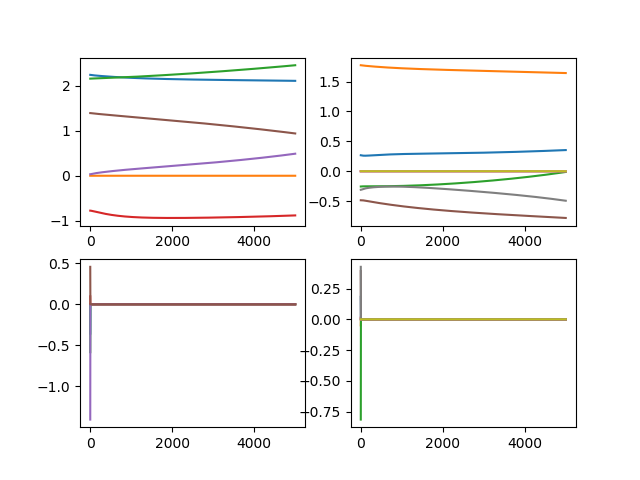

<IPython.core.display.Javascript object>


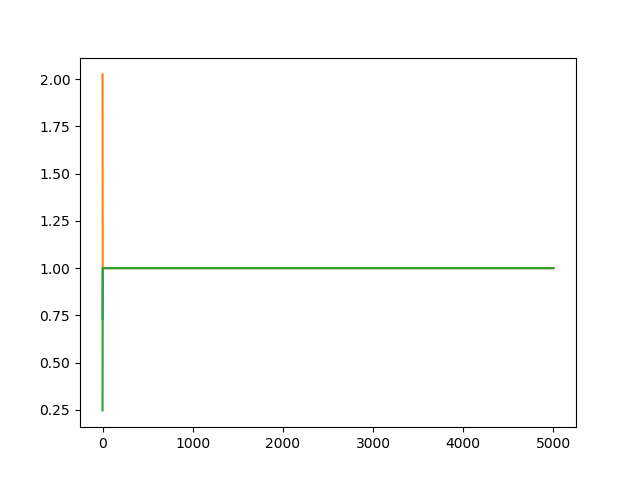

In [60]:
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(Wstar_t_novar[i].reshape((niter+1,-1)))
plt.figure()
plt.plot(Wstar_t_novar[4].reshape((niter+1,-1)))

In [ ]:
labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
Wstar_dict = {}
for i,label in enumerate(labels):
    Wstar_dict[label] = Wstar_t[i]

<IPython.core.display.Javascript object>


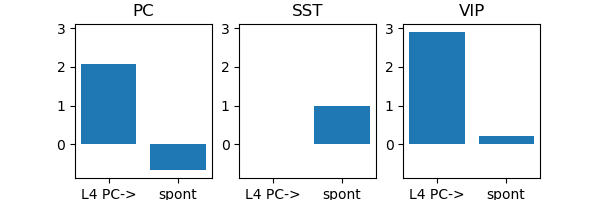

<IPython.core.display.Javascript object>


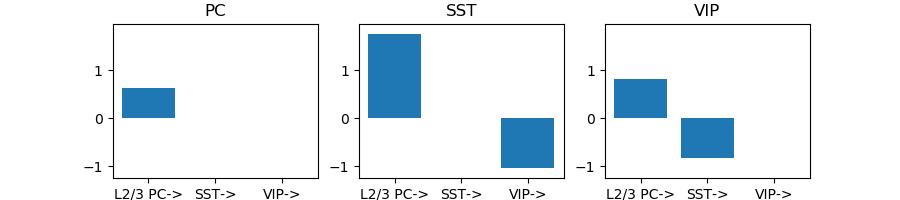

In [90]:
titles = ['PC','SST','VIP']
t = 1500
plt.figure(figsize=(6,2))
lbl = 'Wmx'
data = Wstar_dict[lbl][t]
x = np.arange(data.shape[0])
xlbl = ['L4 PC->','spont']
for icelltype in range(3):
    plt.subplot(1,3,icelltype+1)
    plt.bar(x,data[:,icelltype])
    plt.xticks(x,xlbl)
    plt.ylim(data.min()-0.2,data.max()+0.2)
    plt.title(titles[icelltype])
plt.savefig('figures/ff_weights.pdf')
plt.figure(figsize=(9,2))
lbl = 'Wmy'
data = Wstar_dict[lbl][t]
x = np.arange(data.shape[0])
xlbl = ['L2/3 PC->','SST->','VIP->']
for icelltype in range(3):
    plt.subplot(1,3,icelltype+1)
    plt.bar(x,data[:,icelltype])
    plt.xticks(x,xlbl)
    plt.ylim(data.min()-0.2,data.max()+0.2)
    plt.title(titles[icelltype])
plt.savefig('figures/recurrent_weights.pdf')

In [101]:
# labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
# Wstar_dict = {}
# for i,label in enumerate(labels):
#     Wstar_dict[label] = Wstar_t[i]
# np.save('w_over_time_miller_troyer_data_loss.npy',Wstar_dict,allow_pickle=True)

In [197]:
# labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
#Wstar_dict = {}
#for i,label in enumerate(labels):
#    Wstar_dict[label] = Wstar_t[i]


In [422]:
Wstar_t[-3].shape #.reshape((niter+1,-1)).shape

(10001, 30, 3)

In [61]:
def plot_tuning_and_loss(this_Wstar):
    plt.figure()
    plt.plot((this_Wstar[-3]/this_Wstar[-3].sum(1)[:,np.newaxis]).reshape((niter+1,-1)))
    plt.figure()
    plt.plot(this_Wstar[-1].reshape((niter+1,-1)))

<IPython.core.display.Javascript object>


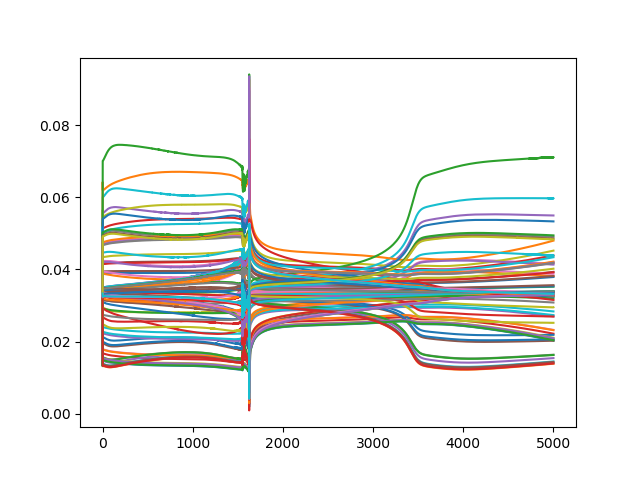

<IPython.core.display.Javascript object>


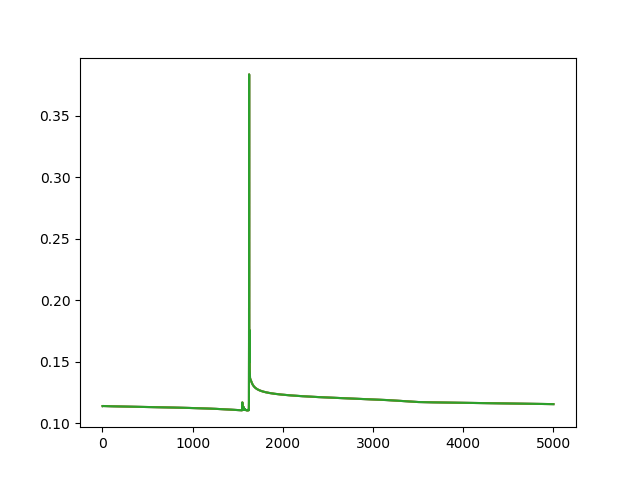

In [74]:
plot_tuning_and_loss(Wstar_t_novar)

In [256]:
def gaussian_fn(mu,sigma):
    return lambda x: 1/np.sqrt(2*np.pi)/np.abs(sigma)*np.exp(-0.5*(x-mu)/sigma**2)
xs = np.linspace(0,1,100)
ipt = 0
# plt.figure()
# for icelltype in range(2):
#     plt.plot(xs,gaussian_fn(um_fn(X[ipt],Y[ipt])[icelltype],us_fn(X[ipt],Y[ipt])[icelltype])(xs))

In [ ]:
# def compute_Y_nonlinear_t_evolution(X,Wmx,Wmy,Wsx,Wsy,f,Y0=None,bounds=None):
#     factr=1e7
#     epsilon=1e-8
#     pgtol=1e-5
    
# #     def parse_W(W): 
# #         Wx = W[:nP*nQ].reshape((nP,nQ))
# #         Wy = W[nP*nQ:].reshape((nQ,nQ))
# #         return Wx,Wy
    
#     def parse_Y(Y):
#         return Y.reshape((nN,nQ))

    
# #     Wx,Wy = parse_W(W)
#     nN,nQ = Y0.shape
    
#     Ystar = [None]*nNh
    
#     for i in range(nN):
#         def minusL(y):
#             def u_fn(Wx,Wy):
#                 return X[i] @ Wx + y @ Wy
#             return 0.5*(f(u_fn(Wmx,Wmy),u_fn(Wsx,Wsy)) - y)**2

#         def minusdLdy(y):
#             def u_fn(Wx,Wy):
#                 return X[i] @ Wx + y @ Wy
#             return f(u_fn(Wmx,Wmy),u_fn(Wsx,Wsy)) - y
        
#         #Ystar[i] = sop.fmin_l_bfgs_b(minusL,Y0[i],fprime=minusdLdw,bounds=bounds,pgtol=pgtol,factr=factr,epsilon=epsilon)
#         ntries = 100
#         itry = 0
#         succeeded = False
#         noise_lvl = 1e-2
#         while itry < ntries and succeeded is False:
#             try:
#                 itry = itry+1
#                 Ystar[i] = sop.newton(minusL,np.random.rand(*(Y0[i].shape)),fprime=minusdLdy)
#                 succeeded = not Ystar[i][-1]['warnflag']
#             except:
#                 pass

#         print("couldn't do " + str(i))
        
    
#     return Ystar

In [326]:
iiter = -1
Wmx,Wmy,Wsx,Wsy = [Wstar_t[i][iiter] for i in range(4)]

def fXY(x,y):
    return f_miller_troyer(x @ Wmx + y @ Wmy, x @ Wsx + y @ Wsy)

def u_fn_fn(Wx,Wy):
    return lambda x,y: x @ Wx + y @ Wy

def um_fn(x,y):
    return u_fn_fn(Wmy,Wmx)(x,y)

def us_fn(x,y):
    return u_fn_fn(Wsy,Wsx)(x,y)

# Ysolns = compute_Y_nonlinear_t_evolution(X,Wmx,Wmy,Wsx,Wsy,f_miller_troyer,Y0=Wstar_t[-2][iiter+1].copy())

In [327]:
Xlbl = [['L4','spont'],['PC','SST','VIP']]
Ylbl = ['PC','SST','VIP']

In [459]:
Wstar_t[3][-1]

array([[ 0.01331187,  0.        , -0.75213796],
       [ 0.06942798,  0.        ,  0.25367659],
       [ 0.        ,  0.        ,  0.        ]])

In [524]:
for i in range(2):
    values0 = np.round(Wstar_t_novar[i][-1],decimals=2)
    values1 = np.round(Wstar_t_novar[i+2][-1],decimals=2)
    to_print = np.zeros_like(values0,dtype='<U32')
    if np.mod(i,2)==0:
        for i in range(to_print.shape[0]):
            for j in range(to_print.shape[1]):
                to_print[i,j] = Xlbl[0][i] + ' -> ' + Xlbl[1][j] + ': ' + str(values0[i,j]) + ' +/- ' + str(values1[i,j])
    else: 
        for i in range(to_print.shape[0]):
            for j in range(to_print.shape[1]):
                to_print[i,j] = Ylbl[i] + ' -> ' + Ylbl[j] + ': ' + str(values0[i,j]) + ' +/- ' + str(values1[i,j])
    print(to_print)
    print('\n')
# for i in range(4,5):
#     values = np.round(Wstar_t[i][-1],decimals=2)
#     print(values)

[['L4 -> PC: 1.83 +/- 0.0' 'L4 -> SST: 0.0 +/- 0.0'
  'L4 -> VIP: 2.99 +/- 0.0']
 ['spont -> PC: -1.15 +/- 0.0' 'spont -> SST: 2.42 +/- 0.0'
  'spont -> VIP: 1.04 +/- 0.0']]


[['PC -> PC: 1.43 +/- 0.0' 'PC -> SST: 3.35 +/- 0.0'
  'PC -> VIP: 0.74 +/- 0.0']
 ['SST -> PC: -0.26 +/- 0.0' 'SST -> SST: 0.0 +/- 0.0'
  'SST -> VIP: -0.84 +/- 0.0']
 ['VIP -> PC: 0.0 +/- 0.0' 'VIP -> SST: -1.41 +/- 0.0'
  'VIP -> VIP: 0.0 +/- 0.0']]




<IPython.core.display.Javascript object>


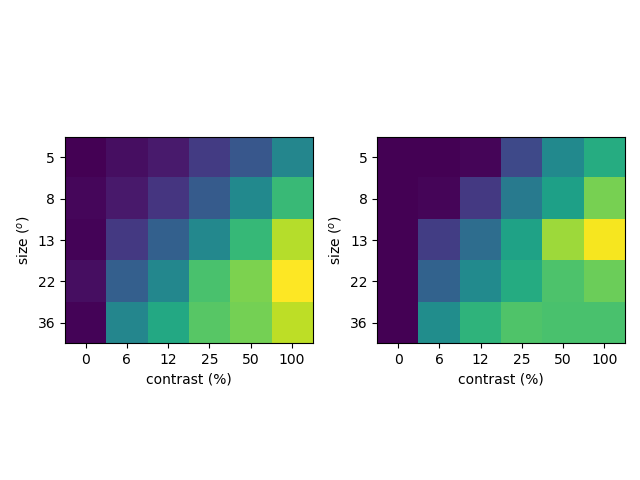

<IPython.core.display.Javascript object>


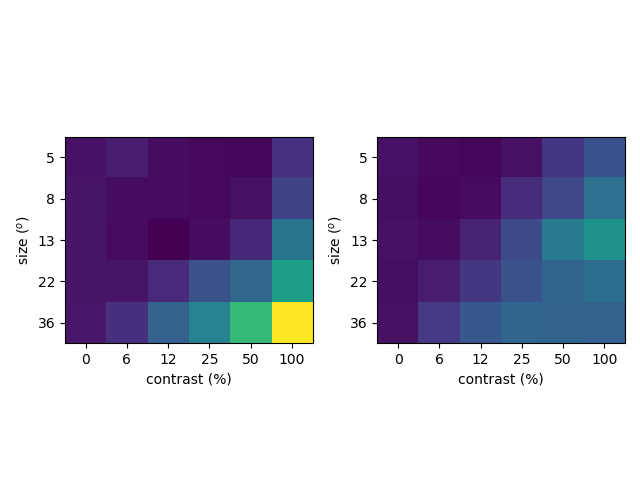

<IPython.core.display.Javascript object>


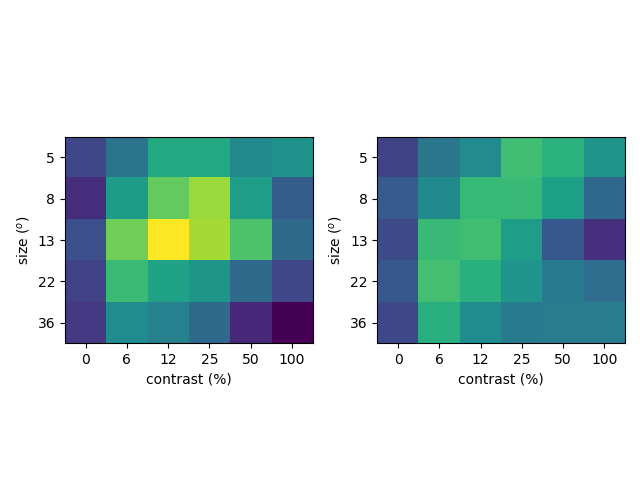

In [541]:
lbl = ['pc','sst','vip']
for icelltype in range(3):
    this_Wstar = Wstar_t_novar
    t = -1
    display_model_fit(Yhat[icelltype].mean(0)/Yhat[icelltype].mean(0).sum(),this_Wstar[-3][t,:,icelltype]/this_Wstar[-3][t,:,icelltype].sum())
    plt.savefig('figures/' + lbl[icelltype] + '_measured_modeled.pdf')

In [76]:
labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
Wstar_dict = {}
for i,label in enumerate(labels):
    Wstar_dict[label] = Wstar_t_novar[i]
np.save('w_over_time_miller_troyer_data_loss_no_variability.npy',Wstar_dict,allow_pickle=True)

In [77]:
Wstar_dict['Wmx'][1500]

array([[ 2.08250261,  0.        ,  2.90832984],
       [-0.67050153,  0.98161479,  0.2202244 ]])

In [612]:
np.save('w_over_time_miller_troyer_data_loss_momentum_imperfect_vip.npy',Wstar_dict,allow_pickle=True)

In [263]:
Yhat[0].shape

(6315, 30)

In [64]:
def scatter_results(this_Wstar,t=-1):
    plt.figure(figsize=(9,3))
    celltype = ['PC','SST','VIP']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(celltype[i])
        xx = Yhat[i].mean(0)/Yhat[i].mean(0).sum()
        yy = this_Wstar[-3][t,:,i]/this_Wstar[-3][t,:,i].sum()
        sca.scatter_size_contrast(xx,yy)
        plt.plot((0,xx.max()),(0,xx.max()),c='k')
        plt.xlabel('measured')
        plt.ylabel('modeled')
        plt.tight_layout()

In [599]:
icelltype = 3
u,s,v = np.linalg.svd(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])])
# plt.figure()
# plt.imshow(Rs[1][])

<IPython.core.display.Javascript object>


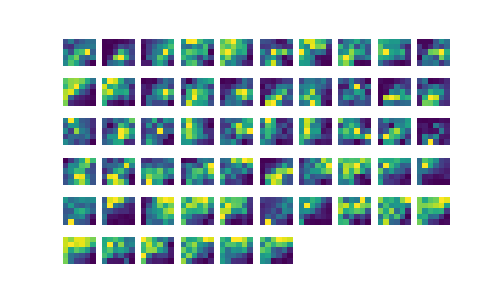

In [600]:
ut.imshow_in_rows(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])][np.where(np.logical_and(u[:,0]<np.percentile(u[:,0],52.5),u[:,0]>np.percentile(u[:,0],47.5)))].reshape((-1,5,6)))

<IPython.core.display.Javascript object>


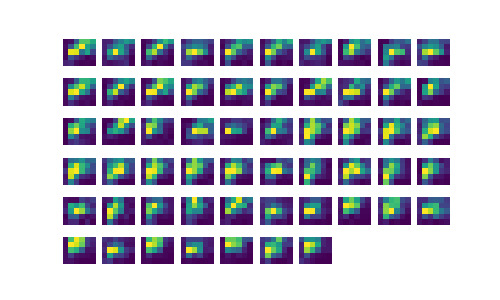

In [601]:
ut.imshow_in_rows(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])][np.where(u[:,0]<np.percentile(u[:,0],5))].reshape((-1,5,6)))

<IPython.core.display.Javascript object>


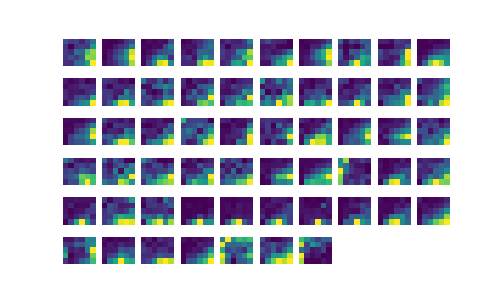

In [602]:
ut.imshow_in_rows(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])][np.where(u[:,0]>np.percentile(u[:,0],95))].reshape((-1,5,6)))

<IPython.core.display.Javascript object>


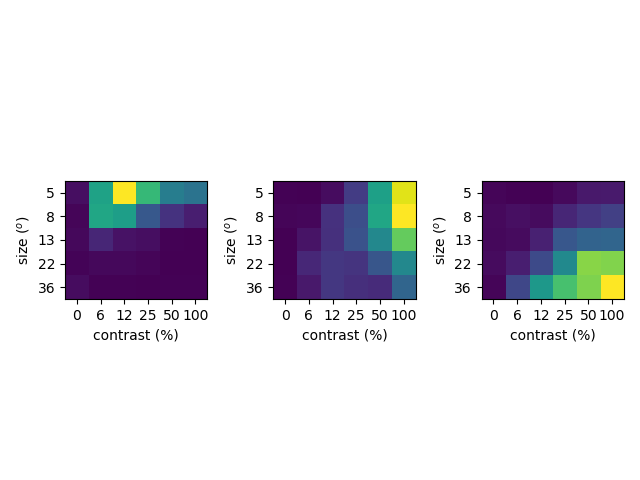

In [508]:
# # ut.imshow_in_rows(Rs[1][~np.isnan(Rs[1][:,0])][np.where(u[:,0]>np.percentile(u[:,0],95))].reshape((-1,5,6)))
# lower = np.where(u[:,0]<np.percentile(u[:,0],5))[0][28]
# middle = np.where(np.logical_and(u[:,0]<np.percentile(u[:,0],52.5),u[:,0]>np.percentile(u[:,0],47.5)))[0][19]
# upper = np.where(u[:,0]>np.percentile(u[:,0],95))[0][90]
# plt.figure()
# for i,thisone in enumerate([upper,middle,lower]):
#     plt.subplot(1,3,i+1)
#     sca.show_size_contrast(Rs[1][~np.isnan(Rs[1][:,0])][thisone].reshape((5,6)))
# plt.tight_layout()
# plt.savefig('figures/l23_pc_variability.pdf')

<IPython.core.display.Javascript object>


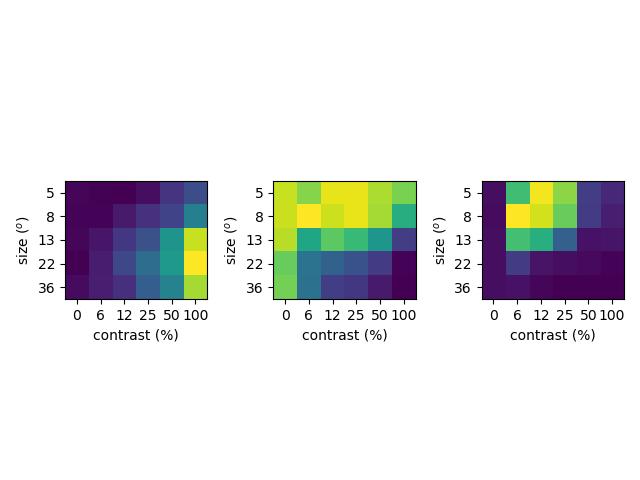

In [607]:
# ut.imshow_in_rows(Rs[1][~np.isnan(Rs[1][:,0])][np.where(u[:,0]>np.percentile(u[:,0],95))].reshape((-1,5,6)))
lower = np.where(u[:,0]<np.percentile(u[:,0],5))[0][50]
middle = np.where(np.logical_and(u[:,0]<np.percentile(u[:,0],52.5),u[:,0]>np.percentile(u[:,0],47.5)))[0][50]
upper = np.where(u[:,0]>np.percentile(u[:,0],95))[0][1]
plt.figure()
for i,thisone in enumerate([upper,middle,lower]):
    plt.subplot(1,3,i+1)
    sca.show_size_contrast(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])][thisone].reshape((5,6)))
plt.tight_layout()
plt.savefig('figures/vip_variability.pdf')

<IPython.core.display.Javascript object>


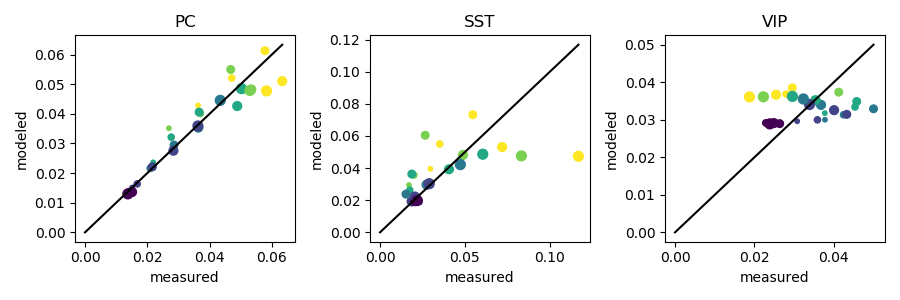

In [608]:
t = -1
scatter_results(Wstar_t,t=t) #int(5e3))
# plt.savefig('figures/pc_sst_vip_measured_modeled_miller_troyer.pdf')

<IPython.core.display.Javascript object>


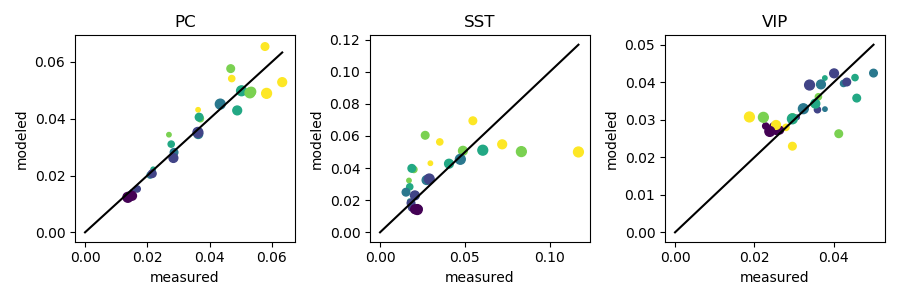

In [75]:
t = 1500
# t = 1
scatter_results(Wstar_t_novar,t=t) #int(5e3))
# plt.savefig('figures/pc_sst_vip_measured_modeled_miller_troyer_no_var.pdf')

<IPython.core.display.Javascript object>


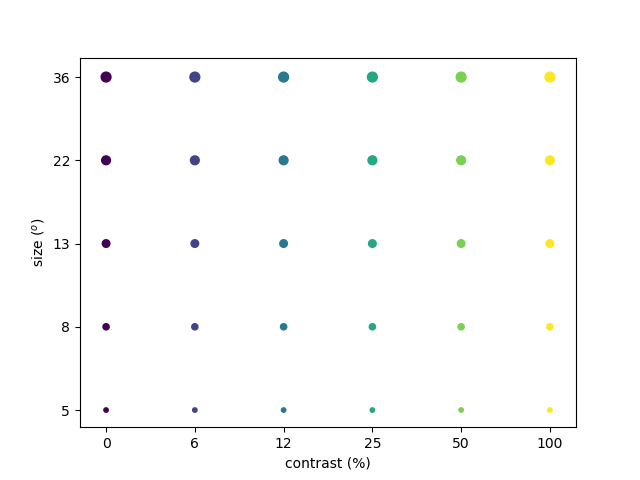

In [519]:
plt.figure()
xx,yy = np.meshgrid(np.arange(6),np.arange(5))
xx = xx.flatten()
yy = yy.flatten()
sca.scatter_size_contrast(xx,yy)
plt.xticks(np.arange(6),(0,6,12,25,50,100))
plt.xlabel('contrast (%)')
plt.yticks(np.arange(5),(5,8,13,22,36))
plt.ylabel('size ($^o$)')
plt.savefig('figures/measured_modeled_legend.pdf')
# plt.axis('off')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


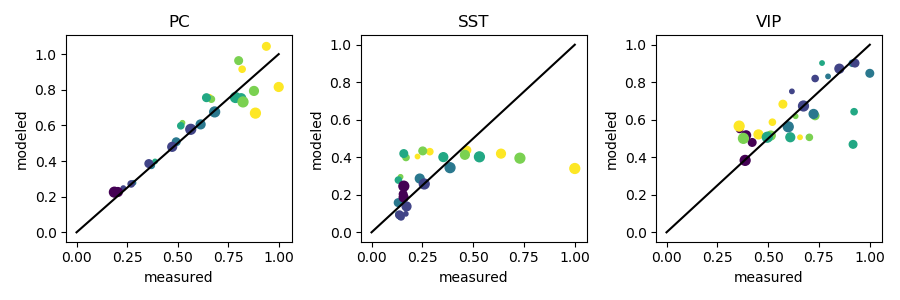

In [245]:
niter = int(1e3)
Ws = [Wstar_t[i][-1].copy() + 1e-2*np.random.randn(*Wstar_t[i][-1].shape) for i in range(4)]
Wstar_t2 = fit_W_linearized_pointwise(X.copy(),Yhat.copy(),f_miller_troyer,Y0=Yhat.copy(),W0mx=Ws[0],W0my=Ws[1],W0sx=Ws[2],W0sy=Ws[3],bounds=bounds,niter=niter,weight=np.array((1,10,1)))
scatter_results(Wstar_t2)

In [610]:
iiter = -1
Wmx,Wmy,Wsx,Wsy,s02,Y1 = [Wstar_t[i][iiter] for i in range(6)]

def fXY(x,y):
    return f_miller_troyer(x @ Wmx + y @ Wmy, (x @ Wsx + y @ Wsy)**2 + s02)

def u_fn_fn(Wx,Wy):
    return lambda x,y: x @ Wx + y @ Wy

def um_fn(x,y):
    return u_fn_fn(Wmy,Wmx)(x,y)

def us_fn(x,y):
    return u_fn_fn(Wsy,Wsx)(x,y)

#Y,diagnostics = compute_Y_nonlinear(X,Wmx,Wmy,Wsx,Wsy,f_miller_troyer,Y0=Wstar_t[-2][iiter+1].copy()) # _t_evolution
for i in range(Y1.shape[0]):
    
    def fY(y):
        return fXY(X[i],y) - y
    
    print('largest eigenvalues: ' + str(np.linalg.eig(jacobian(fY)(Y1[i]))[0]))
    print('eigenvectors: ' + str(np.linalg.eig(jacobian(fY)(Y1[i]))[1][:,-1]))
#     print('determinant: ' + str(np.linalg.det(jacobian(fY)(Y[i]))))
#     print('function output: ' + str(fY(Y[i])))
#     print('function input: ' + str(Y[i]))

largest eigenvalues: [-0.66821096+0.60890176j -0.66821096-0.60890176j -1.37040695+0.j        ]
eigenvectors: [0.28485281+0.j 0.1528855 +0.j 0.94630064+0.j]
largest eigenvalues: [-0.65148619+0.63326009j -0.65148619-0.63326009j -1.36614756+0.j        ]
eigenvectors: [0.28908769+0.j 0.1439802 +0.j 0.94641323+0.j]
largest eigenvalues: [-0.64154263+0.64864263j -0.64154263-0.64864263j -1.36515533+0.j        ]
eigenvectors: [0.2916984 +0.j 0.14038507+0.j 0.94615225+0.j]
largest eigenvalues: [-0.58730937+0.75277845j -0.58730937-0.75277845j -1.37176391+0.j        ]
eigenvectors: [0.30887351+0.j 0.13233083+0.j 0.94185227+0.j]
largest eigenvalues: [-0.50985726+0.98161293j -0.50985726-0.98161293j -1.3959262 +0.j        ]
eigenvectors: [0.34107584+0.j 0.13493454+0.j 0.93030099+0.j]
largest eigenvalues: [-0.46840821+1.15808993j -0.46840821-1.15808993j -1.40772094+0.j        ]
eigenvectors: [0.36059239+0.j 0.13832064+0.j 0.92241017+0.j]
largest eigenvalues: [-0.66157528+0.61841491j -0.66157528-0.6184

In [249]:
Y1

array([[0.15243853, 0.11057011, 0.41513677],
       [0.23182894, 0.12889643, 0.59328132],
       [0.29390933, 0.14520361, 0.69766982],
       [0.46830868, 0.20535085, 0.84403698],
       [0.62460645, 0.30157164, 0.68291007],
       [0.71729158, 0.37428579, 0.5805314 ],
       [0.16394993, 0.11287326, 0.44526757],
       [0.28217892, 0.14194238, 0.6802637 ],
       [0.44137349, 0.19432852, 0.83576387],
       [0.61572789, 0.29371826, 0.70435117],
       [0.70748263, 0.36695086, 0.58542554],
       [0.84691103, 0.46754206, 0.56644637],
       [0.15048463, 0.11018327, 0.4099473 ],
       [0.4539447 , 0.19937058, 0.84038107],
       [0.57324872, 0.26003138, 0.79551172],
       [0.7081649 , 0.36755825, 0.58476749],
       [0.88826042, 0.49768086, 0.57082287],
       [0.95707326, 0.54861572, 0.58300263],
       [0.1559611 , 0.11126542, 0.42447282],
       [0.55120743, 0.24622017, 0.82104809],
       [0.6198807 , 0.29737912, 0.6941871 ],
       [0.71155616, 0.37005966, 0.58312132],
       [0.

<IPython.core.display.Javascript object>


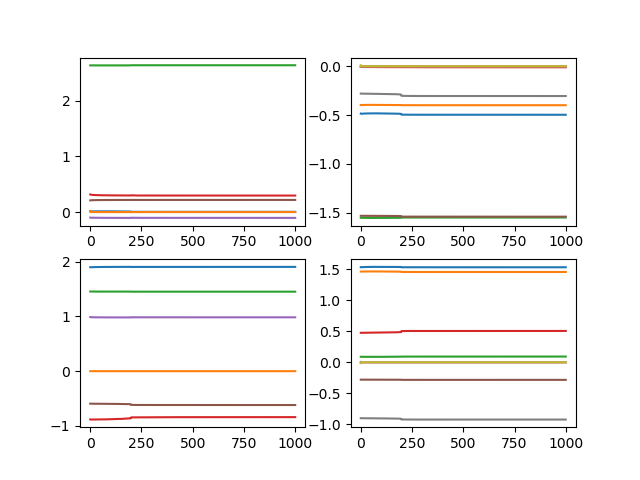

In [246]:
def plot_weights_over_time(this_Wstar):
    plt.figure()
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.plot(this_Wstar[i].reshape((niter+1,-1)))
plot_weights_over_time(Wstar_t2)

In [274]:
nQ = Y.shape[1]
def parse_W(W):
        shapeW = (nQ,nQ)
        sizeW = np.prod(shapeW)
        nW = 4
        Ws = [None]*nW
        for i in range(nW):
            Ws[i] = W[i*sizeW:(i+1)*sizeW].reshape(shapeW)
        return Ws
Ws = parse_W(Wstar[0])

In [275]:
Y1 = compute_Y_nonlinear(X,*Ws,f_miller_troyer,Y0=Y0)

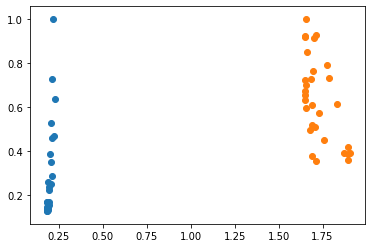

In [276]:
plt.figure()
# plt.scatter(f(X @ Wx + Y @ Wy).flatten(),Y.flatten())
for i in range(Y.shape[1]):
    plt.scatter(Y0[:,i],Y[:,i])

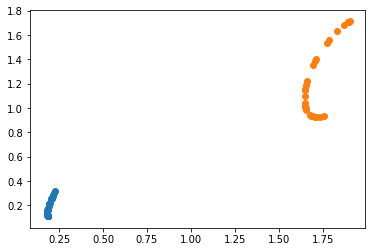

In [277]:
plt.figure()
# plt.scatter(f(X @ Wx + Y @ Wy).flatten(),Y.flatten())
for i in range(Y.shape[1]):
    plt.scatter(Y0[:,i],Y1[:,i])

In [491]:
diagnostics

[(array([0.07590516, 0.16438597]),
  0.002892952845580517,
  {'grad': array([ 0.00350314, -0.01427093]),
   'task': b'ABNORMAL_TERMINATION_IN_LNSRCH',
   'funcalls': 57,
   'nit': 1,
   'warnflag': 2}),
 (array([0.08371026, 0.18076958]),
  0.0035159924935236103,
  {'grad': array([ 0.00603596, -0.0151144 ]),
   'task': b'ABNORMAL_TERMINATION_IN_LNSRCH',
   'funcalls': 21,
   'nit': 0,
   'warnflag': 2}),
 (array([0.09198376, 0.19835681]),
  0.0042315034102210665,
  {'grad': array([ 0.06981335, -0.00428242]),
   'task': b'ABNORMAL_TERMINATION_IN_LNSRCH',
   'funcalls': 21,
   'nit': 0,
   'warnflag': 2}),
 (array([0.109196  , 0.23462734]),
  0.00597166243487739,
  {'grad': array([ 0.0344488 , -0.01411697]),
   'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
   'funcalls': 32,
   'nit': 2,
   'warnflag': 0}),
 (array([0.13124416, 0.28118814]),
  0.008626608249659579,
  {'grad': array([ 0.03536171, -0.01777716]),
   'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  

In [ ]:
y = array([0.07590516, 0.16438597])
f_miller

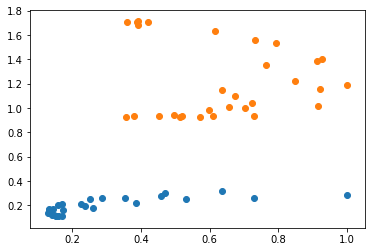

In [278]:
plt.figure()
# plt.scatter(f(X @ Wx + Y @ Wy).flatten(),Y.flatten())
for i in range(Y.shape[1]):
    plt.scatter(Y[:,i],Y1[:,i])

In [279]:
# W0 = np.concatenate((W0x.flatten(),W0y.flatten()))
bounds = [(-np.inf,np.inf)]*16
offset = 0
bounds[offset+4] = (0,0)
bounds[offset+7] = (0,0)
offset = 8
bounds[offset+4] = (0,0)
bounds[offset+7] = (0,0)
bounds = tuple(bounds)
Niter = 200
w0my = W0my
w0mx = W0mx
w0sy = W0sy
w0sx = W0sx
Wstar = [None]*Niter
eta = 0.1
for i in range(Niter):
    Wstar[i] = fit_W_linearized_WY(X,Y,f_miller_troyer,Y0=Y,W0mx=w0mx,W0my=w0my,W0sx=w0sx,W0sy=w0sy,bounds=bounds)
    w1mx,w1my,w1sx,w1sy = parse_W(Wstar[i][0])
    w0mx = w0mx + eta*(w1mx-w0mx)
    w0my = w0my + eta*(w1my-w0my)
    w0sx = w0sx + eta*(w1sx-w0sx)
    w0sy = w0sy + eta*(w1sy-w0sy)

In [287]:
Wt = np.zeros((Niter,)+(Wstar[0][0].shape))
Yt = np.zeros((Niter,)+(Y.shape))
for i in range(Niter):
    print(i)
    Wt[i] = Wstar[i][0]
    wmx,wmy,wsx,wsy = parse_W(Wt[i])
    Yt[i] = compute_Y_nonlinear(X,wmx,wmy,wsx,wsy,f_miller_troyer,Y0=Y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


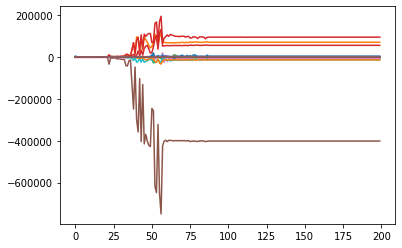

In [297]:
plt.figure()
for i in range(Wt.shape[1]):
    plt.plot(Wt[:,i])

In [299]:
Wt[60]

array([  -2650.28820038,   67637.4935345 ,    4074.34417779,
         54463.21523021,       0.        , -404651.66764672,
        -20432.76063931,       0.        ,    1039.50187873,
        -17600.42502162,    -940.64376186,  -14055.94816129,
             0.        ,  105290.99901942,    5339.32977626,
             0.        ])

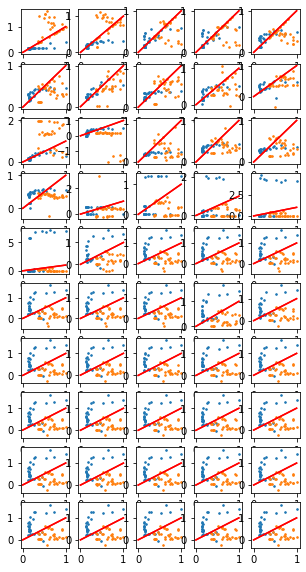

In [289]:
plt.figure(figsize=(5,20))
for i in range(0,Niter,4):
    plt.subplot(20,5,int(i/4)+1)
    for j in range(2):
        plt.scatter(Y[:,j],Yt[i,:,j],s=2.5)
        plt.plot((0,1),(0,1),c='r')

In [304]:
u,s,v = np.linalg.svd(Rpc[~np.isnan(Rpc.sum(1))])

In [307]:
np.diag(s).shape

(30, 30)

In [308]:
def pca_denoise(arr,Npc):
    u,s,v = np.linalg.svd(arr)
    return u[:,:Npc] @ np.diag(s[:Npc]) @ v[:Npc,:]

In [309]:
Rpc2 = pca_denoise(Rpc[~np.isnan(Rpc.sum(1))],10)

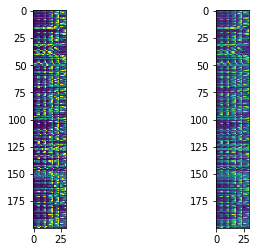

In [312]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(Rpc[:200])
plt.subplot(1,2,2)
plt.imshow(Rpc2[:200])

In [437]:
def fit_W_linearized(X,Y,f,Y0=None,W0mx=None,W0my=None,W0sx=None,W0sy=None,bounds=None):
    # X is (N,P), y is (N,Q). Finds wZx, wZy: (P,Q) + (Q,Q) weight matrices to explain Y as Y = f(Xwmx + Ywmy,Xwsx + Ywsy)
    # f is a static nonlinearity, given as a function
    
    factr=1e7
    epsilon=1e-8
    pgtol=1e-5
    fudge = 1e-4
    
    fprime_m = egrad(f,0)
    fprime_s = egrad(f,1)
    nN,nP = X.shape
    nQ = Y.shape[1]
    assert(nN==Y.shape[0])
    
    #W0x,W0y = parse_W(W0)
    
    u_fn = lambda Wx,Wy: X @ Wx + Y0 @ Wy
    
    um0 = u_fn(W0mx,W0my) # (N,Q)
    us0 = u_fn(W0sx,W0sy) # (N,Q)
    Fsquiggle = f(um0,us0) # (N,Q)
    Fprime_m_squiggle = np.maximum(fprime_m(um0,us0),fudge) # (N,Q)
    Fprime_s_squiggle = np.maximum(fprime_s(um0,us0),fudge) # (N,Q)
    
#     Phi = np.zeros((nN,nQ,nQ))
#     Phi_m = np.zeros((nN,nQ,nQ)) # Phi now means Fprime rather than 1/Fprime
#     Phi_s = np.zeros((nN,nQ,nQ))
#     for i in range(nN):
#         np.fill_diagonal(Phi[i],F_squiggle[i])
#         np.fill_diagonal(Phi_m[i],Fprime_m_squiggle[i]) # is there a cleaner way?
#         np.fill_diagonal(Phi_s[i],Fprime_s_squiggle[i])
    
#     A0 = -u0 - (Y0 @ W0y) + Fsquiggle/Fprimesquiggle
#     A = Phi - Phi_m @ Y0 @ W0my - Phi_s @ Y0 @ W0sy
    A0 = Fsquiggle - Fprime_m_squiggle * u_fn(W0mx,W0my) - Fprime_s_squiggle * u_fn(W0sx,W0sy)
    
    # N
    
    W0 = np.concatenate((W0mx.flatten(),W0my.flatten(),W0sx.flatten(),W0sy.flatten()),axis=0)
    
    def compute_Y(Wmx,Wmy,Wsx,Wsy):
        
        A1 = Fprime_m_squiggle * (X @ Wmx) + Fprime_s_squiggle * (X @ Wsx)
        A = A0 + A1
        
        WFm = np.einsum('jk,ik->ijk',Wmy,Fprime_m_squiggle)
        WFs = np.einsum('jk,ik->ijk',Wsy,Fprime_s_squiggle)
        Omega = np.eye(nQ) - WFm - WFs
        
        Y = np.einsum('ik,ikj->ij',A,np.linalg.inv(Omega))

#         Y = (A @ np.linalg.inv(Phi-W0y))[np.eye(nN,dtype='bool')]
#         Y = np.zeros((nN,nQ))
#         for i in range(nN):
#             Y[i] = A[i] @ np.linalg.inv(Phi[i]-W0y) # (Q,) @ (Q,Q).
#         assert(True==False)
        return Y
    
    def minusL(W):
        Wmx,Wmy,Wsx,Wsy = parse_W(W)
        return 0.5*np.sum((compute_Y(Wmx,Wmy,Wsx,Wsy) - Y)**2)
    
    def minusdLdw(W): 
        # sum in first dimension: (N,1) times (N,1) times (N,P)
        return egrad(minusL)(W)
    
    def parse_W(W):
        shapeW = (nQ,nQ)
        sizeW = np.prod(shapeW)
        nW = 4
        Ws = [None]*nW
        for i in range(nW):
            Ws[i] = W[i*sizeW:(i+1)*sizeW].reshape(shapeW)
        return Ws
        
    
    Wstar = sop.fmin_l_bfgs_b(minusL,W0,fprime=minusdLdw,bounds=bounds,pgtol=pgtol,factr=factr,epsilon=epsilon)
    
#     assert(True==False)
    
    return Wstar

In [438]:
def fit_W_linearized_WY(X,Y,f,Y0=None,W0mx=None,W0my=None,W0sx=None,W0sy=None,bounds=None):
    # X is (N,P), y is (N,Q). Finds wZx, wZy: (P,Q) + (Q,Q) weight matrices to explain Y as Y = f(Xwmx + Ywmy,Xwsx + Ywsy)
    # f is a static nonlinearity, given as a function
    
    factr=1e7
    epsilon=1e-8
    pgtol=1e-5
    fudge = 1e-4
    
    fprime_m = egrad(f,0)
    fprime_s = egrad(f,1)
    nN,nP = X.shape
    nQ = Y.shape[1]
    assert(nN==Y.shape[0])
    
    #W0x,W0y = parse_W(W0)
    
    u_fn = lambda Wx,Wy: X @ Wx + Y0 @ Wy
    
    um0 = u_fn(W0mx,W0my) # (N,Q)
    us0 = u_fn(W0sx,W0sy) # (N,Q)
    Fsquiggle = f(um0,us0) # (N,Q)
    Fprime_m_squiggle = np.maximum(fprime_m(um0,us0),fudge) # (N,Q)
    Fprime_s_squiggle = np.maximum(fprime_s(um0,us0),fudge) # (N,Q)
    
#     Phi = np.zeros((nN,nQ,nQ))
#     Phi_m = np.zeros((nN,nQ,nQ)) # Phi now means Fprime rather than 1/Fprime
#     Phi_s = np.zeros((nN,nQ,nQ))
#     for i in range(nN):
#         np.fill_diagonal(Phi[i],F_squiggle[i])
#         np.fill_diagonal(Phi_m[i],Fprime_m_squiggle[i]) # is there a cleaner way?
#         np.fill_diagonal(Phi_s[i],Fprime_s_squiggle[i])
    
#     A0 = -u0 - (Y0 @ W0y) + Fsquiggle/Fprimesquiggle
#     A = Phi - Phi_m @ Y0 @ W0my - Phi_s @ Y0 @ W0sy
    A0 = Fsquiggle - Fprime_m_squiggle * u_fn(W0mx,W0my) - Fprime_s_squiggle * u_fn(W0sx,W0sy) 
    A0 = A0 - Fprime_m_squiggle * (Y0 @ W0my) - Fprime_s_squiggle * (Y0 @ W0sy)
    
    # N
    
    W0 = np.concatenate((W0mx.flatten(),W0my.flatten(),W0sx.flatten(),W0sy.flatten()),axis=0)
    
    def compute_Y(Wmx,Wmy,Wsx,Wsy):
        
        A1 = Fprime_m_squiggle * u_fn(Wmx,Wmy) + Fprime_s_squiggle * u_fn(Wsx,Wsy)
        A = A0 + A1
        
        WFm = np.einsum('jk,ik->ijk',W0my,Fprime_m_squiggle)
        WFs = np.einsum('jk,ik->ijk',W0sy,Fprime_s_squiggle)
        Omega = np.eye(nQ) - WFm - WFs
        
        Y = np.einsum('ik,ikj->ij',A,np.linalg.inv(Omega))

#         Y = (A @ np.linalg.inv(Phi-W0y))[np.eye(nN,dtype='bool')]
#         Y = np.zeros((nN,nQ))
#         for i in range(nN):
#             Y[i] = A[i] @ np.linalg.inv(Phi[i]-W0y) # (Q,) @ (Q,Q).
#         assert(True==False)
        return Y
    
    def minusL(W):
        Wmx,Wmy,Wsx,Wsy = parse_W(W)
        return 0.5*np.sum((compute_Y(Wmx,Wmy,Wsx,Wsy) - Y)**2)
    
    def minusdLdw(W): 
        # sum in first dimension: (N,1) times (N,1) times (N,P)
        return egrad(minusL)(W)
    
    def parse_W(W):
        shapeW = (nQ,nQ)
        sizeW = np.prod(shapeW)
        nW = 4
        Ws = [None]*nW
        for i in range(nW):
            Ws[i] = W[i*sizeW:(i+1)*sizeW].reshape(shapeW)
        return Ws
        
    
    Wstar = sop.fmin_l_bfgs_b(minusL,W0,fprime=minusdLdw,bounds=bounds,pgtol=pgtol,factr=factr,epsilon=epsilon)
    
#     assert(True==False)
    
    return Wstar